# Lab exercises 3 - Eva Agrawal & Robin de Groot Part 1

For this lab exercises, please submit 2 notebooks / python script and 2 reports, one for each part. The deadline is 22 december.

It is important the you **read the documentation** to understand how to use Pytorch functions, what kind of transformation they apply etc. You have to **take time to read it carefully** to understand what you are doing.

- https://pytorch.org/docs/stable/nn.html
- https://pytorch.org/docs/stable/torch.html


The following libraries are necessary for this assignment.

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import seaborn as sns
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

sns.set()

import dataset_loader

%matplotlib inline

## 1. Part one: MNIST classification with Pytorch

The goal of the first part is to learn how to use Pytorch and to observe the impact of regularization during training. You should test different network architectures, e.g. with hidden layers of size 128-128, 128-64-32-16, 256-128-64-32-16, 512-256-128-64-32-16, 800-800, and different activation functions (tanh, relu, sigmoid).

Remember that Pytorch expects data in a different format than in the previous lab exercise: the first dimension is always the batch dimension.

In [9]:
# Download mnist dataset 
if("mnist.pkl.gz" not in os.listdir(".")):
    !wget http://deeplearning.net/data/mnist/mnist.pkl.gz

# if you have it somewhere else, you can comment the lines above
# and overwrite the path below
mnist_path = "./mnist.pkl.gz"

In [10]:
# load the 3 splits
train_data, dev_data, test_data = dataset_loader.load_mnist(mnist_path)

In [11]:
train_img = train_data[0]
train_label = train_data[1]
dev_img = dev_data[0]
dev_label = dev_data[1]
test_img = test_data[0]
test_label = test_data[1]

In [12]:
train_img[1].shape

(784,)

In [13]:
train_label

array([8, 5, 7, ..., 1, 3, 2], dtype=int64)

In [26]:
train_img

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [28]:
type(train_img[0])

numpy.ndarray

### 1.2. Layer initialization

By default, Pytorch will apply Kaiming initialization to linear layers. However, I recommend you to always explicitly initialize you network by hand in the constructor.


In [14]:
class ReluMLP(nn.Module):
    def __init__(self, input_dim, layer_dims, dropout_value):
        super(ReluMLP, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, layer_dims[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_value))
        layers.append(nn.Linear(layer_dims[0], layer_dims[1]))
        layers.append(nn.ReLU())
        for i in range(len(layer_dims)-2):
            layers.append(nn.Dropout(dropout_value))
            layers.append(nn.Linear(layer_dims[i+1], layer_dims[i+2]))
            layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_value))
        layers.append(nn.Linear(layer_dims[-1], 10))
        self.seq = nn.Sequential(*layers)
                    
    def forward(self, inputs):
        return self.seq(inputs)

In [15]:
NLLloss = nn.CrossEntropyLoss()

In [21]:
def training(model,
            train_images,
            train_labels,
            loss_function,
            optimizer,
            dev_images,
            dev_labels,
            n_epochs,
            batch_size):
    
    loss_list = []
    dev_acc_list = []

    cuda0 = torch.device('cuda:0')
            
    for epoch in range(n_epochs):
        print('Starting epoch: {}'.format(epoch))
        model.train()
        cost = 0
        
        for first in range(0, len(train_images), batch_size):
            model.zero_grad()
            
            batch_input = torch.cat(
                [
                    torch.from_numpy(image).reshape(1, -1)
                    for image in train_images[first:first + batch_size]
                    
                ],
                    dim=0
            )
            batch_labels = torch.from_numpy(train_labels[first:first + batch_size].reshape(-1, 1)).to(cuda0)
            output = model(batch_input.to(cuda0))
            # compute loss, backprop and call step()
            
            batch_labels = batch_labels.squeeze_()
            #print('labels: ', batch_labels)
            #print('output: ', output)
            
            loss = loss_function(output, batch_labels)
            loss.backward()
            torch.nn.utils.clip_grad_value_(model.parameters(), 5.)
            optimizer.step()
            cost += loss.item()             
            
        mean_loss = cost / (len(train_images)/batch_size + 1)
        acc = accuracy(model, dev_images, dev_labels, batch_size)
        print('mean loss: ', mean_loss)
        print('dev accuracy: ', acc)
        
        loss_list.append(mean_loss)
        dev_acc_list.append(acc) 
    
    return model, loss_list, dev_acc_list
            
#model = ReluMLP(784, layer_dims = [128,128], dropout_value = 0)
#optimizer = torch.optim.SGD(model.parameters(),lr=0.01)

#training(model, train_img, train_label, NLLloss, optimizer, dev_img, dev_label, 10, 10)

In [22]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.kaiming_uniform_(m.weight.data)
        nn.init.zeros_(m.bias.data)

In [23]:
def plot_graphs(mean_losses, 
                dev_accus, 
                dropout_value, 
                layer_dims,
                lr,
                batch_size,
                activationfunction):
    #print(mean_losses.shape)
    #print(dev_accus)
    #print(dev_accus.shape)
    #print([i for i in range(EPOCHS)].shape)
    plt.plot([i for i in range(EPOCHS)],mean_losses, label='mean loss')
    plt.plot([i for i in range(EPOCHS)],dev_accus, label='accuracy on dev')
    plt.xlabel('Epochs')
    plt.title('{} hidden layers, {} dropout, {} learning rate, {} batch_size, {} activation function'.format(layer_dims,
                                                          dropout_value, lr, batch_size, activationfunction))
    plt.legend()
    plt.savefig('{}hidden layers{}dropout{}learning rate{}batch_size{}acivationfunctoin.png'.format(layer_dims,
                                                          dropout_value, lr, batch_size, activationfunction))
    plt.show()

In [24]:
def accuracy(model, images, labels, batch_size):
    correct = 0
    total = 0
    model.eval()
    cuda0 = torch.device('cuda:0')
    for i in range(len(images)):
        #print(images[i])
        output = model(torch.from_numpy(images[i]).reshape(1, -1).to(cuda0))

        _, predicted = torch.max(output.data, 1)
        #print(batch_labels.size(0))
        total += 1
        #print(predicted)
        #print(type(predicted))
        #print(labels[i])
        #print(type(labels[i]))
        correct += (predicted == labels[i]).item()
        #print(correct.item())
    
    return correct/total

In [25]:
layer_dims_testing = [[128, 128], [128,64,32,16], [256,128,64,32,16], [512,256,128,64,32,16], [800,800]]
input_dim = len(train_img[0])
dropout_values = [0, 0.2, 0.4, 0.6]
learning_rates = [0.1, 0.01, 0.001, 0.0001]
models_list = []
mean_loss_list = []
dev_accuracy_list = []

EPOCHS = 20
batch_sizes = [10, 100, 1000]

cuda0 = torch.device('cuda:0')

for layerdim in layer_dims_testing:
    for lr in learning_rates:  
        for dropout_value in dropout_values:
            for batch_size in batch_sizes:
                model = ReluMLP(input_dim, layerdim, dropout_value)
                model.apply(init_weights)
                model = model.to(cuda0)
                optimizer = torch.optim.SGD(model.parameters(),lr=lr)
                model, mean_losses, dev_accus = training(model, train_img, train_label, NLLloss, optimizer, dev_img, dev_label, EPOCHS, batch_size)
                models_list.append(model)
                mean_loss_list.append(mean_losses)
                dev_accuracy_list.append(dev_accus)
                plot_graphs(mean_losses, dev_accus, dropout_value, layerdim, lr, batch_size, "ReLU")

Starting epoch: 0
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ...,

        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0.,

        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0.,

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ...,

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ...,

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ...,

end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 

        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0.,

        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0.,

        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0.,

        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0.,

        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0.,

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ...,

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ...,

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ...,

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ...,

        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0.,

        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0.,

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ...,

        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0.,

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ...,

        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0.,

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ...,

        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0.,

        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0.,

        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0.,

        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0.,

        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0.,

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ...,

end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 

        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0.,

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ...,

        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0.,

        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0.,

        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0.,

        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0.,

        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0.,

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ...,

        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0.,

        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0.,

        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0.,

        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0.,

        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0.,

        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0.,

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ...,

        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0.,

        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0.,

        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0.,

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ...,

        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0.,

        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0.,

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ...,

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ...,

        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
end of stuff
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0.,

KeyboardInterrupt: 

Starting epoch: 0
mean loss:  0.20454302782221365
dev accuracy:  0.968
Starting epoch: 1
mean loss:  0.07556292522338647
dev accuracy:  0.9726
Starting epoch: 2
mean loss:  0.042492967485147415
dev accuracy:  0.9766
Starting epoch: 3
mean loss:  0.02535777923997827
dev accuracy:  0.9692
Starting epoch: 4
mean loss:  0.017998937260085574
dev accuracy:  0.9735
Starting epoch: 5
mean loss:  0.017228951937397267
dev accuracy:  0.9758
Starting epoch: 6
mean loss:  0.014263621348344913
dev accuracy:  0.9746
Starting epoch: 7
mean loss:  0.011565879270679464
dev accuracy:  0.9777
Starting epoch: 8
mean loss:  0.010879194675349951
dev accuracy:  0.98
Starting epoch: 9
mean loss:  0.005587403893734203
dev accuracy:  0.982
Starting epoch: 10
mean loss:  0.004725272861329319
dev accuracy:  0.9825
Starting epoch: 11
mean loss:  0.0036272166432581503
dev accuracy:  0.9785
Starting epoch: 12
mean loss:  0.0034203788626455058
dev accuracy:  0.9843
Starting epoch: 13
mean loss:  0.0030879280311689543


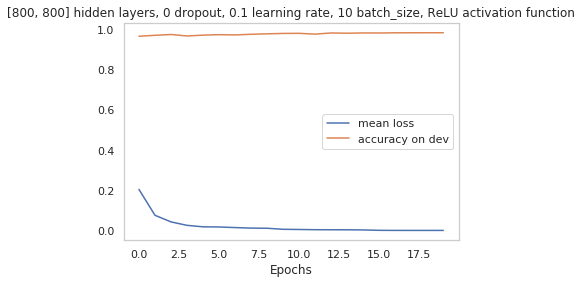

Starting epoch: 0
mean loss:  0.35069631856537153
dev accuracy:  0.9485
Starting epoch: 1
mean loss:  0.16246654760992219
dev accuracy:  0.9634
Starting epoch: 2
mean loss:  0.11509363266626399
dev accuracy:  0.9684
Starting epoch: 3
mean loss:  0.08802722670145317
dev accuracy:  0.9715
Starting epoch: 4
mean loss:  0.06976222061364355
dev accuracy:  0.9734
Starting epoch: 5
mean loss:  0.05619682485010929
dev accuracy:  0.975
Starting epoch: 6
mean loss:  0.04562244810045003
dev accuracy:  0.9769
Starting epoch: 7
mean loss:  0.037279022021958985
dev accuracy:  0.9776
Starting epoch: 8
mean loss:  0.030632826787774674
dev accuracy:  0.9787
Starting epoch: 9
mean loss:  0.02522634489353962
dev accuracy:  0.979
Starting epoch: 10
mean loss:  0.020830144641917205
dev accuracy:  0.9794
Starting epoch: 11
mean loss:  0.017237903426183823
dev accuracy:  0.9795
Starting epoch: 12
mean loss:  0.014327456531469931
dev accuracy:  0.9801
Starting epoch: 13
mean loss:  0.011991062737860068
dev ac

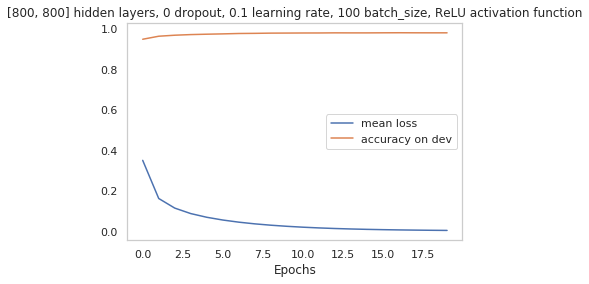

Starting epoch: 0
mean loss:  0.8479591426896114
dev accuracy:  0.8934
Starting epoch: 1
mean loss:  0.3795039753119151
dev accuracy:  0.9147
Starting epoch: 2
mean loss:  0.3131166573833017
dev accuracy:  0.9237
Starting epoch: 3
mean loss:  0.2770156068544762
dev accuracy:  0.9302
Starting epoch: 4
mean loss:  0.2519518619074541
dev accuracy:  0.9363
Starting epoch: 5
mean loss:  0.2326891688155193
dev accuracy:  0.9399
Starting epoch: 6
mean loss:  0.21688392027920367
dev accuracy:  0.9444
Starting epoch: 7
mean loss:  0.20343315572130913
dev accuracy:  0.9475
Starting epoch: 8
mean loss:  0.19168652915487103
dev accuracy:  0.9513
Starting epoch: 9
mean loss:  0.18128631862939573
dev accuracy:  0.9531
Starting epoch: 10
mean loss:  0.17198661408003638
dev accuracy:  0.9547
Starting epoch: 11
mean loss:  0.16359048234481438
dev accuracy:  0.9567
Starting epoch: 12
mean loss:  0.15595940354408003
dev accuracy:  0.9583
Starting epoch: 13
mean loss:  0.14896892902313494
dev accuracy:  0

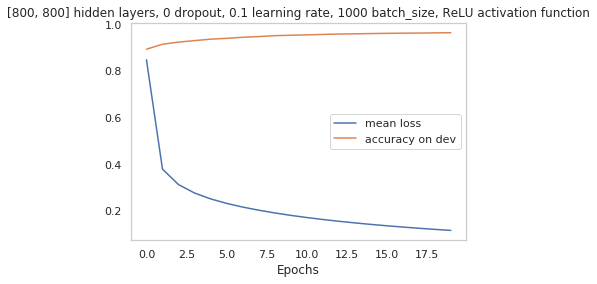

Starting epoch: 0
mean loss:  0.24748601642871956
dev accuracy:  0.9615
Starting epoch: 1
mean loss:  0.1140095925875532
dev accuracy:  0.9739
Starting epoch: 2
mean loss:  0.08252652969375299
dev accuracy:  0.9711
Starting epoch: 3
mean loss:  0.06571220793698
dev accuracy:  0.9762
Starting epoch: 4
mean loss:  0.05416940146035282
dev accuracy:  0.9769
Starting epoch: 5
mean loss:  0.04349016924641693
dev accuracy:  0.9755
Starting epoch: 6
mean loss:  0.036316228223820496
dev accuracy:  0.9773
Starting epoch: 7
mean loss:  0.03236364678044145
dev accuracy:  0.9775
Starting epoch: 8
mean loss:  0.03182495841283716
dev accuracy:  0.9766
Starting epoch: 9
mean loss:  0.02780237114403708
dev accuracy:  0.9758
Starting epoch: 10
mean loss:  0.024904003327941737
dev accuracy:  0.9765
Starting epoch: 11
mean loss:  0.02453986198448624
dev accuracy:  0.9741
Starting epoch: 12
mean loss:  0.022732957384948935
dev accuracy:  0.9751
Starting epoch: 13
mean loss:  0.017779111316943107
dev accura

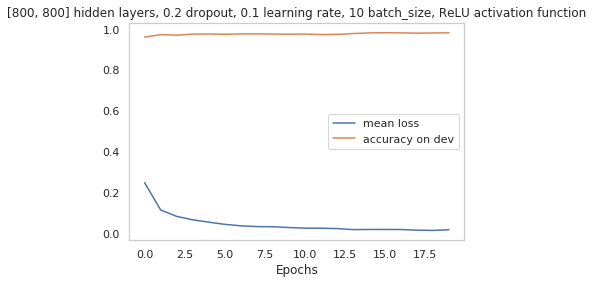

Starting epoch: 0
mean loss:  0.40010398892525906
dev accuracy:  0.9485
Starting epoch: 1
mean loss:  0.19476488422223193
dev accuracy:  0.964
Starting epoch: 2
mean loss:  0.14514183102848524
dev accuracy:  0.9691
Starting epoch: 3
mean loss:  0.11627138459947176
dev accuracy:  0.9716
Starting epoch: 4
mean loss:  0.09737262805317809
dev accuracy:  0.9742
Starting epoch: 5
mean loss:  0.0806138875806879
dev accuracy:  0.9746
Starting epoch: 6
mean loss:  0.06996151649145904
dev accuracy:  0.9756
Starting epoch: 7
mean loss:  0.06221774780933193
dev accuracy:  0.9773
Starting epoch: 8
mean loss:  0.054465639483027475
dev accuracy:  0.9787
Starting epoch: 9
mean loss:  0.0472314561337991
dev accuracy:  0.9775
Starting epoch: 10
mean loss:  0.04338610634494
dev accuracy:  0.9785
Starting epoch: 11
mean loss:  0.03928327855761879
dev accuracy:  0.9784
Starting epoch: 12
mean loss:  0.035124489866539155
dev accuracy:  0.9782
Starting epoch: 13
mean loss:  0.031312445256238185
dev accuracy:

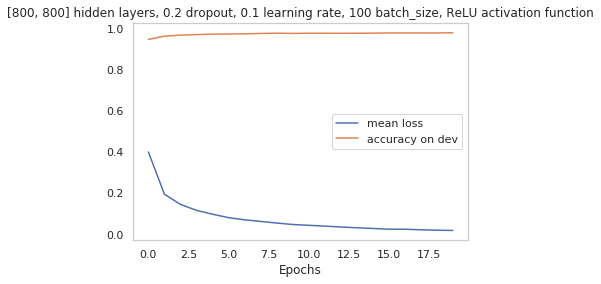

Starting epoch: 0
mean loss:  0.9391775925954183
dev accuracy:  0.8915
Starting epoch: 1
mean loss:  0.4521152324536267
dev accuracy:  0.9143
Starting epoch: 2
mean loss:  0.37267495662558314
dev accuracy:  0.9239
Starting epoch: 3
mean loss:  0.33094802966304854
dev accuracy:  0.9286
Starting epoch: 4
mean loss:  0.30376571475290787
dev accuracy:  0.9335
Starting epoch: 5
mean loss:  0.2790946422838697
dev accuracy:  0.9399
Starting epoch: 6
mean loss:  0.263202005741643
dev accuracy:  0.9423
Starting epoch: 7
mean loss:  0.24623081292591842
dev accuracy:  0.9459
Starting epoch: 8
mean loss:  0.23323790670609942
dev accuracy:  0.9491
Starting epoch: 9
mean loss:  0.22030636638987297
dev accuracy:  0.9523
Starting epoch: 10
mean loss:  0.20903589386566013
dev accuracy:  0.9545
Starting epoch: 11
mean loss:  0.20150742226955937
dev accuracy:  0.9565
Starting epoch: 12
mean loss:  0.19381346275993422
dev accuracy:  0.9578
Starting epoch: 13
mean loss:  0.1838724358993418
dev accuracy:  0

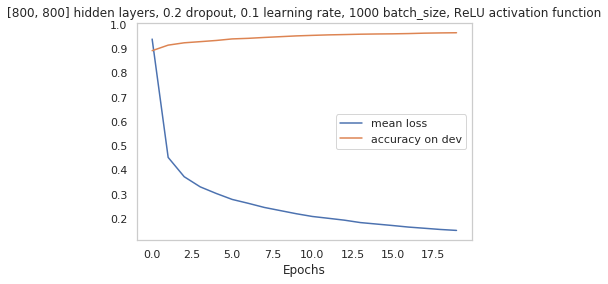

Starting epoch: 0
mean loss:  0.326675032767732
dev accuracy:  0.9566
Starting epoch: 1
mean loss:  0.18297243869046584
dev accuracy:  0.9698
Starting epoch: 2
mean loss:  0.14683523826307127
dev accuracy:  0.9728
Starting epoch: 3
mean loss:  0.12449506079093302
dev accuracy:  0.9712
Starting epoch: 4
mean loss:  0.10504797527046872
dev accuracy:  0.9765
Starting epoch: 5
mean loss:  0.09884386923337038
dev accuracy:  0.9775
Starting epoch: 6
mean loss:  0.09246776227125392
dev accuracy:  0.9761
Starting epoch: 7
mean loss:  0.08528686286200592
dev accuracy:  0.9752
Starting epoch: 8
mean loss:  0.07846919203650354
dev accuracy:  0.9777
Starting epoch: 9
mean loss:  0.07564318220483551
dev accuracy:  0.977
Starting epoch: 10
mean loss:  0.06880300235588077
dev accuracy:  0.9793
Starting epoch: 11
mean loss:  0.06560310636196306
dev accuracy:  0.9773
Starting epoch: 12
mean loss:  0.06384998001463389
dev accuracy:  0.9802
Starting epoch: 13
mean loss:  0.06095804384180771
dev accuracy:

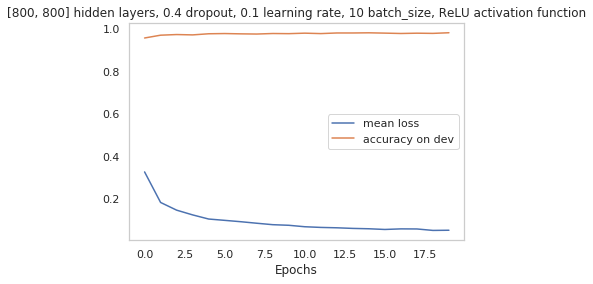

Starting epoch: 0
mean loss:  0.4753065580082035
dev accuracy:  0.9451
Starting epoch: 1
mean loss:  0.2373518492439074
dev accuracy:  0.9584
Starting epoch: 2
mean loss:  0.1798873457187664
dev accuracy:  0.9675
Starting epoch: 3
mean loss:  0.14847389926498164
dev accuracy:  0.9707
Starting epoch: 4
mean loss:  0.12939381632515176
dev accuracy:  0.9722
Starting epoch: 5
mean loss:  0.11146414094045015
dev accuracy:  0.9756
Starting epoch: 6
mean loss:  0.09890896718607037
dev accuracy:  0.9756
Starting epoch: 7
mean loss:  0.08930709930192568
dev accuracy:  0.9764
Starting epoch: 8
mean loss:  0.07948798525282842
dev accuracy:  0.9758
Starting epoch: 9
mean loss:  0.0757867362900468
dev accuracy:  0.9791
Starting epoch: 10
mean loss:  0.07086213391846763
dev accuracy:  0.9795
Starting epoch: 11
mean loss:  0.06283580559211041
dev accuracy:  0.9794
Starting epoch: 12
mean loss:  0.05772926865383507
dev accuracy:  0.9803
Starting epoch: 13
mean loss:  0.05477549603576967
dev accuracy: 

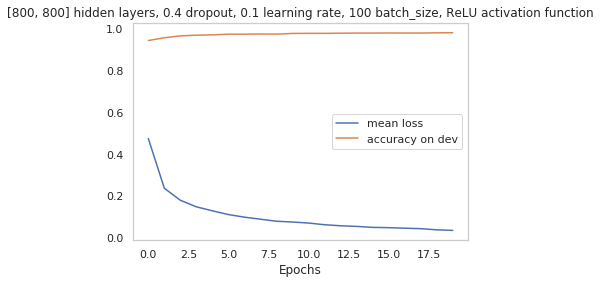

Starting epoch: 0
mean loss:  1.1010533033632766
dev accuracy:  0.8905
Starting epoch: 1
mean loss:  0.5483908051369237
dev accuracy:  0.91
Starting epoch: 2
mean loss:  0.4487829447961321
dev accuracy:  0.9203
Starting epoch: 3
mean loss:  0.3946811118546654
dev accuracy:  0.9252
Starting epoch: 4
mean loss:  0.36165278390342115
dev accuracy:  0.9303
Starting epoch: 5
mean loss:  0.33368951491281096
dev accuracy:  0.9344
Starting epoch: 6
mean loss:  0.3144495843672285
dev accuracy:  0.9378
Starting epoch: 7
mean loss:  0.2952351453257542
dev accuracy:  0.9402
Starting epoch: 8
mean loss:  0.2797139874275993
dev accuracy:  0.9447
Starting epoch: 9
mean loss:  0.2662236699286629
dev accuracy:  0.9471
Starting epoch: 10
mean loss:  0.25554676353931427
dev accuracy:  0.9498
Starting epoch: 11
mean loss:  0.24114531804533565
dev accuracy:  0.9525
Starting epoch: 12
mean loss:  0.23432564267925188
dev accuracy:  0.9542
Starting epoch: 13
mean loss:  0.22489372041879915
dev accuracy:  0.954

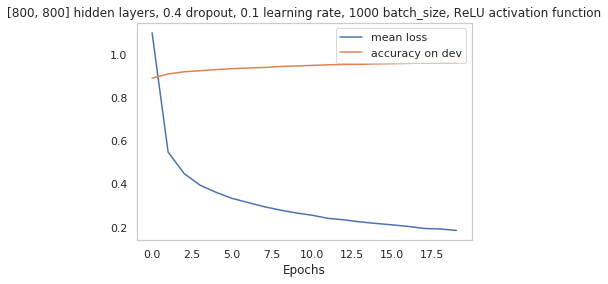

Starting epoch: 0
mean loss:  0.5648480907585232
dev accuracy:  0.9461
Starting epoch: 1
mean loss:  0.36645451528886874
dev accuracy:  0.9567
Starting epoch: 2
mean loss:  0.3225186148098575
dev accuracy:  0.961
Starting epoch: 3
mean loss:  0.30124274181269145
dev accuracy:  0.9592
Starting epoch: 4
mean loss:  0.27836507654842096
dev accuracy:  0.9607
Starting epoch: 5
mean loss:  0.27255693920670115
dev accuracy:  0.9605
Starting epoch: 6
mean loss:  0.25982520492354455
dev accuracy:  0.9602
Starting epoch: 7
mean loss:  0.247604531871522
dev accuracy:  0.965
Starting epoch: 8
mean loss:  0.23858429412243848
dev accuracy:  0.9666
Starting epoch: 9
mean loss:  0.23602957162812385
dev accuracy:  0.9646
Starting epoch: 10
mean loss:  0.2286793147782046
dev accuracy:  0.9663
Starting epoch: 11
mean loss:  0.2161386882528349
dev accuracy:  0.9671
Starting epoch: 12
mean loss:  0.21639466793632864
dev accuracy:  0.9668
Starting epoch: 13
mean loss:  0.2090917589395099
dev accuracy:  0.96

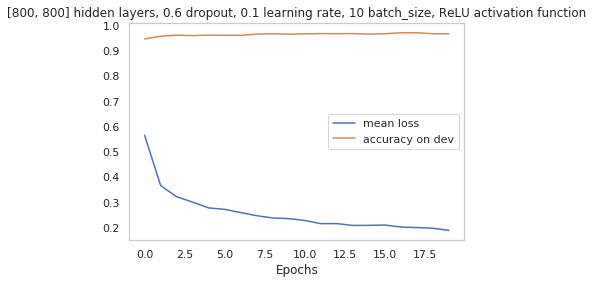

Starting epoch: 0
mean loss:  0.605377334439588
dev accuracy:  0.9356
Starting epoch: 1
mean loss:  0.31407595928498133
dev accuracy:  0.9546
Starting epoch: 2
mean loss:  0.2467318008135179
dev accuracy:  0.9622
Starting epoch: 3
mean loss:  0.21091559173134034
dev accuracy:  0.9669
Starting epoch: 4
mean loss:  0.18470338137147432
dev accuracy:  0.9694
Starting epoch: 5
mean loss:  0.17024220738879697
dev accuracy:  0.9708
Starting epoch: 6
mean loss:  0.15076694528975648
dev accuracy:  0.9721
Starting epoch: 7
mean loss:  0.1409317307888034
dev accuracy:  0.9734
Starting epoch: 8
mean loss:  0.12909444132652467
dev accuracy:  0.9745
Starting epoch: 9
mean loss:  0.11922857951291069
dev accuracy:  0.9762
Starting epoch: 10
mean loss:  0.11448629986041202
dev accuracy:  0.9763
Starting epoch: 11
mean loss:  0.11043501836796125
dev accuracy:  0.9773
Starting epoch: 12
mean loss:  0.10407896257728755
dev accuracy:  0.9778
Starting epoch: 13
mean loss:  0.0949197008930697
dev accuracy:  

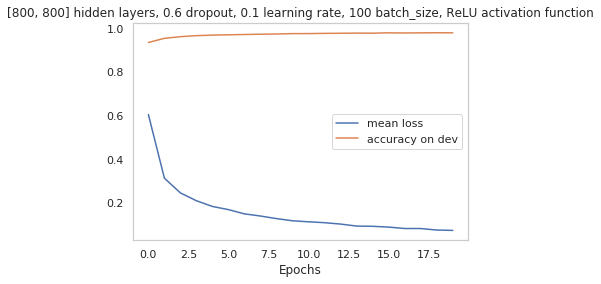

Starting epoch: 0
mean loss:  1.406832754611969
dev accuracy:  0.8793
Starting epoch: 1
mean loss:  0.7407065513087254
dev accuracy:  0.901
Starting epoch: 2
mean loss:  0.5907604928110161
dev accuracy:  0.9122
Starting epoch: 3
mean loss:  0.5148490527096916
dev accuracy:  0.9199
Starting epoch: 4
mean loss:  0.4683198636653377
dev accuracy:  0.9239
Starting epoch: 5
mean loss:  0.4324299511956234
dev accuracy:  0.9276
Starting epoch: 6
mean loss:  0.4007403733683567
dev accuracy:  0.9316
Starting epoch: 7
mean loss:  0.3766181001476213
dev accuracy:  0.9354
Starting epoch: 8
mean loss:  0.357814209133971
dev accuracy:  0.9396
Starting epoch: 9
mean loss:  0.34334827462832135
dev accuracy:  0.9424
Starting epoch: 10
mean loss:  0.3260076922528884
dev accuracy:  0.944
Starting epoch: 11
mean loss:  0.31344300742242853
dev accuracy:  0.9452
Starting epoch: 12
mean loss:  0.3024781360930088
dev accuracy:  0.9472
Starting epoch: 13
mean loss:  0.2939440973249136
dev accuracy:  0.9493
Star

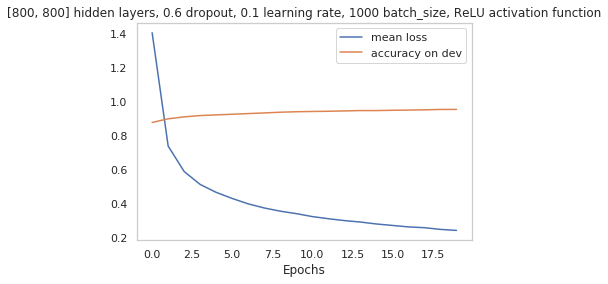

Starting epoch: 0
mean loss:  0.33976564183793967
dev accuracy:  0.9471
Starting epoch: 1
mean loss:  0.1647377931231689
dev accuracy:  0.9631
Starting epoch: 2
mean loss:  0.11664837929791697
dev accuracy:  0.9668
Starting epoch: 3
mean loss:  0.08899061119907996
dev accuracy:  0.9704
Starting epoch: 4
mean loss:  0.07028062262503816
dev accuracy:  0.9737
Starting epoch: 5
mean loss:  0.05642744213391272
dev accuracy:  0.9757
Starting epoch: 6
mean loss:  0.04573805112698648
dev accuracy:  0.9773
Starting epoch: 7
mean loss:  0.03729798448560859
dev accuracy:  0.977
Starting epoch: 8
mean loss:  0.030577963419997467
dev accuracy:  0.9779
Starting epoch: 9
mean loss:  0.025128163156234052
dev accuracy:  0.978
Starting epoch: 10
mean loss:  0.020715770049734416
dev accuracy:  0.9786
Starting epoch: 11
mean loss:  0.017147696024419852
dev accuracy:  0.9789
Starting epoch: 12
mean loss:  0.014263448495830862
dev accuracy:  0.9791
Starting epoch: 13
mean loss:  0.011987108671634564
dev acc

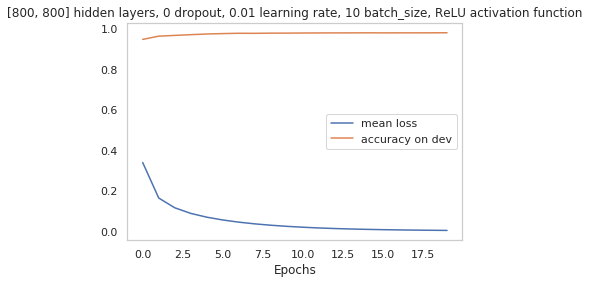

Starting epoch: 0
mean loss:  0.8392222370216232
dev accuracy:  0.902
Starting epoch: 1
mean loss:  0.3731361531509373
dev accuracy:  0.9187
Starting epoch: 2
mean loss:  0.30547330308400705
dev accuracy:  0.9277
Starting epoch: 3
mean loss:  0.27048359052863663
dev accuracy:  0.9331
Starting epoch: 4
mean loss:  0.24657869466883456
dev accuracy:  0.9367
Starting epoch: 5
mean loss:  0.22822336987880415
dev accuracy:  0.94
Starting epoch: 6
mean loss:  0.2131756182588979
dev accuracy:  0.9427
Starting epoch: 7
mean loss:  0.20038972673063982
dev accuracy:  0.9461
Starting epoch: 8
mean loss:  0.18925134880754524
dev accuracy:  0.9493
Starting epoch: 9
mean loss:  0.17936211767905724
dev accuracy:  0.9509
Starting epoch: 10
mean loss:  0.1704750456094385
dev accuracy:  0.953
Starting epoch: 11
mean loss:  0.1624045190429259
dev accuracy:  0.9547
Starting epoch: 12
mean loss:  0.15502074711812946
dev accuracy:  0.9559
Starting epoch: 13
mean loss:  0.1482267032959266
dev accuracy:  0.957

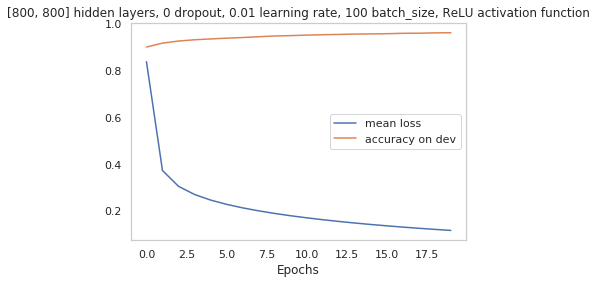

Starting epoch: 0
mean loss:  1.9176842932607614
dev accuracy:  0.7171
Starting epoch: 1
mean loss:  1.3237832060047225
dev accuracy:  0.8171
Starting epoch: 2
mean loss:  0.9774747701252208
dev accuracy:  0.8475
Starting epoch: 3
mean loss:  0.781164335269554
dev accuracy:  0.8618
Starting epoch: 4
mean loss:  0.6638205752653235
dev accuracy:  0.8746
Starting epoch: 5
mean loss:  0.5875135753668991
dev accuracy:  0.8815
Starting epoch: 6
mean loss:  0.53415627339307
dev accuracy:  0.8876
Starting epoch: 7
mean loss:  0.4946833954137914
dev accuracy:  0.892
Starting epoch: 8
mean loss:  0.4642094712631375
dev accuracy:  0.8955
Starting epoch: 9
mean loss:  0.4398942525480308
dev accuracy:  0.8994
Starting epoch: 10
mean loss:  0.4199867943922679
dev accuracy:  0.9014
Starting epoch: 11
mean loss:  0.40332916203667135
dev accuracy:  0.904
Starting epoch: 12
mean loss:  0.38914406650206623
dev accuracy:  0.9059
Starting epoch: 13
mean loss:  0.3768855163864061
dev accuracy:  0.9078
Start

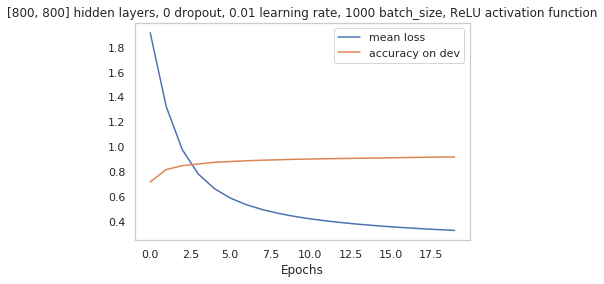

Starting epoch: 0
mean loss:  0.3953206218099171
dev accuracy:  0.9494
Starting epoch: 1
mean loss:  0.19684376420161373
dev accuracy:  0.9625
Starting epoch: 2
mean loss:  0.1456520020600434
dev accuracy:  0.9694
Starting epoch: 3
mean loss:  0.11686997085459508
dev accuracy:  0.9734
Starting epoch: 4
mean loss:  0.0981622980959703
dev accuracy:  0.9754
Starting epoch: 5
mean loss:  0.08138720056980335
dev accuracy:  0.9768
Starting epoch: 6
mean loss:  0.0715452128218659
dev accuracy:  0.9774
Starting epoch: 7
mean loss:  0.0628477066865582
dev accuracy:  0.9782
Starting epoch: 8
mean loss:  0.05515392193055885
dev accuracy:  0.9785
Starting epoch: 9
mean loss:  0.04836028911919108
dev accuracy:  0.9798
Starting epoch: 10
mean loss:  0.043707789226883446
dev accuracy:  0.9803
Starting epoch: 11
mean loss:  0.03846088268445563
dev accuracy:  0.9796
Starting epoch: 12
mean loss:  0.035370616070766955
dev accuracy:  0.9791
Starting epoch: 13
mean loss:  0.03133693032439724
dev accuracy:

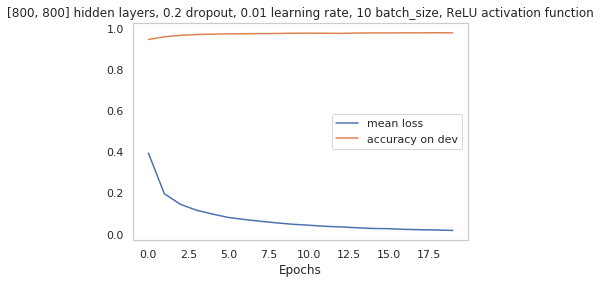

Starting epoch: 0
mean loss:  0.9459422215254245
dev accuracy:  0.895
Starting epoch: 1
mean loss:  0.45611990598623386
dev accuracy:  0.9153
Starting epoch: 2
mean loss:  0.37727525639914705
dev accuracy:  0.9235
Starting epoch: 3
mean loss:  0.33382589017559666
dev accuracy:  0.931
Starting epoch: 4
mean loss:  0.3061676222883061
dev accuracy:  0.9353
Starting epoch: 5
mean loss:  0.28225886366681424
dev accuracy:  0.94
Starting epoch: 6
mean loss:  0.26454981016422696
dev accuracy:  0.9439
Starting epoch: 7
mean loss:  0.248692465340068
dev accuracy:  0.9467
Starting epoch: 8
mean loss:  0.23392664885033151
dev accuracy:  0.9495
Starting epoch: 9
mean loss:  0.22187408163935363
dev accuracy:  0.9523
Starting epoch: 10
mean loss:  0.2119273696384744
dev accuracy:  0.9539
Starting epoch: 11
mean loss:  0.20162916527745015
dev accuracy:  0.9558
Starting epoch: 12
mean loss:  0.19418249182596417
dev accuracy:  0.957
Starting epoch: 13
mean loss:  0.18621421441762986
dev accuracy:  0.958

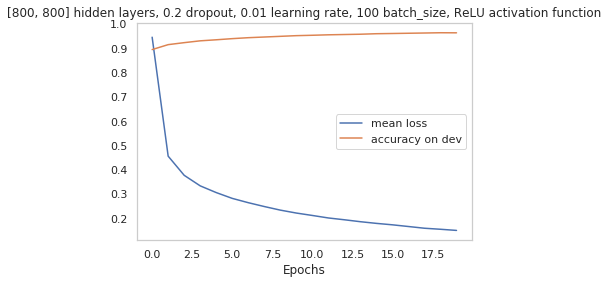

Starting epoch: 0
mean loss:  1.9925065414578307
dev accuracy:  0.7014
Starting epoch: 1
mean loss:  1.4413576570211672
dev accuracy:  0.8071
Starting epoch: 2
mean loss:  1.103890105789783
dev accuracy:  0.8426
Starting epoch: 3
mean loss:  0.9035929289518618
dev accuracy:  0.8599
Starting epoch: 4
mean loss:  0.7753433363110411
dev accuracy:  0.8702
Starting epoch: 5
mean loss:  0.6910610479467055
dev accuracy:  0.8798
Starting epoch: 6
mean loss:  0.6319435238838196
dev accuracy:  0.8859
Starting epoch: 7
mean loss:  0.588544067214517
dev accuracy:  0.8893
Starting epoch: 8
mean loss:  0.5541740001416674
dev accuracy:  0.8928
Starting epoch: 9
mean loss:  0.5276601723596162
dev accuracy:  0.8965
Starting epoch: 10
mean loss:  0.5062254112140805
dev accuracy:  0.8986
Starting epoch: 11
mean loss:  0.48539692806262597
dev accuracy:  0.9006
Starting epoch: 12
mean loss:  0.47106048464775085
dev accuracy:  0.9024
Starting epoch: 13
mean loss:  0.45636959052553366
dev accuracy:  0.9049
S

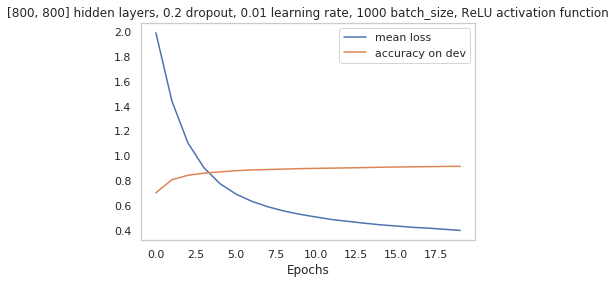

Starting epoch: 0
mean loss:  0.46539641911258156
dev accuracy:  0.9462
Starting epoch: 1
mean loss:  0.23432028182287612
dev accuracy:  0.9625
Starting epoch: 2
mean loss:  0.1787643858365548
dev accuracy:  0.9666
Starting epoch: 3
mean loss:  0.14869070765072753
dev accuracy:  0.9689
Starting epoch: 4
mean loss:  0.12832472183638924
dev accuracy:  0.9728
Starting epoch: 5
mean loss:  0.11411730894898793
dev accuracy:  0.9748
Starting epoch: 6
mean loss:  0.10058744578146343
dev accuracy:  0.9757
Starting epoch: 7
mean loss:  0.09112197126581875
dev accuracy:  0.9768
Starting epoch: 8
mean loss:  0.08194123785850901
dev accuracy:  0.9779
Starting epoch: 9
mean loss:  0.07383499659209014
dev accuracy:  0.9777
Starting epoch: 10
mean loss:  0.06891077102872639
dev accuracy:  0.9785
Starting epoch: 11
mean loss:  0.06278548931886149
dev accuracy:  0.9789
Starting epoch: 12
mean loss:  0.0593416891880446
dev accuracy:  0.9786
Starting epoch: 13
mean loss:  0.05385108717676645
dev accuracy

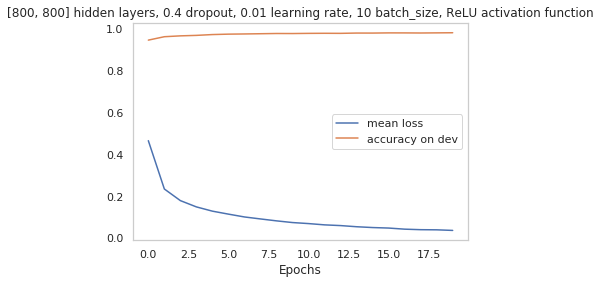

Starting epoch: 0
mean loss:  1.0988570567138656
dev accuracy:  0.888
Starting epoch: 1
mean loss:  0.5533510793944795
dev accuracy:  0.9095
Starting epoch: 2
mean loss:  0.4552817552567956
dev accuracy:  0.919
Starting epoch: 3
mean loss:  0.40376302222172894
dev accuracy:  0.9266
Starting epoch: 4
mean loss:  0.3638660281956077
dev accuracy:  0.9317
Starting epoch: 5
mean loss:  0.3365310831162744
dev accuracy:  0.9346
Starting epoch: 6
mean loss:  0.31506176474327574
dev accuracy:  0.9391
Starting epoch: 7
mean loss:  0.29971643935836956
dev accuracy:  0.9421
Starting epoch: 8
mean loss:  0.2817243078124975
dev accuracy:  0.9444
Starting epoch: 9
mean loss:  0.2680663575907191
dev accuracy:  0.9479
Starting epoch: 10
mean loss:  0.2548030746613672
dev accuracy:  0.9507
Starting epoch: 11
mean loss:  0.24698982421985405
dev accuracy:  0.9525
Starting epoch: 12
mean loss:  0.23534487598313542
dev accuracy:  0.9547
Starting epoch: 13
mean loss:  0.22829230669551268
dev accuracy:  0.955

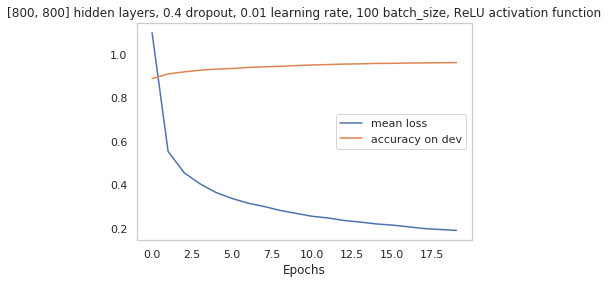

Starting epoch: 0
mean loss:  2.145368164660884
dev accuracy:  0.6627
Starting epoch: 1
mean loss:  1.6698086308498008
dev accuracy:  0.7729
Starting epoch: 2
mean loss:  1.3524074881684547
dev accuracy:  0.8141
Starting epoch: 3
mean loss:  1.1383476140452367
dev accuracy:  0.8381
Starting epoch: 4
mean loss:  0.9890223741531372
dev accuracy:  0.8536
Starting epoch: 5
mean loss:  0.887370110726824
dev accuracy:  0.8613
Starting epoch: 6
mean loss:  0.8081639163634357
dev accuracy:  0.8683
Starting epoch: 7
mean loss:  0.7528329655235889
dev accuracy:  0.8756
Starting epoch: 8
mean loss:  0.7089026196330201
dev accuracy:  0.8799
Starting epoch: 9
mean loss:  0.6713864861750135
dev accuracy:  0.8853
Starting epoch: 10
mean loss:  0.6387526673429152
dev accuracy:  0.8908
Starting epoch: 11
mean loss:  0.6133479160421035
dev accuracy:  0.8935
Starting epoch: 12
mean loss:  0.5930249410517076
dev accuracy:  0.8967
Starting epoch: 13
mean loss:  0.5721033145399654
dev accuracy:  0.8995
Star

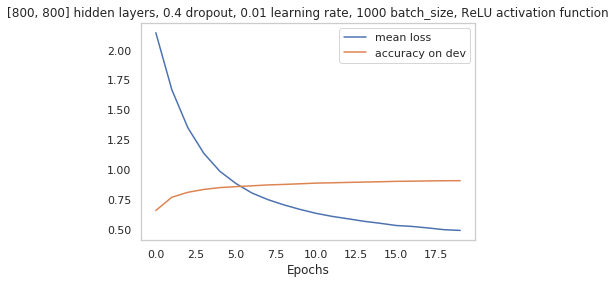

Starting epoch: 0
mean loss:  0.6004419715323077
dev accuracy:  0.9348
Starting epoch: 1
mean loss:  0.3159041076299761
dev accuracy:  0.9536
Starting epoch: 2
mean loss:  0.24726423333454214
dev accuracy:  0.9623
Starting epoch: 3
mean loss:  0.2111374154551494
dev accuracy:  0.9663
Starting epoch: 4
mean loss:  0.18511693465456938
dev accuracy:  0.9696
Starting epoch: 5
mean loss:  0.16669201502018766
dev accuracy:  0.9705
Starting epoch: 6
mean loss:  0.1487577986918317
dev accuracy:  0.9728
Starting epoch: 7
mean loss:  0.14075600796240434
dev accuracy:  0.9739
Starting epoch: 8
mean loss:  0.12884678942629546
dev accuracy:  0.9748
Starting epoch: 9
mean loss:  0.12266590702135624
dev accuracy:  0.9761
Starting epoch: 10
mean loss:  0.11282843417261819
dev accuracy:  0.9767
Starting epoch: 11
mean loss:  0.10966967769641749
dev accuracy:  0.9779
Starting epoch: 12
mean loss:  0.10354453684587667
dev accuracy:  0.9776
Starting epoch: 13
mean loss:  0.09976176932977512
dev accuracy: 

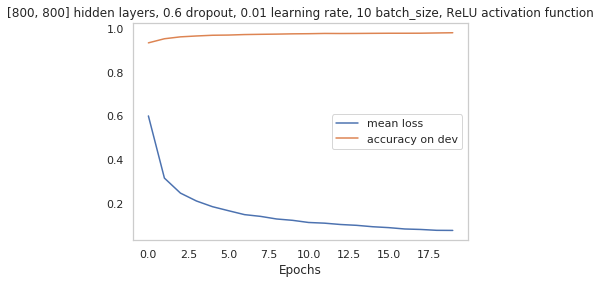

Starting epoch: 0
mean loss:  1.420347593025771
dev accuracy:  0.8718
Starting epoch: 1
mean loss:  0.7560509216047808
dev accuracy:  0.8974
Starting epoch: 2
mean loss:  0.6101685508996427
dev accuracy:  0.9092
Starting epoch: 3
mean loss:  0.5290022249707205
dev accuracy:  0.917
Starting epoch: 4
mean loss:  0.4713386178849462
dev accuracy:  0.9227
Starting epoch: 5
mean loss:  0.43968350724307836
dev accuracy:  0.9253
Starting epoch: 6
mean loss:  0.412316901598148
dev accuracy:  0.9308
Starting epoch: 7
mean loss:  0.38443963907792894
dev accuracy:  0.9342
Starting epoch: 8
mean loss:  0.3651636395001126
dev accuracy:  0.9377
Starting epoch: 9
mean loss:  0.34801808308936405
dev accuracy:  0.94
Starting epoch: 10
mean loss:  0.3377828081984244
dev accuracy:  0.9423
Starting epoch: 11
mean loss:  0.3208627930569078
dev accuracy:  0.9443
Starting epoch: 12
mean loss:  0.3123601574205353
dev accuracy:  0.9468
Starting epoch: 13
mean loss:  0.29744164354192043
dev accuracy:  0.9482
Sta

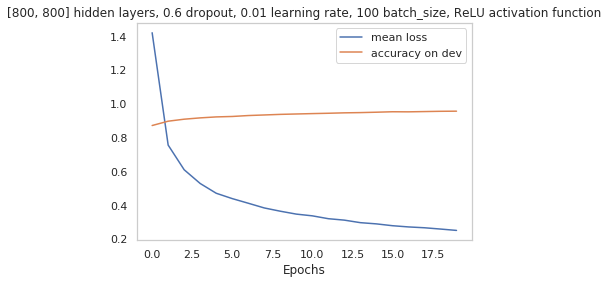

Starting epoch: 0
mean loss:  2.3975700023127535
dev accuracy:  0.6498
Starting epoch: 1
mean loss:  1.9269216317756503
dev accuracy:  0.7676
Starting epoch: 2
mean loss:  1.6254940266702689
dev accuracy:  0.8084
Starting epoch: 3
mean loss:  1.4150266413595163
dev accuracy:  0.8323
Starting epoch: 4
mean loss:  1.2645527030907424
dev accuracy:  0.8475
Starting epoch: 5
mean loss:  1.1404102222592223
dev accuracy:  0.8587
Starting epoch: 6
mean loss:  1.050548050917831
dev accuracy:  0.8659
Starting epoch: 7
mean loss:  0.9827285034983766
dev accuracy:  0.8716
Starting epoch: 8
mean loss:  0.9222716922853508
dev accuracy:  0.8766
Starting epoch: 9
mean loss:  0.8734813718234792
dev accuracy:  0.881
Starting epoch: 10
mean loss:  0.837904317706239
dev accuracy:  0.8839
Starting epoch: 11
mean loss:  0.8008505316341624
dev accuracy:  0.8867
Starting epoch: 12
mean loss:  0.7733418754502839
dev accuracy:  0.8892
Starting epoch: 13
mean loss:  0.7478322690608454
dev accuracy:  0.8917
Start

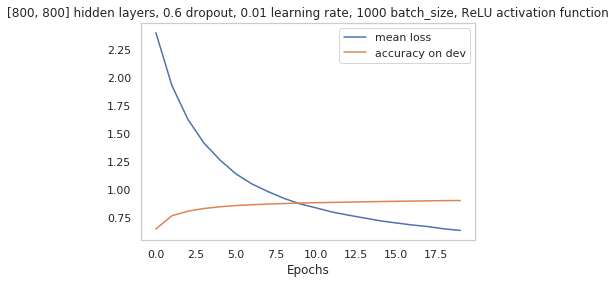

Starting epoch: 0
mean loss:  0.8042952751405976
dev accuracy:  0.9011
Starting epoch: 1
mean loss:  0.3746818605522869
dev accuracy:  0.9163
Starting epoch: 2
mean loss:  0.3104940923521177
dev accuracy:  0.9254
Starting epoch: 3
mean loss:  0.27600676172193744
dev accuracy:  0.9311
Starting epoch: 4
mean loss:  0.25190300865443727
dev accuracy:  0.9352
Starting epoch: 5
mean loss:  0.2330817222466532
dev accuracy:  0.9391
Starting epoch: 6
mean loss:  0.21750071210361357
dev accuracy:  0.9435
Starting epoch: 7
mean loss:  0.204120852303548
dev accuracy:  0.9472
Starting epoch: 8
mean loss:  0.19237296742374452
dev accuracy:  0.9507
Starting epoch: 9
mean loss:  0.18194244407033378
dev accuracy:  0.9532
Starting epoch: 10
mean loss:  0.17260325943699736
dev accuracy:  0.9554
Starting epoch: 11
mean loss:  0.16418909065370832
dev accuracy:  0.9573
Starting epoch: 12
mean loss:  0.1565203508040932
dev accuracy:  0.9591
Starting epoch: 13
mean loss:  0.14951733963529493
dev accuracy:  0.

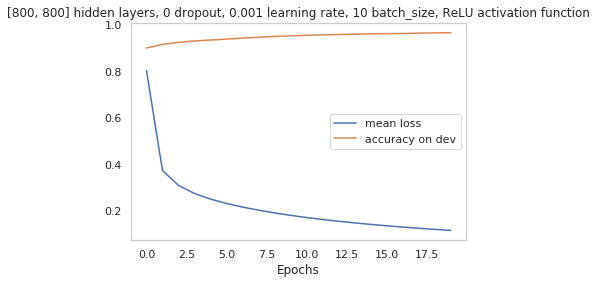

Starting epoch: 0
mean loss:  1.9497936754645464
dev accuracy:  0.7081
Starting epoch: 1
mean loss:  1.3475707859812145
dev accuracy:  0.8015
Starting epoch: 2
mean loss:  0.998452791077886
dev accuracy:  0.8424
Starting epoch: 3
mean loss:  0.8016450211197554
dev accuracy:  0.8614
Starting epoch: 4
mean loss:  0.6831941485048054
dev accuracy:  0.8716
Starting epoch: 5
mean loss:  0.6055448980269555
dev accuracy:  0.8793
Starting epoch: 6
mean loss:  0.5509180684765418
dev accuracy:  0.8863
Starting epoch: 7
mean loss:  0.5103880396027289
dev accuracy:  0.8907
Starting epoch: 8
mean loss:  0.4790597668664898
dev accuracy:  0.8953
Starting epoch: 9
mean loss:  0.4540370441006567
dev accuracy:  0.9001
Starting epoch: 10
mean loss:  0.4335291777958651
dev accuracy:  0.9035
Starting epoch: 11
mean loss:  0.41635507490939483
dev accuracy:  0.9056
Starting epoch: 12
mean loss:  0.4017204389184297
dev accuracy:  0.9073
Starting epoch: 13
mean loss:  0.38905391855511123
dev accuracy:  0.9092
S

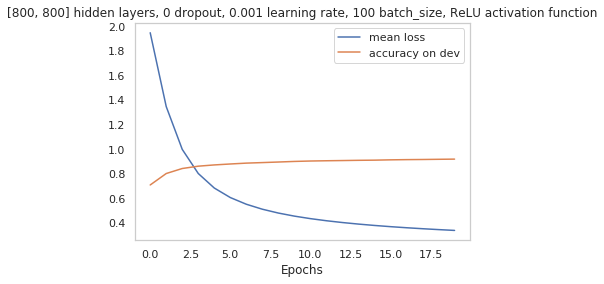

Starting epoch: 0
mean loss:  2.2589779835121306
dev accuracy:  0.1719
Starting epoch: 1
mean loss:  2.124234508065616
dev accuracy:  0.27
Starting epoch: 2
mean loss:  2.025468433604521
dev accuracy:  0.383
Starting epoch: 3
mean loss:  1.9409885266247917
dev accuracy:  0.4778
Starting epoch: 4
mean loss:  1.8638631152171714
dev accuracy:  0.5489
Starting epoch: 5
mean loss:  1.7915653995439118
dev accuracy:  0.5958
Starting epoch: 6
mean loss:  1.7230996267468321
dev accuracy:  0.6377
Starting epoch: 7
mean loss:  1.6580524234210743
dev accuracy:  0.6674
Starting epoch: 8
mean loss:  1.596171306628807
dev accuracy:  0.6882
Starting epoch: 9
mean loss:  1.5373214740379184
dev accuracy:  0.7074
Starting epoch: 10
mean loss:  1.481394461556977
dev accuracy:  0.7223
Starting epoch: 11
mean loss:  1.4283051397286208
dev accuracy:  0.7365
Starting epoch: 12
mean loss:  1.3779711209091485
dev accuracy:  0.748
Starting epoch: 13
mean loss:  1.3303220108443616
dev accuracy:  0.7594
Starting e

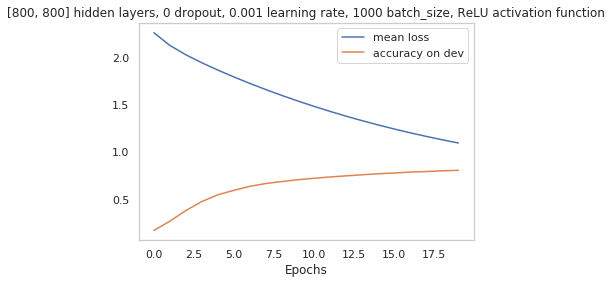

Starting epoch: 0
mean loss:  0.921174936868076
dev accuracy:  0.8993
Starting epoch: 1
mean loss:  0.4518124460205629
dev accuracy:  0.9162
Starting epoch: 2
mean loss:  0.3758077103319829
dev accuracy:  0.9243
Starting epoch: 3
mean loss:  0.3332553571664613
dev accuracy:  0.9301
Starting epoch: 4
mean loss:  0.30526108562101223
dev accuracy:  0.9358
Starting epoch: 5
mean loss:  0.28354786536830445
dev accuracy:  0.9413
Starting epoch: 6
mean loss:  0.2640676314124442
dev accuracy:  0.9461
Starting epoch: 7
mean loss:  0.2490709871412183
dev accuracy:  0.9489
Starting epoch: 8
mean loss:  0.23625436181111653
dev accuracy:  0.9524
Starting epoch: 9
mean loss:  0.22397342418660154
dev accuracy:  0.9534
Starting epoch: 10
mean loss:  0.21367517572698583
dev accuracy:  0.9554
Starting epoch: 11
mean loss:  0.2047059600365044
dev accuracy:  0.9574
Starting epoch: 12
mean loss:  0.19590483476429055
dev accuracy:  0.9588
Starting epoch: 13
mean loss:  0.18719379953741902
dev accuracy:  0.9

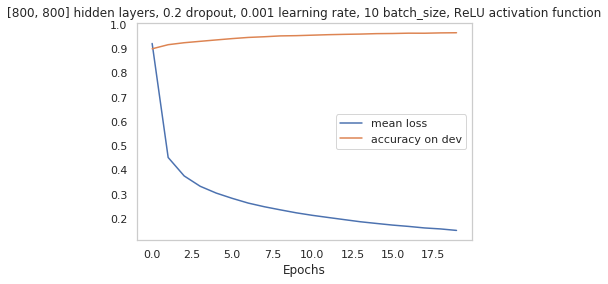

Starting epoch: 0
mean loss:  2.0176448603114205
dev accuracy:  0.6916
Starting epoch: 1
mean loss:  1.4630995391609665
dev accuracy:  0.8073
Starting epoch: 2
mean loss:  1.1254230617525096
dev accuracy:  0.8415
Starting epoch: 3
mean loss:  0.9206965886904094
dev accuracy:  0.8572
Starting epoch: 4
mean loss:  0.7936914165814718
dev accuracy:  0.8689
Starting epoch: 5
mean loss:  0.7091615914465662
dev accuracy:  0.8769
Starting epoch: 6
mean loss:  0.6494281521576369
dev accuracy:  0.8834
Starting epoch: 7
mean loss:  0.6060583937072944
dev accuracy:  0.8881
Starting epoch: 8
mean loss:  0.5686195767568257
dev accuracy:  0.892
Starting epoch: 9
mean loss:  0.5440200352502202
dev accuracy:  0.8946
Starting epoch: 10
mean loss:  0.5194026740368255
dev accuracy:  0.8973
Starting epoch: 11
mean loss:  0.5005080003938275
dev accuracy:  0.9003
Starting epoch: 12
mean loss:  0.4814267026747534
dev accuracy:  0.903
Starting epoch: 13
mean loss:  0.46794752238277426
dev accuracy:  0.9055
Sta

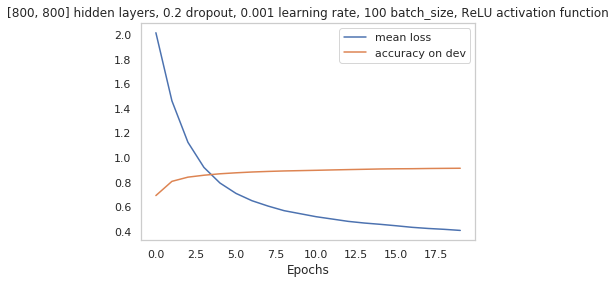

Starting epoch: 0
mean loss:  2.351318639867446
dev accuracy:  0.1457
Starting epoch: 1
mean loss:  2.2312170898213104
dev accuracy:  0.2578
Starting epoch: 2
mean loss:  2.1430371275135114
dev accuracy:  0.3644
Starting epoch: 3
mean loss:  2.068811164182775
dev accuracy:  0.4482
Starting epoch: 4
mean loss:  1.998138752638125
dev accuracy:  0.5137
Starting epoch: 5
mean loss:  1.9311275458803363
dev accuracy:  0.5667
Starting epoch: 6
mean loss:  1.8694132917067583
dev accuracy:  0.6043
Starting epoch: 7
mean loss:  1.8075709833818323
dev accuracy:  0.6348
Starting epoch: 8
mean loss:  1.750167407241522
dev accuracy:  0.6626
Starting epoch: 9
mean loss:  1.6932208467932308
dev accuracy:  0.6854
Starting epoch: 10
mean loss:  1.636845871513965
dev accuracy:  0.7046
Starting epoch: 11
mean loss:  1.589322335579816
dev accuracy:  0.7199
Starting epoch: 12
mean loss:  1.5411655552246992
dev accuracy:  0.7337
Starting epoch: 13
mean loss:  1.4925768562391692
dev accuracy:  0.7467
Starting

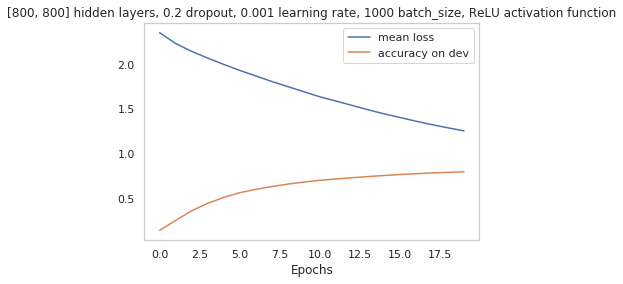

Starting epoch: 0
mean loss:  1.1248376824854136
dev accuracy:  0.8876
Starting epoch: 1
mean loss:  0.5679506690749239
dev accuracy:  0.9101
Starting epoch: 2
mean loss:  0.4585585362540319
dev accuracy:  0.9189
Starting epoch: 3
mean loss:  0.40708424235695784
dev accuracy:  0.9274
Starting epoch: 4
mean loss:  0.37265861332915623
dev accuracy:  0.9337
Starting epoch: 5
mean loss:  0.3403164367887052
dev accuracy:  0.937
Starting epoch: 6
mean loss:  0.32039022632464664
dev accuracy:  0.9389
Starting epoch: 7
mean loss:  0.29997573978193304
dev accuracy:  0.9434
Starting epoch: 8
mean loss:  0.2880514220540743
dev accuracy:  0.9456
Starting epoch: 9
mean loss:  0.27183055207383766
dev accuracy:  0.9474
Starting epoch: 10
mean loss:  0.26275422044779595
dev accuracy:  0.9491
Starting epoch: 11
mean loss:  0.2505048156442734
dev accuracy:  0.9511
Starting epoch: 12
mean loss:  0.23949720757035547
dev accuracy:  0.9531
Starting epoch: 13
mean loss:  0.2335730417987447
dev accuracy:  0.9

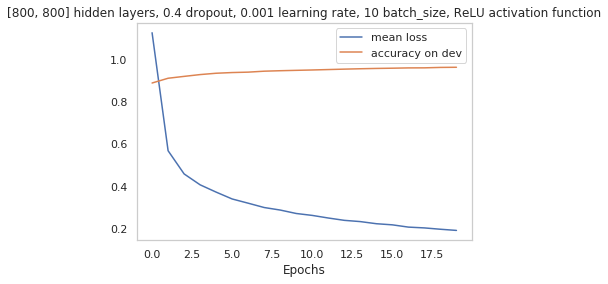

Starting epoch: 0
mean loss:  2.132687656227462
dev accuracy:  0.6994
Starting epoch: 1
mean loss:  1.6250158024881176
dev accuracy:  0.7936
Starting epoch: 2
mean loss:  1.3047398709489437
dev accuracy:  0.8266
Starting epoch: 3
mean loss:  1.0977097053727705
dev accuracy:  0.846
Starting epoch: 4
mean loss:  0.9583369800430572
dev accuracy:  0.8597
Starting epoch: 5
mean loss:  0.8609173770198327
dev accuracy:  0.8683
Starting epoch: 6
mean loss:  0.7893324298059156
dev accuracy:  0.8732
Starting epoch: 7
mean loss:  0.7429236936236094
dev accuracy:  0.8794
Starting epoch: 8
mean loss:  0.6986562065378634
dev accuracy:  0.884
Starting epoch: 9
mean loss:  0.6634925987549171
dev accuracy:  0.8883
Starting epoch: 10
mean loss:  0.6364554234607491
dev accuracy:  0.8925
Starting epoch: 11
mean loss:  0.6110917789017607
dev accuracy:  0.8952
Starting epoch: 12
mean loss:  0.5926227259064862
dev accuracy:  0.8978
Starting epoch: 13
mean loss:  0.5722785194120007
dev accuracy:  0.8999
Start

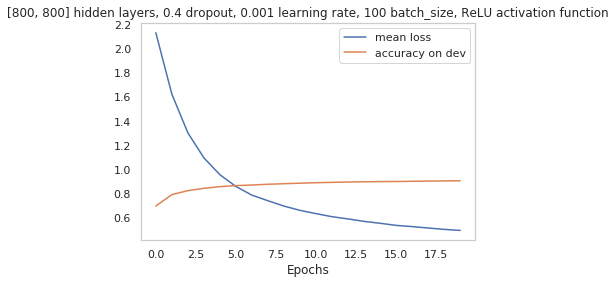

Starting epoch: 0
mean loss:  2.5179852457607494
dev accuracy:  0.1009
Starting epoch: 1
mean loss:  2.388229444915173
dev accuracy:  0.1801
Starting epoch: 2
mean loss:  2.3014627204221836
dev accuracy:  0.2798
Starting epoch: 3
mean loss:  2.2147980811549166
dev accuracy:  0.3727
Starting epoch: 4
mean loss:  2.1483823318107453
dev accuracy:  0.443
Starting epoch: 5
mean loss:  2.08558354658239
dev accuracy:  0.4935
Starting epoch: 6
mean loss:  2.0313324554293763
dev accuracy:  0.5335
Starting epoch: 7
mean loss:  1.9759333367441214
dev accuracy:  0.5696
Starting epoch: 8
mean loss:  1.9247608138065713
dev accuracy:  0.6053
Starting epoch: 9
mean loss:  1.8756902638603659
dev accuracy:  0.6375
Starting epoch: 10
mean loss:  1.8316879459455901
dev accuracy:  0.6642
Starting epoch: 11
mean loss:  1.7840083510267968
dev accuracy:  0.6857
Starting epoch: 12
mean loss:  1.7420926421296363
dev accuracy:  0.7057
Starting epoch: 13
mean loss:  1.6988136861838548
dev accuracy:  0.7214
Starti

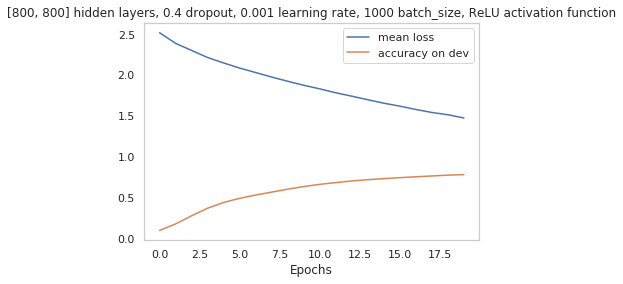

Starting epoch: 0
mean loss:  1.3802019408126518
dev accuracy:  0.8765
Starting epoch: 1
mean loss:  0.7442468306471696
dev accuracy:  0.8984
Starting epoch: 2
mean loss:  0.594684385712255
dev accuracy:  0.9082
Starting epoch: 3
mean loss:  0.5205397145964922
dev accuracy:  0.9149
Starting epoch: 4
mean loss:  0.47364764968095313
dev accuracy:  0.9197
Starting epoch: 5
mean loss:  0.4385051923988164
dev accuracy:  0.9239
Starting epoch: 6
mean loss:  0.4098331041431468
dev accuracy:  0.9282
Starting epoch: 7
mean loss:  0.38876646033279083
dev accuracy:  0.9307
Starting epoch: 8
mean loss:  0.3667745377327982
dev accuracy:  0.9335
Starting epoch: 9
mean loss:  0.35177410889615823
dev accuracy:  0.9373
Starting epoch: 10
mean loss:  0.33741899134829223
dev accuracy:  0.9398
Starting epoch: 11
mean loss:  0.3245522546363293
dev accuracy:  0.9416
Starting epoch: 12
mean loss:  0.3127254844666268
dev accuracy:  0.9453
Starting epoch: 13
mean loss:  0.29777294741604543
dev accuracy:  0.947

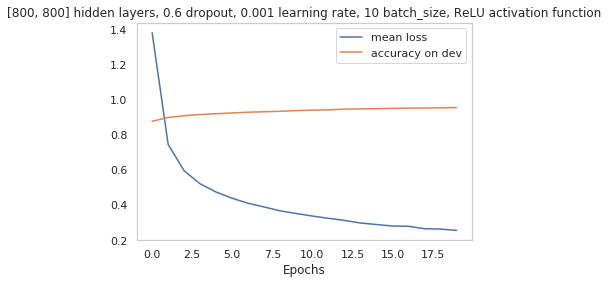

Starting epoch: 0
mean loss:  2.439759493112088
dev accuracy:  0.6075
Starting epoch: 1
mean loss:  1.9884413399858152
dev accuracy:  0.7347
Starting epoch: 2
mean loss:  1.6924167538355448
dev accuracy:  0.7848
Starting epoch: 3
mean loss:  1.4687550831697658
dev accuracy:  0.8168
Starting epoch: 4
mean loss:  1.308780960456102
dev accuracy:  0.8327
Starting epoch: 5
mean loss:  1.185242732365926
dev accuracy:  0.847
Starting epoch: 6
mean loss:  1.085545507971636
dev accuracy:  0.8538
Starting epoch: 7
mean loss:  1.0074743241845014
dev accuracy:  0.8607
Starting epoch: 8
mean loss:  0.9499889813259452
dev accuracy:  0.8674
Starting epoch: 9
mean loss:  0.9038529482906212
dev accuracy:  0.8722
Starting epoch: 10
mean loss:  0.8611764605649693
dev accuracy:  0.876
Starting epoch: 11
mean loss:  0.822917346766371
dev accuracy:  0.879
Starting epoch: 12
mean loss:  0.7920389997507046
dev accuracy:  0.8812
Starting epoch: 13
mean loss:  0.7645261671371802
dev accuracy:  0.8847
Starting e

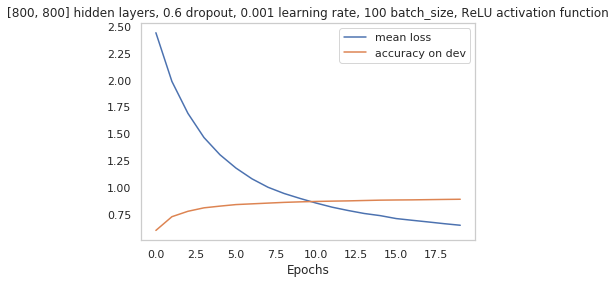

Starting epoch: 0
mean loss:  2.7491309222053077
dev accuracy:  0.1479
Starting epoch: 1
mean loss:  2.627062671324786
dev accuracy:  0.2418
Starting epoch: 2
mean loss:  2.545792738596598
dev accuracy:  0.3444
Starting epoch: 3
mean loss:  2.457300303029079
dev accuracy:  0.4092
Starting epoch: 4
mean loss:  2.3988725718329933
dev accuracy:  0.4597
Starting epoch: 5
mean loss:  2.3404502401164935
dev accuracy:  0.4976
Starting epoch: 6
mean loss:  2.284653808556351
dev accuracy:  0.5331
Starting epoch: 7
mean loss:  2.229771455128988
dev accuracy:  0.5619
Starting epoch: 8
mean loss:  2.1826105725531484
dev accuracy:  0.5893
Starting epoch: 9
mean loss:  2.134005107131659
dev accuracy:  0.6135
Starting epoch: 10
mean loss:  2.0839816822725186
dev accuracy:  0.6352
Starting epoch: 11
mean loss:  2.0475543620539645
dev accuracy:  0.6532
Starting epoch: 12
mean loss:  2.0072207661236035
dev accuracy:  0.6664
Starting epoch: 13
mean loss:  1.9686924943736954
dev accuracy:  0.6804
Starting

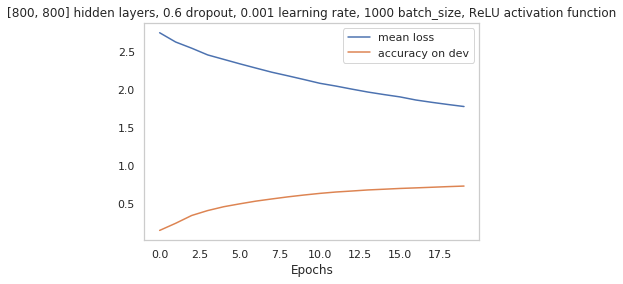

Starting epoch: 0
mean loss:  1.9062669714363403
dev accuracy:  0.7246
Starting epoch: 1
mean loss:  1.3099368698023435
dev accuracy:  0.812
Starting epoch: 2
mean loss:  0.9702966072170336
dev accuracy:  0.845
Starting epoch: 3
mean loss:  0.7800946734060504
dev accuracy:  0.862
Starting epoch: 4
mean loss:  0.6660817694607984
dev accuracy:  0.8743
Starting epoch: 5
mean loss:  0.5916876873387692
dev accuracy:  0.8831
Starting epoch: 6
mean loss:  0.5396264069880325
dev accuracy:  0.8894
Starting epoch: 7
mean loss:  0.5011484786611846
dev accuracy:  0.8929
Starting epoch: 8
mean loss:  0.4714551248860118
dev accuracy:  0.897
Starting epoch: 9
mean loss:  0.44775423910293766
dev accuracy:  0.9002
Starting epoch: 10
mean loss:  0.4283119697631049
dev accuracy:  0.9022
Starting epoch: 11
mean loss:  0.4119976173503069
dev accuracy:  0.9041
Starting epoch: 12
mean loss:  0.3980528928381941
dev accuracy:  0.9062
Starting epoch: 13
mean loss:  0.38594878288431006
dev accuracy:  0.9077
Star

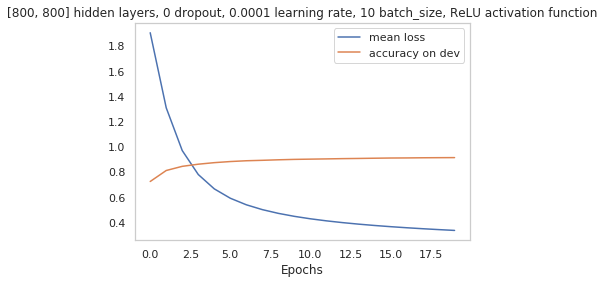

Starting epoch: 0
mean loss:  2.2997096470016207
dev accuracy:  0.1665
Starting epoch: 1
mean loss:  2.17052945643366
dev accuracy:  0.274
Starting epoch: 2
mean loss:  2.0704697851173415
dev accuracy:  0.3962
Starting epoch: 3
mean loss:  1.9819901422588173
dev accuracy:  0.4892
Starting epoch: 4
mean loss:  1.8999149145004517
dev accuracy:  0.5666
Starting epoch: 5
mean loss:  1.8225294025596268
dev accuracy:  0.6237
Starting epoch: 6
mean loss:  1.7491963266612527
dev accuracy:  0.6617
Starting epoch: 7
mean loss:  1.6796457382019407
dev accuracy:  0.6923
Starting epoch: 8
mean loss:  1.6137103123103311
dev accuracy:  0.7153
Starting epoch: 9
mean loss:  1.551290241544118
dev accuracy:  0.7342
Starting epoch: 10
mean loss:  1.4922799661963762
dev accuracy:  0.7469
Starting epoch: 11
mean loss:  1.436579622670324
dev accuracy:  0.7595
Starting epoch: 12
mean loss:  1.3840874847537743
dev accuracy:  0.7696
Starting epoch: 13
mean loss:  1.3346785885131287
dev accuracy:  0.7778
Startin

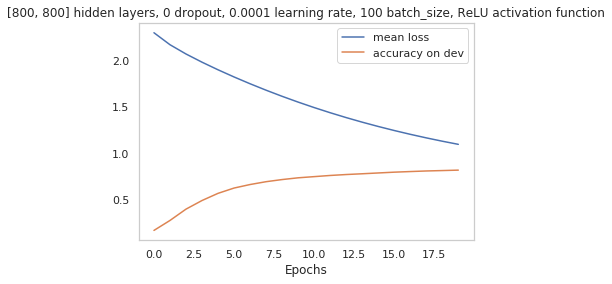

Starting epoch: 0
mean loss:  2.3322780179042444
dev accuracy:  0.0916
Starting epoch: 1
mean loss:  2.3147414525349936
dev accuracy:  0.1005
Starting epoch: 2
mean loss:  2.2982492446899414
dev accuracy:  0.1115
Starting epoch: 3
mean loss:  2.282656272252401
dev accuracy:  0.1216
Starting epoch: 4
mean loss:  2.267839782378253
dev accuracy:  0.1332
Starting epoch: 5
mean loss:  2.2536975168714335
dev accuracy:  0.1432
Starting epoch: 6
mean loss:  2.24014547291924
dev accuracy:  0.155
Starting epoch: 7
mean loss:  2.2271117135590197
dev accuracy:  0.1683
Starting epoch: 8
mean loss:  2.214535638397815
dev accuracy:  0.1791
Starting epoch: 9
mean loss:  2.202365720973295
dev accuracy:  0.1904
Starting epoch: 10
mean loss:  2.190557793074963
dev accuracy:  0.2002
Starting epoch: 11
mean loss:  2.1790738012276445
dev accuracy:  0.2115
Starting epoch: 12
mean loss:  2.1678814186769375
dev accuracy:  0.2233
Starting epoch: 13
mean loss:  2.15695148823308
dev accuracy:  0.234
Starting epoc

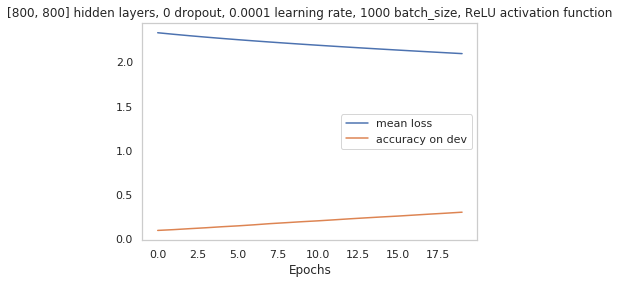

Starting epoch: 0
mean loss:  1.9745162487316075
dev accuracy:  0.7146
Starting epoch: 1
mean loss:  1.4388429349576253
dev accuracy:  0.8186
Starting epoch: 2
mean loss:  1.1017551954520557
dev accuracy:  0.8509
Starting epoch: 3
mean loss:  0.8970986355950512
dev accuracy:  0.863
Starting epoch: 4
mean loss:  0.7766226911230151
dev accuracy:  0.8729
Starting epoch: 5
mean loss:  0.6911345163546093
dev accuracy:  0.8777
Starting epoch: 6
mean loss:  0.6339081111305405
dev accuracy:  0.884
Starting epoch: 7
mean loss:  0.5905331964329872
dev accuracy:  0.8879
Starting epoch: 8
mean loss:  0.5584316490394214
dev accuracy:  0.8925
Starting epoch: 9
mean loss:  0.5308136629904241
dev accuracy:  0.8961
Starting epoch: 10
mean loss:  0.5108771526445224
dev accuracy:  0.8994
Starting epoch: 11
mean loss:  0.4879865614852651
dev accuracy:  0.9028
Starting epoch: 12
mean loss:  0.4705557453222059
dev accuracy:  0.9048
Starting epoch: 13
mean loss:  0.46120807170492484
dev accuracy:  0.9067
Sta

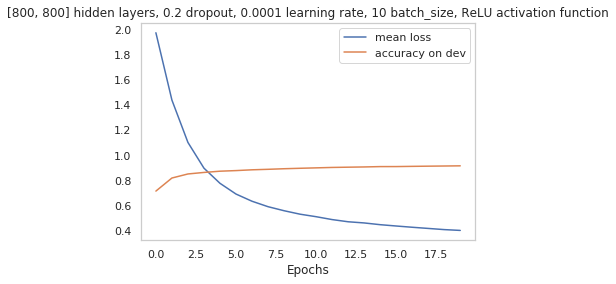

Starting epoch: 0
mean loss:  2.387456058266158
dev accuracy:  0.1256
Starting epoch: 1
mean loss:  2.2784429053346553
dev accuracy:  0.2039
Starting epoch: 2
mean loss:  2.1922210462079077
dev accuracy:  0.3168
Starting epoch: 3
mean loss:  2.119650300153477
dev accuracy:  0.4244
Starting epoch: 4
mean loss:  2.047468457869189
dev accuracy:  0.5049
Starting epoch: 5
mean loss:  1.9834921050690368
dev accuracy:  0.5656
Starting epoch: 6
mean loss:  1.9194443335314235
dev accuracy:  0.6126
Starting epoch: 7
mean loss:  1.8577659334727152
dev accuracy:  0.6519
Starting epoch: 8
mean loss:  1.801169565813746
dev accuracy:  0.6808
Starting epoch: 9
mean loss:  1.7478377811922998
dev accuracy:  0.7043
Starting epoch: 10
mean loss:  1.6911272112718838
dev accuracy:  0.7254
Starting epoch: 11
mean loss:  1.642332194570058
dev accuracy:  0.7411
Starting epoch: 12
mean loss:  1.5907546710111424
dev accuracy:  0.7541
Starting epoch: 13
mean loss:  1.5439192530161845
dev accuracy:  0.7637
Startin

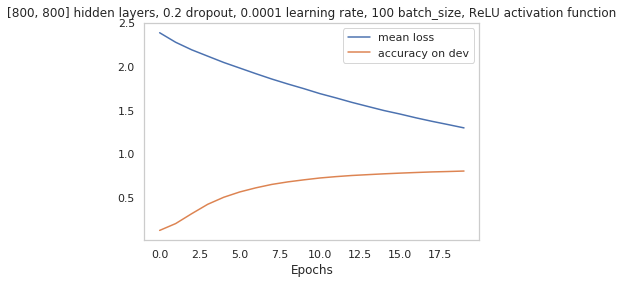

Starting epoch: 0
mean loss:  2.4033006733539057
dev accuracy:  0.0534
Starting epoch: 1
mean loss:  2.387630112030927
dev accuracy:  0.0555
Starting epoch: 2
mean loss:  2.3718491442063274
dev accuracy:  0.0584
Starting epoch: 3
mean loss:  2.3584819120519303
dev accuracy:  0.0624
Starting epoch: 4
mean loss:  2.34636778457492
dev accuracy:  0.0687
Starting epoch: 5
mean loss:  2.3342262576608097
dev accuracy:  0.0748
Starting epoch: 6
mean loss:  2.3195152189217363
dev accuracy:  0.0821
Starting epoch: 7
mean loss:  2.308354901332481
dev accuracy:  0.0879
Starting epoch: 8
mean loss:  2.2958675225575766
dev accuracy:  0.096
Starting epoch: 9
mean loss:  2.284575705434762
dev accuracy:  0.104
Starting epoch: 10
mean loss:  2.277039799035764
dev accuracy:  0.1145
Starting epoch: 11
mean loss:  2.2645030161913704
dev accuracy:  0.125
Starting epoch: 12
mean loss:  2.2530142980463364
dev accuracy:  0.1373
Starting epoch: 13
mean loss:  2.2421848166222667
dev accuracy:  0.1483
Starting ep

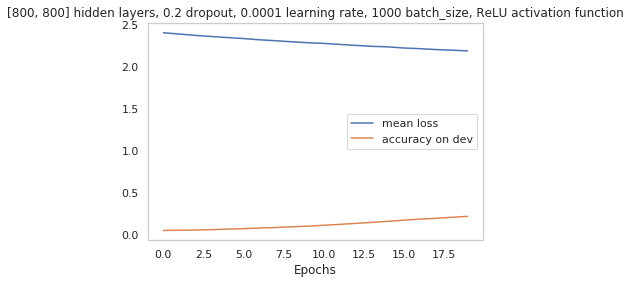

Starting epoch: 0
mean loss:  2.1818042667692503
dev accuracy:  0.6611
Starting epoch: 1
mean loss:  1.6741312973095497
dev accuracy:  0.7885
Starting epoch: 2
mean loss:  1.3449757589361377
dev accuracy:  0.8268
Starting epoch: 3
mean loss:  1.1230183155077549
dev accuracy:  0.8459
Starting epoch: 4
mean loss:  0.9777964262980458
dev accuracy:  0.8588
Starting epoch: 5
mean loss:  0.8759811961085909
dev accuracy:  0.8681
Starting epoch: 6
mean loss:  0.8035048436097111
dev accuracy:  0.8746
Starting epoch: 7
mean loss:  0.746799541563183
dev accuracy:  0.8792
Starting epoch: 8
mean loss:  0.7050755863081477
dev accuracy:  0.8834
Starting epoch: 9
mean loss:  0.6716004848015401
dev accuracy:  0.8872
Starting epoch: 10
mean loss:  0.6433416155294117
dev accuracy:  0.8901
Starting epoch: 11
mean loss:  0.6133452334721144
dev accuracy:  0.8926
Starting epoch: 12
mean loss:  0.5928717232477817
dev accuracy:  0.8957
Starting epoch: 13
mean loss:  0.5789862223188535
dev accuracy:  0.8985
Sta

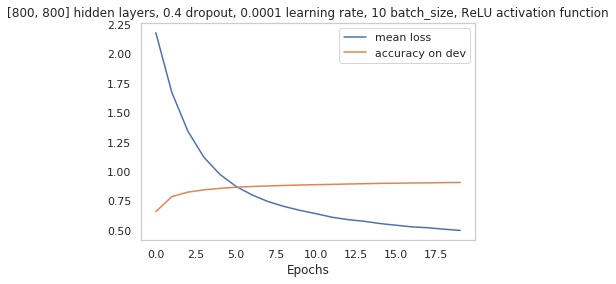

Starting epoch: 0
mean loss:  2.4481199449169897
dev accuracy:  0.1454
Starting epoch: 1
mean loss:  2.3485596251344965
dev accuracy:  0.2358
Starting epoch: 2
mean loss:  2.273791340772739
dev accuracy:  0.3355
Starting epoch: 3
mean loss:  2.2070824566953435
dev accuracy:  0.4181
Starting epoch: 4
mean loss:  2.146557145251961
dev accuracy:  0.4909
Starting epoch: 5
mean loss:  2.087078611769838
dev accuracy:  0.5529
Starting epoch: 6
mean loss:  2.030648830883993
dev accuracy:  0.6003
Starting epoch: 7
mean loss:  1.9716384401340445
dev accuracy:  0.6354
Starting epoch: 8
mean loss:  1.9218906090407077
dev accuracy:  0.6639
Starting epoch: 9
mean loss:  1.8738382214795568
dev accuracy:  0.6848
Starting epoch: 10
mean loss:  1.8248697959496352
dev accuracy:  0.7023
Starting epoch: 11
mean loss:  1.7788367773482423
dev accuracy:  0.7192
Starting epoch: 12
mean loss:  1.73758839228434
dev accuracy:  0.7317
Starting epoch: 13
mean loss:  1.6927239518917487
dev accuracy:  0.7435
Starting

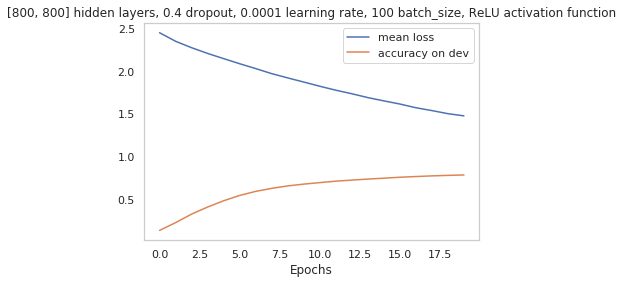

Starting epoch: 0
mean loss:  2.5023724565318988
dev accuracy:  0.1217
Starting epoch: 1
mean loss:  2.48533790251788
dev accuracy:  0.1262
Starting epoch: 2
mean loss:  2.474311585519828
dev accuracy:  0.1313
Starting epoch: 3
mean loss:  2.463304426155838
dev accuracy:  0.1365
Starting epoch: 4
mean loss:  2.451732766394522
dev accuracy:  0.144
Starting epoch: 5
mean loss:  2.439580557393093
dev accuracy:  0.151
Starting epoch: 6
mean loss:  2.4257129874883914
dev accuracy:  0.1584
Starting epoch: 7
mean loss:  2.413294277939142
dev accuracy:  0.1645
Starting epoch: 8
mean loss:  2.406344549328673
dev accuracy:  0.17
Starting epoch: 9
mean loss:  2.400486609515022
dev accuracy:  0.1766
Starting epoch: 10
mean loss:  2.3915931290271235
dev accuracy:  0.1815
Starting epoch: 11
mean loss:  2.381909833234899
dev accuracy:  0.1878
Starting epoch: 12
mean loss:  2.37293275197347
dev accuracy:  0.1932
Starting epoch: 13
mean loss:  2.3602455036312926
dev accuracy:  0.1982
Starting epoch: 14

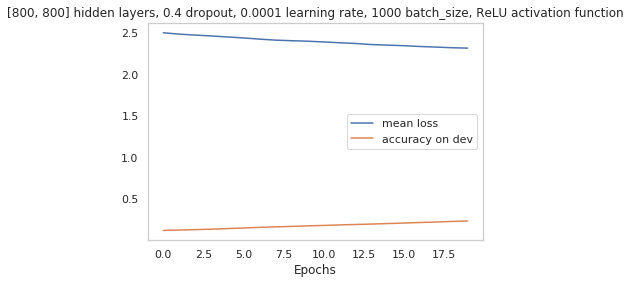

Starting epoch: 0
mean loss:  2.4538055132255865
dev accuracy:  0.6391
Starting epoch: 1
mean loss:  1.9964772006841307
dev accuracy:  0.7595
Starting epoch: 2
mean loss:  1.6967389518035647
dev accuracy:  0.7967
Starting epoch: 3
mean loss:  1.483647867217824
dev accuracy:  0.8232
Starting epoch: 4
mean loss:  1.3197179973673712
dev accuracy:  0.8383
Starting epoch: 5
mean loss:  1.193624033498969
dev accuracy:  0.8483
Starting epoch: 6
mean loss:  1.1062251293547176
dev accuracy:  0.8563
Starting epoch: 7
mean loss:  1.0322690081462886
dev accuracy:  0.8625
Starting epoch: 8
mean loss:  0.9743083028424099
dev accuracy:  0.8674
Starting epoch: 9
mean loss:  0.9140187375660158
dev accuracy:  0.8709
Starting epoch: 10
mean loss:  0.8734903129112289
dev accuracy:  0.8753
Starting epoch: 11
mean loss:  0.8371974414341499
dev accuracy:  0.88
Starting epoch: 12
mean loss:  0.8030280960119264
dev accuracy:  0.8841
Starting epoch: 13
mean loss:  0.7756347170345809
dev accuracy:  0.8875
Starti

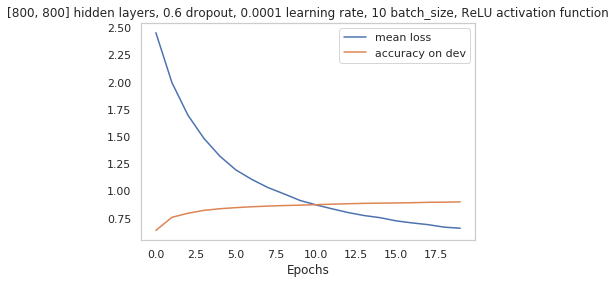

Starting epoch: 0
mean loss:  2.8027033515557083
dev accuracy:  0.1295
Starting epoch: 1
mean loss:  2.668685528094659
dev accuracy:  0.2401
Starting epoch: 2
mean loss:  2.5710029135683103
dev accuracy:  0.334
Starting epoch: 3
mean loss:  2.4971682406709106
dev accuracy:  0.4031
Starting epoch: 4
mean loss:  2.428195720185301
dev accuracy:  0.4577
Starting epoch: 5
mean loss:  2.3700742093388905
dev accuracy:  0.5107
Starting epoch: 6
mean loss:  2.3152885627365873
dev accuracy:  0.5527
Starting epoch: 7
mean loss:  2.267190955594152
dev accuracy:  0.5907
Starting epoch: 8
mean loss:  2.207330776545816
dev accuracy:  0.6189
Starting epoch: 9
mean loss:  2.1648792547142195
dev accuracy:  0.6472
Starting epoch: 10
mean loss:  2.116872459114669
dev accuracy:  0.6649
Starting epoch: 11
mean loss:  2.076232351704748
dev accuracy:  0.679
Starting epoch: 12
mean loss:  2.034572044532456
dev accuracy:  0.6941
Starting epoch: 13
mean loss:  2.0040800224045316
dev accuracy:  0.7067
Starting ep

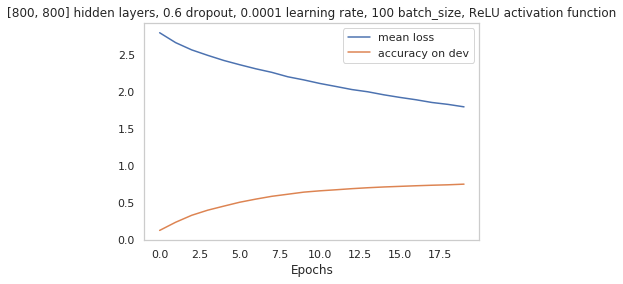

Starting epoch: 0
mean loss:  2.828101644328996
dev accuracy:  0.0889
Starting epoch: 1
mean loss:  2.7983907157299566
dev accuracy:  0.0948
Starting epoch: 2
mean loss:  2.7910251804426607
dev accuracy:  0.1022
Starting epoch: 3
mean loss:  2.775938627766628
dev accuracy:  0.1092
Starting epoch: 4
mean loss:  2.74763157788445
dev accuracy:  0.1164
Starting epoch: 5
mean loss:  2.7348881562550864
dev accuracy:  0.125
Starting epoch: 6
mean loss:  2.726639887865852
dev accuracy:  0.1338
Starting epoch: 7
mean loss:  2.7165796382754457
dev accuracy:  0.1429
Starting epoch: 8
mean loss:  2.689191785513186
dev accuracy:  0.1521
Starting epoch: 9
mean loss:  2.677513360977173
dev accuracy:  0.161
Starting epoch: 10
mean loss:  2.6679663003659715
dev accuracy:  0.1685
Starting epoch: 11
mean loss:  2.6561181031021417
dev accuracy:  0.1769
Starting epoch: 12
mean loss:  2.6520619065153834
dev accuracy:  0.1838
Starting epoch: 13
mean loss:  2.639963009778191
dev accuracy:  0.1912
Starting epo

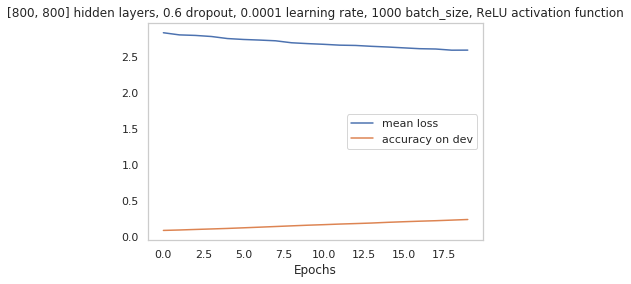

In [18]:
layer_dims_testing = [[800,800]]
input_dim = len(train_img[0])
dropout_values = [0, 0.2, 0.4, 0.6]
learning_rates = [0.1, 0.01, 0.001, 0.0001]
models_list_extra = []
mean_loss_list_extra = []
dev_accuracy_list_extra = []

EPOCHS = 20
batch_sizes = [10, 100, 1000]

cuda0 = torch.device('cuda:0')

for layerdim in layer_dims_testing:
    for lr in learning_rates:  
        for dropout_value in dropout_values:
            for batch_size in batch_sizes:
                model = ReluMLP(input_dim, layerdim, dropout_value)
                model.apply(init_weights)
                model.to(cuda0)
                optimizer = torch.optim.SGD(model.parameters(),lr=lr)
                model, mean_losses, dev_accus = training(model, train_img, train_label, NLLloss, optimizer, dev_img, dev_label, EPOCHS, batch_size)
                models_list_extra.append(model)
                mean_loss_list_extra.append(mean_losses)
                dev_accuracy_list_extra.append(dev_accus)
                plot_graphs(mean_losses, dev_accus, dropout_value, layerdim, lr, batch_size, "ReLU")

In [ ]:
class SigmoidMLP(nn.Module):
    def __init__(self, input_dim, layer_dims, dropout_value):
        super(SigmoidMLP, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, layer_dims[0]))
        layers.append(nn.Sigmoid())
        layers.append(nn.Dropout(dropout_value))
        layers.append(nn.Linear(layer_dims[0], layer_dims[1]))
        layers.append(nn.Sigmoid())
        for i in range(len(layer_dims)-2):
            layers.append(nn.Dropout(dropout_value))
            layers.append(nn.Linear(layer_dims[i+1], layer_dims[i+2]))
            layers.append(nn.Sigmoid())
        layers.append(nn.Dropout(dropout_value))
        layers.append(nn.Linear(layer_dims[-1], 10))
        self.seq = nn.Sequential(*layers)
      
            
    def forward(self, inputs):
        return self.seq(inputs)

Using GPU!
Starting epoch: 0
mean loss:  0.5099894279186513
dev accuracy:  0.9221
Starting epoch: 1
mean loss:  0.23469211293721132
dev accuracy:  0.9485
Starting epoch: 2
mean loss:  0.17264147222702633
dev accuracy:  0.9575
Starting epoch: 3
mean loss:  0.13561213850435722
dev accuracy:  0.9621
Starting epoch: 4
mean loss:  0.11048519716809833
dev accuracy:  0.9647
Starting epoch: 5
mean loss:  0.0921185826340915
dev accuracy:  0.9665
Starting epoch: 6
mean loss:  0.0778069331528424
dev accuracy:  0.9685
Starting epoch: 7
mean loss:  0.06617749064862706
dev accuracy:  0.9687
Starting epoch: 8
mean loss:  0.05649245760006363
dev accuracy:  0.9697
Starting epoch: 9
mean loss:  0.048267119437231214
dev accuracy:  0.9703


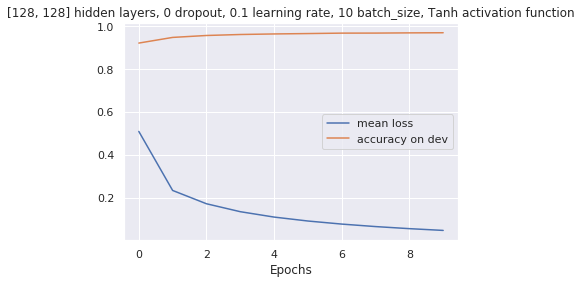

Using GPU!
Starting epoch: 0
mean loss:  1.5233374091679464
dev accuracy:  0.8435
Starting epoch: 1
mean loss:  0.5787761537376754
dev accuracy:  0.8875
Starting epoch: 2
mean loss:  0.42329052762832947
dev accuracy:  0.9013
Starting epoch: 3
mean loss:  0.36624686509192345
dev accuracy:  0.9094
Starting epoch: 4
mean loss:  0.3343462132348748
dev accuracy:  0.9146
Starting epoch: 5
mean loss:  0.3121742068263823
dev accuracy:  0.9196
Starting epoch: 6
mean loss:  0.2947653807149438
dev accuracy:  0.923
Starting epoch: 7
mean loss:  0.28005277228629044
dev accuracy:  0.9259
Starting epoch: 8
mean loss:  0.2670189330350615
dev accuracy:  0.9283
Starting epoch: 9
mean loss:  0.2551328059501515
dev accuracy:  0.932


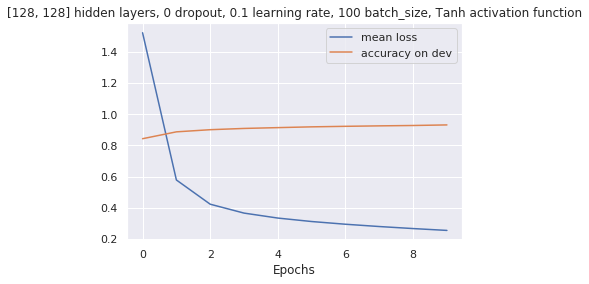

Using GPU!
Starting epoch: 0
mean loss:  2.217227730096555
dev accuracy:  0.477
Starting epoch: 1
mean loss:  2.1255519904342353
dev accuracy:  0.5903
Starting epoch: 2
mean loss:  2.0036812459721283
dev accuracy:  0.6492
Starting epoch: 3
mean loss:  1.8275459397072886
dev accuracy:  0.6906
Starting epoch: 4
mean loss:  1.6064537015615725
dev accuracy:  0.7292
Starting epoch: 5
mean loss:  1.383107161989399
dev accuracy:  0.7623
Starting epoch: 6
mean loss:  1.1918815000384462
dev accuracy:  0.788
Starting epoch: 7
mean loss:  1.0403474919936235
dev accuracy:  0.8085
Starting epoch: 8
mean loss:  0.9233158441150889
dev accuracy:  0.8232
Starting epoch: 9
mean loss:  0.8328946934026831
dev accuracy:  0.8329


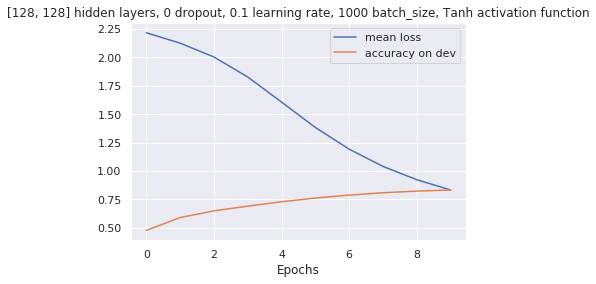

Using GPU!
Starting epoch: 0
mean loss:  0.6351586740703833
dev accuracy:  0.9183
Starting epoch: 1
mean loss:  0.31442523977645315
dev accuracy:  0.9418
Starting epoch: 2
mean loss:  0.24708142649441758
dev accuracy:  0.9521
Starting epoch: 3
mean loss:  0.20719827079410438
dev accuracy:  0.9583
Starting epoch: 4
mean loss:  0.18277680749349987
dev accuracy:  0.9627
Starting epoch: 5
mean loss:  0.1620065658757615
dev accuracy:  0.9663
Starting epoch: 6
mean loss:  0.1486290841346098
dev accuracy:  0.9677
Starting epoch: 7
mean loss:  0.1380216333341873
dev accuracy:  0.9695
Starting epoch: 8
mean loss:  0.12754757780015535
dev accuracy:  0.9717
Starting epoch: 9
mean loss:  0.11849060922588649
dev accuracy:  0.9736


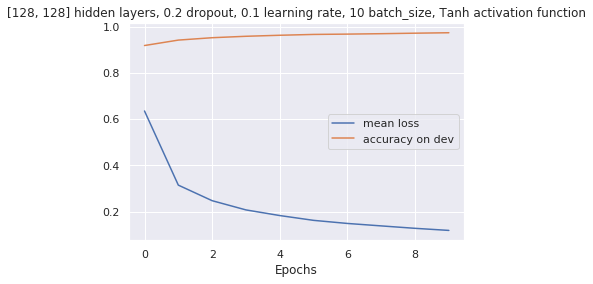

Using GPU!
Starting epoch: 0
mean loss:  1.7320551275017257
dev accuracy:  0.7996
Starting epoch: 1
mean loss:  0.8254786675085802
dev accuracy:  0.8686
Starting epoch: 2
mean loss:  0.593747745136063
dev accuracy:  0.8907
Starting epoch: 3
mean loss:  0.5091740360516988
dev accuracy:  0.9023
Starting epoch: 4
mean loss:  0.45898815831857287
dev accuracy:  0.9079
Starting epoch: 5
mean loss:  0.42706707140761696
dev accuracy:  0.9126
Starting epoch: 6
mean loss:  0.40687598288059235
dev accuracy:  0.9163
Starting epoch: 7
mean loss:  0.38653317322869024
dev accuracy:  0.9207
Starting epoch: 8
mean loss:  0.37076557658151715
dev accuracy:  0.922
Starting epoch: 9
mean loss:  0.3540984624160264
dev accuracy:  0.9235


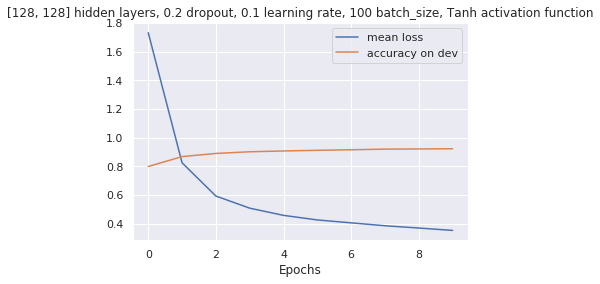

Using GPU!
Starting epoch: 0
mean loss:  2.299697151371077
dev accuracy:  0.4126
Starting epoch: 1
mean loss:  2.2157391099368824
dev accuracy:  0.5699
Starting epoch: 2
mean loss:  2.1301185617259906
dev accuracy:  0.6262
Starting epoch: 3
mean loss:  2.0156525537079455
dev accuracy:  0.6791
Starting epoch: 4
mean loss:  1.8669762003655528
dev accuracy:  0.7023
Starting epoch: 5
mean loss:  1.6876780776416553
dev accuracy:  0.7338
Starting epoch: 6
mean loss:  1.5098729414098404
dev accuracy:  0.7607
Starting epoch: 7
mean loss:  1.3464782518499039
dev accuracy:  0.781
Starting epoch: 8
mean loss:  1.2058083146226173
dev accuracy:  0.798
Starting epoch: 9
mean loss:  1.1012605755936866
dev accuracy:  0.809


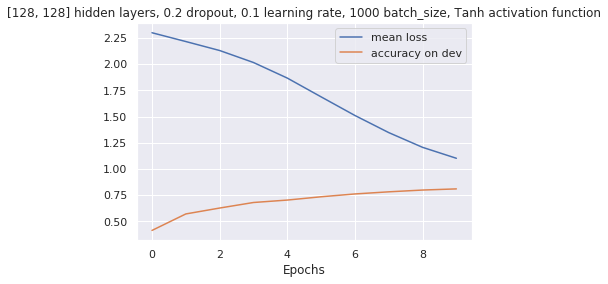

Using GPU!
Starting epoch: 0
mean loss:  0.7886613581524751
dev accuracy:  0.9095
Starting epoch: 1
mean loss:  0.4007349651172039
dev accuracy:  0.9317
Starting epoch: 2
mean loss:  0.3252294768599417
dev accuracy:  0.9434
Starting epoch: 3
mean loss:  0.2877479052316182
dev accuracy:  0.9511
Starting epoch: 4
mean loss:  0.2560942834583509
dev accuracy:  0.9554
Starting epoch: 5
mean loss:  0.23487084464824068
dev accuracy:  0.9594
Starting epoch: 6
mean loss:  0.21880203185956296
dev accuracy:  0.9618
Starting epoch: 7
mean loss:  0.2051138126430679
dev accuracy:  0.9634
Starting epoch: 8
mean loss:  0.19196382795918734
dev accuracy:  0.9655
Starting epoch: 9
mean loss:  0.1893466031060345
dev accuracy:  0.9673


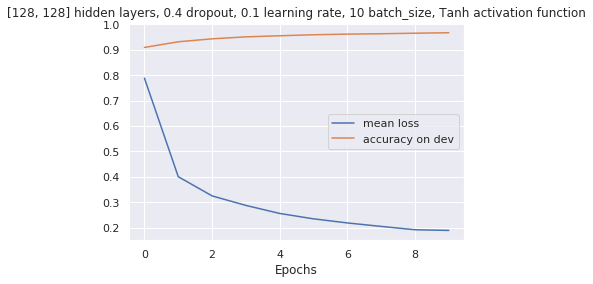

Using GPU!
Starting epoch: 0
mean loss:  1.9476644376556793
dev accuracy:  0.7365
Starting epoch: 1
mean loss:  1.0796886661095533
dev accuracy:  0.8354
Starting epoch: 2
mean loss:  0.7919382837242233
dev accuracy:  0.8676
Starting epoch: 3
mean loss:  0.6696241471819773
dev accuracy:  0.8832
Starting epoch: 4
mean loss:  0.6066242249426014
dev accuracy:  0.8927
Starting epoch: 5
mean loss:  0.5581500014502131
dev accuracy:  0.8996
Starting epoch: 6
mean loss:  0.5262080436338208
dev accuracy:  0.9031
Starting epoch: 7
mean loss:  0.49995997791994595
dev accuracy:  0.9068
Starting epoch: 8
mean loss:  0.47780994455257575
dev accuracy:  0.9097
Starting epoch: 9
mean loss:  0.4622315540761053
dev accuracy:  0.9124


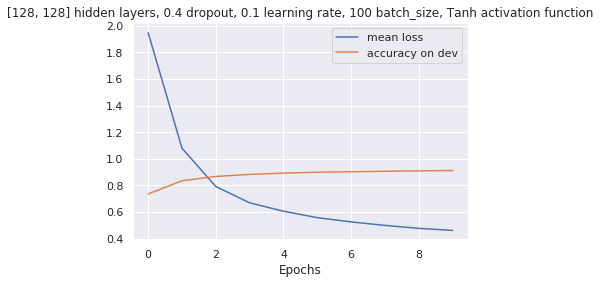

Using GPU!
Starting epoch: 0
mean loss:  2.4012069655399695
dev accuracy:  0.3837
Starting epoch: 1
mean loss:  2.287338359683168
dev accuracy:  0.5448
Starting epoch: 2
mean loss:  2.197271333021276
dev accuracy:  0.6006
Starting epoch: 3
mean loss:  2.107359446731268
dev accuracy:  0.6051
Starting epoch: 4
mean loss:  1.9988488987380384
dev accuracy:  0.6407
Starting epoch: 5
mean loss:  1.8722677020465626
dev accuracy:  0.6639
Starting epoch: 6
mean loss:  1.733223368139828
dev accuracy:  0.6762
Starting epoch: 7
mean loss:  1.601193395315432
dev accuracy:  0.703
Starting epoch: 8
mean loss:  1.4867472671994977
dev accuracy:  0.7207
Starting epoch: 9
mean loss:  1.3901326632967181
dev accuracy:  0.7377


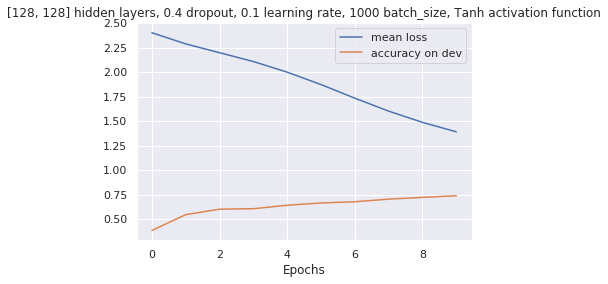

Using GPU!
Starting epoch: 0
mean loss:  1.5887250120318954
dev accuracy:  0.8358
Starting epoch: 1
mean loss:  0.6050654605337916
dev accuracy:  0.8852
Starting epoch: 2
mean loss:  0.4255974918367016
dev accuracy:  0.8998
Starting epoch: 3
mean loss:  0.36537665843708866
dev accuracy:  0.9076
Starting epoch: 4
mean loss:  0.3332681474200465
dev accuracy:  0.9148
Starting epoch: 5
mean loss:  0.31143174437912907
dev accuracy:  0.9195
Starting epoch: 6
mean loss:  0.2943972218038663
dev accuracy:  0.922
Starting epoch: 7
mean loss:  0.27998830533909175
dev accuracy:  0.9253
Starting epoch: 8
mean loss:  0.26721174349172955
dev accuracy:  0.9284
Starting epoch: 9
mean loss:  0.2555763544492428
dev accuracy:  0.9312


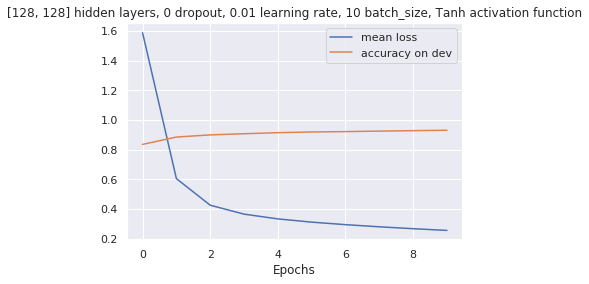

Using GPU!
Starting epoch: 0
mean loss:  2.2622359403355157
dev accuracy:  0.4678
Starting epoch: 1
mean loss:  2.1604389359137257
dev accuracy:  0.6074
Starting epoch: 2
mean loss:  2.028572257407411
dev accuracy:  0.6533
Starting epoch: 3
mean loss:  1.8416626719895475
dev accuracy:  0.688
Starting epoch: 4
mean loss:  1.610414301325937
dev accuracy:  0.7292
Starting epoch: 5
mean loss:  1.3800139381975947
dev accuracy:  0.7621
Starting epoch: 6
mean loss:  1.1850125437487147
dev accuracy:  0.7883
Starting epoch: 7
mean loss:  1.0319587175479668
dev accuracy:  0.8097
Starting epoch: 8
mean loss:  0.9147016717764194
dev accuracy:  0.8273
Starting epoch: 9
mean loss:  0.8244064038623117
dev accuracy:  0.8385


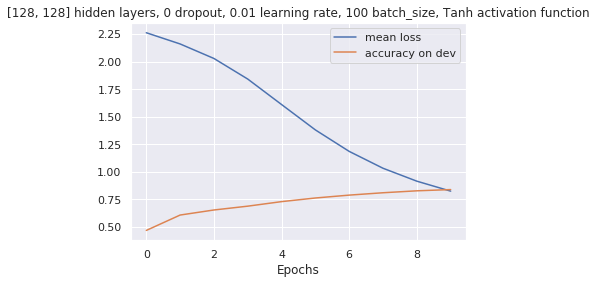

Using GPU!
Starting epoch: 0
mean loss:  2.313033763100119
dev accuracy:  0.1013
Starting epoch: 1
mean loss:  2.24339968550439
dev accuracy:  0.1574
Starting epoch: 2
mean loss:  2.233394473206763
dev accuracy:  0.1754
Starting epoch: 3
mean loss:  2.2243936622844025
dev accuracy:  0.2063
Starting epoch: 4
mean loss:  2.2153479632209327
dev accuracy:  0.2394
Starting epoch: 5
mean loss:  2.2062014598472444
dev accuracy:  0.2741
Starting epoch: 6
mean loss:  2.1969227229847625
dev accuracy:  0.3034
Starting epoch: 7
mean loss:  2.187480028937845
dev accuracy:  0.3379
Starting epoch: 8
mean loss:  2.177843552009732
dev accuracy:  0.3721
Starting epoch: 9
mean loss:  2.1679829990162567
dev accuracy:  0.4061


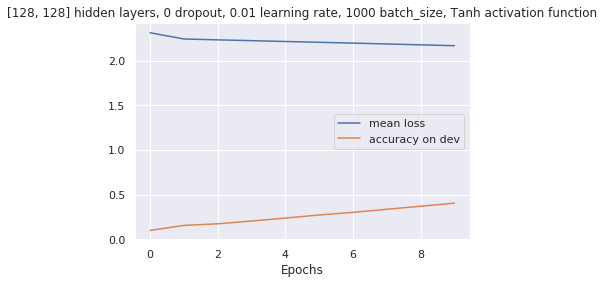

Using GPU!
Starting epoch: 0
mean loss:  1.7373377652531552
dev accuracy:  0.7896
Starting epoch: 1
mean loss:  0.8277877590920157
dev accuracy:  0.8649
Starting epoch: 2
mean loss:  0.6046388713693981
dev accuracy:  0.8888
Starting epoch: 3
mean loss:  0.516961640969047
dev accuracy:  0.8964
Starting epoch: 4
mean loss:  0.46835454285868855
dev accuracy:  0.9036
Starting epoch: 5
mean loss:  0.43318229221355803
dev accuracy:  0.9096
Starting epoch: 6
mean loss:  0.41035823711976066
dev accuracy:  0.9139
Starting epoch: 7
mean loss:  0.3873045915799948
dev accuracy:  0.9175
Starting epoch: 8
mean loss:  0.36886543521653486
dev accuracy:  0.9212
Starting epoch: 9
mean loss:  0.3600532242198082
dev accuracy:  0.9253


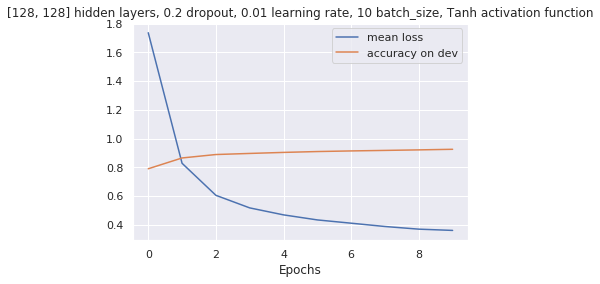

Using GPU!
Starting epoch: 0
mean loss:  2.318644545035448
dev accuracy:  0.4845
Starting epoch: 1
mean loss:  2.212014756040897
dev accuracy:  0.622
Starting epoch: 2
mean loss:  2.098033720147824
dev accuracy:  0.6803
Starting epoch: 3
mean loss:  1.9426459975823196
dev accuracy:  0.7034
Starting epoch: 4
mean loss:  1.75740522324682
dev accuracy:  0.7238
Starting epoch: 5
mean loss:  1.5657224088847757
dev accuracy:  0.7475
Starting epoch: 6
mean loss:  1.394352595963164
dev accuracy:  0.7649
Starting epoch: 7
mean loss:  1.2527741286569012
dev accuracy:  0.7831
Starting epoch: 8
mean loss:  1.139841203204172
dev accuracy:  0.7993
Starting epoch: 9
mean loss:  1.0467251386947023
dev accuracy:  0.811


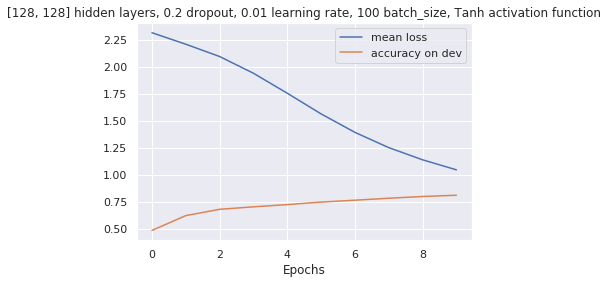

Using GPU!
Starting epoch: 0
mean loss:  2.3729076245251823
dev accuracy:  0.1147
Starting epoch: 1
mean loss:  2.3152815126905253
dev accuracy:  0.1512
Starting epoch: 2
mean loss:  2.306056490131453
dev accuracy:  0.1408
Starting epoch: 3
mean loss:  2.2978097644506716
dev accuracy:  0.1579
Starting epoch: 4
mean loss:  2.2891475406347537
dev accuracy:  0.1885
Starting epoch: 5
mean loss:  2.282511182859832
dev accuracy:  0.2236
Starting epoch: 6
mean loss:  2.2713946548162722
dev accuracy:  0.2759
Starting epoch: 7
mean loss:  2.2642117715349386
dev accuracy:  0.3255
Starting epoch: 8
mean loss:  2.252707448660159
dev accuracy:  0.3592
Starting epoch: 9
mean loss:  2.241417412664376
dev accuracy:  0.3957


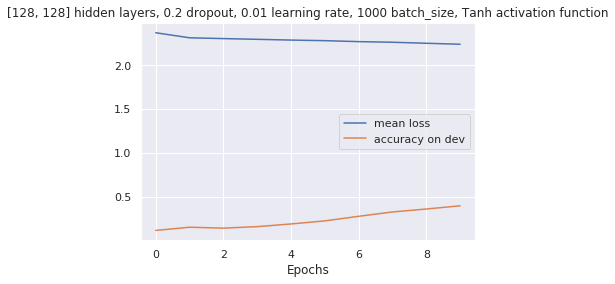

Using GPU!
Starting epoch: 0
mean loss:  1.9498885473211487
dev accuracy:  0.7283
Starting epoch: 1
mean loss:  1.095382002407826
dev accuracy:  0.8307
Starting epoch: 2
mean loss:  0.8162588205064113
dev accuracy:  0.8598
Starting epoch: 3
mean loss:  0.6890887319818184
dev accuracy:  0.8766
Starting epoch: 4
mean loss:  0.6199440647902142
dev accuracy:  0.8914
Starting epoch: 5
mean loss:  0.5708712257565534
dev accuracy:  0.8982
Starting epoch: 6
mean loss:  0.5352032677656149
dev accuracy:  0.9015
Starting epoch: 7
mean loss:  0.5076292718804805
dev accuracy:  0.9057
Starting epoch: 8
mean loss:  0.48459208880563637
dev accuracy:  0.91
Starting epoch: 9
mean loss:  0.466602375818399
dev accuracy:  0.9129


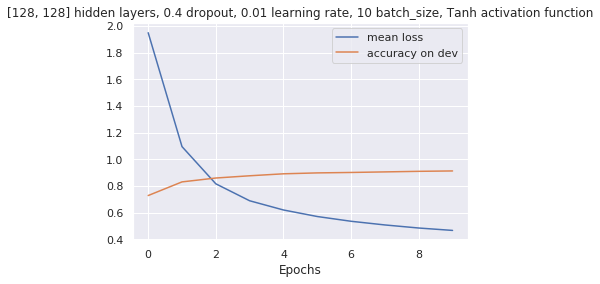

Using GPU!
Starting epoch: 0
mean loss:  2.433756191097572
dev accuracy:  0.3716
Starting epoch: 1
mean loss:  2.32503558775622
dev accuracy:  0.5212
Starting epoch: 2
mean loss:  2.235635978257109
dev accuracy:  0.6037
Starting epoch: 3
mean loss:  2.1531092428161713
dev accuracy:  0.6336
Starting epoch: 4
mean loss:  2.0473114309196703
dev accuracy:  0.6495
Starting epoch: 5
mean loss:  1.9239774354679617
dev accuracy:  0.6736
Starting epoch: 6
mean loss:  1.7903618510373813
dev accuracy:  0.6924
Starting epoch: 7
mean loss:  1.666638639396774
dev accuracy:  0.7129
Starting epoch: 8
mean loss:  1.552543314393171
dev accuracy:  0.7314
Starting epoch: 9
mean loss:  1.4511070363297909
dev accuracy:  0.7498


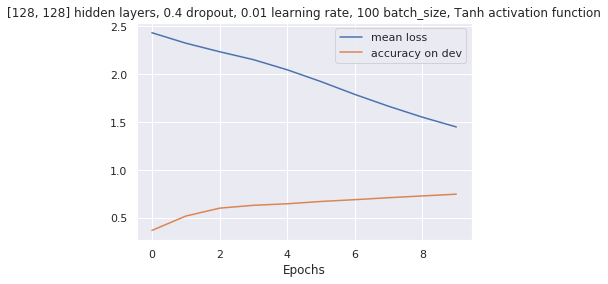

Using GPU!
Starting epoch: 0
mean loss:  2.4671215730554916
dev accuracy:  0.1294
Starting epoch: 1
mean loss:  2.4036953636244234
dev accuracy:  0.1695
Starting epoch: 2
mean loss:  2.3938982533473596
dev accuracy:  0.2079
Starting epoch: 3
mean loss:  2.3883519453160904
dev accuracy:  0.2398
Starting epoch: 4
mean loss:  2.3744210916406967
dev accuracy:  0.2595
Starting epoch: 5
mean loss:  2.364830451853135
dev accuracy:  0.2852
Starting epoch: 6
mean loss:  2.351778100518619
dev accuracy:  0.3143
Starting epoch: 7
mean loss:  2.3448581835802864
dev accuracy:  0.3442
Starting epoch: 8
mean loss:  2.333805668587778
dev accuracy:  0.374
Starting epoch: 9
mean loss:  2.324436435512468
dev accuracy:  0.388


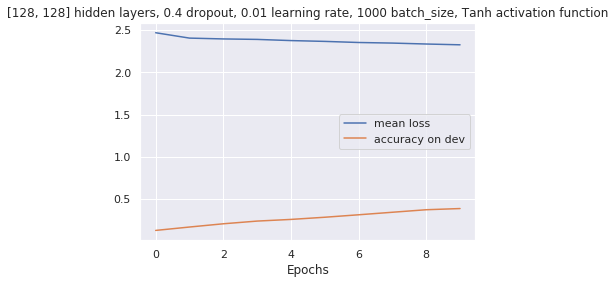

Using GPU!
Starting epoch: 0
mean loss:  2.268586366516522
dev accuracy:  0.4696
Starting epoch: 1
mean loss:  2.162336444144391
dev accuracy:  0.5827
Starting epoch: 2
mean loss:  2.0306066948755865
dev accuracy:  0.6423
Starting epoch: 3
mean loss:  1.8472544592968156
dev accuracy:  0.6821
Starting epoch: 4
mean loss:  1.622988005395747
dev accuracy:  0.7244
Starting epoch: 5
mean loss:  1.3949282334056337
dev accuracy:  0.7577
Starting epoch: 6
mean loss:  1.2002716969666636
dev accuracy:  0.7869
Starting epoch: 7
mean loss:  1.0505809430073938
dev accuracy:  0.8081
Starting epoch: 8
mean loss:  0.9375815066045057
dev accuracy:  0.8254
Starting epoch: 9
mean loss:  0.8501692171920134
dev accuracy:  0.8371


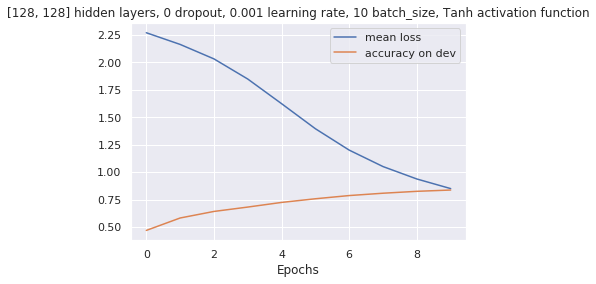

Using GPU!
Starting epoch: 0
mean loss:  2.3931607376791524
dev accuracy:  0.1078
Starting epoch: 1
mean loss:  2.300079651697429
dev accuracy:  0.106
Starting epoch: 2
mean loss:  2.290961000495804
dev accuracy:  0.11
Starting epoch: 3
mean loss:  2.2836906001001536
dev accuracy:  0.1365
Starting epoch: 4
mean loss:  2.276453827193635
dev accuracy:  0.1682
Starting epoch: 5
mean loss:  2.2691889356472297
dev accuracy:  0.2034
Starting epoch: 6
mean loss:  2.2618713554983843
dev accuracy:  0.2366
Starting epoch: 7
mean loss:  2.254477717919264
dev accuracy:  0.2686
Starting epoch: 8
mean loss:  2.2469848315872833
dev accuracy:  0.2982
Starting epoch: 9
mean loss:  2.239369417616945
dev accuracy:  0.3282


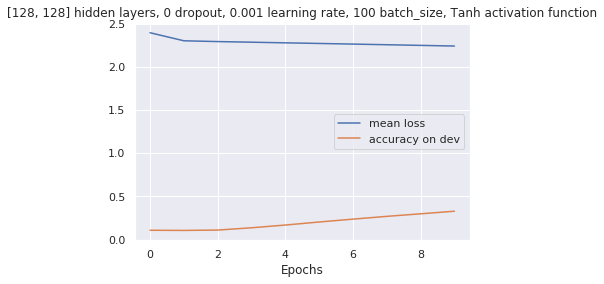

Using GPU!
Starting epoch: 0
mean loss:  2.345568708345002
dev accuracy:  0.1368
Starting epoch: 1
mean loss:  2.314768786523856
dev accuracy:  0.1319
Starting epoch: 2
mean loss:  2.2936455735973285
dev accuracy:  0.1256
Starting epoch: 3
mean loss:  2.2787290227179433
dev accuracy:  0.1221
Starting epoch: 4
mean loss:  2.2679712398379457
dev accuracy:  0.1166
Starting epoch: 5
mean loss:  2.2600885325787115
dev accuracy:  0.1135
Starting epoch: 6
mean loss:  2.254234837550743
dev accuracy:  0.1124
Starting epoch: 7
mean loss:  2.2498307368334602
dev accuracy:  0.1114
Starting epoch: 8
mean loss:  2.2464679315978406
dev accuracy:  0.1117
Starting epoch: 9
mean loss:  2.243854106641283
dev accuracy:  0.1122


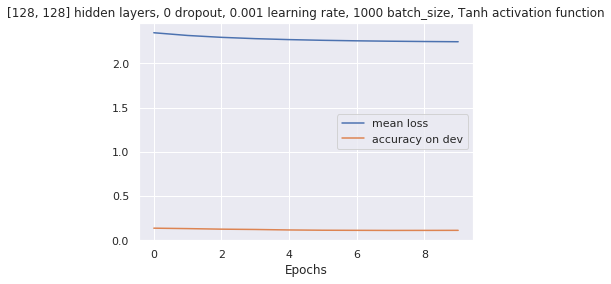

Using GPU!
Starting epoch: 0
mean loss:  2.337300967345403
dev accuracy:  0.4609
Starting epoch: 1
mean loss:  2.2414989394203375
dev accuracy:  0.588
Starting epoch: 2
mean loss:  2.1426095534171896
dev accuracy:  0.6312
Starting epoch: 3
mean loss:  2.013746668376629
dev accuracy:  0.6565
Starting epoch: 4
mean loss:  1.8479522072155699
dev accuracy:  0.6876
Starting epoch: 5
mean loss:  1.6682602230893733
dev accuracy:  0.7209
Starting epoch: 6
mean loss:  1.4909441588378338
dev accuracy:  0.7472
Starting epoch: 7
mean loss:  1.3409431585786915
dev accuracy:  0.7776
Starting epoch: 8
mean loss:  1.2186493390179995
dev accuracy:  0.793
Starting epoch: 9
mean loss:  1.1169751731068391
dev accuracy:  0.8103


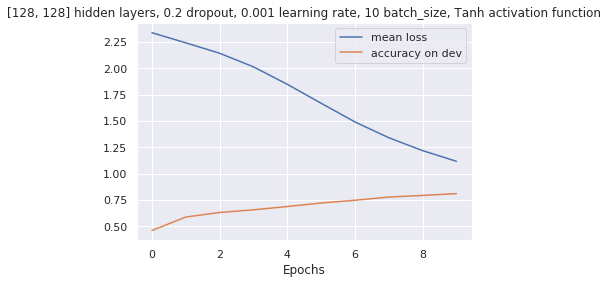

Using GPU!
Starting epoch: 0
mean loss:  2.4021674425540094
dev accuracy:  0.1135
Starting epoch: 1
mean loss:  2.3502482154412183
dev accuracy:  0.1388
Starting epoch: 2
mean loss:  2.3415390479112577
dev accuracy:  0.1598
Starting epoch: 3
mean loss:  2.330408625973913
dev accuracy:  0.1892
Starting epoch: 4
mean loss:  2.3241649944625213
dev accuracy:  0.2065
Starting epoch: 5
mean loss:  2.3165404544381087
dev accuracy:  0.2417
Starting epoch: 6
mean loss:  2.306725642876235
dev accuracy:  0.2747
Starting epoch: 7
mean loss:  2.3006298565816974
dev accuracy:  0.3032
Starting epoch: 8
mean loss:  2.2937911589464504
dev accuracy:  0.3369
Starting epoch: 9
mean loss:  2.2825896206968084
dev accuracy:  0.3605


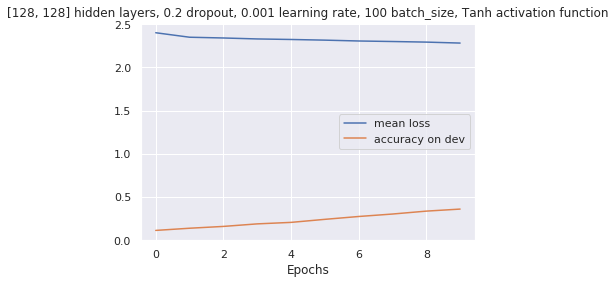

Using GPU!
Starting epoch: 0
mean loss:  2.563323320127001
dev accuracy:  0.103
Starting epoch: 1
mean loss:  2.4810937479430555
dev accuracy:  0.103
Starting epoch: 2
mean loss:  2.4288006763832244
dev accuracy:  0.103
Starting epoch: 3
mean loss:  2.390988167594461
dev accuracy:  0.1026
Starting epoch: 4
mean loss:  2.366042978623334
dev accuracy:  0.1002
Starting epoch: 5
mean loss:  2.3522589393690523
dev accuracy:  0.0895
Starting epoch: 6
mean loss:  2.3376955051048127
dev accuracy:  0.0757
Starting epoch: 7
mean loss:  2.3303021122427547
dev accuracy:  0.0598
Starting epoch: 8
mean loss:  2.323246399561564
dev accuracy:  0.0558
Starting epoch: 9
mean loss:  2.3157448862113204
dev accuracy:  0.0647


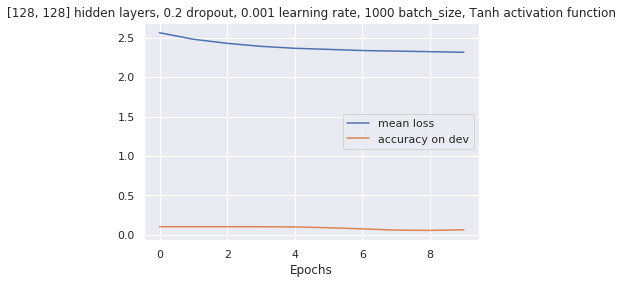

Using GPU!
Starting epoch: 0
mean loss:  2.415990360973597
dev accuracy:  0.348
Starting epoch: 1
mean loss:  2.318508166476408
dev accuracy:  0.5661
Starting epoch: 2
mean loss:  2.2394309904164875
dev accuracy:  0.6282
Starting epoch: 3
mean loss:  2.1545832275128607
dev accuracy:  0.6521
Starting epoch: 4
mean loss:  2.053242928503609
dev accuracy:  0.662
Starting epoch: 5
mean loss:  1.9355256798934326
dev accuracy:  0.6772
Starting epoch: 6
mean loss:  1.8004547000717959
dev accuracy:  0.7021
Starting epoch: 7
mean loss:  1.6644456115896
dev accuracy:  0.7228
Starting epoch: 8
mean loss:  1.5447352612717011
dev accuracy:  0.7402
Starting epoch: 9
mean loss:  1.4427849502473848
dev accuracy:  0.7535


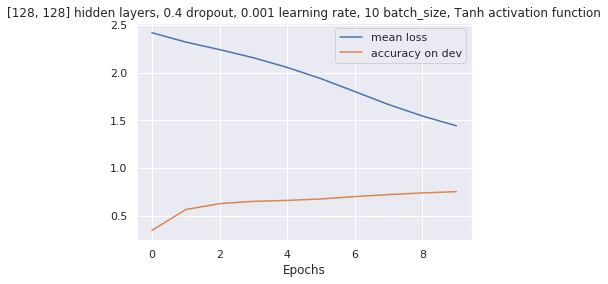

Using GPU!
Starting epoch: 0
mean loss:  2.5437256794965672
dev accuracy:  0.1622
Starting epoch: 1
mean loss:  2.4545883199649894
dev accuracy:  0.252
Starting epoch: 2
mean loss:  2.437974568612561
dev accuracy:  0.1644
Starting epoch: 3
mean loss:  2.4176251588467355
dev accuracy:  0.171
Starting epoch: 4
mean loss:  2.408449028304475
dev accuracy:  0.1844
Starting epoch: 5
mean loss:  2.4018024536901845
dev accuracy:  0.2048
Starting epoch: 6
mean loss:  2.3913494174827834
dev accuracy:  0.2289
Starting epoch: 7
mean loss:  2.3759736115347128
dev accuracy:  0.2614
Starting epoch: 8
mean loss:  2.3658015670890578
dev accuracy:  0.2759
Starting epoch: 9
mean loss:  2.361834649316327
dev accuracy:  0.2894


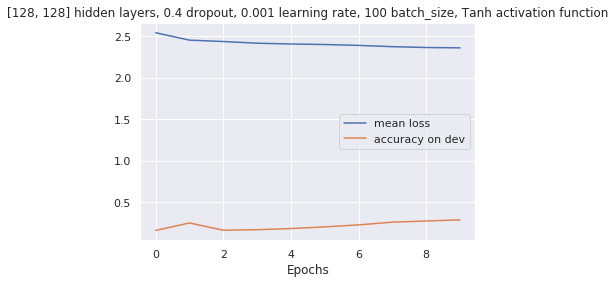

Using GPU!
Starting epoch: 0
mean loss:  2.5824112144171023
dev accuracy:  0.099
Starting epoch: 1
mean loss:  2.53956124829311
dev accuracy:  0.0984
Starting epoch: 2
mean loss:  2.514289743760053
dev accuracy:  0.0971
Starting epoch: 3
mean loss:  2.492770695218853
dev accuracy:  0.1366
Starting epoch: 4
mean loss:  2.4768075849495683
dev accuracy:  0.1635
Starting epoch: 5
mean loss:  2.4575295261308256
dev accuracy:  0.1556
Starting epoch: 6
mean loss:  2.451674311768775
dev accuracy:  0.1466
Starting epoch: 7
mean loss:  2.442569498922311
dev accuracy:  0.1352
Starting epoch: 8
mean loss:  2.433481875587912
dev accuracy:  0.1295
Starting epoch: 9
mean loss:  2.437848591337017
dev accuracy:  0.1245


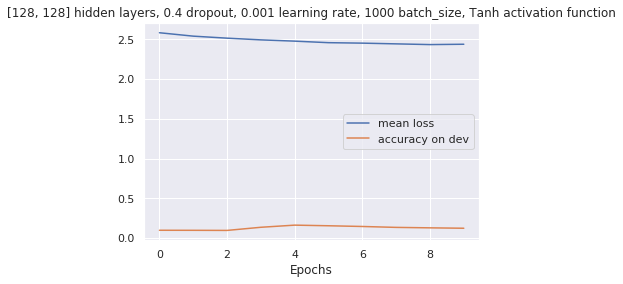

Using GPU!
Starting epoch: 0
mean loss:  1.4950170197371984
dev accuracy:  0.8038
Starting epoch: 1
mean loss:  0.4732332032466621
dev accuracy:  0.9204
Starting epoch: 2
mean loss:  0.260110375904764
dev accuracy:  0.9439
Starting epoch: 3
mean loss:  0.1841763639330031
dev accuracy:  0.9552
Starting epoch: 4
mean loss:  0.14310601759509037
dev accuracy:  0.9623
Starting epoch: 5
mean loss:  0.11672900575151679
dev accuracy:  0.9651
Starting epoch: 6
mean loss:  0.09734396147732585
dev accuracy:  0.9666
Starting epoch: 7
mean loss:  0.08206546491868995
dev accuracy:  0.9683
Starting epoch: 8
mean loss:  0.06972696324971937
dev accuracy:  0.969
Starting epoch: 9
mean loss:  0.05969365052422367
dev accuracy:  0.9698


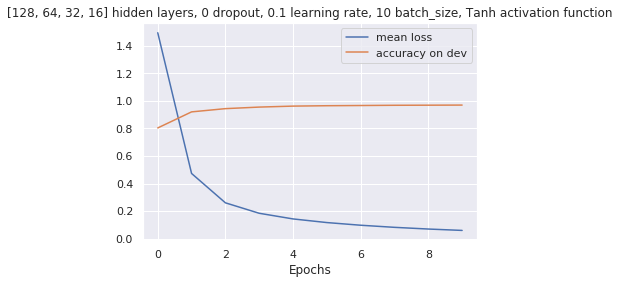

Using GPU!
Starting epoch: 0
mean loss:  2.295225893427988
dev accuracy:  0.103
Starting epoch: 1
mean loss:  2.26516563354614
dev accuracy:  0.3448
Starting epoch: 2
mean loss:  1.9346390874561912
dev accuracy:  0.4441
Starting epoch: 3
mean loss:  1.3834944711235946
dev accuracy:  0.5285
Starting epoch: 4
mean loss:  1.1574303456647193
dev accuracy:  0.6316
Starting epoch: 5
mean loss:  0.991309053169753
dev accuracy:  0.7312
Starting epoch: 6
mean loss:  0.8065225476038432
dev accuracy:  0.8169
Starting epoch: 7
mean loss:  0.6315459804144686
dev accuracy:  0.8513
Starting epoch: 8
mean loss:  0.5296309771770965
dev accuracy:  0.8706
Starting epoch: 9
mean loss:  0.4672668124744278
dev accuracy:  0.8836


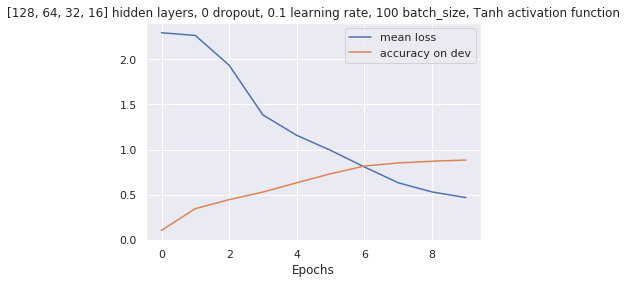

Using GPU!
Starting epoch: 0
mean loss:  2.2927590211232505
dev accuracy:  0.1064
Starting epoch: 1
mean loss:  2.255938880583819
dev accuracy:  0.1064
Starting epoch: 2
mean loss:  2.2551375370399627
dev accuracy:  0.1064
Starting epoch: 3
mean loss:  2.2544129268795836
dev accuracy:  0.1064
Starting epoch: 4
mean loss:  2.2536702576805565
dev accuracy:  0.1064
Starting epoch: 5
mean loss:  2.2528995672861734
dev accuracy:  0.1064
Starting epoch: 6
mean loss:  2.2520904634513106
dev accuracy:  0.1064
Starting epoch: 7
mean loss:  2.2512318573746026
dev accuracy:  0.1064
Starting epoch: 8
mean loss:  2.2503102433447744
dev accuracy:  0.1064
Starting epoch: 9
mean loss:  2.2493102784250296
dev accuracy:  0.1064


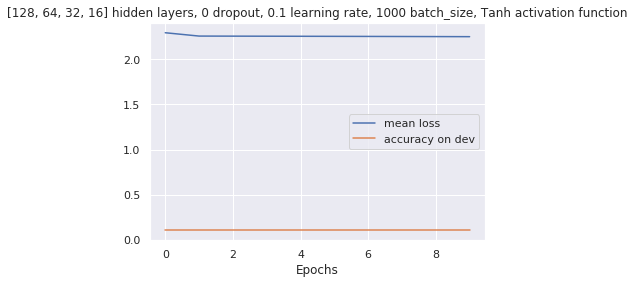

Using GPU!
Starting epoch: 0
mean loss:  2.1317940065084136
dev accuracy:  0.3338
Starting epoch: 1
mean loss:  1.3048433836067563
dev accuracy:  0.786
Starting epoch: 2
mean loss:  0.8243008808502315
dev accuracy:  0.885
Starting epoch: 3
mean loss:  0.6142754463072575
dev accuracy:  0.9192
Starting epoch: 4
mean loss:  0.501897988464386
dev accuracy:  0.9288
Starting epoch: 5
mean loss:  0.4236556702378934
dev accuracy:  0.9442
Starting epoch: 6
mean loss:  0.3702264075573266
dev accuracy:  0.9491
Starting epoch: 7
mean loss:  0.340209156501341
dev accuracy:  0.9538
Starting epoch: 8
mean loss:  0.3132768776159755
dev accuracy:  0.9556
Starting epoch: 9
mean loss:  0.29574458014538074
dev accuracy:  0.9586


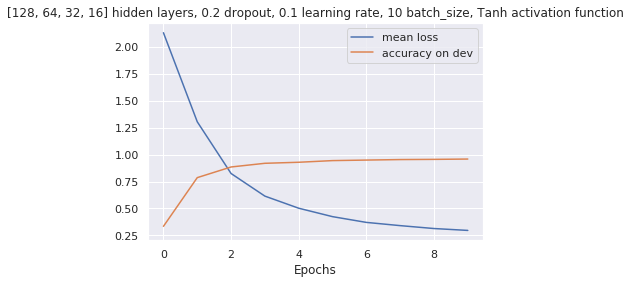

Using GPU!
Starting epoch: 0
mean loss:  2.334681858797511
dev accuracy:  0.103
Starting epoch: 1
mean loss:  2.304406800907767
dev accuracy:  0.1871
Starting epoch: 2
mean loss:  2.2974850422369983
dev accuracy:  0.1818
Starting epoch: 3
mean loss:  2.2919222509075783
dev accuracy:  0.1945
Starting epoch: 4
mean loss:  2.2713410283277136
dev accuracy:  0.2959
Starting epoch: 5
mean loss:  2.1067052261082235
dev accuracy:  0.2814
Starting epoch: 6
mean loss:  1.8942374626319565
dev accuracy:  0.3053
Starting epoch: 7
mean loss:  1.7825061247020424
dev accuracy:  0.3961
Starting epoch: 8
mean loss:  1.6644732887873392
dev accuracy:  0.5198
Starting epoch: 9
mean loss:  1.4729995751333331
dev accuracy:  0.5831


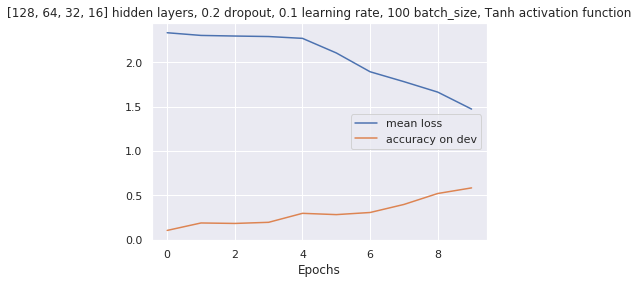

Using GPU!
Starting epoch: 0
mean loss:  2.3286938386804916
dev accuracy:  0.1064
Starting epoch: 1
mean loss:  2.2884087936550963
dev accuracy:  0.1064
Starting epoch: 2
mean loss:  2.284552634931078
dev accuracy:  0.1064
Starting epoch: 3
mean loss:  2.2788472269095625
dev accuracy:  0.1064
Starting epoch: 4
mean loss:  2.2758668263753257
dev accuracy:  0.1064
Starting epoch: 5
mean loss:  2.272099742702409
dev accuracy:  0.1064
Starting epoch: 6
mean loss:  2.2694803312713026
dev accuracy:  0.1064
Starting epoch: 7
mean loss:  2.267649449554144
dev accuracy:  0.1064
Starting epoch: 8
mean loss:  2.26636386385151
dev accuracy:  0.1064
Starting epoch: 9
mean loss:  2.2644895104800953
dev accuracy:  0.1064


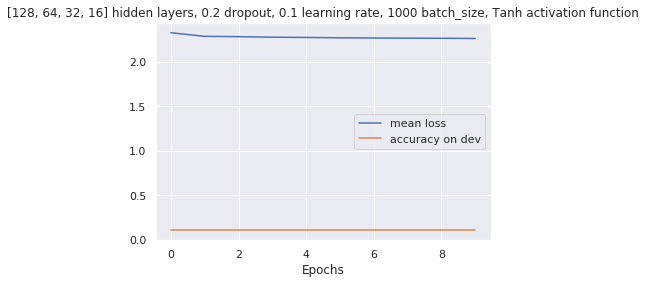

Using GPU!
Starting epoch: 0
mean loss:  2.3108171216727875
dev accuracy:  0.103
Starting epoch: 1
mean loss:  2.3030698358047204
dev accuracy:  0.103
Starting epoch: 2
mean loss:  2.2435436260697843
dev accuracy:  0.2589
Starting epoch: 3
mean loss:  1.7835893475563616
dev accuracy:  0.3726
Starting epoch: 4
mean loss:  1.539654371726992
dev accuracy:  0.4389
Starting epoch: 5
mean loss:  1.3676182478934473
dev accuracy:  0.4227
Starting epoch: 6
mean loss:  1.288105332727457
dev accuracy:  0.5217
Starting epoch: 7
mean loss:  1.1789825665512172
dev accuracy:  0.6389
Starting epoch: 8
mean loss:  1.0944272708568639
dev accuracy:  0.782
Starting epoch: 9
mean loss:  1.0018536804277072
dev accuracy:  0.8069


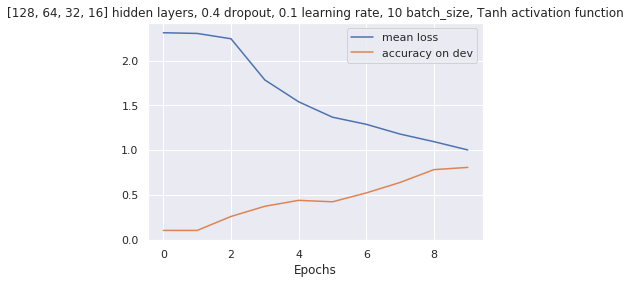

Using GPU!
Starting epoch: 0
mean loss:  2.34730690348886
dev accuracy:  0.1064
Starting epoch: 1
mean loss:  2.3045783166637914
dev accuracy:  0.1064
Starting epoch: 2
mean loss:  2.300029985443085
dev accuracy:  0.1064
Starting epoch: 3
mean loss:  2.2989043651702636
dev accuracy:  0.1064
Starting epoch: 4
mean loss:  2.2984305922380703
dev accuracy:  0.1064
Starting epoch: 5
mean loss:  2.2978081822157383
dev accuracy:  0.1064
Starting epoch: 6
mean loss:  2.2977319172994344
dev accuracy:  0.1064
Starting epoch: 7
mean loss:  2.297460699271775
dev accuracy:  0.1064
Starting epoch: 8
mean loss:  2.2970157378685925
dev accuracy:  0.1064
Starting epoch: 9
mean loss:  2.2968019073356887
dev accuracy:  0.1064


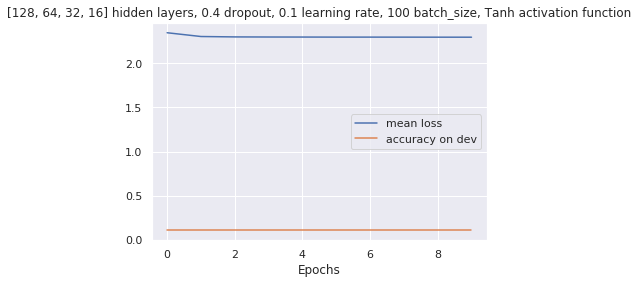

Using GPU!
Starting epoch: 0
mean loss:  2.3977294388939354
dev accuracy:  0.103
Starting epoch: 1
mean loss:  2.313848677803488
dev accuracy:  0.1064
Starting epoch: 2
mean loss:  2.294062988430846
dev accuracy:  0.1064
Starting epoch: 3
mean loss:  2.286153653088738
dev accuracy:  0.1064
Starting epoch: 4
mean loss:  2.2811595926097796
dev accuracy:  0.1064
Starting epoch: 5
mean loss:  2.276911408293481
dev accuracy:  0.1064
Starting epoch: 6
mean loss:  2.2736905415852866
dev accuracy:  0.1064
Starting epoch: 7
mean loss:  2.270102856205959
dev accuracy:  0.1064
Starting epoch: 8
mean loss:  2.267857500151092
dev accuracy:  0.1064
Starting epoch: 9
mean loss:  2.267543760000491
dev accuracy:  0.1064


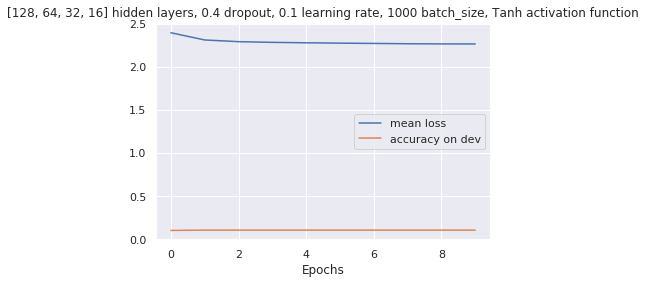

Using GPU!
Starting epoch: 0
mean loss:  2.303812944681686
dev accuracy:  0.103
Starting epoch: 1
mean loss:  2.279655992925179
dev accuracy:  0.2227
Starting epoch: 2
mean loss:  2.099004838853282
dev accuracy:  0.3654
Starting epoch: 3
mean loss:  1.728204263136211
dev accuracy:  0.4873
Starting epoch: 4
mean loss:  1.3769614524875633
dev accuracy:  0.6355
Starting epoch: 5
mean loss:  1.0020972659971161
dev accuracy:  0.7492
Starting epoch: 6
mean loss:  0.7879279923394927
dev accuracy:  0.823
Starting epoch: 7
mean loss:  0.6387320966261478
dev accuracy:  0.8543
Starting epoch: 8
mean loss:  0.5424634709140821
dev accuracy:  0.8709
Starting epoch: 9
mean loss:  0.4804744569644692
dev accuracy:  0.8813


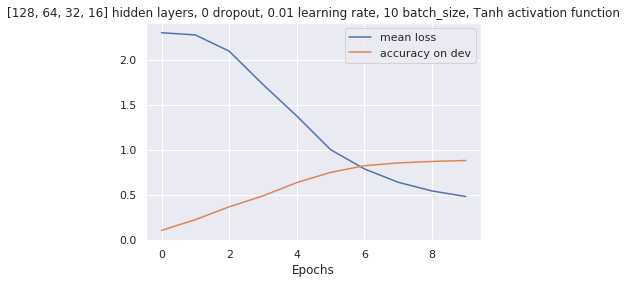

Using GPU!
Starting epoch: 0
mean loss:  2.3224728711826836
dev accuracy:  0.1064
Starting epoch: 1
mean loss:  2.2946923235933223
dev accuracy:  0.1064
Starting epoch: 2
mean loss:  2.293530304274873
dev accuracy:  0.1064
Starting epoch: 3
mean loss:  2.292395312867003
dev accuracy:  0.1064
Starting epoch: 4
mean loss:  2.2912060433994985
dev accuracy:  0.1064
Starting epoch: 5
mean loss:  2.2899419214435204
dev accuracy:  0.1064
Starting epoch: 6
mean loss:  2.2885792269678173
dev accuracy:  0.1064
Starting epoch: 7
mean loss:  2.2870897038016254
dev accuracy:  0.1064
Starting epoch: 8
mean loss:  2.285439107232465
dev accuracy:  0.1065
Starting epoch: 9
mean loss:  2.2835849659171648
dev accuracy:  0.1077


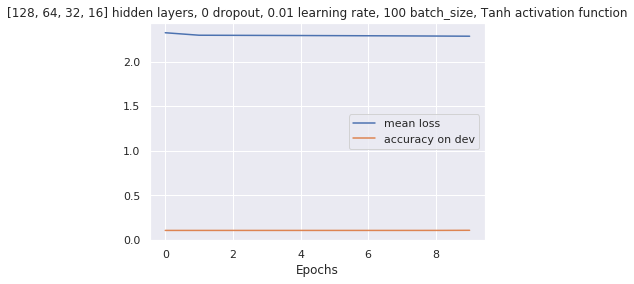

Using GPU!
Starting epoch: 0
mean loss:  2.6182898399876615
dev accuracy:  0.0967
Starting epoch: 1
mean loss:  2.438873618256812
dev accuracy:  0.0967
Starting epoch: 2
mean loss:  2.350686638962989
dev accuracy:  0.0967
Starting epoch: 3
mean loss:  2.3060252479478422
dev accuracy:  0.0967
Starting epoch: 4
mean loss:  2.2827354739694035
dev accuracy:  0.0967
Starting epoch: 5
mean loss:  2.2702703756444595
dev accuracy:  0.0967
Starting epoch: 6
mean loss:  2.263481747870352
dev accuracy:  0.0876
Starting epoch: 7
mean loss:  2.259746869405111
dev accuracy:  0.1064
Starting epoch: 8
mean loss:  2.2576773306902718
dev accuracy:  0.1064
Starting epoch: 9
mean loss:  2.256516830593932
dev accuracy:  0.1064


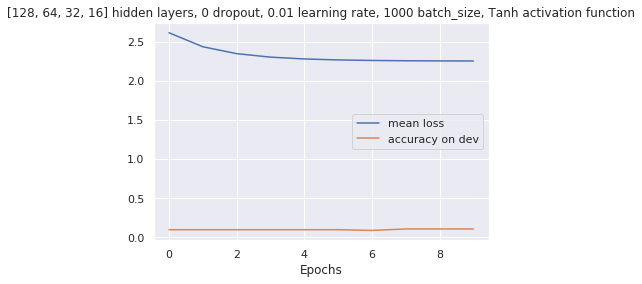

Using GPU!
Starting epoch: 0
mean loss:  2.32404573129144
dev accuracy:  0.1633
Starting epoch: 1
mean loss:  2.3040100817822426
dev accuracy:  0.1159
Starting epoch: 2
mean loss:  2.2988244554229413
dev accuracy:  0.1064
Starting epoch: 3
mean loss:  2.2898714318320263
dev accuracy:  0.2213
Starting epoch: 4
mean loss:  2.2113546553050916
dev accuracy:  0.2434
Starting epoch: 5
mean loss:  1.9945329512340788
dev accuracy:  0.2723
Starting epoch: 6
mean loss:  1.8839665151219254
dev accuracy:  0.3019
Starting epoch: 7
mean loss:  1.8251728579369193
dev accuracy:  0.3504
Starting epoch: 8
mean loss:  1.7467400790738763
dev accuracy:  0.4951
Starting epoch: 9
mean loss:  1.5626675177040017
dev accuracy:  0.5857


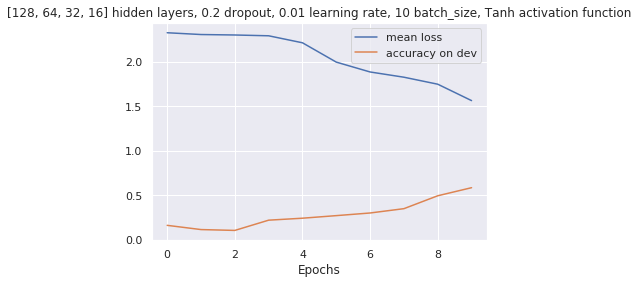

Using GPU!
Starting epoch: 0
mean loss:  2.3905637035826723
dev accuracy:  0.0942
Starting epoch: 1
mean loss:  2.336667058948509
dev accuracy:  0.1064
Starting epoch: 2
mean loss:  2.3268901678378473
dev accuracy:  0.1064
Starting epoch: 3
mean loss:  2.3246904152358128
dev accuracy:  0.1064
Starting epoch: 4
mean loss:  2.3195496714281703
dev accuracy:  0.1064
Starting epoch: 5
mean loss:  2.317222924527532
dev accuracy:  0.1064
Starting epoch: 6
mean loss:  2.3130177333207427
dev accuracy:  0.1064
Starting epoch: 7
mean loss:  2.3093001347577977
dev accuracy:  0.1064
Starting epoch: 8
mean loss:  2.309059707942361
dev accuracy:  0.1064
Starting epoch: 9
mean loss:  2.3072142125127795
dev accuracy:  0.1064


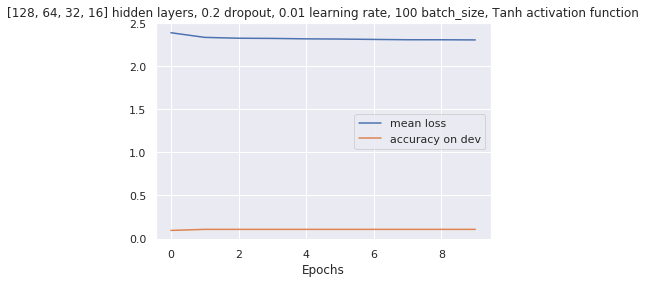

Using GPU!
Starting epoch: 0
mean loss:  2.5972006461199593
dev accuracy:  0.109
Starting epoch: 1
mean loss:  2.4966242687374938
dev accuracy:  0.109
Starting epoch: 2
mean loss:  2.442891667870914
dev accuracy:  0.109
Starting epoch: 3
mean loss:  2.405158201853434
dev accuracy:  0.109
Starting epoch: 4
mean loss:  2.378938441183053
dev accuracy:  0.109
Starting epoch: 5
mean loss:  2.3575108285043753
dev accuracy:  0.109
Starting epoch: 6
mean loss:  2.342820686452529
dev accuracy:  0.109
Starting epoch: 7
mean loss:  2.3309210048002353
dev accuracy:  0.109
Starting epoch: 8
mean loss:  2.327683500215119
dev accuracy:  0.1076
Starting epoch: 9
mean loss:  2.320588233424168
dev accuracy:  0.1096


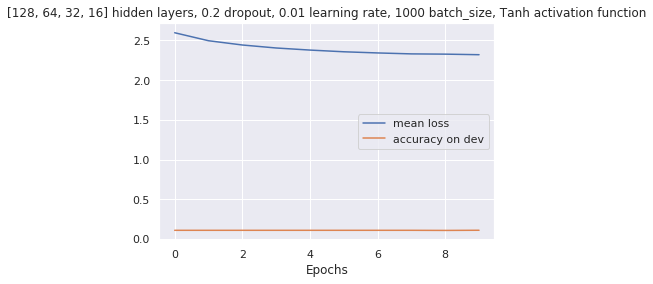

Using GPU!
Starting epoch: 0
mean loss:  2.349181585992677
dev accuracy:  0.1064
Starting epoch: 1
mean loss:  2.30824077465467
dev accuracy:  0.1064
Starting epoch: 2
mean loss:  2.3035584058649086
dev accuracy:  0.1064
Starting epoch: 3
mean loss:  2.3033070870815004
dev accuracy:  0.1064
Starting epoch: 4
mean loss:  2.302049306220375
dev accuracy:  0.1064
Starting epoch: 5
mean loss:  2.3015827899979393
dev accuracy:  0.1064
Starting epoch: 6
mean loss:  2.3010408562246596
dev accuracy:  0.1064
Starting epoch: 7
mean loss:  2.3009536223896885
dev accuracy:  0.1064
Starting epoch: 8
mean loss:  2.300895538789657
dev accuracy:  0.1064
Starting epoch: 9
mean loss:  2.300485576112088
dev accuracy:  0.1064


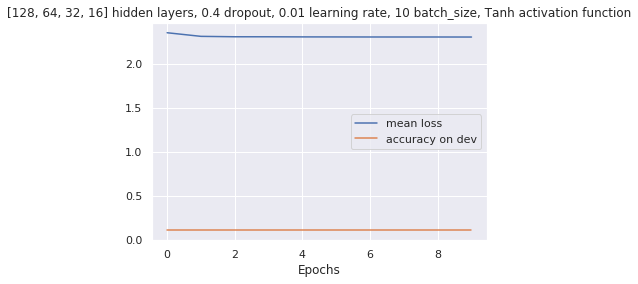

Using GPU!
Starting epoch: 0
mean loss:  2.46778362049552
dev accuracy:  0.1084
Starting epoch: 1
mean loss:  2.3853088776746434
dev accuracy:  0.1064
Starting epoch: 2
mean loss:  2.3576263972147258
dev accuracy:  0.1064
Starting epoch: 3
mean loss:  2.342282885324931
dev accuracy:  0.1064
Starting epoch: 4
mean loss:  2.3320104038406035
dev accuracy:  0.1064
Starting epoch: 5
mean loss:  2.3243328230585645
dev accuracy:  0.1064
Starting epoch: 6
mean loss:  2.319350447245463
dev accuracy:  0.1064
Starting epoch: 7
mean loss:  2.314607584071968
dev accuracy:  0.1064
Starting epoch: 8
mean loss:  2.313782541575784
dev accuracy:  0.1064
Starting epoch: 9
mean loss:  2.3108867342600568
dev accuracy:  0.1064


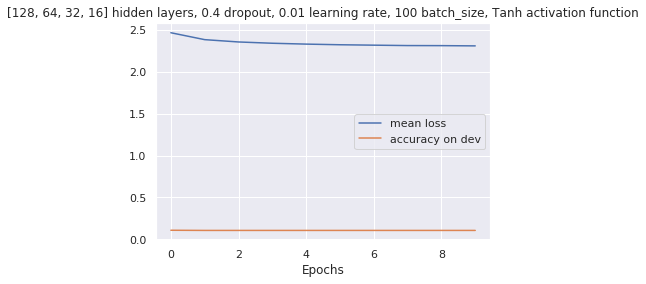

Using GPU!
Starting epoch: 0
mean loss:  2.6421524870629405
dev accuracy:  0.0915
Starting epoch: 1
mean loss:  2.536896513957603
dev accuracy:  0.0915
Starting epoch: 2
mean loss:  2.4770852303972433
dev accuracy:  0.0915
Starting epoch: 3
mean loss:  2.4431517918904624
dev accuracy:  0.0893
Starting epoch: 4
mean loss:  2.4147008727578556
dev accuracy:  0.0971
Starting epoch: 5
mean loss:  2.3997304907032087
dev accuracy:  0.0967
Starting epoch: 6
mean loss:  2.3857270642822863
dev accuracy:  0.0967
Starting epoch: 7
mean loss:  2.3794085652220485
dev accuracy:  0.0967
Starting epoch: 8
mean loss:  2.3706220411786845
dev accuracy:  0.1064
Starting epoch: 9
mean loss:  2.364296889772602
dev accuracy:  0.1064


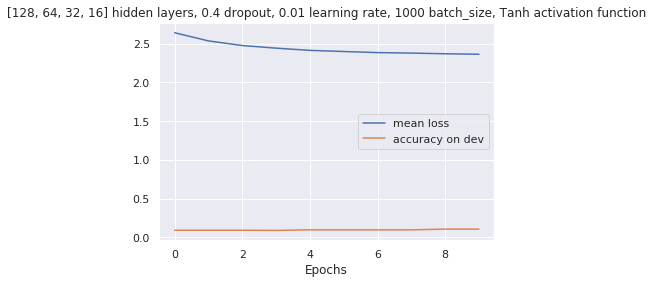

Using GPU!
Starting epoch: 0
mean loss:  2.343460746966131
dev accuracy:  0.0989
Starting epoch: 1
mean loss:  2.2979003313755277
dev accuracy:  0.1064
Starting epoch: 2
mean loss:  2.2968129516243816
dev accuracy:  0.1064
Starting epoch: 3
mean loss:  2.295888425778971
dev accuracy:  0.1064
Starting epoch: 4
mean loss:  2.2949034484046336
dev accuracy:  0.1064
Starting epoch: 5
mean loss:  2.2938362961887147
dev accuracy:  0.1064
Starting epoch: 6
mean loss:  2.2926657264219763
dev accuracy:  0.1064
Starting epoch: 7
mean loss:  2.2913661427413006
dev accuracy:  0.1064
Starting epoch: 8
mean loss:  2.28990586493831
dev accuracy:  0.1064
Starting epoch: 9
mean loss:  2.288244995206052
dev accuracy:  0.1064


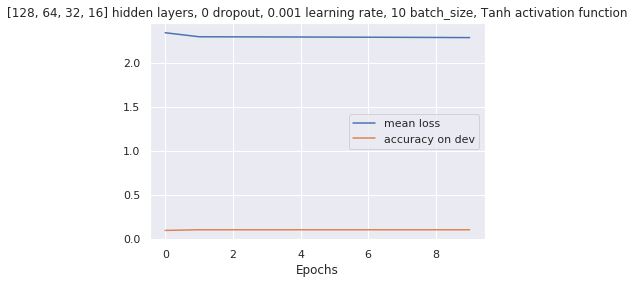

Using GPU!
Starting epoch: 0
mean loss:  2.652656563265833
dev accuracy:  0.103
Starting epoch: 1
mean loss:  2.4845625944956096
dev accuracy:  0.103
Starting epoch: 2
mean loss:  2.3993882304893996
dev accuracy:  0.103
Starting epoch: 3
mean loss:  2.3532434314072965
dev accuracy:  0.103
Starting epoch: 4
mean loss:  2.327748242490544
dev accuracy:  0.103
Starting epoch: 5
mean loss:  2.3136193262126867
dev accuracy:  0.103
Starting epoch: 6
mean loss:  2.305812717197898
dev accuracy:  0.1031
Starting epoch: 7
mean loss:  2.3015150133959072
dev accuracy:  0.1226
Starting epoch: 8
mean loss:  2.2991518641184427
dev accuracy:  0.1064
Starting epoch: 9
mean loss:  2.2978477359055995
dev accuracy:  0.1064


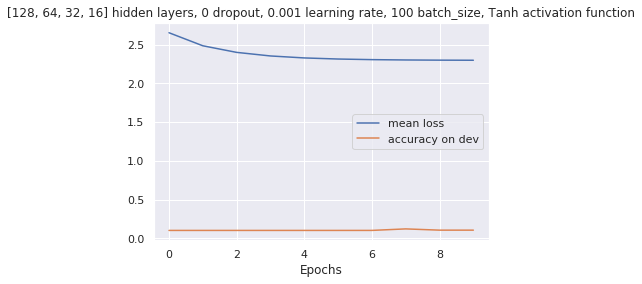

Using GPU!
Starting epoch: 0
mean loss:  2.4386757074617873
dev accuracy:  0.0967
Starting epoch: 1
mean loss:  2.420121005937165
dev accuracy:  0.0967
Starting epoch: 2
mean loss:  2.4041990953333237
dev accuracy:  0.0967
Starting epoch: 3
mean loss:  2.3904303709665933
dev accuracy:  0.0967
Starting epoch: 4
mean loss:  2.3784373928518856
dev accuracy:  0.0967
Starting epoch: 5
mean loss:  2.367920814775953
dev accuracy:  0.0967
Starting epoch: 6
mean loss:  2.3586418020958995
dev accuracy:  0.0967
Starting epoch: 7
mean loss:  2.3504076565013214
dev accuracy:  0.0967
Starting epoch: 8
mean loss:  2.3430623867932487
dev accuracy:  0.0967
Starting epoch: 9
mean loss:  2.336478032317816
dev accuracy:  0.0967


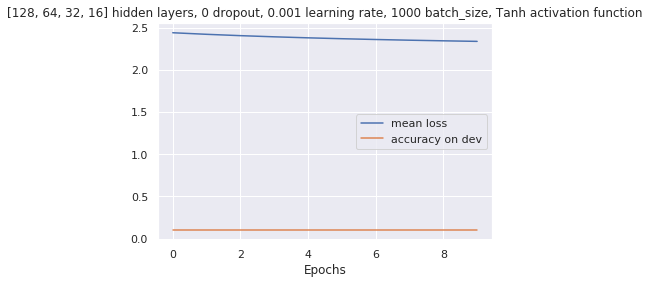

Using GPU!
Starting epoch: 0
mean loss:  2.41407698344002
dev accuracy:  0.1064
Starting epoch: 1
mean loss:  2.3526218972952693
dev accuracy:  0.1064
Starting epoch: 2
mean loss:  2.3448187578346604
dev accuracy:  0.1064
Starting epoch: 3
mean loss:  2.3336617708730594
dev accuracy:  0.1064
Starting epoch: 4
mean loss:  2.3287392481640086
dev accuracy:  0.1064
Starting epoch: 5
mean loss:  2.3211859133071457
dev accuracy:  0.1064
Starting epoch: 6
mean loss:  2.319501383784675
dev accuracy:  0.1064
Starting epoch: 7
mean loss:  2.317174462789632
dev accuracy:  0.1064
Starting epoch: 8
mean loss:  2.313902973342099
dev accuracy:  0.1064
Starting epoch: 9
mean loss:  2.312766006817176
dev accuracy:  0.1064


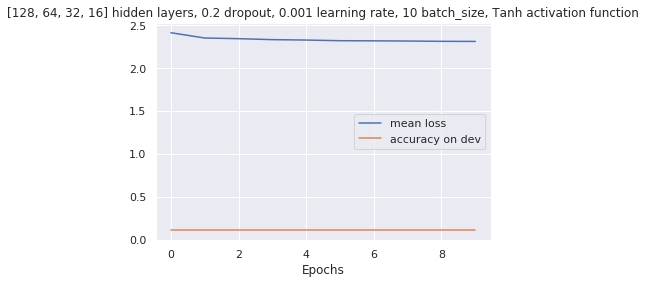

Using GPU!
Starting epoch: 0
mean loss:  2.4894439750564787
dev accuracy:  0.099
Starting epoch: 1
mean loss:  2.4178776488808578
dev accuracy:  0.099
Starting epoch: 2
mean loss:  2.384537969520706
dev accuracy:  0.099
Starting epoch: 3
mean loss:  2.3641589530213865
dev accuracy:  0.099
Starting epoch: 4
mean loss:  2.352287042164755
dev accuracy:  0.099
Starting epoch: 5
mean loss:  2.3460322316297275
dev accuracy:  0.099
Starting epoch: 6
mean loss:  2.340842363125312
dev accuracy:  0.1064
Starting epoch: 7
mean loss:  2.339066359335315
dev accuracy:  0.1064
Starting epoch: 8
mean loss:  2.3346038069315775
dev accuracy:  0.1064
Starting epoch: 9
mean loss:  2.3326711074082915
dev accuracy:  0.1064


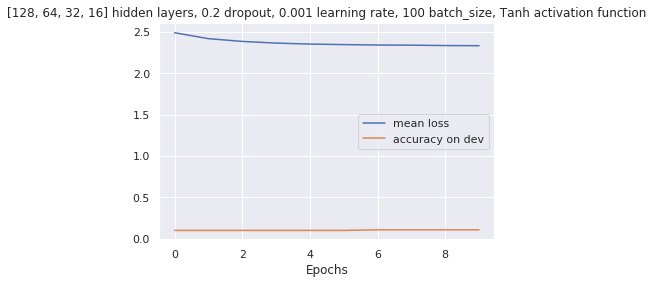

Using GPU!
Starting epoch: 0
mean loss:  2.4321299019981835
dev accuracy:  0.109
Starting epoch: 1
mean loss:  2.4231795750412286
dev accuracy:  0.109
Starting epoch: 2
mean loss:  2.4156352912678436
dev accuracy:  0.109
Starting epoch: 3
mean loss:  2.4087673355551327
dev accuracy:  0.109
Starting epoch: 4
mean loss:  2.403250114590514
dev accuracy:  0.109
Starting epoch: 5
mean loss:  2.394356306861429
dev accuracy:  0.109
Starting epoch: 6
mean loss:  2.3922051027709363
dev accuracy:  0.109
Starting epoch: 7
mean loss:  2.3853619425904515
dev accuracy:  0.109
Starting epoch: 8
mean loss:  2.3836880291209503
dev accuracy:  0.109
Starting epoch: 9
mean loss:  2.374881627512913
dev accuracy:  0.109


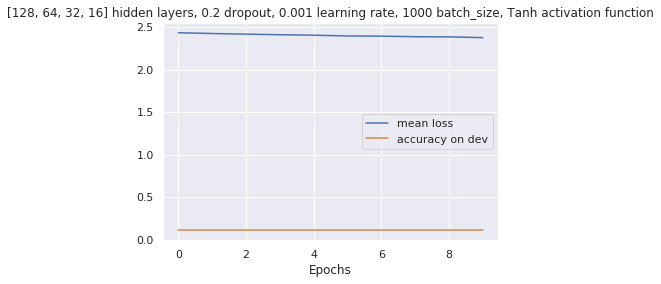

Using GPU!
Starting epoch: 0
mean loss:  2.507014131336254
dev accuracy:  0.1064
Starting epoch: 1
mean loss:  2.380841267440253
dev accuracy:  0.1064
Starting epoch: 2
mean loss:  2.3561485054444797
dev accuracy:  0.1064
Starting epoch: 3
mean loss:  2.342737396105221
dev accuracy:  0.1064
Starting epoch: 4
mean loss:  2.3306011255920662
dev accuracy:  0.1064
Starting epoch: 5
mean loss:  2.3252826673320426
dev accuracy:  0.1064
Starting epoch: 6
mean loss:  2.3190479901665997
dev accuracy:  0.1064
Starting epoch: 7
mean loss:  2.3181384770161295
dev accuracy:  0.1064
Starting epoch: 8
mean loss:  2.31536169606098
dev accuracy:  0.1064
Starting epoch: 9
mean loss:  2.3145860242166654
dev accuracy:  0.1064


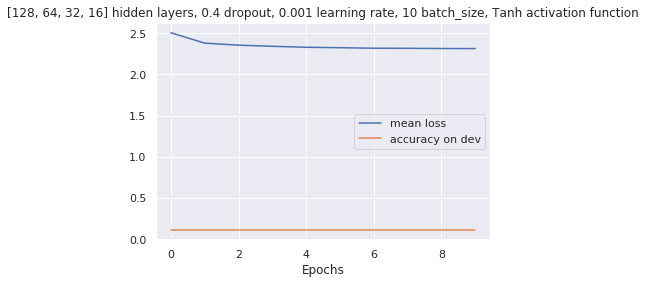

Using GPU!
Starting epoch: 0
mean loss:  2.5078524082244753
dev accuracy:  0.1009
Starting epoch: 1
mean loss:  2.459990832144153
dev accuracy:  0.1098
Starting epoch: 2
mean loss:  2.4369151915856704
dev accuracy:  0.1064
Starting epoch: 3
mean loss:  2.420116837629063
dev accuracy:  0.1064
Starting epoch: 4
mean loss:  2.405691824987263
dev accuracy:  0.1064
Starting epoch: 5
mean loss:  2.4037026616627584
dev accuracy:  0.1064
Starting epoch: 6
mean loss:  2.3944595397827393
dev accuracy:  0.1064
Starting epoch: 7
mean loss:  2.3900296445378286
dev accuracy:  0.1064
Starting epoch: 8
mean loss:  2.387339297882811
dev accuracy:  0.1064
Starting epoch: 9
mean loss:  2.378571638803996
dev accuracy:  0.1064


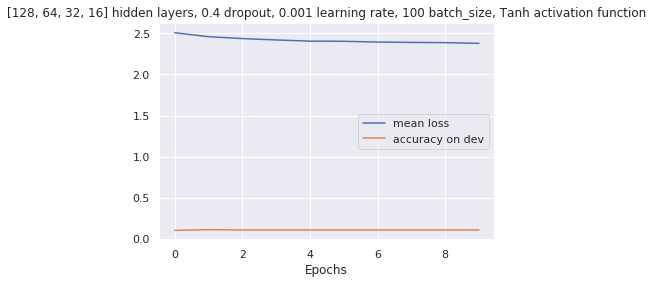

Using GPU!
Starting epoch: 0
mean loss:  2.7409150647182092
dev accuracy:  0.0915
Starting epoch: 1
mean loss:  2.7107036160487756
dev accuracy:  0.0915
Starting epoch: 2
mean loss:  2.6880975377325917
dev accuracy:  0.0915
Starting epoch: 3
mean loss:  2.6632888737846825
dev accuracy:  0.0915
Starting epoch: 4
mean loss:  2.637631696813247
dev accuracy:  0.0915
Starting epoch: 5
mean loss:  2.6241911953570796
dev accuracy:  0.0915
Starting epoch: 6
mean loss:  2.6023157811632345
dev accuracy:  0.0915
Starting epoch: 7
mean loss:  2.589737564909692
dev accuracy:  0.0915
Starting epoch: 8
mean loss:  2.5771581939622465
dev accuracy:  0.0915
Starting epoch: 9
mean loss:  2.5614674605575263
dev accuracy:  0.0915


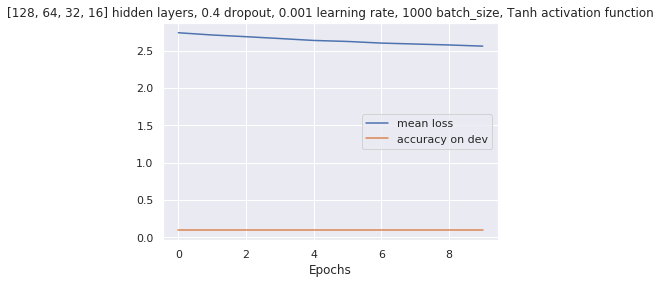

Using GPU!
Starting epoch: 0
mean loss:  2.223895001640274
dev accuracy:  0.3759
Starting epoch: 1
mean loss:  1.0720068812295809
dev accuracy:  0.8479
Starting epoch: 2
mean loss:  0.40631303207833713
dev accuracy:  0.9209
Starting epoch: 3
mean loss:  0.24314267769879763
dev accuracy:  0.9494
Starting epoch: 4
mean loss:  0.18087993887402273
dev accuracy:  0.9565
Starting epoch: 5
mean loss:  0.1447643308605685
dev accuracy:  0.9575
Starting epoch: 6
mean loss:  0.11993261110990118
dev accuracy:  0.9605
Starting epoch: 7
mean loss:  0.10119609135357446
dev accuracy:  0.9662
Starting epoch: 8
mean loss:  0.08560466074336888
dev accuracy:  0.9678
Starting epoch: 9
mean loss:  0.07333462492329022
dev accuracy:  0.969


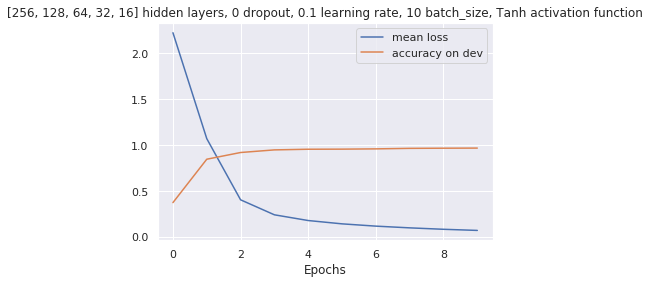

Using GPU!
Starting epoch: 0
mean loss:  2.3002583200108266
dev accuracy:  0.103
Starting epoch: 1
mean loss:  2.2960908617564066
dev accuracy:  0.103
Starting epoch: 2
mean loss:  2.2939125168585255
dev accuracy:  0.103
Starting epoch: 3
mean loss:  2.289103298606035
dev accuracy:  0.1708
Starting epoch: 4
mean loss:  2.26432777878767
dev accuracy:  0.1925
Starting epoch: 5
mean loss:  1.9789958437997661
dev accuracy:  0.3045
Starting epoch: 6
mean loss:  1.719083269437154
dev accuracy:  0.37
Starting epoch: 7
mean loss:  1.5286852923220027
dev accuracy:  0.4265
Starting epoch: 8
mean loss:  1.347815004651418
dev accuracy:  0.5048
Starting epoch: 9
mean loss:  1.1953035874994928
dev accuracy:  0.6244


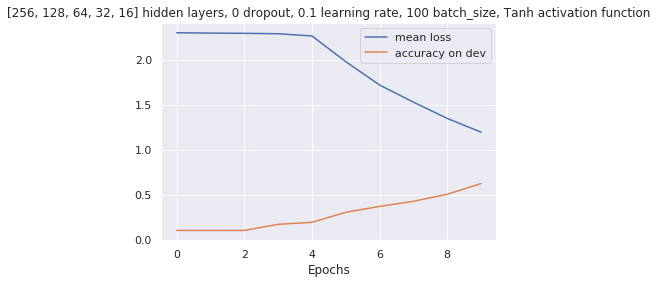

Using GPU!
Starting epoch: 0
mean loss:  2.2983334672217275
dev accuracy:  0.1064
Starting epoch: 1
mean loss:  2.256410182691088
dev accuracy:  0.1064
Starting epoch: 2
mean loss:  2.2558144354352763
dev accuracy:  0.1064
Starting epoch: 3
mean loss:  2.2557169035369276
dev accuracy:  0.1064
Starting epoch: 4
mean loss:  2.255618511461744
dev accuracy:  0.1064
Starting epoch: 5
mean loss:  2.2555189272936653
dev accuracy:  0.1064
Starting epoch: 6
mean loss:  2.2554173422794714
dev accuracy:  0.1064
Starting epoch: 7
mean loss:  2.2553141911824546
dev accuracy:  0.1064
Starting epoch: 8
mean loss:  2.2552090392393223
dev accuracy:  0.1064
Starting epoch: 9
mean loss:  2.255101577908385
dev accuracy:  0.1064


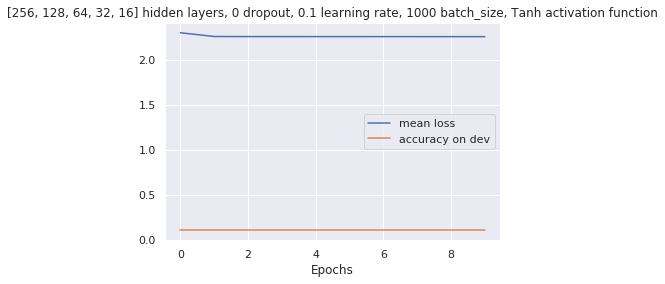

Using GPU!
Starting epoch: 0
mean loss:  2.3091591244052827
dev accuracy:  0.103
Starting epoch: 1
mean loss:  2.3032645332029023
dev accuracy:  0.103
Starting epoch: 2
mean loss:  2.3030139484588585
dev accuracy:  0.103
Starting epoch: 3
mean loss:  2.3026361966986486
dev accuracy:  0.103
Starting epoch: 4
mean loss:  2.3021105100478776
dev accuracy:  0.103
Starting epoch: 5
mean loss:  2.018191019264943
dev accuracy:  0.3373
Starting epoch: 6
mean loss:  1.621631993827427
dev accuracy:  0.5084
Starting epoch: 7
mean loss:  1.2230118758748518
dev accuracy:  0.7558
Starting epoch: 8
mean loss:  0.863962094647554
dev accuracy:  0.8606
Starting epoch: 9
mean loss:  0.6639969562696376
dev accuracy:  0.8982


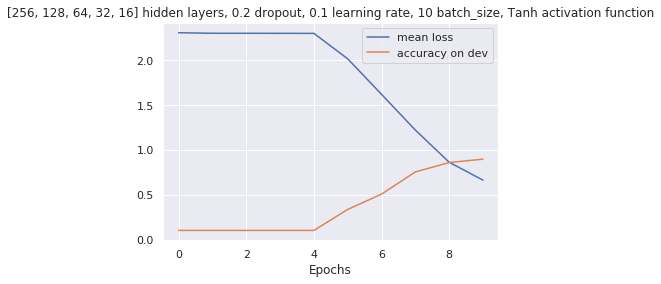

Using GPU!
Starting epoch: 0
mean loss:  2.325258239300665
dev accuracy:  0.1064
Starting epoch: 1
mean loss:  2.3040522120431985
dev accuracy:  0.1064
Starting epoch: 2
mean loss:  2.301033128045514
dev accuracy:  0.1064
Starting epoch: 3
mean loss:  2.2992643558098647
dev accuracy:  0.1064
Starting epoch: 4
mean loss:  2.298260108677451
dev accuracy:  0.1064
Starting epoch: 5
mean loss:  2.297930042186897
dev accuracy:  0.1064
Starting epoch: 6
mean loss:  2.297595680354836
dev accuracy:  0.1064
Starting epoch: 7
mean loss:  2.2978919199602807
dev accuracy:  0.1064
Starting epoch: 8
mean loss:  2.2975132546263066
dev accuracy:  0.1064
Starting epoch: 9
mean loss:  2.2969826947667165
dev accuracy:  0.1064


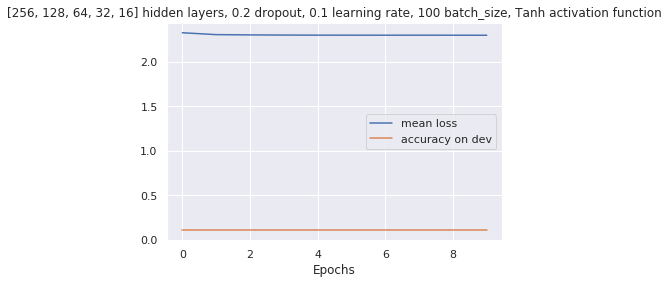

Using GPU!
Starting epoch: 0
mean loss:  2.344836454765469
dev accuracy:  0.1064
Starting epoch: 1
mean loss:  2.302073029910817
dev accuracy:  0.1064
Starting epoch: 2
mean loss:  2.2975351903952803
dev accuracy:  0.1064
Starting epoch: 3
mean loss:  2.288846403944726
dev accuracy:  0.1064
Starting epoch: 4
mean loss:  2.2806830219194
dev accuracy:  0.1064
Starting epoch: 5
mean loss:  2.2761325088201785
dev accuracy:  0.1064
Starting epoch: 6
mean loss:  2.2747152973623836
dev accuracy:  0.1064
Starting epoch: 7
mean loss:  2.273213035920087
dev accuracy:  0.1064
Starting epoch: 8
mean loss:  2.2717227000816194
dev accuracy:  0.1064
Starting epoch: 9
mean loss:  2.2698690236783494
dev accuracy:  0.1064


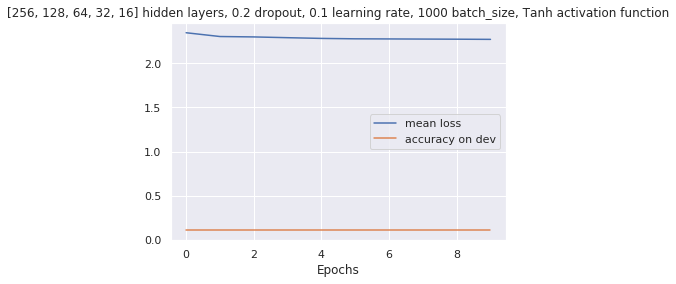

Using GPU!
Starting epoch: 0
mean loss:  2.310363371070445
dev accuracy:  0.103
Starting epoch: 1
mean loss:  2.3034279625836764
dev accuracy:  0.103
Starting epoch: 2
mean loss:  2.3032217747067194
dev accuracy:  0.103
Starting epoch: 3
mean loss:  2.3031594584022037
dev accuracy:  0.103
Starting epoch: 4
mean loss:  2.303108278118928
dev accuracy:  0.103
Starting epoch: 5
mean loss:  2.3030060910387196
dev accuracy:  0.103
Starting epoch: 6
mean loss:  2.3030140161561956
dev accuracy:  0.103
Starting epoch: 7
mean loss:  2.303005018751041
dev accuracy:  0.103
Starting epoch: 8
mean loss:  2.3030035556304265
dev accuracy:  0.103
Starting epoch: 9
mean loss:  2.3028488405655203
dev accuracy:  0.103


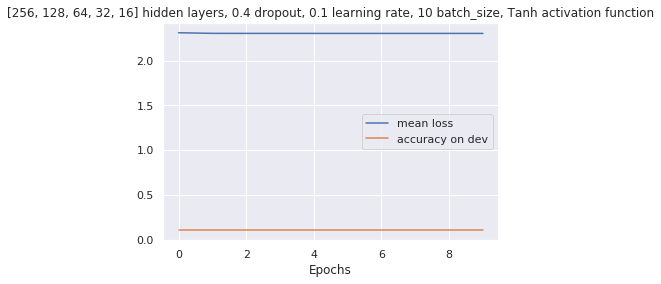

Using GPU!
Starting epoch: 0
mean loss:  2.3538135915935157
dev accuracy:  0.1064
Starting epoch: 1
mean loss:  2.3059925766524203
dev accuracy:  0.1064
Starting epoch: 2
mean loss:  2.3018210433914277
dev accuracy:  0.1064
Starting epoch: 3
mean loss:  2.29942250870421
dev accuracy:  0.1064
Starting epoch: 4
mean loss:  2.298654611477119
dev accuracy:  0.1064
Starting epoch: 5
mean loss:  2.2981183148191837
dev accuracy:  0.1064
Starting epoch: 6
mean loss:  2.2978543868797745
dev accuracy:  0.1064
Starting epoch: 7
mean loss:  2.297863414425574
dev accuracy:  0.1064
Starting epoch: 8
mean loss:  2.2974134276727
dev accuracy:  0.1064
Starting epoch: 9
mean loss:  2.297316603080003
dev accuracy:  0.1064


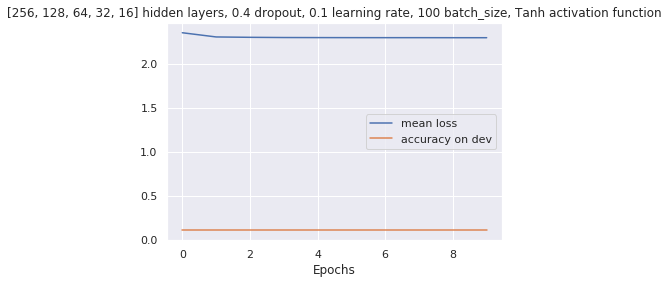

Using GPU!
Starting epoch: 0
mean loss:  2.4450398239434934
dev accuracy:  0.1064
Starting epoch: 1
mean loss:  2.3457944159414255
dev accuracy:  0.1064
Starting epoch: 2
mean loss:  2.317809782776178
dev accuracy:  0.1064
Starting epoch: 3
mean loss:  2.2992658147624896
dev accuracy:  0.1064
Starting epoch: 4
mean loss:  2.2889893241957124
dev accuracy:  0.1064
Starting epoch: 5
mean loss:  2.2841660789414946
dev accuracy:  0.1064
Starting epoch: 6
mean loss:  2.278464681961957
dev accuracy:  0.1064
Starting epoch: 7
mean loss:  2.2731533237532076
dev accuracy:  0.1064
Starting epoch: 8
mean loss:  2.2705433602426566
dev accuracy:  0.1064
Starting epoch: 9
mean loss:  2.268958708819221
dev accuracy:  0.1064


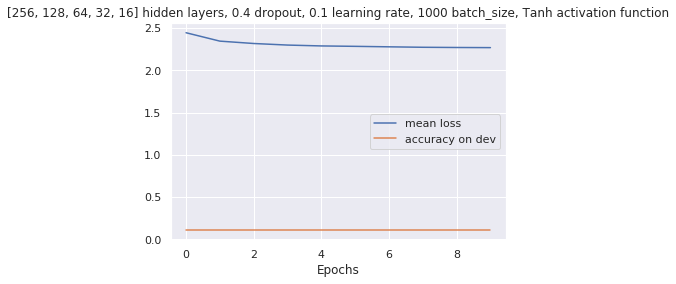

Using GPU!
Starting epoch: 0
mean loss:  2.3059531896740313
dev accuracy:  0.103
Starting epoch: 1
mean loss:  2.2996367072849315
dev accuracy:  0.103
Starting epoch: 2
mean loss:  2.2966562114556153
dev accuracy:  0.103
Starting epoch: 3
mean loss:  2.2871603291169618
dev accuracy:  0.2328
Starting epoch: 4
mean loss:  2.1710838437485616
dev accuracy:  0.2608
Starting epoch: 5
mean loss:  1.8155177672894758
dev accuracy:  0.3075
Starting epoch: 6
mean loss:  1.6910676109006562
dev accuracy:  0.3473
Starting epoch: 7
mean loss:  1.5970261526737086
dev accuracy:  0.4587
Starting epoch: 8
mean loss:  1.3410591725300989
dev accuracy:  0.5739
Starting epoch: 9
mean loss:  1.111467403719316
dev accuracy:  0.6472


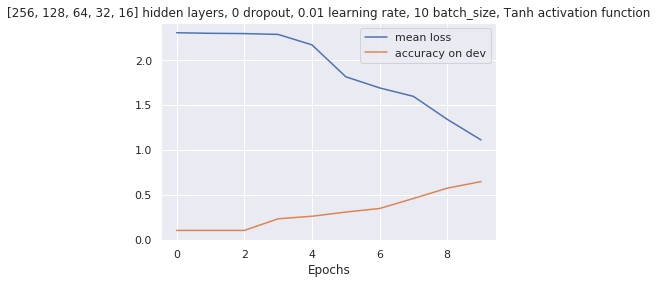

Using GPU!
Starting epoch: 0
mean loss:  2.315999901461268
dev accuracy:  0.1064
Starting epoch: 1
mean loss:  2.2964336543739914
dev accuracy:  0.1064
Starting epoch: 2
mean loss:  2.2963008595084
dev accuracy:  0.1064
Starting epoch: 3
mean loss:  2.296193830029455
dev accuracy:  0.1064
Starting epoch: 4
mean loss:  2.2960848970089605
dev accuracy:  0.1064
Starting epoch: 5
mean loss:  2.295973527455282
dev accuracy:  0.1064
Starting epoch: 6
mean loss:  2.2958593211488094
dev accuracy:  0.1064
Starting epoch: 7
mean loss:  2.2957418569309747
dev accuracy:  0.1064
Starting epoch: 8
mean loss:  2.2956206860418567
dev accuracy:  0.1064
Starting epoch: 9
mean loss:  2.295495350203828
dev accuracy:  0.1064


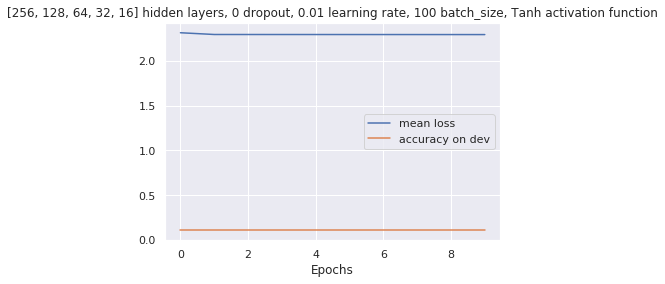

Using GPU!
Starting epoch: 0
mean loss:  2.579399020064111
dev accuracy:  0.0915
Starting epoch: 1
mean loss:  2.4073995141422047
dev accuracy:  0.0915
Starting epoch: 2
mean loss:  2.336621733272777
dev accuracy:  0.0976
Starting epoch: 3
mean loss:  2.301198318892834
dev accuracy:  0.0967
Starting epoch: 4
mean loss:  2.2817458732455385
dev accuracy:  0.0967
Starting epoch: 5
mean loss:  2.2706616298825133
dev accuracy:  0.0967
Starting epoch: 6
mean loss:  2.264286859362733
dev accuracy:  0.1015
Starting epoch: 7
mean loss:  2.260630308413038
dev accuracy:  0.109
Starting epoch: 8
mean loss:  2.258544028974047
dev accuracy:  0.109
Starting epoch: 9
mean loss:  2.2573583032570634
dev accuracy:  0.109


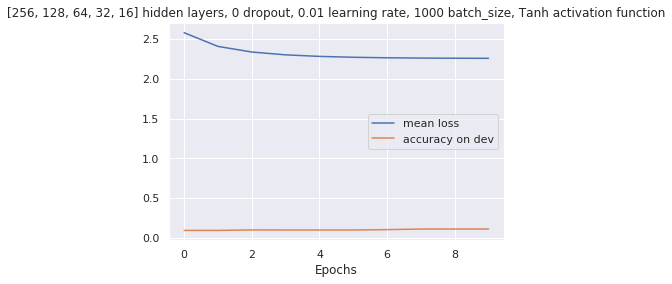

Using GPU!
Starting epoch: 0
mean loss:  2.3291700122309216
dev accuracy:  0.1064
Starting epoch: 1
mean loss:  2.3081342732517798
dev accuracy:  0.1064
Starting epoch: 2
mean loss:  2.304798836661348
dev accuracy:  0.1064
Starting epoch: 3
mean loss:  2.3033104351438825
dev accuracy:  0.1064
Starting epoch: 4
mean loss:  2.302199073658779
dev accuracy:  0.1064
Starting epoch: 5
mean loss:  2.30220968426287
dev accuracy:  0.1064
Starting epoch: 6
mean loss:  2.3019465921497706
dev accuracy:  0.1064
Starting epoch: 7
mean loss:  2.301534643175125
dev accuracy:  0.1064
Starting epoch: 8
mean loss:  2.3010357180444556
dev accuracy:  0.1064
Starting epoch: 9
mean loss:  2.3012477660794137
dev accuracy:  0.1064


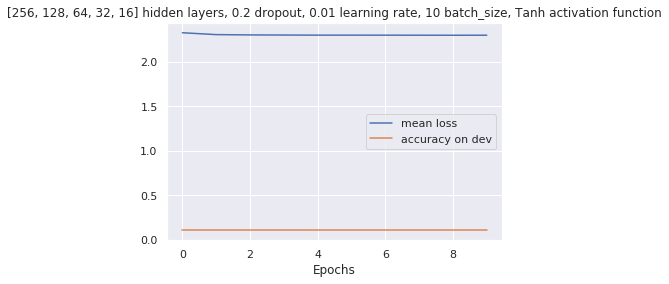

Using GPU!
Starting epoch: 0
mean loss:  2.4805529788582623
dev accuracy:  0.1217
Starting epoch: 1
mean loss:  2.3371466600490427
dev accuracy:  0.1064
Starting epoch: 2
mean loss:  2.32790151946321
dev accuracy:  0.1064
Starting epoch: 3
mean loss:  2.321763723910212
dev accuracy:  0.1064
Starting epoch: 4
mean loss:  2.31825535454436
dev accuracy:  0.1064
Starting epoch: 5
mean loss:  2.3165550684024714
dev accuracy:  0.1064
Starting epoch: 6
mean loss:  2.31417630484956
dev accuracy:  0.1064
Starting epoch: 7
mean loss:  2.3110736311076883
dev accuracy:  0.1064
Starting epoch: 8
mean loss:  2.3091485995256495
dev accuracy:  0.1064
Starting epoch: 9
mean loss:  2.307510855669033
dev accuracy:  0.1064


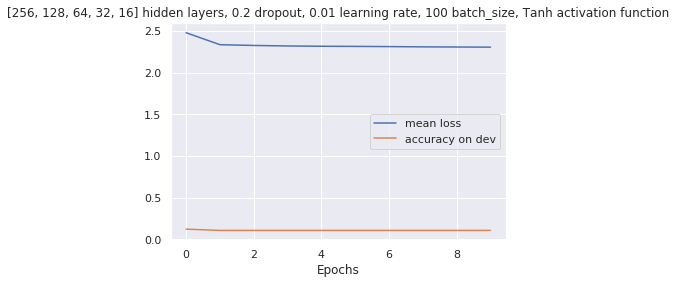

Using GPU!
Starting epoch: 0
mean loss:  2.5413762120639576
dev accuracy:  0.1064
Starting epoch: 1
mean loss:  2.441905554603128
dev accuracy:  0.1064
Starting epoch: 2
mean loss:  2.3860752816293753
dev accuracy:  0.1064
Starting epoch: 3
mean loss:  2.3559376211727368
dev accuracy:  0.1064
Starting epoch: 4
mean loss:  2.338112704894122
dev accuracy:  0.1064
Starting epoch: 5
mean loss:  2.323047114353554
dev accuracy:  0.1064
Starting epoch: 6
mean loss:  2.3151620556326473
dev accuracy:  0.1064
Starting epoch: 7
mean loss:  2.3102612214929916
dev accuracy:  0.1064
Starting epoch: 8
mean loss:  2.3092145966548547
dev accuracy:  0.1064
Starting epoch: 9
mean loss:  2.3045019916459624
dev accuracy:  0.1064


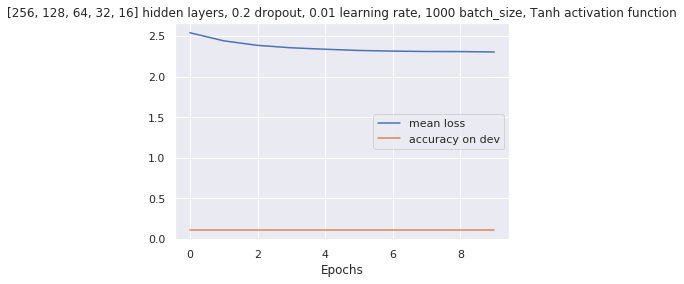

Using GPU!
Starting epoch: 0
mean loss:  2.3443682341784435
dev accuracy:  0.1064
Starting epoch: 1
mean loss:  2.3088917225462224
dev accuracy:  0.1064
Starting epoch: 2
mean loss:  2.3044195912690477
dev accuracy:  0.1064
Starting epoch: 3
mean loss:  2.303601336464885
dev accuracy:  0.1064
Starting epoch: 4
mean loss:  2.302730694600902
dev accuracy:  0.1064
Starting epoch: 5
mean loss:  2.302191921101406
dev accuracy:  0.1064
Starting epoch: 6
mean loss:  2.301969416688333
dev accuracy:  0.1064
Starting epoch: 7
mean loss:  2.302129438127954
dev accuracy:  0.1064
Starting epoch: 8
mean loss:  2.301644122974798
dev accuracy:  0.1064
Starting epoch: 9
mean loss:  2.3014484096398187
dev accuracy:  0.1064


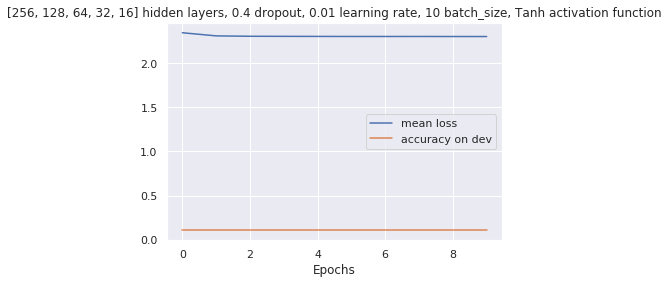

Using GPU!
Starting epoch: 0
mean loss:  2.4482075202012967
dev accuracy:  0.1064
Starting epoch: 1
mean loss:  2.3823485712329306
dev accuracy:  0.1064
Starting epoch: 2
mean loss:  2.355377944881569
dev accuracy:  0.1064
Starting epoch: 3
mean loss:  2.338786375022934
dev accuracy:  0.1064
Starting epoch: 4
mean loss:  2.3299310383444536
dev accuracy:  0.1064
Starting epoch: 5
mean loss:  2.324165847725021
dev accuracy:  0.1064
Starting epoch: 6
mean loss:  2.3167504736049445
dev accuracy:  0.1064
Starting epoch: 7
mean loss:  2.314044732057644
dev accuracy:  0.1064
Starting epoch: 8
mean loss:  2.3120022157946982
dev accuracy:  0.1064
Starting epoch: 9
mean loss:  2.3105936297875442
dev accuracy:  0.1064


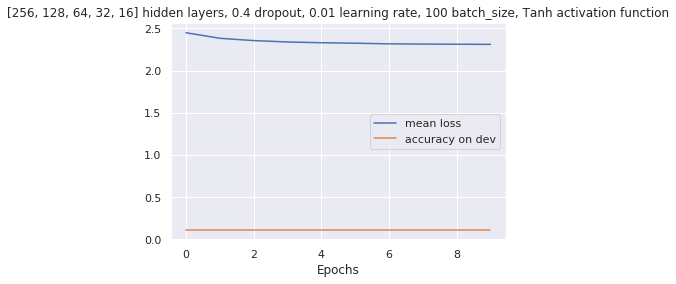

Using GPU!
Starting epoch: 0
mean loss:  2.639992251115687
dev accuracy:  0.099
Starting epoch: 1
mean loss:  2.5367305746265485
dev accuracy:  0.099
Starting epoch: 2
mean loss:  2.4847022692362466
dev accuracy:  0.099
Starting epoch: 3
mean loss:  2.450683967739928
dev accuracy:  0.099
Starting epoch: 4
mean loss:  2.430326873180913
dev accuracy:  0.0937
Starting epoch: 5
mean loss:  2.4153382170434092
dev accuracy:  0.0995
Starting epoch: 6
mean loss:  2.4057059708763573
dev accuracy:  0.109
Starting epoch: 7
mean loss:  2.395572115393246
dev accuracy:  0.1086
Starting epoch: 8
mean loss:  2.3880763287637747
dev accuracy:  0.1064
Starting epoch: 9
mean loss:  2.378163225510541
dev accuracy:  0.1064


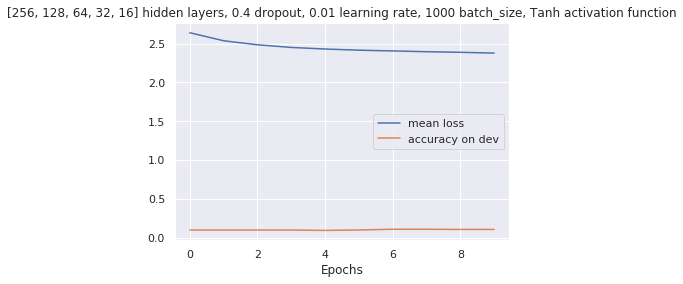

Using GPU!
Starting epoch: 0
mean loss:  2.333813692016426
dev accuracy:  0.1064
Starting epoch: 1
mean loss:  2.3010646313863905
dev accuracy:  0.1064
Starting epoch: 2
mean loss:  2.300873369818758
dev accuracy:  0.1064
Starting epoch: 3
mean loss:  2.3007900007389424
dev accuracy:  0.1064
Starting epoch: 4
mean loss:  2.300705580157391
dev accuracy:  0.1064
Starting epoch: 5
mean loss:  2.300620955005929
dev accuracy:  0.1064
Starting epoch: 6
mean loss:  2.300536090768449
dev accuracy:  0.1064
Starting epoch: 7
mean loss:  2.300450858629315
dev accuracy:  0.1064
Starting epoch: 8
mean loss:  2.300365081621966
dev accuracy:  0.1064
Starting epoch: 9
mean loss:  2.30027859517513
dev accuracy:  0.1064


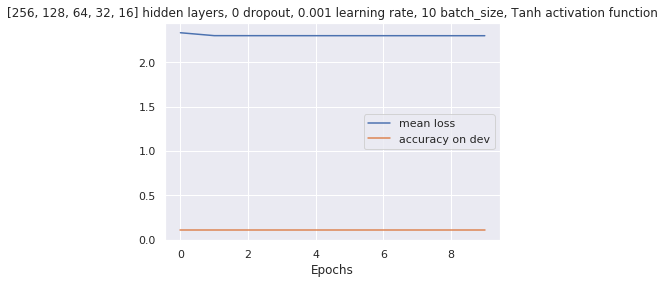

Using GPU!
Starting epoch: 0
mean loss:  2.6697988077076134
dev accuracy:  0.0961
Starting epoch: 1
mean loss:  2.4939341416615926
dev accuracy:  0.0961
Starting epoch: 2
mean loss:  2.4124513933520593
dev accuracy:  0.0961
Starting epoch: 3
mean loss:  2.367945412199892
dev accuracy:  0.0961
Starting epoch: 4
mean loss:  2.341509367415529
dev accuracy:  0.0961
Starting epoch: 5
mean loss:  2.325115998586019
dev accuracy:  0.0961
Starting epoch: 6
mean loss:  2.314715351173264
dev accuracy:  0.0961
Starting epoch: 7
mean loss:  2.3080449656336133
dev accuracy:  0.1064
Starting epoch: 8
mean loss:  2.3037561689784187
dev accuracy:  0.1064
Starting epoch: 9
mean loss:  2.301007110915498
dev accuracy:  0.1064


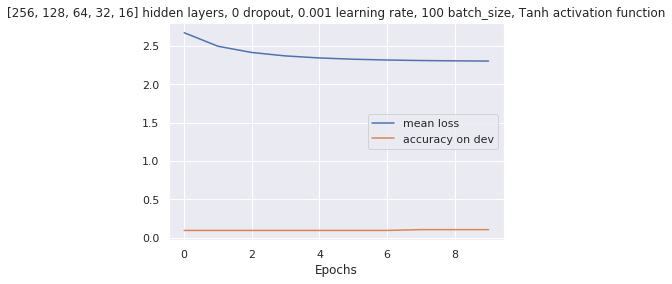

Using GPU!
Starting epoch: 0
mean loss:  2.5930853450999543
dev accuracy:  0.109
Starting epoch: 1
mean loss:  2.56890092644037
dev accuracy:  0.109
Starting epoch: 2
mean loss:  2.5467557065627155
dev accuracy:  0.109
Starting epoch: 3
mean loss:  2.526456346698836
dev accuracy:  0.109
Starting epoch: 4
mean loss:  2.5078278476116704
dev accuracy:  0.109
Starting epoch: 5
mean loss:  2.4907106745476817
dev accuracy:  0.109
Starting epoch: 6
mean loss:  2.47496117330065
dev accuracy:  0.109
Starting epoch: 7
mean loss:  2.4604510045519064
dev accuracy:  0.109
Starting epoch: 8
mean loss:  2.4470639883303176
dev accuracy:  0.109
Starting epoch: 9
mean loss:  2.434696132061528
dev accuracy:  0.109


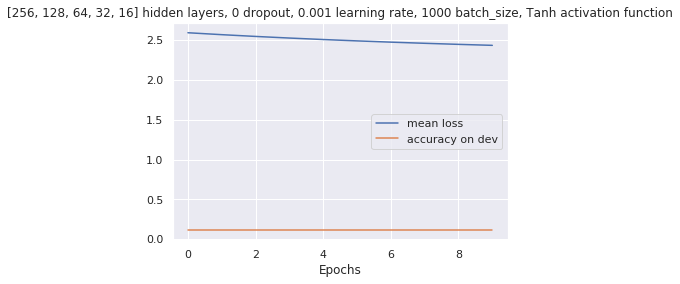

Using GPU!
Starting epoch: 0
mean loss:  2.4081289434976467
dev accuracy:  0.1064
Starting epoch: 1
mean loss:  2.347018415916922
dev accuracy:  0.1064
Starting epoch: 2
mean loss:  2.3337062309084358
dev accuracy:  0.1064
Starting epoch: 3
mean loss:  2.3327363522332614
dev accuracy:  0.1064
Starting epoch: 4
mean loss:  2.32512811183262
dev accuracy:  0.1064
Starting epoch: 5
mean loss:  2.3210241223449493
dev accuracy:  0.1064
Starting epoch: 6
mean loss:  2.3187842680868735
dev accuracy:  0.1064
Starting epoch: 7
mean loss:  2.3153816489929246
dev accuracy:  0.1064
Starting epoch: 8
mean loss:  2.3158975485157334
dev accuracy:  0.1064
Starting epoch: 9
mean loss:  2.3131103895111482
dev accuracy:  0.1064


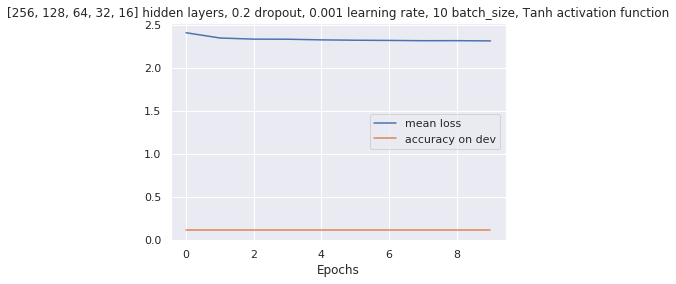

Using GPU!
Starting epoch: 0
mean loss:  2.5131667835745746
dev accuracy:  0.103
Starting epoch: 1
mean loss:  2.4404522254319487
dev accuracy:  0.103
Starting epoch: 2
mean loss:  2.401646090600781
dev accuracy:  0.103
Starting epoch: 3
mean loss:  2.379486143945934
dev accuracy:  0.103
Starting epoch: 4
mean loss:  2.369313835383889
dev accuracy:  0.103
Starting epoch: 5
mean loss:  2.3581873623434895
dev accuracy:  0.103
Starting epoch: 6
mean loss:  2.3525025725602626
dev accuracy:  0.103
Starting epoch: 7
mean loss:  2.3514526161605014
dev accuracy:  0.1064
Starting epoch: 8
mean loss:  2.3492085162750973
dev accuracy:  0.1064
Starting epoch: 9
mean loss:  2.3447823610134466
dev accuracy:  0.1064


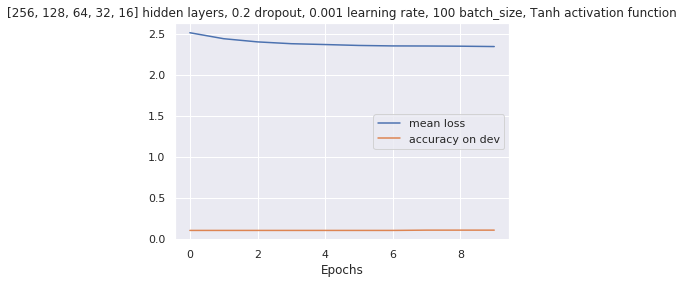

Using GPU!
Starting epoch: 0
mean loss:  2.621668923134897
dev accuracy:  0.0967
Starting epoch: 1
mean loss:  2.602243839525709
dev accuracy:  0.0967
Starting epoch: 2
mean loss:  2.5890996175653793
dev accuracy:  0.0967
Starting epoch: 3
mean loss:  2.5691059336942783
dev accuracy:  0.0967
Starting epoch: 4
mean loss:  2.5558469248752966
dev accuracy:  0.0967
Starting epoch: 5
mean loss:  2.540432892593683
dev accuracy:  0.0967
Starting epoch: 6
mean loss:  2.5274470179688695
dev accuracy:  0.0967
Starting epoch: 7
mean loss:  2.51596765424691
dev accuracy:  0.0967
Starting epoch: 8
mean loss:  2.5036286746754364
dev accuracy:  0.0967
Starting epoch: 9
mean loss:  2.495337766759536
dev accuracy:  0.0967


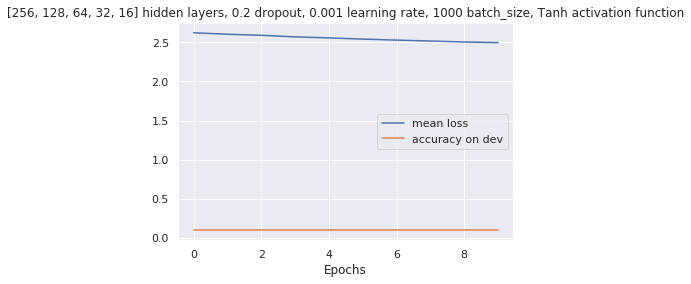

Using GPU!
Starting epoch: 0
mean loss:  2.4781498691125576
dev accuracy:  0.1009
Starting epoch: 1
mean loss:  2.3867992823945356
dev accuracy:  0.1064
Starting epoch: 2
mean loss:  2.3586956773178978
dev accuracy:  0.1064
Starting epoch: 3
mean loss:  2.34136880118712
dev accuracy:  0.1064
Starting epoch: 4
mean loss:  2.3328922379853556
dev accuracy:  0.1064
Starting epoch: 5
mean loss:  2.325695775218354
dev accuracy:  0.1064
Starting epoch: 6
mean loss:  2.3223458006724766
dev accuracy:  0.1064
Starting epoch: 7
mean loss:  2.3155699948076487
dev accuracy:  0.1064
Starting epoch: 8
mean loss:  2.3158282905167473
dev accuracy:  0.1064
Starting epoch: 9
mean loss:  2.314053159598183
dev accuracy:  0.1064


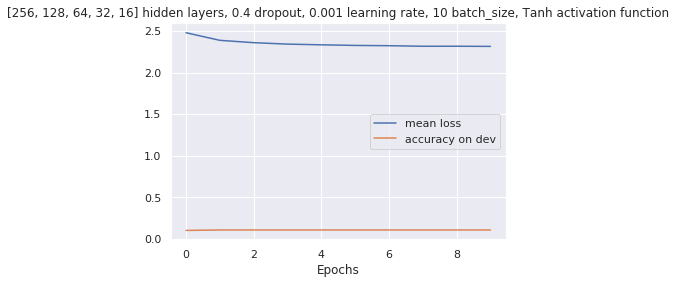

Using GPU!
Starting epoch: 0
mean loss:  2.6310926554445735
dev accuracy:  0.0529
Starting epoch: 1
mean loss:  2.552021376387088
dev accuracy:  0.099
Starting epoch: 2
mean loss:  2.508329102617062
dev accuracy:  0.099
Starting epoch: 3
mean loss:  2.4725841728751057
dev accuracy:  0.099
Starting epoch: 4
mean loss:  2.4553517067503785
dev accuracy:  0.099
Starting epoch: 5
mean loss:  2.440305865453389
dev accuracy:  0.099
Starting epoch: 6
mean loss:  2.4296803269795553
dev accuracy:  0.099
Starting epoch: 7
mean loss:  2.4166432597680005
dev accuracy:  0.099
Starting epoch: 8
mean loss:  2.408574277531363
dev accuracy:  0.099
Starting epoch: 9
mean loss:  2.4046941507838206
dev accuracy:  0.1064


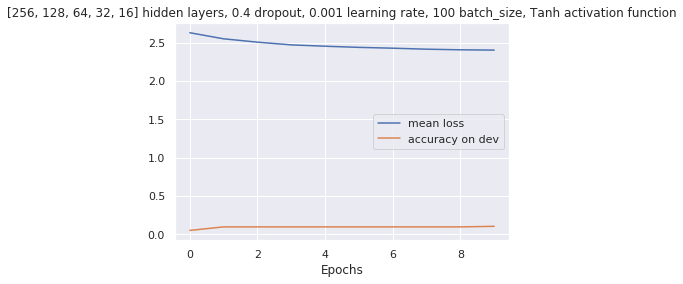

Using GPU!
Starting epoch: 0
mean loss:  2.6268663780362
dev accuracy:  0.1064
Starting epoch: 1
mean loss:  2.6140815884459254
dev accuracy:  0.1064
Starting epoch: 2
mean loss:  2.598780071034151
dev accuracy:  0.1064
Starting epoch: 3
mean loss:  2.5856064908644734
dev accuracy:  0.1064
Starting epoch: 4
mean loss:  2.562564298218372
dev accuracy:  0.1064
Starting epoch: 5
mean loss:  2.54573842123443
dev accuracy:  0.1064
Starting epoch: 6
mean loss:  2.539974759606754
dev accuracy:  0.1064
Starting epoch: 7
mean loss:  2.528530948302325
dev accuracy:  0.1064
Starting epoch: 8
mean loss:  2.519802130904852
dev accuracy:  0.1064
Starting epoch: 9
mean loss:  2.5048356430203307
dev accuracy:  0.1064


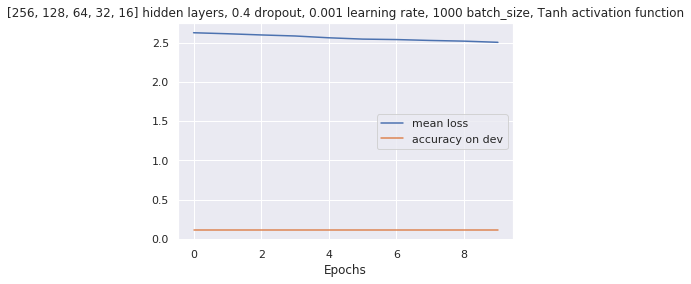

Using GPU!
Starting epoch: 0
mean loss:  2.3077744300116114
dev accuracy:  0.103
Starting epoch: 1
mean loss:  2.177261735148202
dev accuracy:  0.2719
Starting epoch: 2
mean loss:  1.452783382521751
dev accuracy:  0.5093
Starting epoch: 3
mean loss:  0.9982142711869837
dev accuracy:  0.7698
Starting epoch: 4
mean loss:  0.5601247920632553
dev accuracy:  0.8803
Starting epoch: 5
mean loss:  0.3546981394203025
dev accuracy:  0.9107
Starting epoch: 6
mean loss:  0.2560943197621
dev accuracy:  0.9299
Starting epoch: 7
mean loss:  0.20046709468794946
dev accuracy:  0.9455
Starting epoch: 8
mean loss:  0.1649184909310632
dev accuracy:  0.9586
Starting epoch: 9
mean loss:  0.1395072773538628
dev accuracy:  0.9605


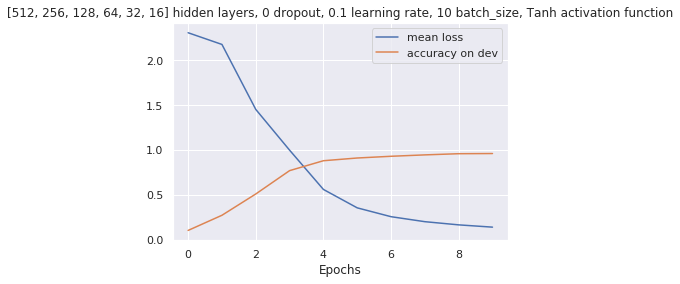

Using GPU!
Starting epoch: 0
mean loss:  2.3028811746966578
dev accuracy:  0.103
Starting epoch: 1
mean loss:  2.297896937695806
dev accuracy:  0.103
Starting epoch: 2
mean loss:  2.2977182403533996
dev accuracy:  0.103
Starting epoch: 3
mean loss:  2.2975343396801673
dev accuracy:  0.103
Starting epoch: 4
mean loss:  2.2973388711849374
dev accuracy:  0.103
Starting epoch: 5
mean loss:  2.2971240289196997
dev accuracy:  0.103
Starting epoch: 6
mean loss:  2.29687929914859
dev accuracy:  0.103
Starting epoch: 7
mean loss:  2.296589050940173
dev accuracy:  0.103
Starting epoch: 8
mean loss:  2.2962286872064284
dev accuracy:  0.103
Starting epoch: 9
mean loss:  2.2957556542760122
dev accuracy:  0.103


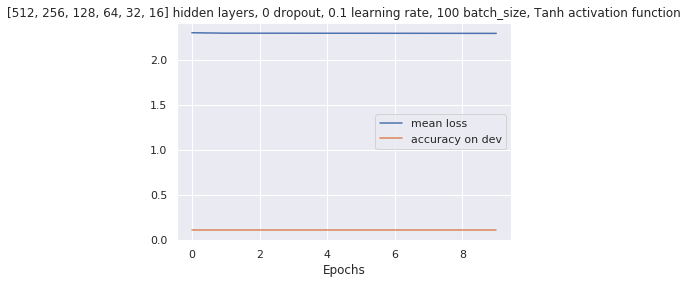

Using GPU!
Starting epoch: 0
mean loss:  2.2912799283569933
dev accuracy:  0.1064
Starting epoch: 1
mean loss:  2.2561627462798475
dev accuracy:  0.1064
Starting epoch: 2
mean loss:  2.2560211396684835
dev accuracy:  0.1064
Starting epoch: 3
mean loss:  2.256006343691957
dev accuracy:  0.1064
Starting epoch: 4
mean loss:  2.2559912812476064
dev accuracy:  0.1064
Starting epoch: 5
mean loss:  2.2559760785570333
dev accuracy:  0.1064
Starting epoch: 6
mean loss:  2.2559605205760285
dev accuracy:  0.1064
Starting epoch: 7
mean loss:  2.2559451963387285
dev accuracy:  0.1064
Starting epoch: 8
mean loss:  2.2559296804315903
dev accuracy:  0.1064
Starting epoch: 9
mean loss:  2.255914337494794
dev accuracy:  0.1064


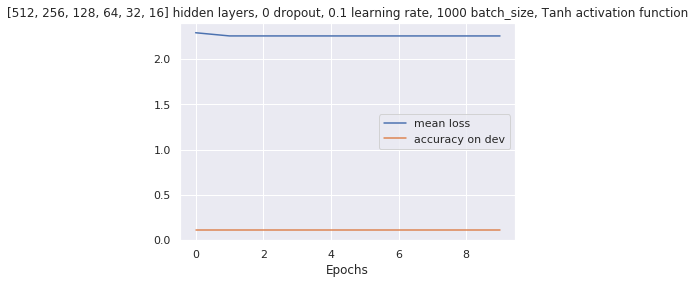

Using GPU!
Starting epoch: 0
mean loss:  2.311186499987524
dev accuracy:  0.103
Starting epoch: 1
mean loss:  2.303375784765837
dev accuracy:  0.103
Starting epoch: 2
mean loss:  2.3031918121990835
dev accuracy:  0.103
Starting epoch: 3
mean loss:  2.3030806194184135
dev accuracy:  0.103
Starting epoch: 4
mean loss:  2.3030986547041024
dev accuracy:  0.103
Starting epoch: 5
mean loss:  2.3030707436164746
dev accuracy:  0.103
Starting epoch: 6
mean loss:  2.302936472527577
dev accuracy:  0.103
Starting epoch: 7
mean loss:  2.3029327656216347
dev accuracy:  0.103
Starting epoch: 8
mean loss:  2.3030267323858378
dev accuracy:  0.103
Starting epoch: 9
mean loss:  2.3029476088348613
dev accuracy:  0.103


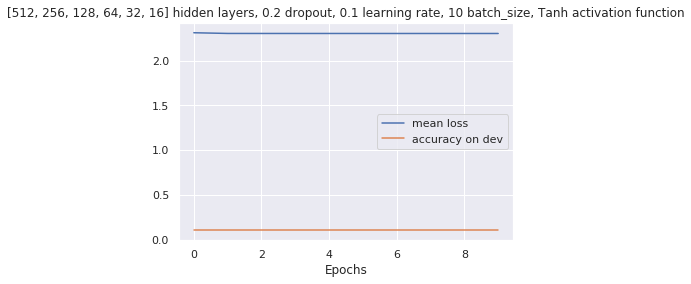

Using GPU!
Starting epoch: 0
mean loss:  2.3351824664308163
dev accuracy:  0.1064
Starting epoch: 1
mean loss:  2.3041992453995817
dev accuracy:  0.1064
Starting epoch: 2
mean loss:  2.301094966020413
dev accuracy:  0.1064
Starting epoch: 3
mean loss:  2.300049577644485
dev accuracy:  0.1064
Starting epoch: 4
mean loss:  2.299031425616936
dev accuracy:  0.1064
Starting epoch: 5
mean loss:  2.2983351458094554
dev accuracy:  0.1064
Starting epoch: 6
mean loss:  2.297866313043469
dev accuracy:  0.1064
Starting epoch: 7
mean loss:  2.2978097569204854
dev accuracy:  0.1064
Starting epoch: 8
mean loss:  2.2980594463691024
dev accuracy:  0.1064
Starting epoch: 9
mean loss:  2.2976340429035726
dev accuracy:  0.1064


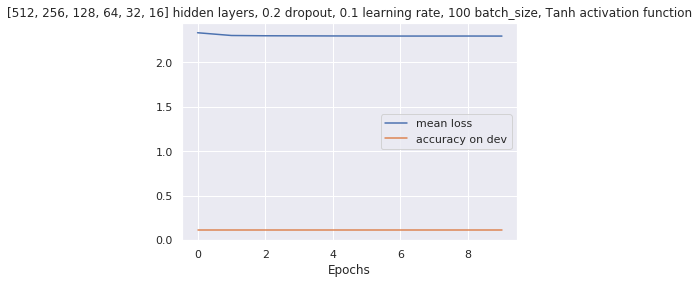

Using GPU!
Starting epoch: 0
mean loss:  2.3425394320020487
dev accuracy:  0.1064
Starting epoch: 1
mean loss:  2.29858211442536
dev accuracy:  0.1064
Starting epoch: 2
mean loss:  2.2906812593048693
dev accuracy:  0.1064
Starting epoch: 3
mean loss:  2.2843280259300682
dev accuracy:  0.1064
Starting epoch: 4
mean loss:  2.2797551201839075
dev accuracy:  0.1064
Starting epoch: 5
mean loss:  2.2763396898905435
dev accuracy:  0.1064
Starting epoch: 6
mean loss:  2.274396335377413
dev accuracy:  0.1064
Starting epoch: 7
mean loss:  2.271274758320229
dev accuracy:  0.1064
Starting epoch: 8
mean loss:  2.269693711224724
dev accuracy:  0.1064
Starting epoch: 9
mean loss:  2.2677254069085215
dev accuracy:  0.1064


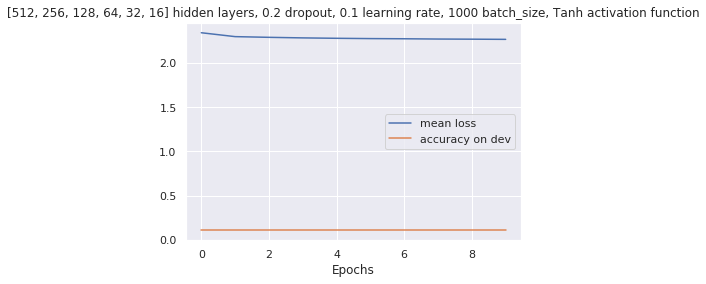

Using GPU!
Starting epoch: 0
mean loss:  2.3107392724526687
dev accuracy:  0.103
Starting epoch: 1
mean loss:  2.3036740353955576
dev accuracy:  0.103
Starting epoch: 2
mean loss:  2.303173464075419
dev accuracy:  0.103
Starting epoch: 3
mean loss:  2.3031022102921943
dev accuracy:  0.103
Starting epoch: 4
mean loss:  2.302977410680507
dev accuracy:  0.103
Starting epoch: 5
mean loss:  2.3029353334960447
dev accuracy:  0.103
Starting epoch: 6
mean loss:  2.302967786931963
dev accuracy:  0.103
Starting epoch: 7
mean loss:  2.303042232406256
dev accuracy:  0.103
Starting epoch: 8
mean loss:  2.302969426161002
dev accuracy:  0.103
Starting epoch: 9
mean loss:  2.3029376199020906
dev accuracy:  0.103


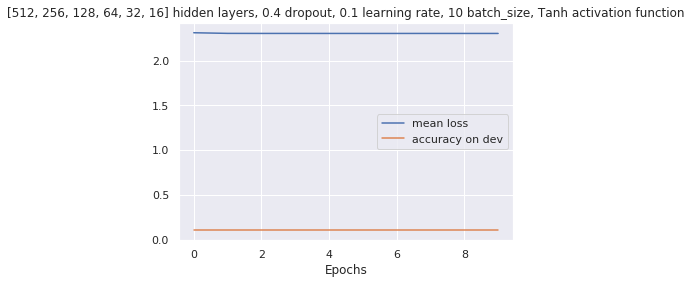

Using GPU!
Starting epoch: 0
mean loss:  2.349034667728904
dev accuracy:  0.1064
Starting epoch: 1
mean loss:  2.305627895686441
dev accuracy:  0.1064
Starting epoch: 2
mean loss:  2.3001247703910113
dev accuracy:  0.1064
Starting epoch: 3
mean loss:  2.2993677628492404
dev accuracy:  0.1064
Starting epoch: 4
mean loss:  2.2985397089503246
dev accuracy:  0.1064
Starting epoch: 5
mean loss:  2.298436450863075
dev accuracy:  0.1064
Starting epoch: 6
mean loss:  2.297968010702533
dev accuracy:  0.1064
Starting epoch: 7
mean loss:  2.2976920204962084
dev accuracy:  0.1064
Starting epoch: 8
mean loss:  2.2976812559687447
dev accuracy:  0.1064
Starting epoch: 9
mean loss:  2.297507932800019
dev accuracy:  0.1064


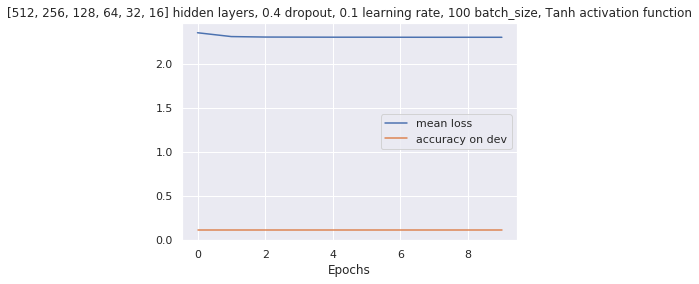

Using GPU!
Starting epoch: 0
mean loss:  2.3855145678800693
dev accuracy:  0.1064
Starting epoch: 1
mean loss:  2.3153466103123685
dev accuracy:  0.1064
Starting epoch: 2
mean loss:  2.295850071252561
dev accuracy:  0.1064
Starting epoch: 3
mean loss:  2.2861254495732926
dev accuracy:  0.1064
Starting epoch: 4
mean loss:  2.2792814198662255
dev accuracy:  0.1064
Starting epoch: 5
mean loss:  2.275154071695664
dev accuracy:  0.1064
Starting epoch: 6
mean loss:  2.2723948721792184
dev accuracy:  0.1064
Starting epoch: 7
mean loss:  2.2701449768216
dev accuracy:  0.1064
Starting epoch: 8
mean loss:  2.269502985711191
dev accuracy:  0.1064
Starting epoch: 9
mean loss:  2.2673281127331304
dev accuracy:  0.1064


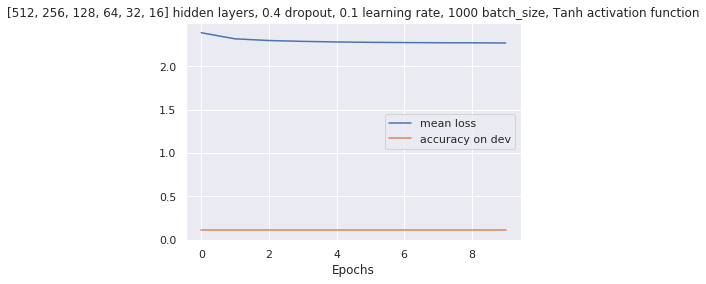

Using GPU!
Starting epoch: 0
mean loss:  2.3046578755499816
dev accuracy:  0.103
Starting epoch: 1
mean loss:  2.301922933789783
dev accuracy:  0.103
Starting epoch: 2
mean loss:  2.3016775893917134
dev accuracy:  0.103
Starting epoch: 3
mean loss:  2.301394280565426
dev accuracy:  0.103
Starting epoch: 4
mean loss:  2.3010471844954434
dev accuracy:  0.103
Starting epoch: 5
mean loss:  2.3005914599913115
dev accuracy:  0.103
Starting epoch: 6
mean loss:  2.299939081731307
dev accuracy:  0.103
Starting epoch: 7
mean loss:  2.2988883726741287
dev accuracy:  0.103
Starting epoch: 8
mean loss:  2.296854793822806
dev accuracy:  0.1035
Starting epoch: 9
mean loss:  2.2912025482648373
dev accuracy:  0.1975


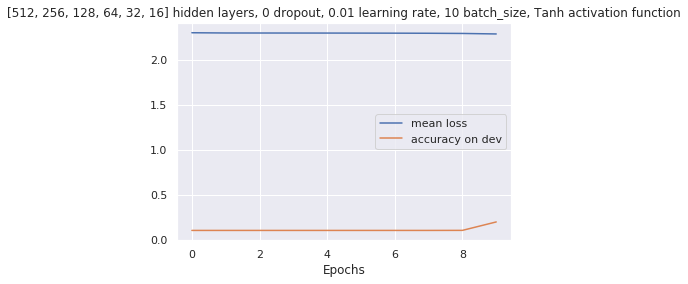

Using GPU!
Starting epoch: 0
mean loss:  2.3194350068440692
dev accuracy:  0.1064
Starting epoch: 1
mean loss:  2.296803907006087
dev accuracy:  0.1064
Starting epoch: 2
mean loss:  2.2965565013314437
dev accuracy:  0.1064
Starting epoch: 3
mean loss:  2.2965419363832758
dev accuracy:  0.1064
Starting epoch: 4
mean loss:  2.2965309696045226
dev accuracy:  0.1064
Starting epoch: 5
mean loss:  2.296520121321231
dev accuracy:  0.1064
Starting epoch: 6
mean loss:  2.2965093068258016
dev accuracy:  0.1064
Starting epoch: 7
mean loss:  2.2964984818608936
dev accuracy:  0.1064
Starting epoch: 8
mean loss:  2.296487578374897
dev accuracy:  0.1064
Starting epoch: 9
mean loss:  2.296476618258539
dev accuracy:  0.1064


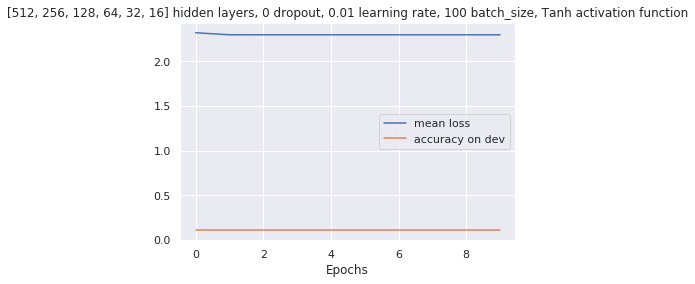

Using GPU!
Starting epoch: 0
mean loss:  2.464539752287023
dev accuracy:  0.1064
Starting epoch: 1
mean loss:  2.384622522428924
dev accuracy:  0.1064
Starting epoch: 2
mean loss:  2.3390903753392838
dev accuracy:  0.1064
Starting epoch: 3
mean loss:  2.311078576480641
dev accuracy:  0.1064
Starting epoch: 4
mean loss:  2.2930630375357235
dev accuracy:  0.1064
Starting epoch: 5
mean loss:  2.281146535686418
dev accuracy:  0.1064
Starting epoch: 6
mean loss:  2.2731241572136973
dev accuracy:  0.1064
Starting epoch: 7
mean loss:  2.267668191124411
dev accuracy:  0.1064
Starting epoch: 8
mean loss:  2.263940455866795
dev accuracy:  0.1064
Starting epoch: 9
mean loss:  2.2613904289170805
dev accuracy:  0.1064


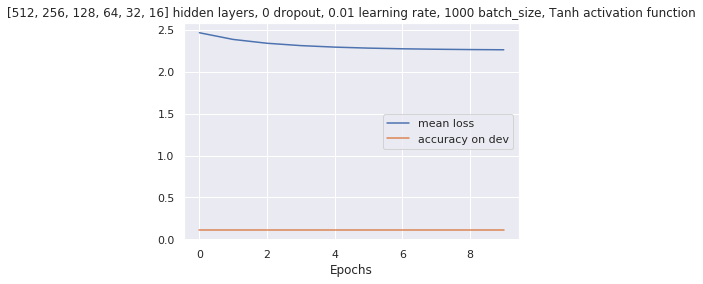

Using GPU!
Starting epoch: 0
mean loss:  2.3333881981156868
dev accuracy:  0.103
Starting epoch: 1
mean loss:  2.3099697209720347
dev accuracy:  0.1064
Starting epoch: 2
mean loss:  2.3061024461405633
dev accuracy:  0.1064
Starting epoch: 3
mean loss:  2.3040285850376923
dev accuracy:  0.1064
Starting epoch: 4
mean loss:  2.3032380495756013
dev accuracy:  0.1064
Starting epoch: 5
mean loss:  2.302627385556519
dev accuracy:  0.1064
Starting epoch: 6
mean loss:  2.3024785461437225
dev accuracy:  0.1064
Starting epoch: 7
mean loss:  2.3022450394831617
dev accuracy:  0.1064
Starting epoch: 8
mean loss:  2.301741472222142
dev accuracy:  0.1064
Starting epoch: 9
mean loss:  2.3015478784335754
dev accuracy:  0.1064


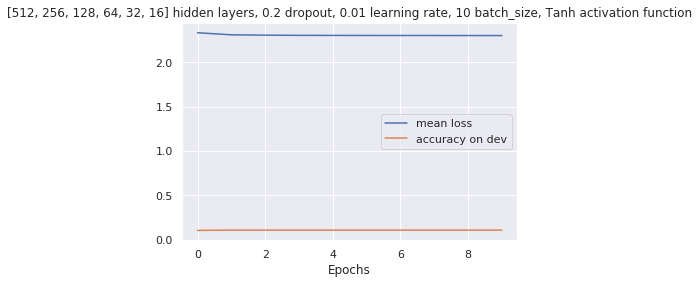

Using GPU!
Starting epoch: 0
mean loss:  2.3917614842603308
dev accuracy:  0.1064
Starting epoch: 1
mean loss:  2.3383425471787445
dev accuracy:  0.1064
Starting epoch: 2
mean loss:  2.3316077614972692
dev accuracy:  0.1064
Starting epoch: 3
mean loss:  2.326852916005605
dev accuracy:  0.1064
Starting epoch: 4
mean loss:  2.3201253442707177
dev accuracy:  0.1064
Starting epoch: 5
mean loss:  2.319136940314622
dev accuracy:  0.1064
Starting epoch: 6
mean loss:  2.3144109934389947
dev accuracy:  0.1064
Starting epoch: 7
mean loss:  2.313036756839105
dev accuracy:  0.1064
Starting epoch: 8
mean loss:  2.311228982464758
dev accuracy:  0.1064
Starting epoch: 9
mean loss:  2.3098951394924385
dev accuracy:  0.1064


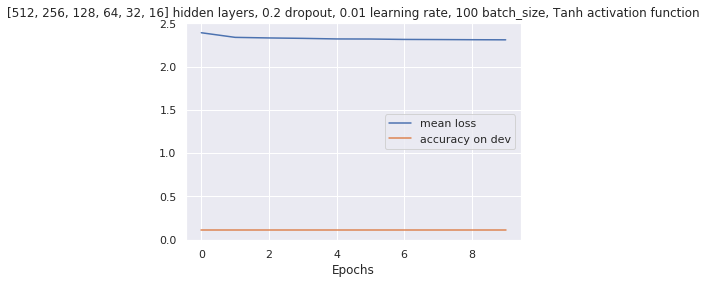

Using GPU!
Starting epoch: 0
mean loss:  2.642211530722824
dev accuracy:  0.0983
Starting epoch: 1
mean loss:  2.4981965364194383
dev accuracy:  0.0967
Starting epoch: 2
mean loss:  2.41871781910167
dev accuracy:  0.0967
Starting epoch: 3
mean loss:  2.371994846007403
dev accuracy:  0.0967
Starting epoch: 4
mean loss:  2.3429390402401196
dev accuracy:  0.0967
Starting epoch: 5
mean loss:  2.3238313572079528
dev accuracy:  0.0967
Starting epoch: 6
mean loss:  2.3114372889200845
dev accuracy:  0.0967
Starting epoch: 7
mean loss:  2.306128974054374
dev accuracy:  0.0967
Starting epoch: 8
mean loss:  2.2991615042966953
dev accuracy:  0.0967
Starting epoch: 9
mean loss:  2.2962923003178015
dev accuracy:  0.0967


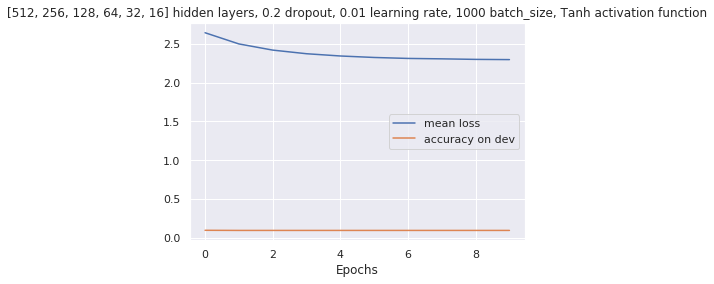

Using GPU!
Starting epoch: 0
mean loss:  2.348928307991127
dev accuracy:  0.1064
Starting epoch: 1
mean loss:  2.3092765248887326
dev accuracy:  0.1064
Starting epoch: 2
mean loss:  2.3050160001359257
dev accuracy:  0.1064
Starting epoch: 3
mean loss:  2.3036376685768194
dev accuracy:  0.1064
Starting epoch: 4
mean loss:  2.3030381792904113
dev accuracy:  0.1064
Starting epoch: 5
mean loss:  2.3024437301660914
dev accuracy:  0.1064
Starting epoch: 6
mean loss:  2.3024553382093966
dev accuracy:  0.1064
Starting epoch: 7
mean loss:  2.3019110382711667
dev accuracy:  0.1064
Starting epoch: 8
mean loss:  2.301738011744041
dev accuracy:  0.1064
Starting epoch: 9
mean loss:  2.3018765383733557
dev accuracy:  0.1064


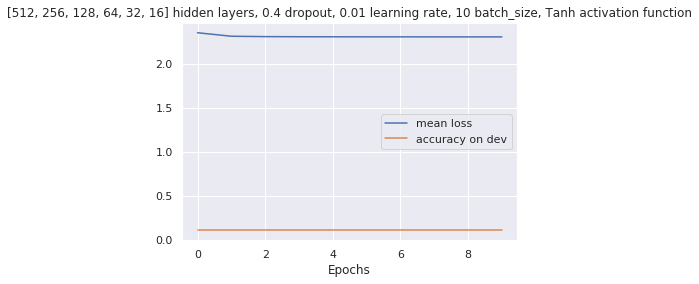

Using GPU!
Starting epoch: 0
mean loss:  2.473741619410867
dev accuracy:  0.1064
Starting epoch: 1
mean loss:  2.3843045049084877
dev accuracy:  0.1064
Starting epoch: 2
mean loss:  2.359606634832904
dev accuracy:  0.1064
Starting epoch: 3
mean loss:  2.343311012386086
dev accuracy:  0.1064
Starting epoch: 4
mean loss:  2.3319550098297364
dev accuracy:  0.1064
Starting epoch: 5
mean loss:  2.326666085306042
dev accuracy:  0.1064
Starting epoch: 6
mean loss:  2.3203256967776786
dev accuracy:  0.1064
Starting epoch: 7
mean loss:  2.316578893604393
dev accuracy:  0.1064
Starting epoch: 8
mean loss:  2.313477112623508
dev accuracy:  0.1064
Starting epoch: 9
mean loss:  2.3110080855097364
dev accuracy:  0.1064


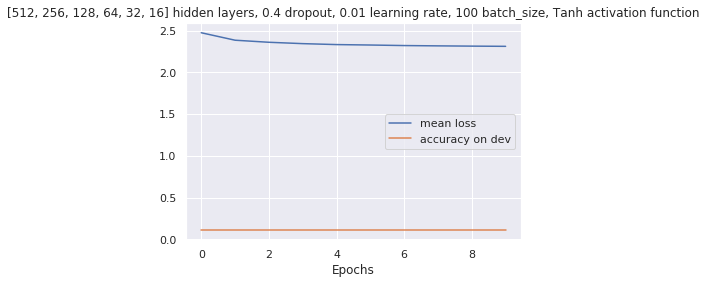

Using GPU!
Starting epoch: 0
mean loss:  2.4999338037827434
dev accuracy:  0.0991
Starting epoch: 1
mean loss:  2.455499709821215
dev accuracy:  0.0991
Starting epoch: 2
mean loss:  2.4203743233400234
dev accuracy:  0.0991
Starting epoch: 3
mean loss:  2.4022577369914337
dev accuracy:  0.0991
Starting epoch: 4
mean loss:  2.3907608845654655
dev accuracy:  0.103
Starting epoch: 5
mean loss:  2.3816761362786387
dev accuracy:  0.103
Starting epoch: 6
mean loss:  2.368024176242305
dev accuracy:  0.103
Starting epoch: 7
mean loss:  2.3634367409874413
dev accuracy:  0.1064
Starting epoch: 8
mean loss:  2.3587458273943733
dev accuracy:  0.1064
Starting epoch: 9
mean loss:  2.352717862409704
dev accuracy:  0.1064


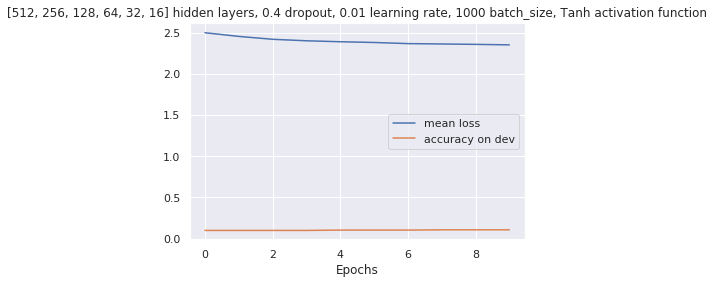

Using GPU!
Starting epoch: 0
mean loss:  2.3450761890678353
dev accuracy:  0.1064
Starting epoch: 1
mean loss:  2.30081125679695
dev accuracy:  0.1064
Starting epoch: 2
mean loss:  2.300737584788569
dev accuracy:  0.1064
Starting epoch: 3
mean loss:  2.300718897987523
dev accuracy:  0.1064
Starting epoch: 4
mean loss:  2.3006999585609917
dev accuracy:  0.1064
Starting epoch: 5
mean loss:  2.300680979278845
dev accuracy:  0.1064
Starting epoch: 6
mean loss:  2.300661960522477
dev accuracy:  0.1064
Starting epoch: 7
mean loss:  2.30064288899079
dev accuracy:  0.1064
Starting epoch: 8
mean loss:  2.3006237489513053
dev accuracy:  0.1064
Starting epoch: 9
mean loss:  2.300604540070303
dev accuracy:  0.1064


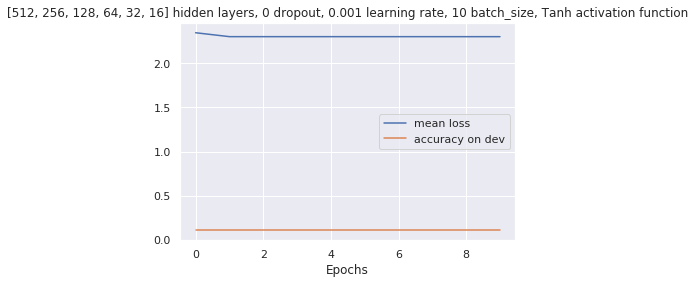

Using GPU!
Starting epoch: 0
mean loss:  2.7183380326824986
dev accuracy:  0.0915
Starting epoch: 1
mean loss:  2.5105995132537657
dev accuracy:  0.0915
Starting epoch: 2
mean loss:  2.412152475463654
dev accuracy:  0.109
Starting epoch: 3
mean loss:  2.360647871108826
dev accuracy:  0.109
Starting epoch: 4
mean loss:  2.332447114342939
dev accuracy:  0.109
Starting epoch: 5
mean loss:  2.3167034742123116
dev accuracy:  0.1064
Starting epoch: 6
mean loss:  2.3078514463649302
dev accuracy:  0.1064
Starting epoch: 7
mean loss:  2.3028657740937497
dev accuracy:  0.1064
Starting epoch: 8
mean loss:  2.3000582230543185
dev accuracy:  0.1064
Starting epoch: 9
mean loss:  2.2984776682482506
dev accuracy:  0.1064


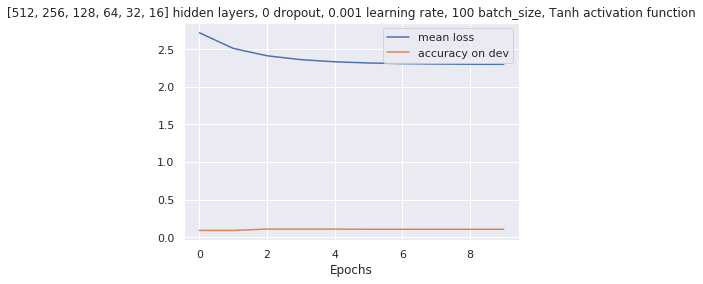

Using GPU!
Starting epoch: 0
mean loss:  2.650790251937567
dev accuracy:  0.103
Starting epoch: 1
mean loss:  2.6258180234946455
dev accuracy:  0.103
Starting epoch: 2
mean loss:  2.603277103573668
dev accuracy:  0.103
Starting epoch: 3
mean loss:  2.582798728755876
dev accuracy:  0.103
Starting epoch: 4
mean loss:  2.5640876900916005
dev accuracy:  0.103
Starting epoch: 5
mean loss:  2.546904587278179
dev accuracy:  0.103
Starting epoch: 6
mean loss:  2.531054506114885
dev accuracy:  0.103
Starting epoch: 7
mean loss:  2.5163755370121375
dev accuracy:  0.103
Starting epoch: 8
mean loss:  2.502733595231
dev accuracy:  0.103
Starting epoch: 9
mean loss:  2.4900172691719207
dev accuracy:  0.103


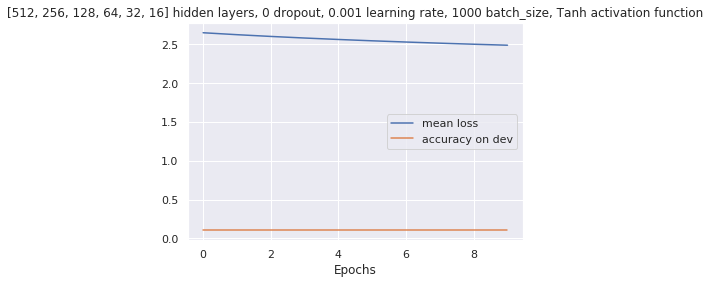

Using GPU!
Starting epoch: 0
mean loss:  2.3684466581205394
dev accuracy:  0.109
Starting epoch: 1
mean loss:  2.3488789125338383
dev accuracy:  0.1064
Starting epoch: 2
mean loss:  2.3412240156052806
dev accuracy:  0.1064
Starting epoch: 3
mean loss:  2.335701128597904
dev accuracy:  0.1064
Starting epoch: 4
mean loss:  2.3286239238911404
dev accuracy:  0.1064
Starting epoch: 5
mean loss:  2.325882977043431
dev accuracy:  0.1064
Starting epoch: 6
mean loss:  2.32233218826358
dev accuracy:  0.1064
Starting epoch: 7
mean loss:  2.320620486889332
dev accuracy:  0.1064
Starting epoch: 8
mean loss:  2.3175147337285167
dev accuracy:  0.1064
Starting epoch: 9
mean loss:  2.3144785887812214
dev accuracy:  0.1064


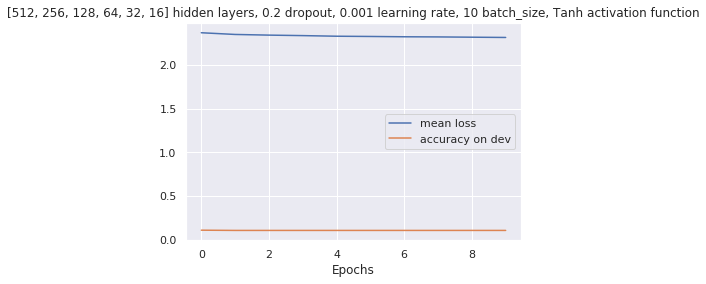

Using GPU!
Starting epoch: 0
mean loss:  2.5833009697957907
dev accuracy:  0.103
Starting epoch: 1
mean loss:  2.462193846464633
dev accuracy:  0.103
Starting epoch: 2
mean loss:  2.404706178786988
dev accuracy:  0.103
Starting epoch: 3
mean loss:  2.382146297100775
dev accuracy:  0.103
Starting epoch: 4
mean loss:  2.361216315252338
dev accuracy:  0.103
Starting epoch: 5
mean loss:  2.355100888216091
dev accuracy:  0.103
Starting epoch: 6
mean loss:  2.350647762150108
dev accuracy:  0.103
Starting epoch: 7
mean loss:  2.346165036964797
dev accuracy:  0.103
Starting epoch: 8
mean loss:  2.3430321230859814
dev accuracy:  0.103
Starting epoch: 9
mean loss:  2.3439931693429243
dev accuracy:  0.103


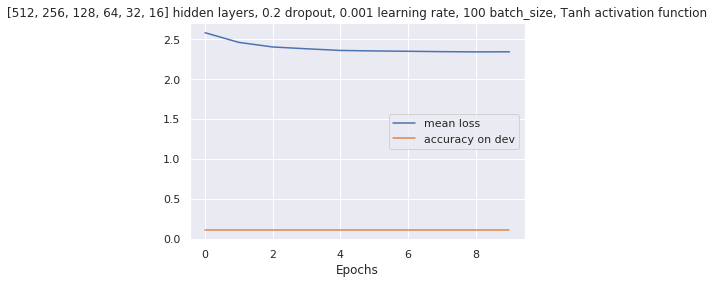

Using GPU!
Starting epoch: 0
mean loss:  2.4980498902937947
dev accuracy:  0.0915
Starting epoch: 1
mean loss:  2.4828680216097365
dev accuracy:  0.0915
Starting epoch: 2
mean loss:  2.468891083025465
dev accuracy:  0.0915
Starting epoch: 3
mean loss:  2.461517712649177
dev accuracy:  0.0915
Starting epoch: 4
mean loss:  2.4479029272116866
dev accuracy:  0.0915
Starting epoch: 5
mean loss:  2.4363509019215903
dev accuracy:  0.0915
Starting epoch: 6
mean loss:  2.4280923908832026
dev accuracy:  0.0915
Starting epoch: 7
mean loss:  2.4206431239259008
dev accuracy:  0.0915
Starting epoch: 8
mean loss:  2.408162794861139
dev accuracy:  0.0915
Starting epoch: 9
mean loss:  2.4060705596325445
dev accuracy:  0.0915


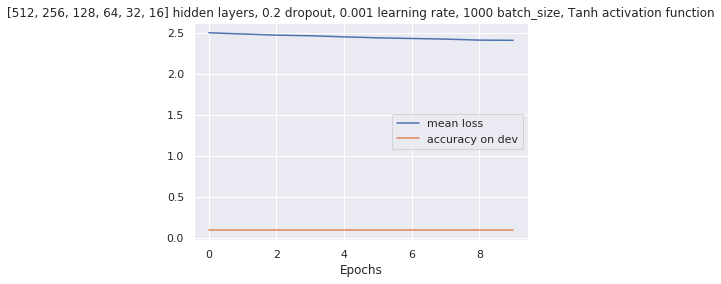

Using GPU!
Starting epoch: 0
mean loss:  2.456732839042009
dev accuracy:  0.1064
Starting epoch: 1
mean loss:  2.391862657660843
dev accuracy:  0.1064
Starting epoch: 2
mean loss:  2.3632311472008882
dev accuracy:  0.1064
Starting epoch: 3
mean loss:  2.346709197222102
dev accuracy:  0.1064
Starting epoch: 4
mean loss:  2.336867905645174
dev accuracy:  0.1064
Starting epoch: 5
mean loss:  2.3293451627381585
dev accuracy:  0.1064
Starting epoch: 6
mean loss:  2.3229988480396115
dev accuracy:  0.1064
Starting epoch: 7
mean loss:  2.318720164524987
dev accuracy:  0.1064
Starting epoch: 8
mean loss:  2.316428204484759
dev accuracy:  0.1064
Starting epoch: 9
mean loss:  2.312931719362152
dev accuracy:  0.1064


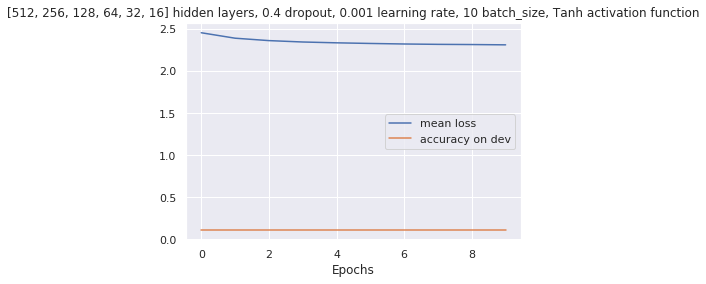

Using GPU!
Starting epoch: 0
mean loss:  2.675245845151281
dev accuracy:  0.109
Starting epoch: 1
mean loss:  2.546583945165851
dev accuracy:  0.109
Starting epoch: 2
mean loss:  2.491535296221217
dev accuracy:  0.109
Starting epoch: 3
mean loss:  2.4542379483967247
dev accuracy:  0.109
Starting epoch: 4
mean loss:  2.432284502688044
dev accuracy:  0.109
Starting epoch: 5
mean loss:  2.412930952098793
dev accuracy:  0.109
Starting epoch: 6
mean loss:  2.401487189614606
dev accuracy:  0.109
Starting epoch: 7
mean loss:  2.39201620619692
dev accuracy:  0.1091
Starting epoch: 8
mean loss:  2.3837897549132387
dev accuracy:  0.1064
Starting epoch: 9
mean loss:  2.381370710993479
dev accuracy:  0.1064


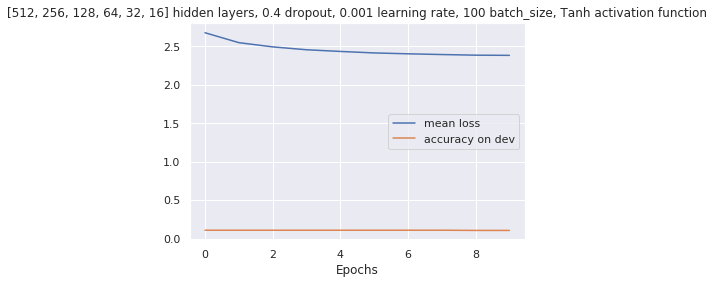

Using GPU!
Starting epoch: 0
mean loss:  2.6472202235577154
dev accuracy:  0.0983
Starting epoch: 1
mean loss:  2.627874944724289
dev accuracy:  0.0983
Starting epoch: 2
mean loss:  2.6238406826468075
dev accuracy:  0.0983
Starting epoch: 3
mean loss:  2.606367966708015
dev accuracy:  0.0983
Starting epoch: 4
mean loss:  2.591418032552682
dev accuracy:  0.0983
Starting epoch: 5
mean loss:  2.5836652540693095
dev accuracy:  0.0983
Starting epoch: 6
mean loss:  2.5665606938156427
dev accuracy:  0.0983
Starting epoch: 7
mean loss:  2.565218911451452
dev accuracy:  0.0983
Starting epoch: 8
mean loss:  2.5576342648150874
dev accuracy:  0.0983
Starting epoch: 9
mean loss:  2.5479319609847724
dev accuracy:  0.0983


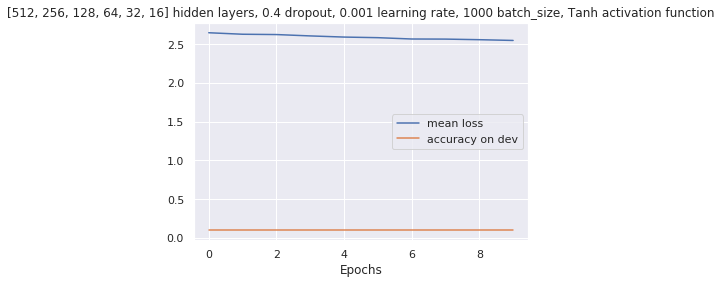

Using GPU!
Starting epoch: 0
mean loss:  0.5634668141534939
dev accuracy:  0.902
Starting epoch: 1
mean loss:  0.2886655114566353
dev accuracy:  0.9323
Starting epoch: 2
mean loss:  0.22623712556457887
dev accuracy:  0.9471
Starting epoch: 3
mean loss:  0.18495585715706958
dev accuracy:  0.9551
Starting epoch: 4
mean loss:  0.15603502286862342
dev accuracy:  0.9587
Starting epoch: 5
mean loss:  0.1341695605991342
dev accuracy:  0.9621
Starting epoch: 6
mean loss:  0.11713256381512002
dev accuracy:  0.9645
Starting epoch: 7
mean loss:  0.10346887330267979
dev accuracy:  0.9658
Starting epoch: 8
mean loss:  0.09213973534089391
dev accuracy:  0.9671
Starting epoch: 9
mean loss:  0.08246114426408056
dev accuracy:  0.9688


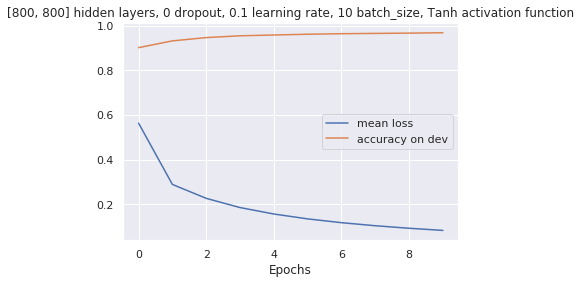

Using GPU!
Starting epoch: 0
mean loss:  1.3556821625865625
dev accuracy:  0.8386
Starting epoch: 1
mean loss:  0.4996822564425821
dev accuracy:  0.8833
Starting epoch: 2
mean loss:  0.39708557445370035
dev accuracy:  0.8981
Starting epoch: 3
mean loss:  0.3597230018672353
dev accuracy:  0.9044
Starting epoch: 4
mean loss:  0.3386581361948135
dev accuracy:  0.9105
Starting epoch: 5
mean loss:  0.32437225886269244
dev accuracy:  0.913
Starting epoch: 6
mean loss:  0.31363705060855596
dev accuracy:  0.9154
Starting epoch: 7
mean loss:  0.30495930174570124
dev accuracy:  0.9179
Starting epoch: 8
mean loss:  0.2975430539744105
dev accuracy:  0.9204
Starting epoch: 9
mean loss:  0.2909253619596392
dev accuracy:  0.9224


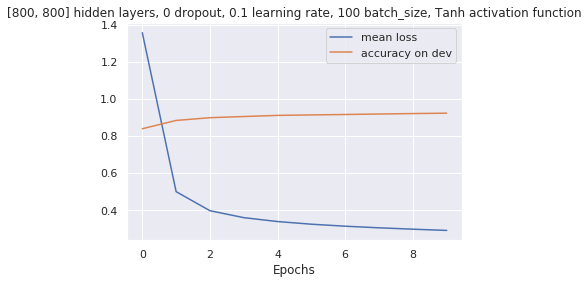

Using GPU!
Starting epoch: 0
mean loss:  2.347342149884093
dev accuracy:  0.1416
Starting epoch: 1
mean loss:  2.038440830567304
dev accuracy:  0.4887
Starting epoch: 2
mean loss:  1.7492052971148024
dev accuracy:  0.6179
Starting epoch: 3
mean loss:  1.4376961787541707
dev accuracy:  0.6924
Starting epoch: 4
mean loss:  1.1593499674516565
dev accuracy:  0.7493
Starting epoch: 5
mean loss:  0.9599876602490743
dev accuracy:  0.8033
Starting epoch: 6
mean loss:  0.8233408355245403
dev accuracy:  0.8288
Starting epoch: 7
mean loss:  0.7274990128535851
dev accuracy:  0.8463
Starting epoch: 8
mean loss:  0.6570713262931973
dev accuracy:  0.8587
Starting epoch: 9
mean loss:  0.6036891423019708
dev accuracy:  0.8672


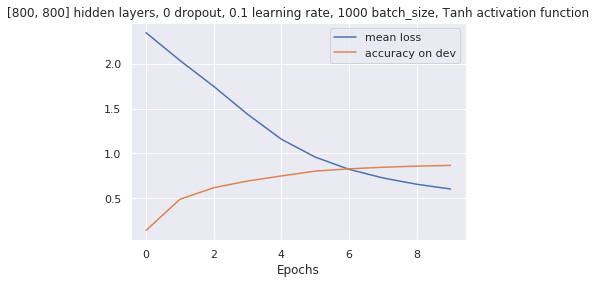

Using GPU!
Starting epoch: 0
mean loss:  0.6122879958142641
dev accuracy:  0.9071
Starting epoch: 1
mean loss:  0.31705981834397357
dev accuracy:  0.9315
Starting epoch: 2
mean loss:  0.25355009272358636
dev accuracy:  0.9437
Starting epoch: 3
mean loss:  0.21348641043204367
dev accuracy:  0.9532
Starting epoch: 4
mean loss:  0.18444891899902685
dev accuracy:  0.9607
Starting epoch: 5
mean loss:  0.1610172069254174
dev accuracy:  0.9635
Starting epoch: 6
mean loss:  0.1456813395603537
dev accuracy:  0.9656
Starting epoch: 7
mean loss:  0.13117449178334656
dev accuracy:  0.967
Starting epoch: 8
mean loss:  0.11929019816011045
dev accuracy:  0.9695
Starting epoch: 9
mean loss:  0.11303465159452575
dev accuracy:  0.9718


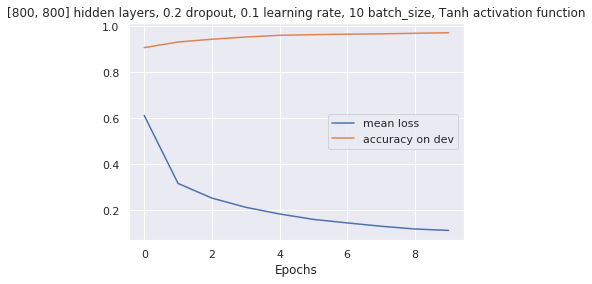

Using GPU!
Starting epoch: 0
mean loss:  1.5093510788595843
dev accuracy:  0.8322
Starting epoch: 1
mean loss:  0.619727139225501
dev accuracy:  0.8781
Starting epoch: 2
mean loss:  0.49042694008873844
dev accuracy:  0.8924
Starting epoch: 3
mean loss:  0.44160806954263926
dev accuracy:  0.9017
Starting epoch: 4
mean loss:  0.41039909972640093
dev accuracy:  0.9074
Starting epoch: 5
mean loss:  0.39049067549005956
dev accuracy:  0.9109
Starting epoch: 6
mean loss:  0.37614029280082906
dev accuracy:  0.9139
Starting epoch: 7
mean loss:  0.3618565426912612
dev accuracy:  0.9171
Starting epoch: 8
mean loss:  0.3484727966779482
dev accuracy:  0.9188
Starting epoch: 9
mean loss:  0.339708956177839
dev accuracy:  0.9203


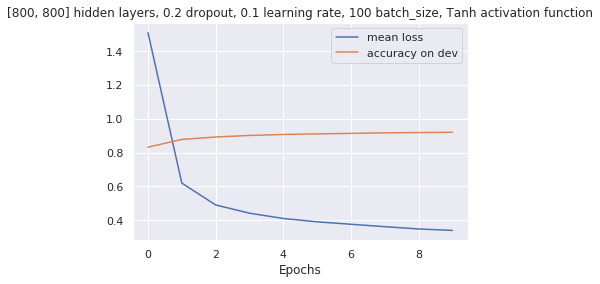

Using GPU!
Starting epoch: 0
mean loss:  2.3402362430796906
dev accuracy:  0.2519
Starting epoch: 1
mean loss:  2.104078325570798
dev accuracy:  0.5807
Starting epoch: 2
mean loss:  1.866108779813729
dev accuracy:  0.6749
Starting epoch: 3
mean loss:  1.6058415595222921
dev accuracy:  0.734
Starting epoch: 4
mean loss:  1.3525289881463145
dev accuracy:  0.7892
Starting epoch: 5
mean loss:  1.1451156092625039
dev accuracy:  0.8083
Starting epoch: 6
mean loss:  0.9966630888920204
dev accuracy:  0.829
Starting epoch: 7
mean loss:  0.8903678480316611
dev accuracy:  0.8375
Starting epoch: 8
mean loss:  0.8094467637585658
dev accuracy:  0.8486
Starting epoch: 9
mean loss:  0.7495439823936013
dev accuracy:  0.8538


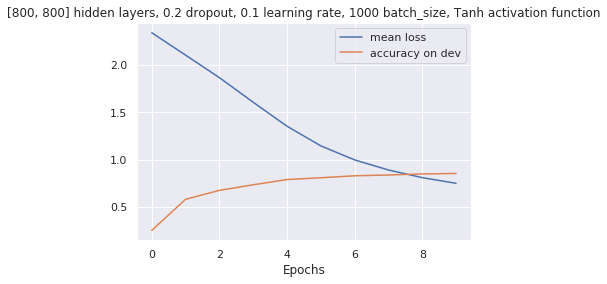

Using GPU!
Starting epoch: 0
mean loss:  0.6875101081785608
dev accuracy:  0.9046
Starting epoch: 1
mean loss:  0.355692982771135
dev accuracy:  0.9266
Starting epoch: 2
mean loss:  0.2858364323361596
dev accuracy:  0.9427
Starting epoch: 3
mean loss:  0.24640034196823943
dev accuracy:  0.9509
Starting epoch: 4
mean loss:  0.21529574672243834
dev accuracy:  0.9574
Starting epoch: 5
mean loss:  0.19224348265338384
dev accuracy:  0.9613
Starting epoch: 6
mean loss:  0.1748464225783224
dev accuracy:  0.9634
Starting epoch: 7
mean loss:  0.16162446368043354
dev accuracy:  0.9674
Starting epoch: 8
mean loss:  0.14992158940207695
dev accuracy:  0.9674
Starting epoch: 9
mean loss:  0.1403262122837638
dev accuracy:  0.9709


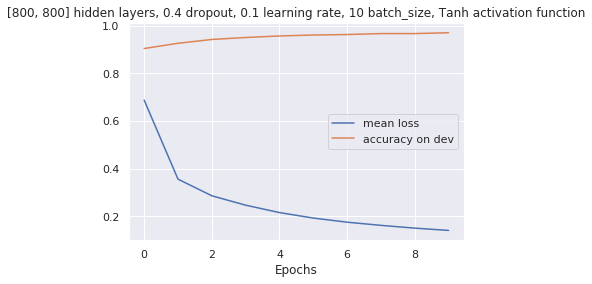

Using GPU!
Starting epoch: 0
mean loss:  1.6718588681991942
dev accuracy:  0.808
Starting epoch: 1
mean loss:  0.7668141109381845
dev accuracy:  0.8625
Starting epoch: 2
mean loss:  0.5923997211955978
dev accuracy:  0.8872
Starting epoch: 3
mean loss:  0.5256865503426321
dev accuracy:  0.8954
Starting epoch: 4
mean loss:  0.48459712265732285
dev accuracy:  0.9009
Starting epoch: 5
mean loss:  0.4557710050525304
dev accuracy:  0.9061
Starting epoch: 6
mean loss:  0.43309047758698227
dev accuracy:  0.9094
Starting epoch: 7
mean loss:  0.4147334232361255
dev accuracy:  0.9115
Starting epoch: 8
mean loss:  0.39911451358757094
dev accuracy:  0.9142
Starting epoch: 9
mean loss:  0.38661599599434704
dev accuracy:  0.9183


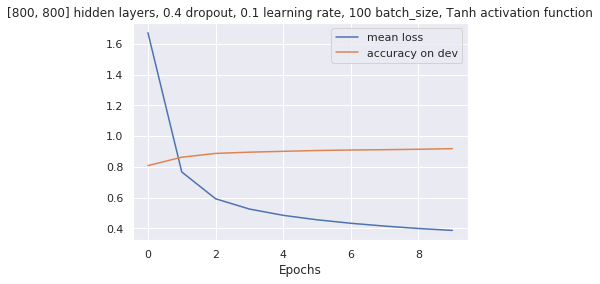

Using GPU!
Starting epoch: 0
mean loss:  2.448516499762442
dev accuracy:  0.206
Starting epoch: 1
mean loss:  2.19540371614344
dev accuracy:  0.567
Starting epoch: 2
mean loss:  2.014138254464841
dev accuracy:  0.6682
Starting epoch: 3
mean loss:  1.824297675899431
dev accuracy:  0.7085
Starting epoch: 4
mean loss:  1.615203436683206
dev accuracy:  0.7453
Starting epoch: 5
mean loss:  1.4185621154074575
dev accuracy:  0.7782
Starting epoch: 6
mean loss:  1.2587489380555994
dev accuracy:  0.8018
Starting epoch: 7
mean loss:  1.1255441857319253
dev accuracy:  0.8115
Starting epoch: 8
mean loss:  1.0245981602107777
dev accuracy:  0.8261
Starting epoch: 9
mean loss:  0.9542653397017834
dev accuracy:  0.8365


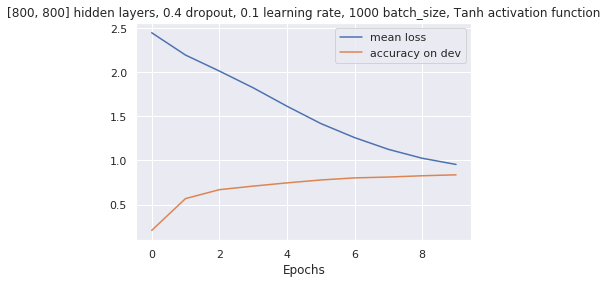

Using GPU!
Starting epoch: 0
mean loss:  1.2432531894171055
dev accuracy:  0.8462
Starting epoch: 1
mean loss:  0.48363600260548484
dev accuracy:  0.8868
Starting epoch: 2
mean loss:  0.3902575583010018
dev accuracy:  0.8986
Starting epoch: 3
mean loss:  0.35490240923236477
dev accuracy:  0.9058
Starting epoch: 4
mean loss:  0.33458649480543695
dev accuracy:  0.9118
Starting epoch: 5
mean loss:  0.32072880843695617
dev accuracy:  0.9134
Starting epoch: 6
mean loss:  0.31031951756983656
dev accuracy:  0.9162
Starting epoch: 7
mean loss:  0.30192291779723707
dev accuracy:  0.919
Starting epoch: 8
mean loss:  0.29474958334216084
dev accuracy:  0.9216
Starting epoch: 9
mean loss:  0.28833163308089205
dev accuracy:  0.9224


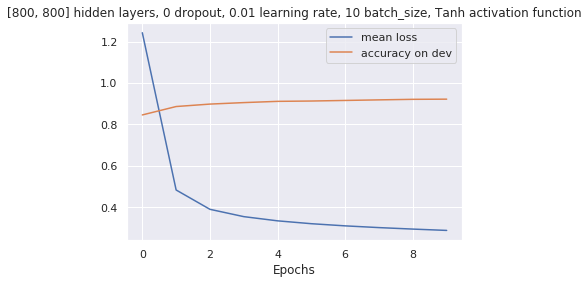

Using GPU!
Starting epoch: 0
mean loss:  2.2124412921136485
dev accuracy:  0.5172
Starting epoch: 1
mean loss:  1.9922896002581019
dev accuracy:  0.6574
Starting epoch: 2
mean loss:  1.710305605106011
dev accuracy:  0.7285
Starting epoch: 3
mean loss:  1.3999187779759694
dev accuracy:  0.7843
Starting epoch: 4
mean loss:  1.1367172534594279
dev accuracy:  0.8165
Starting epoch: 5
mean loss:  0.9465345551153856
dev accuracy:  0.8358
Starting epoch: 6
mean loss:  0.8145212346684195
dev accuracy:  0.8489
Starting epoch: 7
mean loss:  0.7211549169051195
dev accuracy:  0.8581
Starting epoch: 8
mean loss:  0.6529158218178207
dev accuracy:  0.865
Starting epoch: 9
mean loss:  0.6014511926683361
dev accuracy:  0.8706


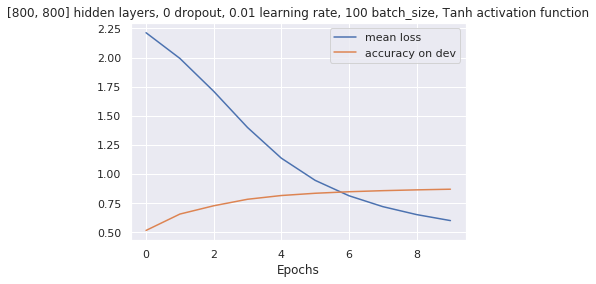

Using GPU!
Starting epoch: 0
mean loss:  2.2543661921632054
dev accuracy:  0.1815
Starting epoch: 1
mean loss:  2.2295251593870273
dev accuracy:  0.2505
Starting epoch: 2
mean loss:  2.21090262076434
dev accuracy:  0.3404
Starting epoch: 3
mean loss:  2.1922844578238094
dev accuracy:  0.4162
Starting epoch: 4
mean loss:  2.1735856720045503
dev accuracy:  0.4697
Starting epoch: 5
mean loss:  2.154724583906286
dev accuracy:  0.5105
Starting epoch: 6
mean loss:  2.1356243853475534
dev accuracy:  0.5454
Starting epoch: 7
mean loss:  2.116212283863741
dev accuracy:  0.5703
Starting epoch: 8
mean loss:  2.0964182591905782
dev accuracy:  0.5933
Starting epoch: 9
mean loss:  2.0761774007011864
dev accuracy:  0.6097


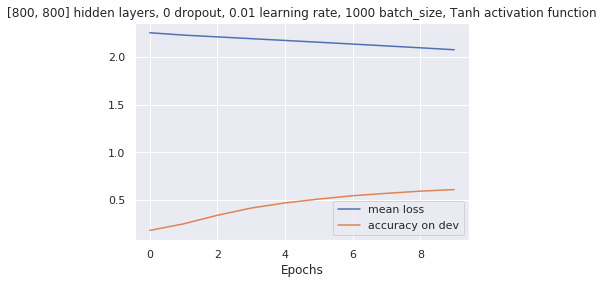

Using GPU!
Starting epoch: 0
mean loss:  1.4137955731843572
dev accuracy:  0.8344
Starting epoch: 1
mean loss:  0.6097620591801349
dev accuracy:  0.8819
Starting epoch: 2
mean loss:  0.4855961468654754
dev accuracy:  0.8958
Starting epoch: 3
mean loss:  0.437534573554793
dev accuracy:  0.9032
Starting epoch: 4
mean loss:  0.41038299032923303
dev accuracy:  0.907
Starting epoch: 5
mean loss:  0.39160160583322334
dev accuracy:  0.9116
Starting epoch: 6
mean loss:  0.3757036004118268
dev accuracy:  0.9137
Starting epoch: 7
mean loss:  0.36037078714644405
dev accuracy:  0.9162
Starting epoch: 8
mean loss:  0.3520515380500615
dev accuracy:  0.918
Starting epoch: 9
mean loss:  0.34133766135729743
dev accuracy:  0.9217


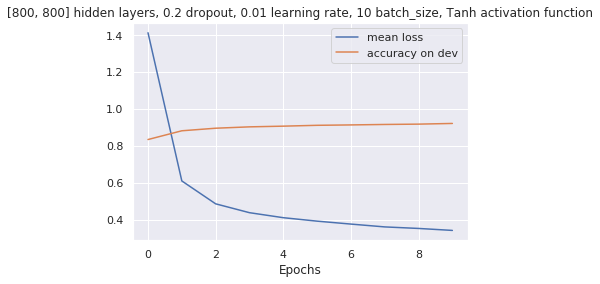

Using GPU!
Starting epoch: 0
mean loss:  2.2903530007588886
dev accuracy:  0.5094
Starting epoch: 1
mean loss:  2.101874482845832
dev accuracy:  0.6441
Starting epoch: 2
mean loss:  1.8773422124619017
dev accuracy:  0.704
Starting epoch: 3
mean loss:  1.6197522897682266
dev accuracy:  0.7605
Starting epoch: 4
mean loss:  1.3704480104103773
dev accuracy:  0.7939
Starting epoch: 5
mean loss:  1.1683538578703494
dev accuracy:  0.8197
Starting epoch: 6
mean loss:  1.012840342735816
dev accuracy:  0.8335
Starting epoch: 7
mean loss:  0.9040469577212533
dev accuracy:  0.8446
Starting epoch: 8
mean loss:  0.8181554095711775
dev accuracy:  0.8528
Starting epoch: 9
mean loss:  0.7571697328499929
dev accuracy:  0.8612


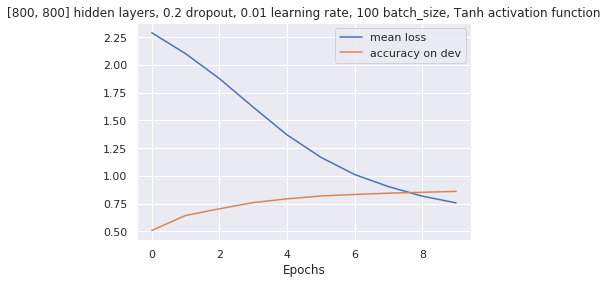

Using GPU!
Starting epoch: 0
mean loss:  2.3200775875764736
dev accuracy:  0.2404
Starting epoch: 1
mean loss:  2.2938959879033707
dev accuracy:  0.298
Starting epoch: 2
mean loss:  2.277359401478487
dev accuracy:  0.3317
Starting epoch: 3
mean loss:  2.2628733036564848
dev accuracy:  0.3793
Starting epoch: 4
mean loss:  2.245231422723508
dev accuracy:  0.4189
Starting epoch: 5
mean loss:  2.2275508011088654
dev accuracy:  0.4701
Starting epoch: 6
mean loss:  2.2115100879295198
dev accuracy:  0.5084
Starting epoch: 7
mean loss:  2.1914092699686685
dev accuracy:  0.5462
Starting epoch: 8
mean loss:  2.1761255451277193
dev accuracy:  0.5711
Starting epoch: 9
mean loss:  2.1566086656907024
dev accuracy:  0.5975


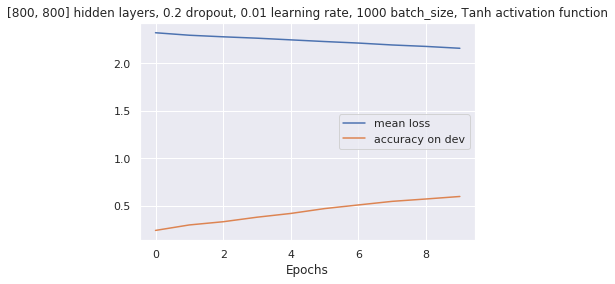

Using GPU!
Starting epoch: 0
mean loss:  1.6122026230675819
dev accuracy:  0.8185
Starting epoch: 1
mean loss:  0.7581802249815888
dev accuracy:  0.872
Starting epoch: 2
mean loss:  0.5942090472716364
dev accuracy:  0.8902
Starting epoch: 3
mean loss:  0.5205755158394748
dev accuracy:  0.8946
Starting epoch: 4
mean loss:  0.4846572471163173
dev accuracy:  0.9013
Starting epoch: 5
mean loss:  0.452702461966641
dev accuracy:  0.9057
Starting epoch: 6
mean loss:  0.43288386460051753
dev accuracy:  0.9099
Starting epoch: 7
mean loss:  0.41325716086780817
dev accuracy:  0.9118
Starting epoch: 8
mean loss:  0.3986751281564515
dev accuracy:  0.9151
Starting epoch: 9
mean loss:  0.3861504736729078
dev accuracy:  0.9172


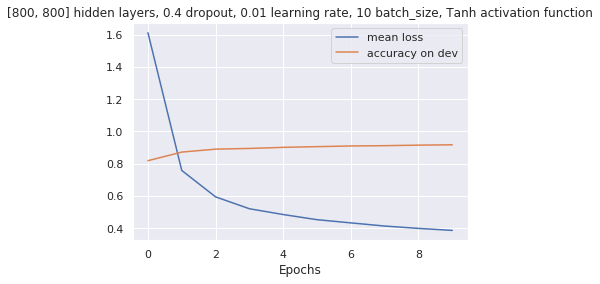

Using GPU!
Starting epoch: 0
mean loss:  2.381264383921366
dev accuracy:  0.5007
Starting epoch: 1
mean loss:  2.196021944700839
dev accuracy:  0.6586
Starting epoch: 2
mean loss:  2.013244684108955
dev accuracy:  0.7022
Starting epoch: 3
mean loss:  1.8069655807194358
dev accuracy:  0.738
Starting epoch: 4
mean loss:  1.5974220530001704
dev accuracy:  0.7687
Starting epoch: 5
mean loss:  1.4059120252460777
dev accuracy:  0.7898
Starting epoch: 6
mean loss:  1.2435980352337013
dev accuracy:  0.8086
Starting epoch: 7
mean loss:  1.1209543235525639
dev accuracy:  0.819
Starting epoch: 8
mean loss:  1.0336749335962856
dev accuracy:  0.8264
Starting epoch: 9
mean loss:  0.9560866447503933
dev accuracy:  0.8332


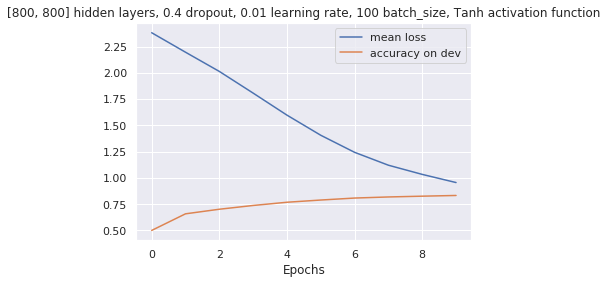

Using GPU!
Starting epoch: 0
mean loss:  2.439123976464365
dev accuracy:  0.1608
Starting epoch: 1
mean loss:  2.403695882535448
dev accuracy:  0.2566
Starting epoch: 2
mean loss:  2.3788432233473835
dev accuracy:  0.3662
Starting epoch: 3
mean loss:  2.358943789613013
dev accuracy:  0.4035
Starting epoch: 4
mean loss:  2.3387085596720376
dev accuracy:  0.4412
Starting epoch: 5
mean loss:  2.318880875905355
dev accuracy:  0.4859
Starting epoch: 6
mean loss:  2.300236468221627
dev accuracy:  0.5291
Starting epoch: 7
mean loss:  2.2806019175286387
dev accuracy:  0.5382
Starting epoch: 8
mean loss:  2.264614011727127
dev accuracy:  0.5655
Starting epoch: 9
mean loss:  2.2488000579908785
dev accuracy:  0.5854


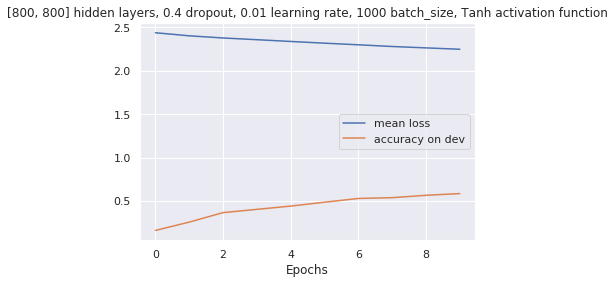

Using GPU!
Starting epoch: 0
mean loss:  2.2120353498355887
dev accuracy:  0.5333
Starting epoch: 1
mean loss:  1.986401012291362
dev accuracy:  0.6489
Starting epoch: 2
mean loss:  1.6982725218424104
dev accuracy:  0.7282
Starting epoch: 3
mean loss:  1.385852666979574
dev accuracy:  0.7887
Starting epoch: 4
mean loss:  1.1251114889326823
dev accuracy:  0.8185
Starting epoch: 5
mean loss:  0.9393761292073136
dev accuracy:  0.8371
Starting epoch: 6
mean loss:  0.8112929178771675
dev accuracy:  0.8484
Starting epoch: 7
mean loss:  0.7205753190782971
dev accuracy:  0.8573
Starting epoch: 8
mean loss:  0.6538619819884776
dev accuracy:  0.8655
Starting epoch: 9
mean loss:  0.6031218083458789
dev accuracy:  0.8714


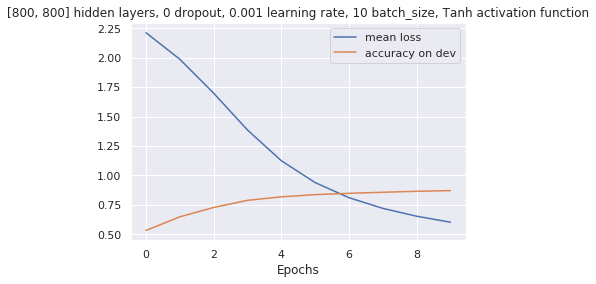

Using GPU!
Starting epoch: 0
mean loss:  2.313933926904035
dev accuracy:  0.1957
Starting epoch: 1
mean loss:  2.2721619387110787
dev accuracy:  0.2686
Starting epoch: 2
mean loss:  2.253487807310032
dev accuracy:  0.3531
Starting epoch: 3
mean loss:  2.2348307739950704
dev accuracy:  0.4317
Starting epoch: 4
mean loss:  2.2161022051127848
dev accuracy:  0.4927
Starting epoch: 5
mean loss:  2.1972182163459335
dev accuracy:  0.5377
Starting epoch: 6
mean loss:  2.1780988484799506
dev accuracy:  0.5666
Starting epoch: 7
mean loss:  2.1586679270167553
dev accuracy:  0.5935
Starting epoch: 8
mean loss:  2.138852699550088
dev accuracy:  0.6113
Starting epoch: 9
mean loss:  2.1185840289749787
dev accuracy:  0.6291


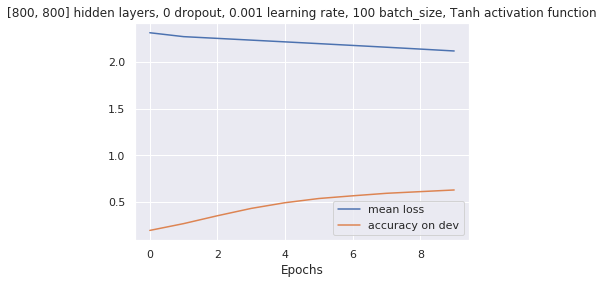

Using GPU!
Starting epoch: 0
mean loss:  2.363653211032643
dev accuracy:  0.1112
Starting epoch: 1
mean loss:  2.2627615928649902
dev accuracy:  0.1558
Starting epoch: 2
mean loss:  2.2492908823723887
dev accuracy:  0.1514
Starting epoch: 3
mean loss:  2.24624358438978
dev accuracy:  0.15
Starting epoch: 4
mean loss:  2.2443050683713426
dev accuracy:  0.1506
Starting epoch: 5
mean loss:  2.2424753179737165
dev accuracy:  0.1527
Starting epoch: 6
mean loss:  2.2406578110713586
dev accuracy:  0.1553
Starting epoch: 7
mean loss:  2.23884310909346
dev accuracy:  0.1579
Starting epoch: 8
mean loss:  2.23703026304058
dev accuracy:  0.161
Starting epoch: 9
mean loss:  2.2352187119278253
dev accuracy:  0.1644


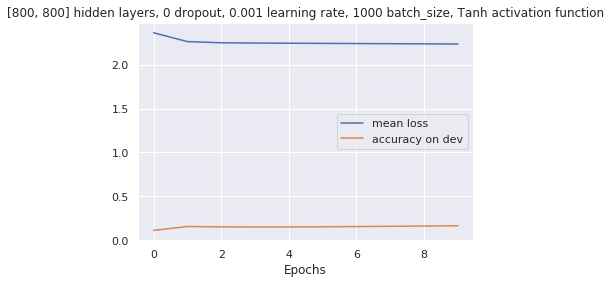

Using GPU!
Starting epoch: 0
mean loss:  2.286484018132058
dev accuracy:  0.5733
Starting epoch: 1
mean loss:  2.095620774931966
dev accuracy:  0.6486
Starting epoch: 2
mean loss:  1.8669895670028287
dev accuracy:  0.7158
Starting epoch: 3
mean loss:  1.6004782037910426
dev accuracy:  0.7646
Starting epoch: 4
mean loss:  1.3420386317967654
dev accuracy:  0.8009
Starting epoch: 5
mean loss:  1.1403585812659818
dev accuracy:  0.8197
Starting epoch: 6
mean loss:  0.9933471057062696
dev accuracy:  0.8359
Starting epoch: 7
mean loss:  0.8883322980720457
dev accuracy:  0.8484
Starting epoch: 8
mean loss:  0.8083690109103471
dev accuracy:  0.8519
Starting epoch: 9
mean loss:  0.7497249888529947
dev accuracy:  0.8577


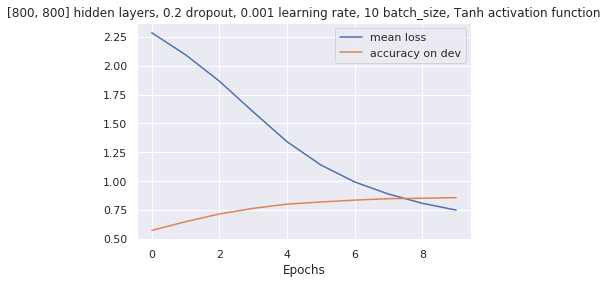

Using GPU!
Starting epoch: 0
mean loss:  2.3650154353615767
dev accuracy:  0.2119
Starting epoch: 1
mean loss:  2.337368449765051
dev accuracy:  0.2828
Starting epoch: 2
mean loss:  2.316745492036709
dev accuracy:  0.363
Starting epoch: 3
mean loss:  2.3017563320205596
dev accuracy:  0.4283
Starting epoch: 4
mean loss:  2.2816966921983366
dev accuracy:  0.4903
Starting epoch: 5
mean loss:  2.2616469598339943
dev accuracy:  0.5226
Starting epoch: 6
mean loss:  2.2452397927076753
dev accuracy:  0.5717
Starting epoch: 7
mean loss:  2.2260332930825664
dev accuracy:  0.5845
Starting epoch: 8
mean loss:  2.2067318024511584
dev accuracy:  0.5933
Starting epoch: 9
mean loss:  2.192380670539871
dev accuracy:  0.6123


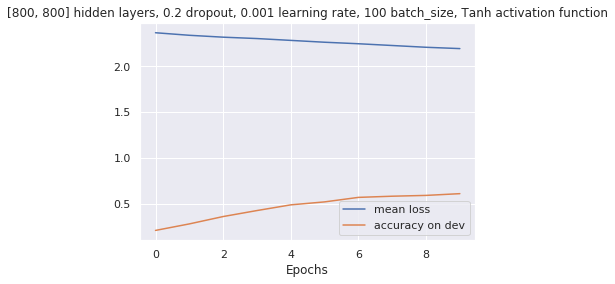

Using GPU!
Starting epoch: 0
mean loss:  2.4377430093054677
dev accuracy:  0.0949
Starting epoch: 1
mean loss:  2.332702538546394
dev accuracy:  0.1718
Starting epoch: 2
mean loss:  2.3190309767629587
dev accuracy:  0.1228
Starting epoch: 3
mean loss:  2.315794491300396
dev accuracy:  0.1169
Starting epoch: 4
mean loss:  2.31639139325011
dev accuracy:  0.1172
Starting epoch: 5
mean loss:  2.313063700993856
dev accuracy:  0.1214
Starting epoch: 6
mean loss:  2.311138354095758
dev accuracy:  0.1246
Starting epoch: 7
mean loss:  2.3094581716200886
dev accuracy:  0.1262
Starting epoch: 8
mean loss:  2.3095209318048813
dev accuracy:  0.1276
Starting epoch: 9
mean loss:  2.3057949823491715
dev accuracy:  0.1321


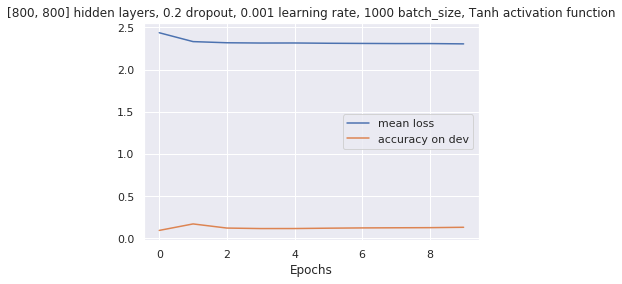

Using GPU!
Starting epoch: 0
mean loss:  2.3949070401345223
dev accuracy:  0.5224
Starting epoch: 1
mean loss:  2.2148036268610305
dev accuracy:  0.6128
Starting epoch: 2
mean loss:  2.0385346710383954
dev accuracy:  0.6967
Starting epoch: 3
mean loss:  1.8377288698411136
dev accuracy:  0.7298
Starting epoch: 4
mean loss:  1.6304817679428478
dev accuracy:  0.7639
Starting epoch: 5
mean loss:  1.436624890993748
dev accuracy:  0.7915
Starting epoch: 6
mean loss:  1.278100435542145
dev accuracy:  0.801
Starting epoch: 7
mean loss:  1.146837008384389
dev accuracy:  0.8177
Starting epoch: 8
mean loss:  1.0505675917874573
dev accuracy:  0.8289
Starting epoch: 9
mean loss:  0.9718470190422841
dev accuracy:  0.8387


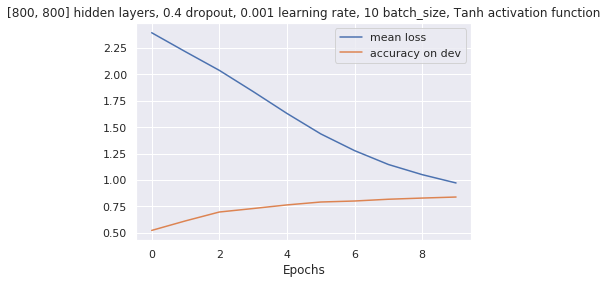

Using GPU!
Starting epoch: 0
mean loss:  2.476512141332417
dev accuracy:  0.1785
Starting epoch: 1
mean loss:  2.4512782982009615
dev accuracy:  0.2447
Starting epoch: 2
mean loss:  2.4195004427980282
dev accuracy:  0.3169
Starting epoch: 3
mean loss:  2.40577810443566
dev accuracy:  0.3495
Starting epoch: 4
mean loss:  2.388375769118349
dev accuracy:  0.4187
Starting epoch: 5
mean loss:  2.3644148613402467
dev accuracy:  0.4568
Starting epoch: 6
mean loss:  2.3535474821954905
dev accuracy:  0.4802
Starting epoch: 7
mean loss:  2.3336558789312245
dev accuracy:  0.5267
Starting epoch: 8
mean loss:  2.3127044927098317
dev accuracy:  0.5258
Starting epoch: 9
mean loss:  2.2960273172565087
dev accuracy:  0.5729


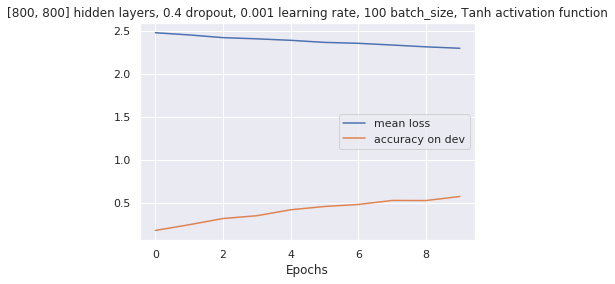

Using GPU!
Starting epoch: 0
mean loss:  2.5255537921307134
dev accuracy:  0.1138
Starting epoch: 1
mean loss:  2.4460317995034013
dev accuracy:  0.1611
Starting epoch: 2
mean loss:  2.433393726161882
dev accuracy:  0.1501
Starting epoch: 3
mean loss:  2.4284981606053373
dev accuracy:  0.1393
Starting epoch: 4
mean loss:  2.4252993499531463
dev accuracy:  0.1524
Starting epoch: 5
mean loss:  2.4156462912466012
dev accuracy:  0.1538
Starting epoch: 6
mean loss:  2.422559195873784
dev accuracy:  0.1582
Starting epoch: 7
mean loss:  2.422313147900151
dev accuracy:  0.1645
Starting epoch: 8
mean loss:  2.4140718731225705
dev accuracy:  0.1683
Starting epoch: 9
mean loss:  2.4141307531618605
dev accuracy:  0.1684


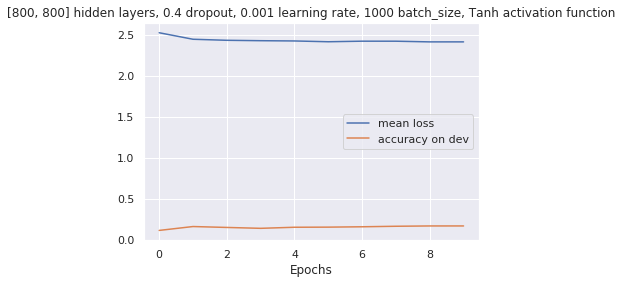

In [20]:
layer_dims_testing = [[128, 128], [128,64,32,16], [256,128,64,32,16], [512,256,128,64,32,16], [800,800]]
input_dim = len(train_img[0])
dropout_values = [0, 0.2, 0.4]
learning_rates = [0.1, 0.01, 0.001]
models_list = []
mean_loss_list = []
dev_accuracy_list = []

EPOCHS = 10
batch_sizes = [10, 100, 1000]

cuda0 = torch.device('cuda:0')

for layerdim in layer_dims_testing:
    for lr in learning_rates:  
        for dropout_value in dropout_values:
            for batch_size in batch_sizes:
                model = SigmoidMLP(input_dim, layerdim, dropout_value)
                model.apply(init_weights)
                model.to(cuda0)
                optimizer = torch.optim.SGD(model.parameters(),lr=lr)
                model, mean_losses, dev_accus = training(model, train_img, train_label, NLLloss, optimizer, dev_img, dev_label, EPOCHS, batch_size)
                models_list.append(model)
                mean_loss_list.append(mean_losses)
                dev_accuracy_list.append(dev_accus)
                plot_graphs(mean_losses, dev_accus, dropout_value, layerdim, lr, batch_size, "Sigmoid")

In [ ]:
class TanhMLP(nn.Module):
    def __init__(self, input_dim, layer_dims, dropout_value):
        super(TanhMLP, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, layer_dims[0]))
        layers.append(nn.Tanh())
        layers.append(nn.Dropout(dropout_value))
        layers.append(nn.Linear(layer_dims[0], layer_dims[1]))
        layers.append(nn.Tanh())
        for i in range(len(layer_dims)-2):
            layers.append(nn.Dropout(dropout_value))
            layers.append(nn.Linear(layer_dims[i+1], layer_dims[i+2]))
            layers.append(nn.Tanh())
        layers.append(nn.Dropout(dropout_value))
        layers.append(nn.Linear(layer_dims[-1], 10))
        self.seq = nn.Sequential(*layers)
            
    def forward(self, inputs):
        return self.seq(inputs)

Starting epoch: 0
mean loss:  0.25113302699777296
dev accuracy:  0.958
Starting epoch: 1
mean loss:  0.11135978699882983
dev accuracy:  0.9712
Starting epoch: 2
mean loss:  0.07057292157541846
dev accuracy:  0.9726
Starting epoch: 3
mean loss:  0.04628581745085024
dev accuracy:  0.9697
Starting epoch: 4
mean loss:  0.03138557778036229
dev accuracy:  0.9673
Starting epoch: 5
mean loss:  0.020031292945526368
dev accuracy:  0.9748
Starting epoch: 6
mean loss:  0.014187877388014416
dev accuracy:  0.9756
Starting epoch: 7
mean loss:  0.009169535106286791
dev accuracy:  0.9765
Starting epoch: 8
mean loss:  0.00622133318319586
dev accuracy:  0.9784
Starting epoch: 9
mean loss:  0.004261143505253286
dev accuracy:  0.9781
Starting epoch: 10
mean loss:  0.0027516808438506997
dev accuracy:  0.9785
Starting epoch: 11
mean loss:  0.0015391296109902213
dev accuracy:  0.9791
Starting epoch: 12
mean loss:  0.0011474599172108999
dev accuracy:  0.9793
Starting epoch: 13
mean loss:  0.0009086025261980319

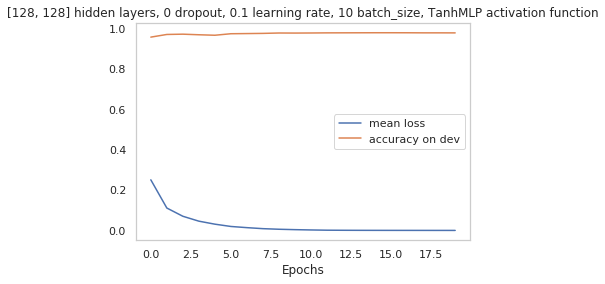

Starting epoch: 0
mean loss:  0.39089268434071495
dev accuracy:  0.9326
Starting epoch: 1
mean loss:  0.22571758569000724
dev accuracy:  0.9482
Starting epoch: 2
mean loss:  0.17611913314598526
dev accuracy:  0.9566
Starting epoch: 3
mean loss:  0.1447343969431347
dev accuracy:  0.9623
Starting epoch: 4
mean loss:  0.12273512269089559
dev accuracy:  0.9654
Starting epoch: 5
mean loss:  0.10625405051929508
dev accuracy:  0.9684
Starting epoch: 6
mean loss:  0.09329612211820608
dev accuracy:  0.9689
Starting epoch: 7
mean loss:  0.08274061391557642
dev accuracy:  0.9707
Starting epoch: 8
mean loss:  0.07391748369528267
dev accuracy:  0.9723
Starting epoch: 9
mean loss:  0.0663988430632981
dev accuracy:  0.973
Starting epoch: 10
mean loss:  0.05989415720737207
dev accuracy:  0.9731
Starting epoch: 11
mean loss:  0.054196898578229305
dev accuracy:  0.9734
Starting epoch: 12
mean loss:  0.04915565351106063
dev accuracy:  0.9739
Starting epoch: 13
mean loss:  0.04465860521565833
dev accuracy

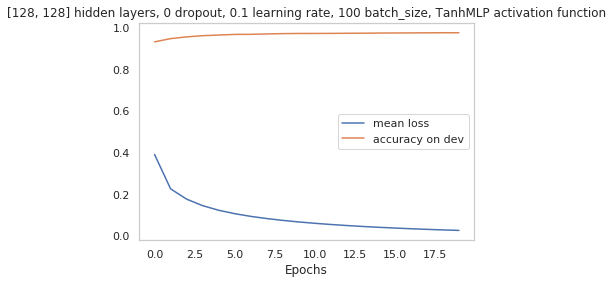

Starting epoch: 0
mean loss:  0.9128686283148971
dev accuracy:  0.8809
Starting epoch: 1
mean loss:  0.4491124053796132
dev accuracy:  0.9017
Starting epoch: 2
mean loss:  0.37360022114772423
dev accuracy:  0.9117
Starting epoch: 3
mean loss:  0.3366466643763523
dev accuracy:  0.9165
Starting epoch: 4
mean loss:  0.3127894366488737
dev accuracy:  0.9204
Starting epoch: 5
mean loss:  0.29510846997008605
dev accuracy:  0.923
Starting epoch: 6
mean loss:  0.28088997070695837
dev accuracy:  0.9255
Starting epoch: 7
mean loss:  0.26884360085515413
dev accuracy:  0.929
Starting epoch: 8
mean loss:  0.25827710038306667
dev accuracy:  0.9314
Starting epoch: 9
mean loss:  0.24878735986410402
dev accuracy:  0.9334
Starting epoch: 10
mean loss:  0.24012532538058712
dev accuracy:  0.935
Starting epoch: 11
mean loss:  0.23212960303998462
dev accuracy:  0.9376
Starting epoch: 12
mean loss:  0.22469086126953947
dev accuracy:  0.9396
Starting epoch: 13
mean loss:  0.21773163039310306
dev accuracy:  0.

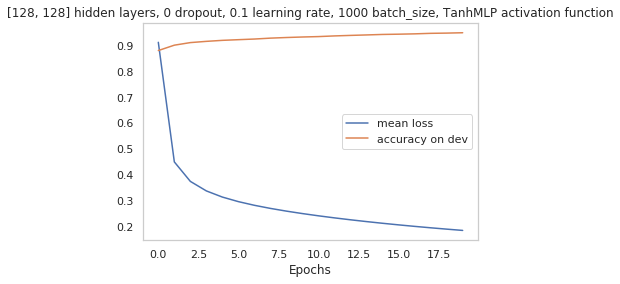

Starting epoch: 0
mean loss:  0.3483651880619912
dev accuracy:  0.9504
Starting epoch: 1
mean loss:  0.2108176095684633
dev accuracy:  0.9609
Starting epoch: 2
mean loss:  0.171397390118041
dev accuracy:  0.9611
Starting epoch: 3
mean loss:  0.14958297262595888
dev accuracy:  0.9681
Starting epoch: 4
mean loss:  0.13831235935785896
dev accuracy:  0.9675
Starting epoch: 5
mean loss:  0.12397081264175278
dev accuracy:  0.971
Starting epoch: 6
mean loss:  0.11666624881207502
dev accuracy:  0.9708
Starting epoch: 7
mean loss:  0.10941343375290923
dev accuracy:  0.9702
Starting epoch: 8
mean loss:  0.1012531918141385
dev accuracy:  0.9722
Starting epoch: 9
mean loss:  0.09508992949643402
dev accuracy:  0.9744
Starting epoch: 10
mean loss:  0.0930742799164409
dev accuracy:  0.9722
Starting epoch: 11
mean loss:  0.08653311099258718
dev accuracy:  0.9729
Starting epoch: 12
mean loss:  0.08422056204455042
dev accuracy:  0.9726
Starting epoch: 13
mean loss:  0.07863749317693779
dev accuracy:  0.

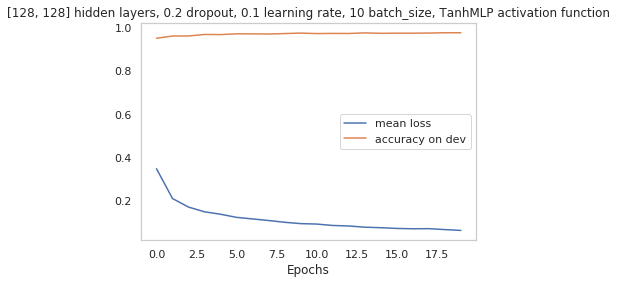

Starting epoch: 0
mean loss:  0.4634984546078893
dev accuracy:  0.9229
Starting epoch: 1
mean loss:  0.3058463247742006
dev accuracy:  0.9367
Starting epoch: 2
mean loss:  0.26850287256364574
dev accuracy:  0.9436
Starting epoch: 3
mean loss:  0.23838674162557263
dev accuracy:  0.9488
Starting epoch: 4
mean loss:  0.216081428150098
dev accuracy:  0.9544
Starting epoch: 5
mean loss:  0.1982074339173273
dev accuracy:  0.9568
Starting epoch: 6
mean loss:  0.18581071165864338
dev accuracy:  0.9577
Starting epoch: 7
mean loss:  0.1745347627280596
dev accuracy:  0.9613
Starting epoch: 8
mean loss:  0.1615007272930797
dev accuracy:  0.963
Starting epoch: 9
mean loss:  0.15649801813913677
dev accuracy:  0.9638
Starting epoch: 10
mean loss:  0.14866793793654012
dev accuracy:  0.9667
Starting epoch: 11
mean loss:  0.14200412020265699
dev accuracy:  0.9674
Starting epoch: 12
mean loss:  0.13816465013205054
dev accuracy:  0.968
Starting epoch: 13
mean loss:  0.13250598921895979
dev accuracy:  0.96

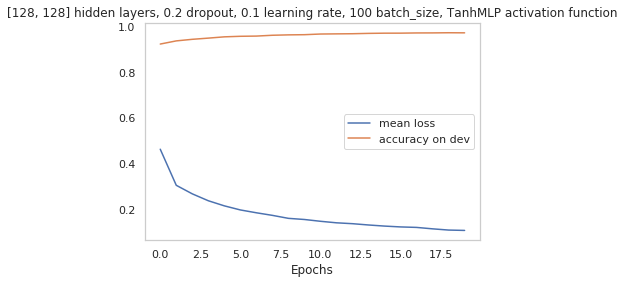

Starting epoch: 0
mean loss:  0.9384477769627291
dev accuracy:  0.8796
Starting epoch: 1
mean loss:  0.5029042579379737
dev accuracy:  0.9005
Starting epoch: 2
mean loss:  0.42653925921402724
dev accuracy:  0.9087
Starting epoch: 3
mean loss:  0.3879293326069327
dev accuracy:  0.9136
Starting epoch: 4
mean loss:  0.36312903902109933
dev accuracy:  0.9158
Starting epoch: 5
mean loss:  0.3501279774834128
dev accuracy:  0.9197
Starting epoch: 6
mean loss:  0.3362738677099639
dev accuracy:  0.9216
Starting epoch: 7
mean loss:  0.3255529503027598
dev accuracy:  0.9228
Starting epoch: 8
mean loss:  0.3173118730386098
dev accuracy:  0.9245
Starting epoch: 9
mean loss:  0.30686982238993926
dev accuracy:  0.926
Starting epoch: 10
mean loss:  0.30102383359974505
dev accuracy:  0.928
Starting epoch: 11
mean loss:  0.296274037045591
dev accuracy:  0.9294
Starting epoch: 12
mean loss:  0.2898902863848443
dev accuracy:  0.9306
Starting epoch: 13
mean loss:  0.2837385494335025
dev accuracy:  0.9317
S

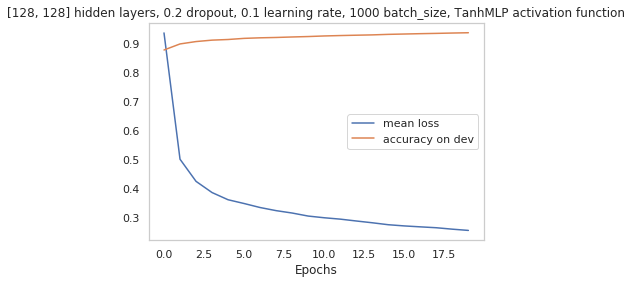

Starting epoch: 0
mean loss:  0.4883140338711601
dev accuracy:  0.9358
Starting epoch: 1
mean loss:  0.33760698291038854
dev accuracy:  0.9495
Starting epoch: 2
mean loss:  0.29276119112962906
dev accuracy:  0.9566
Starting epoch: 3
mean loss:  0.27027980899512055
dev accuracy:  0.9591
Starting epoch: 4
mean loss:  0.25473427950487154
dev accuracy:  0.9586
Starting epoch: 5
mean loss:  0.2405721465661735
dev accuracy:  0.961
Starting epoch: 6
mean loss:  0.2247137686735525
dev accuracy:  0.9608
Starting epoch: 7
mean loss:  0.22228864928644815
dev accuracy:  0.9675
Starting epoch: 8
mean loss:  0.212948574761251
dev accuracy:  0.9657
Starting epoch: 9
mean loss:  0.2020966899653533
dev accuracy:  0.9652
Starting epoch: 10
mean loss:  0.20315022463652474
dev accuracy:  0.9682
Starting epoch: 11
mean loss:  0.1941511442781761
dev accuracy:  0.9677
Starting epoch: 12
mean loss:  0.18692936182538328
dev accuracy:  0.9702
Starting epoch: 13
mean loss:  0.18835369504913377
dev accuracy:  0.9

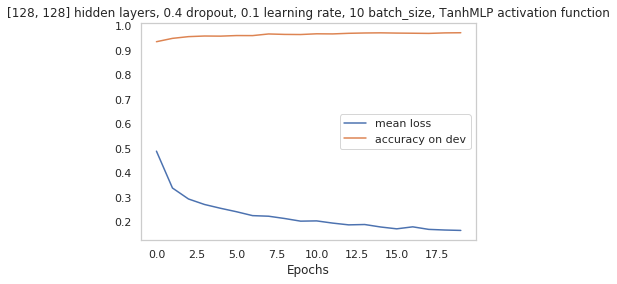

Starting epoch: 0
mean loss:  0.552126083753542
dev accuracy:  0.9162
Starting epoch: 1
mean loss:  0.38357261474617943
dev accuracy:  0.9259
Starting epoch: 2
mean loss:  0.3446407651086291
dev accuracy:  0.9333
Starting epoch: 3
mean loss:  0.32259750030116885
dev accuracy:  0.9375
Starting epoch: 4
mean loss:  0.30322101466848467
dev accuracy:  0.9424
Starting epoch: 5
mean loss:  0.28861091253226867
dev accuracy:  0.944
Starting epoch: 6
mean loss:  0.27451115993860953
dev accuracy:  0.949
Starting epoch: 7
mean loss:  0.2603124395280541
dev accuracy:  0.9512
Starting epoch: 8
mean loss:  0.25294160966328283
dev accuracy:  0.9515
Starting epoch: 9
mean loss:  0.24315467995113718
dev accuracy:  0.9539
Starting epoch: 10
mean loss:  0.23807029000775304
dev accuracy:  0.955
Starting epoch: 11
mean loss:  0.2289266081642129
dev accuracy:  0.9564
Starting epoch: 12
mean loss:  0.2236645377190884
dev accuracy:  0.958
Starting epoch: 13
mean loss:  0.2159144840167906
dev accuracy:  0.9587

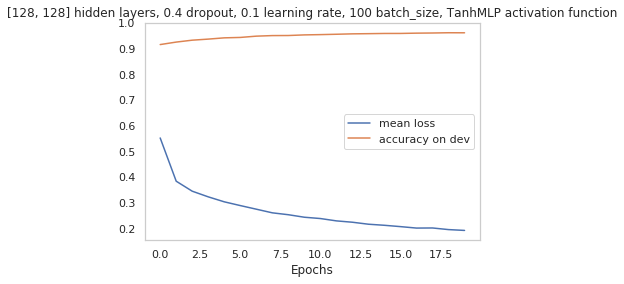

Starting epoch: 0
mean loss:  1.1331300560165853
dev accuracy:  0.8741
Starting epoch: 1
mean loss:  0.6128773549023796
dev accuracy:  0.8958
Starting epoch: 2
mean loss:  0.5142204597884533
dev accuracy:  0.9038
Starting epoch: 3
mean loss:  0.47204617834558676
dev accuracy:  0.9082
Starting epoch: 4
mean loss:  0.44383980129279343
dev accuracy:  0.9129
Starting epoch: 5
mean loss:  0.4244501193364461
dev accuracy:  0.9162
Starting epoch: 6
mean loss:  0.41234050778781667
dev accuracy:  0.9174
Starting epoch: 7
mean loss:  0.39764393661536424
dev accuracy:  0.9183
Starting epoch: 8
mean loss:  0.39189959098311034
dev accuracy:  0.9204
Starting epoch: 9
mean loss:  0.37879782447627947
dev accuracy:  0.9218
Starting epoch: 10
mean loss:  0.3738323111160129
dev accuracy:  0.9229
Starting epoch: 11
mean loss:  0.3674374602588953
dev accuracy:  0.9241
Starting epoch: 12
mean loss:  0.36523308064423354
dev accuracy:  0.9251
Starting epoch: 13
mean loss:  0.35766615178070815
dev accuracy:  0

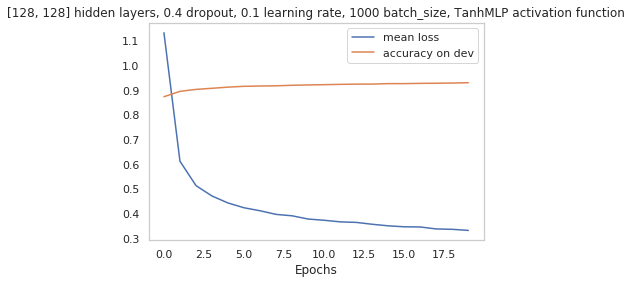

Starting epoch: 0
mean loss:  0.382843888809443
dev accuracy:  0.9311
Starting epoch: 1
mean loss:  0.22406955111389684
dev accuracy:  0.9475
Starting epoch: 2
mean loss:  0.17430780979527588
dev accuracy:  0.9572
Starting epoch: 3
mean loss:  0.14301427660217195
dev accuracy:  0.9622
Starting epoch: 4
mean loss:  0.12105838132983919
dev accuracy:  0.964
Starting epoch: 5
mean loss:  0.1046489999113987
dev accuracy:  0.9663
Starting epoch: 6
mean loss:  0.0918226210379791
dev accuracy:  0.9682
Starting epoch: 7
mean loss:  0.08143262643453834
dev accuracy:  0.9692
Starting epoch: 8
mean loss:  0.07277759944955971
dev accuracy:  0.9707
Starting epoch: 9
mean loss:  0.06540778928393833
dev accuracy:  0.9722
Starting epoch: 10
mean loss:  0.05902331980143797
dev accuracy:  0.973
Starting epoch: 11
mean loss:  0.05341989951863009
dev accuracy:  0.9739
Starting epoch: 12
mean loss:  0.04845554419506504
dev accuracy:  0.9742
Starting epoch: 13
mean loss:  0.04402745721570426
dev accuracy:  0

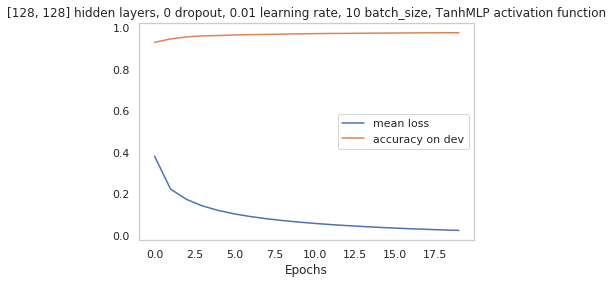

Starting epoch: 0
mean loss:  0.8658535445997577
dev accuracy:  0.8817
Starting epoch: 1
mean loss:  0.4425412339721611
dev accuracy:  0.9001
Starting epoch: 2
mean loss:  0.37190014219093703
dev accuracy:  0.9108
Starting epoch: 3
mean loss:  0.336556031645653
dev accuracy:  0.9165
Starting epoch: 4
mean loss:  0.3133250099277782
dev accuracy:  0.9208
Starting epoch: 5
mean loss:  0.2958890698151198
dev accuracy:  0.9237
Starting epoch: 6
mean loss:  0.281752217523828
dev accuracy:  0.9263
Starting epoch: 7
mean loss:  0.26971514237498095
dev accuracy:  0.9296
Starting epoch: 8
mean loss:  0.2591285110560958
dev accuracy:  0.9323
Starting epoch: 9
mean loss:  0.24961098925974554
dev accuracy:  0.9343
Starting epoch: 10
mean loss:  0.2409244633303907
dev accuracy:  0.9361
Starting epoch: 11
mean loss:  0.23291225383381645
dev accuracy:  0.938
Starting epoch: 12
mean loss:  0.2254661744731867
dev accuracy:  0.9404
Starting epoch: 13
mean loss:  0.21850804220178646
dev accuracy:  0.9418


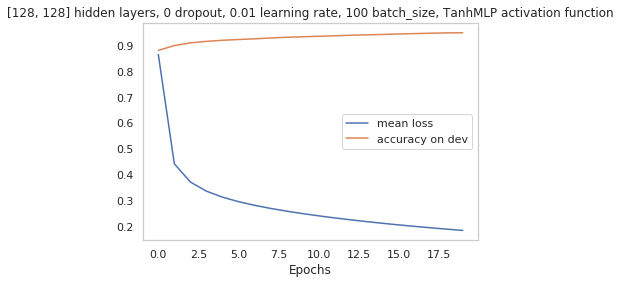

Starting epoch: 0
mean loss:  1.8131730322744333
dev accuracy:  0.6514
Starting epoch: 1
mean loss:  1.2323509875465841
dev accuracy:  0.7686
Starting epoch: 2
mean loss:  0.9744230006255356
dev accuracy:  0.8124
Starting epoch: 3
mean loss:  0.8296720163494933
dev accuracy:  0.8348
Starting epoch: 4
mean loss:  0.7365207824052549
dev accuracy:  0.8482
Starting epoch: 5
mean loss:  0.6710385154275333
dev accuracy:  0.8582
Starting epoch: 6
mean loss:  0.6221477997069266
dev accuracy:  0.8643
Starting epoch: 7
mean loss:  0.5840370012264625
dev accuracy:  0.8707
Starting epoch: 8
mean loss:  0.5533611225146874
dev accuracy:  0.8768
Starting epoch: 9
mean loss:  0.5280529324914894
dev accuracy:  0.8803
Starting epoch: 10
mean loss:  0.5067609811530394
dev accuracy:  0.8844
Starting epoch: 11
mean loss:  0.48856104121488686
dev accuracy:  0.8871
Starting epoch: 12
mean loss:  0.47279733828469817
dev accuracy:  0.8893
Starting epoch: 13
mean loss:  0.4589902443044326
dev accuracy:  0.8915


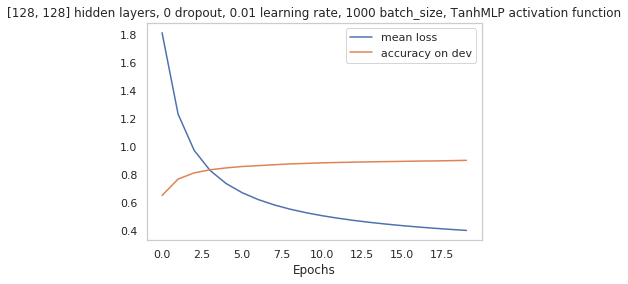

Starting epoch: 0
mean loss:  0.4576062100122474
dev accuracy:  0.9245
Starting epoch: 1
mean loss:  0.3035848272969573
dev accuracy:  0.9378
Starting epoch: 2
mean loss:  0.26051994419701946
dev accuracy:  0.9461
Starting epoch: 3
mean loss:  0.2321995116271737
dev accuracy:  0.9519
Starting epoch: 4
mean loss:  0.21379259159169098
dev accuracy:  0.9553
Starting epoch: 5
mean loss:  0.19710621184337856
dev accuracy:  0.9582
Starting epoch: 6
mean loss:  0.18371067837436944
dev accuracy:  0.9597
Starting epoch: 7
mean loss:  0.17429949819504018
dev accuracy:  0.9623
Starting epoch: 8
mean loss:  0.1637953797119158
dev accuracy:  0.9628
Starting epoch: 9
mean loss:  0.15732666878680568
dev accuracy:  0.965
Starting epoch: 10
mean loss:  0.14656758882597037
dev accuracy:  0.9669
Starting epoch: 11
mean loss:  0.14182172046337496
dev accuracy:  0.9663
Starting epoch: 12
mean loss:  0.13493594240716456
dev accuracy:  0.9683
Starting epoch: 13
mean loss:  0.13258265366257413
dev accuracy:  

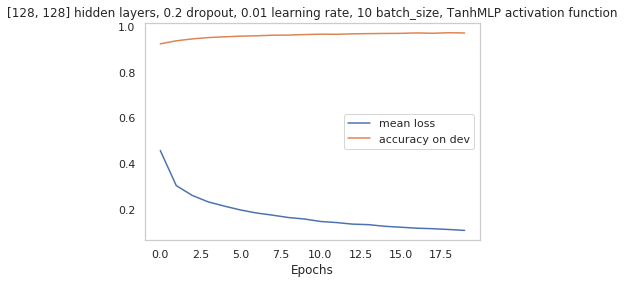

Starting epoch: 0
mean loss:  0.9726841634143136
dev accuracy:  0.8812
Starting epoch: 1
mean loss:  0.5147358784061706
dev accuracy:  0.9001
Starting epoch: 2
mean loss:  0.4349664563606837
dev accuracy:  0.9084
Starting epoch: 3
mean loss:  0.39720072063381323
dev accuracy:  0.9133
Starting epoch: 4
mean loss:  0.3725208679061688
dev accuracy:  0.9165
Starting epoch: 5
mean loss:  0.3545342924114235
dev accuracy:  0.9203
Starting epoch: 6
mean loss:  0.3416740518368171
dev accuracy:  0.9215
Starting epoch: 7
mean loss:  0.3300085546906123
dev accuracy:  0.9231
Starting epoch: 8
mean loss:  0.3230067166739595
dev accuracy:  0.9247
Starting epoch: 9
mean loss:  0.31350199113824884
dev accuracy:  0.9255
Starting epoch: 10
mean loss:  0.30788558224836987
dev accuracy:  0.9276
Starting epoch: 11
mean loss:  0.29959610512037715
dev accuracy:  0.9281
Starting epoch: 12
mean loss:  0.29420395605935307
dev accuracy:  0.9296
Starting epoch: 13
mean loss:  0.290725572127663
dev accuracy:  0.930

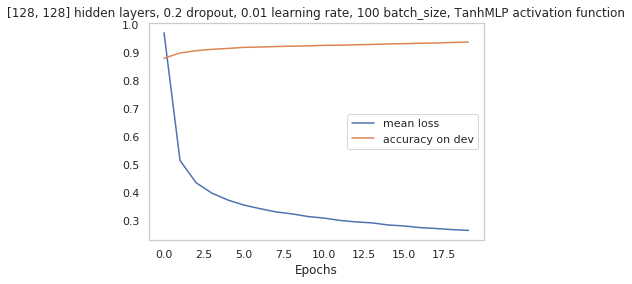

Starting epoch: 0
mean loss:  1.9608288302141077
dev accuracy:  0.6431
Starting epoch: 1
mean loss:  1.3366334625318939
dev accuracy:  0.7579
Starting epoch: 2
mean loss:  1.046688577708076
dev accuracy:  0.8065
Starting epoch: 3
mean loss:  0.8914627795125923
dev accuracy:  0.8303
Starting epoch: 4
mean loss:  0.796411018745572
dev accuracy:  0.8466
Starting epoch: 5
mean loss:  0.7265574955472759
dev accuracy:  0.8543
Starting epoch: 6
mean loss:  0.6787262816055148
dev accuracy:  0.8603
Starting epoch: 7
mean loss:  0.6385775629211875
dev accuracy:  0.8658
Starting epoch: 8
mean loss:  0.6085746124678967
dev accuracy:  0.8702
Starting epoch: 9
mean loss:  0.5817200973922131
dev accuracy:  0.8738
Starting epoch: 10
mean loss:  0.5613253373725742
dev accuracy:  0.8778
Starting epoch: 11
mean loss:  0.542355909651401
dev accuracy:  0.8816
Starting epoch: 12
mean loss:  0.527725091751884
dev accuracy:  0.8846
Starting epoch: 13
mean loss:  0.5122678314938265
dev accuracy:  0.8865
Starti

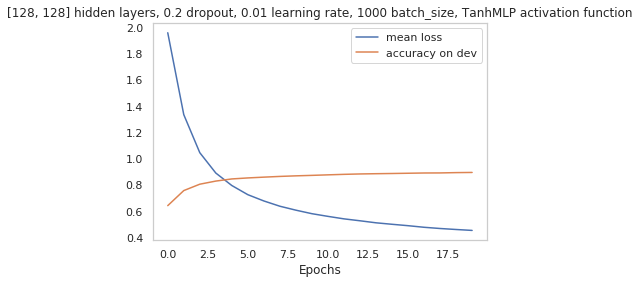

Starting epoch: 0
mean loss:  0.5533938451305663
dev accuracy:  0.9173
Starting epoch: 1
mean loss:  0.38103927388061726
dev accuracy:  0.9269
Starting epoch: 2
mean loss:  0.3457271358479836
dev accuracy:  0.9321
Starting epoch: 3
mean loss:  0.32077720513058183
dev accuracy:  0.9373
Starting epoch: 4
mean loss:  0.2982133719796835
dev accuracy:  0.94
Starting epoch: 5
mean loss:  0.28481737173916993
dev accuracy:  0.9435
Starting epoch: 6
mean loss:  0.26989138113644656
dev accuracy:  0.9462
Starting epoch: 7
mean loss:  0.26325646853764406
dev accuracy:  0.9489
Starting epoch: 8
mean loss:  0.255081100734813
dev accuracy:  0.9502
Starting epoch: 9
mean loss:  0.24687581069240824
dev accuracy:  0.9527
Starting epoch: 10
mean loss:  0.23716483729924254
dev accuracy:  0.9544
Starting epoch: 11
mean loss:  0.23032215057177235
dev accuracy:  0.9573
Starting epoch: 12
mean loss:  0.22702887497249738
dev accuracy:  0.9566
Starting epoch: 13
mean loss:  0.2189743663554006
dev accuracy:  0.9

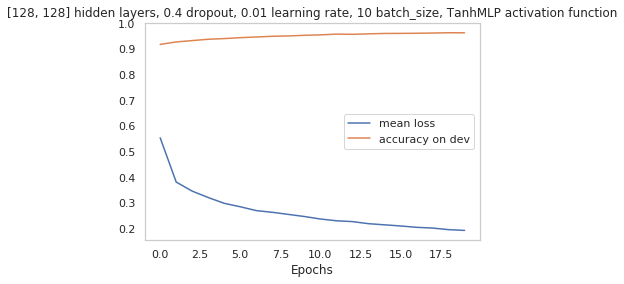

Starting epoch: 0
mean loss:  1.0925468880973177
dev accuracy:  0.8743
Starting epoch: 1
mean loss:  0.6072479533459136
dev accuracy:  0.8967
Starting epoch: 2
mean loss:  0.5132758085004346
dev accuracy:  0.9047
Starting epoch: 3
mean loss:  0.46894552589890487
dev accuracy:  0.9097
Starting epoch: 4
mean loss:  0.4440543925809765
dev accuracy:  0.9133
Starting epoch: 5
mean loss:  0.4258152664064647
dev accuracy:  0.916
Starting epoch: 6
mean loss:  0.40972128751392134
dev accuracy:  0.9174
Starting epoch: 7
mean loss:  0.402166047704196
dev accuracy:  0.9191
Starting epoch: 8
mean loss:  0.3904012231650705
dev accuracy:  0.9217
Starting epoch: 9
mean loss:  0.3836777647157867
dev accuracy:  0.9222
Starting epoch: 10
mean loss:  0.37679969479223924
dev accuracy:  0.9232
Starting epoch: 11
mean loss:  0.37028363326233543
dev accuracy:  0.924
Starting epoch: 12
mean loss:  0.3667992202643149
dev accuracy:  0.9247
Starting epoch: 13
mean loss:  0.3576957792519571
dev accuracy:  0.9262
S

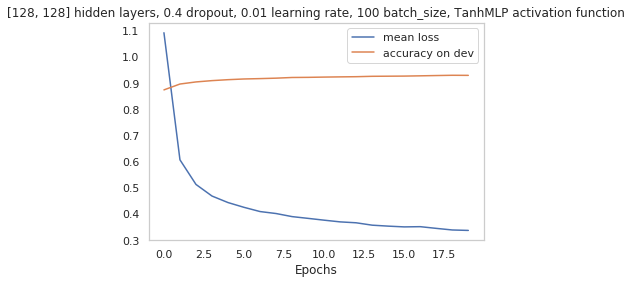

Starting epoch: 0
mean loss:  2.1604631274354222
dev accuracy:  0.6387
Starting epoch: 1
mean loss:  1.5507090816310807
dev accuracy:  0.7635
Starting epoch: 2
mean loss:  1.235373057571112
dev accuracy:  0.8095
Starting epoch: 3
mean loss:  1.0560119666305243
dev accuracy:  0.8345
Starting epoch: 4
mean loss:  0.9379430541805193
dev accuracy:  0.8503
Starting epoch: 5
mean loss:  0.8615126504617578
dev accuracy:  0.8584
Starting epoch: 6
mean loss:  0.8041839038624483
dev accuracy:  0.8657
Starting epoch: 7
mean loss:  0.7570235179919823
dev accuracy:  0.8728
Starting epoch: 8
mean loss:  0.7214462768797781
dev accuracy:  0.8774
Starting epoch: 9
mean loss:  0.6929916447284175
dev accuracy:  0.8817
Starting epoch: 10
mean loss:  0.6644097987343284
dev accuracy:  0.8839
Starting epoch: 11
mean loss:  0.646794877800287
dev accuracy:  0.8868
Starting epoch: 12
mean loss:  0.620520667702544
dev accuracy:  0.8882
Starting epoch: 13
mean loss:  0.6088790998739355
dev accuracy:  0.8907
Start

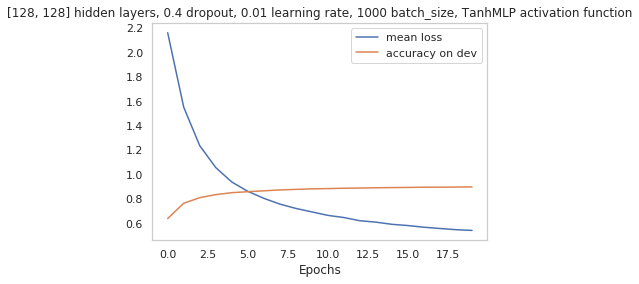

Starting epoch: 0
mean loss:  0.8978491591494862
dev accuracy:  0.8832
Starting epoch: 1
mean loss:  0.4557956354459794
dev accuracy:  0.9046
Starting epoch: 2
mean loss:  0.3804553410511742
dev accuracy:  0.9141
Starting epoch: 3
mean loss:  0.3434261948524285
dev accuracy:  0.9184
Starting epoch: 4
mean loss:  0.3195355356199947
dev accuracy:  0.9226
Starting epoch: 5
mean loss:  0.3018605041741681
dev accuracy:  0.9262
Starting epoch: 6
mean loss:  0.2876726293402272
dev accuracy:  0.9289
Starting epoch: 7
mean loss:  0.2756687219218731
dev accuracy:  0.9302
Starting epoch: 8
mean loss:  0.2651458042907482
dev accuracy:  0.9329
Starting epoch: 9
mean loss:  0.2556918243345166
dev accuracy:  0.9351
Starting epoch: 10
mean loss:  0.247050601699913
dev accuracy:  0.9369
Starting epoch: 11
mean loss:  0.23905611576311703
dev accuracy:  0.939
Starting epoch: 12
mean loss:  0.23159733834573834
dev accuracy:  0.9419
Starting epoch: 13
mean loss:  0.22459789047602818
dev accuracy:  0.9434
S

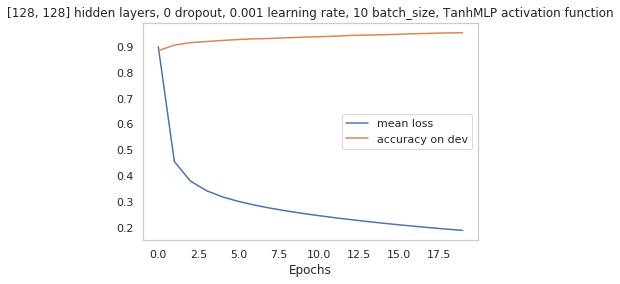

Starting epoch: 0
mean loss:  1.86436132589976
dev accuracy:  0.6474
Starting epoch: 1
mean loss:  1.3039118965228875
dev accuracy:  0.7599
Starting epoch: 2
mean loss:  1.0263982538929481
dev accuracy:  0.8027
Starting epoch: 3
mean loss:  0.8681284228484788
dev accuracy:  0.8313
Starting epoch: 4
mean loss:  0.7669025541779524
dev accuracy:  0.8465
Starting epoch: 5
mean loss:  0.6962486020105327
dev accuracy:  0.858
Starting epoch: 6
mean loss:  0.6437467709034979
dev accuracy:  0.8654
Starting epoch: 7
mean loss:  0.60293955663721
dev accuracy:  0.8715
Starting epoch: 8
mean loss:  0.5701550973984534
dev accuracy:  0.8761
Starting epoch: 9
mean loss:  0.5431459383098427
dev accuracy:  0.8809
Starting epoch: 10
mean loss:  0.5204523014213273
dev accuracy:  0.884
Starting epoch: 11
mean loss:  0.5010795127488896
dev accuracy:  0.8865
Starting epoch: 12
mean loss:  0.48432309357468
dev accuracy:  0.8891
Starting epoch: 13
mean loss:  0.4696680851087361
dev accuracy:  0.8926
Starting e

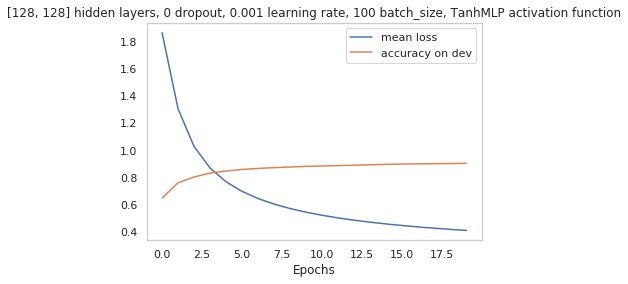

Starting epoch: 0
mean loss:  2.244431556439867
dev accuracy:  0.179
Starting epoch: 1
mean loss:  2.074406623840332
dev accuracy:  0.2802
Starting epoch: 2
mean loss:  1.9484770858989042
dev accuracy:  0.3809
Starting epoch: 3
mean loss:  1.8435891586191513
dev accuracy:  0.452
Starting epoch: 4
mean loss:  1.7520573606678085
dev accuracy:  0.5071
Starting epoch: 5
mean loss:  1.6704864385081273
dev accuracy:  0.5541
Starting epoch: 6
mean loss:  1.597004119087668
dev accuracy:  0.591
Starting epoch: 7
mean loss:  1.5303832058813058
dev accuracy:  0.6186
Starting epoch: 8
mean loss:  1.469718383807762
dev accuracy:  0.6446
Starting epoch: 9
mean loss:  1.4142908231884825
dev accuracy:  0.6663
Starting epoch: 10
mean loss:  1.363503430403915
dev accuracy:  0.6852
Starting epoch: 11
mean loss:  1.3168471794502408
dev accuracy:  0.7001
Starting epoch: 12
mean loss:  1.2738816434261846
dev accuracy:  0.7123
Starting epoch: 13
mean loss:  1.2342221082425584
dev accuracy:  0.7265
Starting e

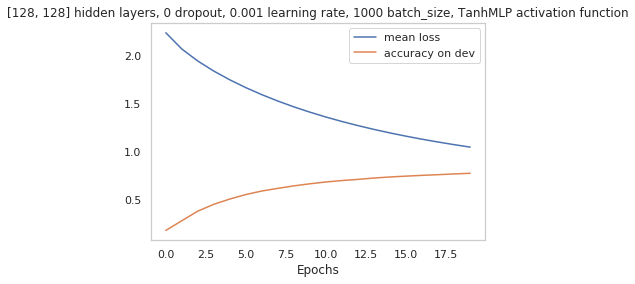

Starting epoch: 0
mean loss:  0.9685939010638662
dev accuracy:  0.877
Starting epoch: 1
mean loss:  0.5222812005875707
dev accuracy:  0.898
Starting epoch: 2
mean loss:  0.4404226404344158
dev accuracy:  0.907
Starting epoch: 3
mean loss:  0.39941889431511574
dev accuracy:  0.9121
Starting epoch: 4
mean loss:  0.3750126056372747
dev accuracy:  0.9149
Starting epoch: 5
mean loss:  0.3591251315232802
dev accuracy:  0.9179
Starting epoch: 6
mean loss:  0.3434017291380075
dev accuracy:  0.9209
Starting epoch: 7
mean loss:  0.33454321053101077
dev accuracy:  0.9228
Starting epoch: 8
mean loss:  0.32402703696830204
dev accuracy:  0.9257
Starting epoch: 9
mean loss:  0.3165823291144316
dev accuracy:  0.928
Starting epoch: 10
mean loss:  0.30956423250703935
dev accuracy:  0.9288
Starting epoch: 11
mean loss:  0.30246515219412495
dev accuracy:  0.9302
Starting epoch: 12
mean loss:  0.29806197948585855
dev accuracy:  0.9312
Starting epoch: 13
mean loss:  0.2914314065761738
dev accuracy:  0.9322


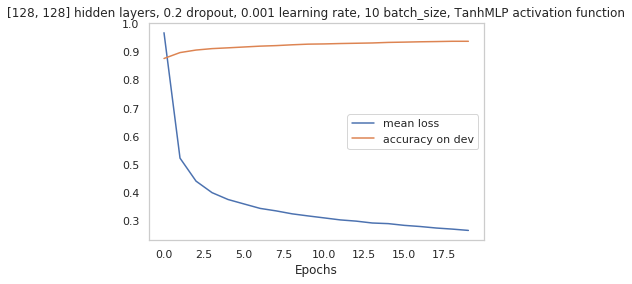

Starting epoch: 0
mean loss:  2.0279888247777365
dev accuracy:  0.5998
Starting epoch: 1
mean loss:  1.3997227888621255
dev accuracy:  0.7464
Starting epoch: 2
mean loss:  1.1030664670015287
dev accuracy:  0.8049
Starting epoch: 3
mean loss:  0.935960083902477
dev accuracy:  0.8333
Starting epoch: 4
mean loss:  0.8331525489955605
dev accuracy:  0.8486
Starting epoch: 5
mean loss:  0.7554838555063792
dev accuracy:  0.8596
Starting epoch: 6
mean loss:  0.7037247519293232
dev accuracy:  0.8676
Starting epoch: 7
mean loss:  0.663698320974133
dev accuracy:  0.873
Starting epoch: 8
mean loss:  0.6312289399777106
dev accuracy:  0.876
Starting epoch: 9
mean loss:  0.6036838617867338
dev accuracy:  0.88
Starting epoch: 10
mean loss:  0.5794833615987363
dev accuracy:  0.8844
Starting epoch: 11
mean loss:  0.5615486933918532
dev accuracy:  0.8873
Starting epoch: 12
mean loss:  0.543254398895119
dev accuracy:  0.8896
Starting epoch: 13
mean loss:  0.5277271912007513
dev accuracy:  0.8926
Starting 

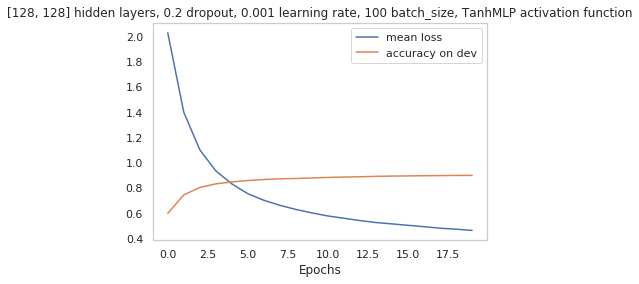

Starting epoch: 0
mean loss:  2.405544266981237
dev accuracy:  0.1606
Starting epoch: 1
mean loss:  2.2586330946754005
dev accuracy:  0.241
Starting epoch: 2
mean loss:  2.137248623604868
dev accuracy:  0.3159
Starting epoch: 3
mean loss:  2.0325908988129857
dev accuracy:  0.3802
Starting epoch: 4
mean loss:  1.9383500814437866
dev accuracy:  0.4481
Starting epoch: 5
mean loss:  1.8529626715417002
dev accuracy:  0.5082
Starting epoch: 6
mean loss:  1.775049279717838
dev accuracy:  0.5539
Starting epoch: 7
mean loss:  1.697999451674667
dev accuracy:  0.5946
Starting epoch: 8
mean loss:  1.634425069771561
dev accuracy:  0.626
Starting epoch: 9
mean loss:  1.5726728719823502
dev accuracy:  0.6535
Starting epoch: 10
mean loss:  1.5156436807969038
dev accuracy:  0.6717
Starting epoch: 11
mean loss:  1.4602919466355269
dev accuracy:  0.6913
Starting epoch: 12
mean loss:  1.4129774804208792
dev accuracy:  0.7063
Starting epoch: 13
mean loss:  1.3674994753856284
dev accuracy:  0.719
Starting e

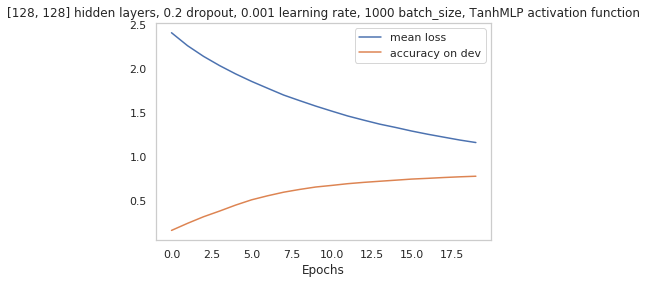

Starting epoch: 0
mean loss:  1.0899569363093238
dev accuracy:  0.8781
Starting epoch: 1
mean loss:  0.6076087317310483
dev accuracy:  0.8965
Starting epoch: 2
mean loss:  0.5170515429096695
dev accuracy:  0.9058
Starting epoch: 3
mean loss:  0.4733063126229818
dev accuracy:  0.9095
Starting epoch: 4
mean loss:  0.4462620336022336
dev accuracy:  0.9126
Starting epoch: 5
mean loss:  0.4292073843799944
dev accuracy:  0.9145
Starting epoch: 6
mean loss:  0.41505320799209056
dev accuracy:  0.9169
Starting epoch: 7
mean loss:  0.401555964232893
dev accuracy:  0.918
Starting epoch: 8
mean loss:  0.39375016888425907
dev accuracy:  0.9192
Starting epoch: 9
mean loss:  0.3840594177175864
dev accuracy:  0.9204
Starting epoch: 10
mean loss:  0.38050961695813346
dev accuracy:  0.9223
Starting epoch: 11
mean loss:  0.37234785568551604
dev accuracy:  0.923
Starting epoch: 12
mean loss:  0.3671839019902672
dev accuracy:  0.9246
Starting epoch: 13
mean loss:  0.35733136698421875
dev accuracy:  0.9244


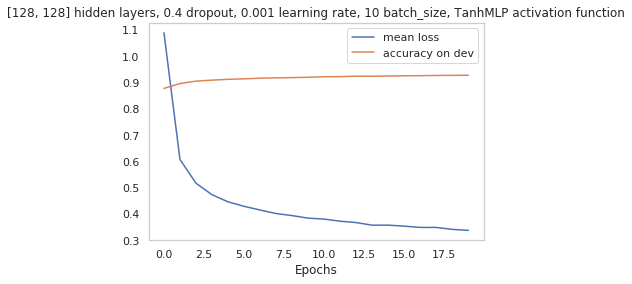

Starting epoch: 0
mean loss:  2.17957216679693
dev accuracy:  0.617
Starting epoch: 1
mean loss:  1.55734683153872
dev accuracy:  0.7501
Starting epoch: 2
mean loss:  1.251261834374921
dev accuracy:  0.804
Starting epoch: 3
mean loss:  1.0762324679397537
dev accuracy:  0.8282
Starting epoch: 4
mean loss:  0.9611544760163435
dev accuracy:  0.8432
Starting epoch: 5
mean loss:  0.8836487945682274
dev accuracy:  0.8544
Starting epoch: 6
mean loss:  0.8264548882039008
dev accuracy:  0.8621
Starting epoch: 7
mean loss:  0.7815814514360028
dev accuracy:  0.8677
Starting epoch: 8
mean loss:  0.7477259947630222
dev accuracy:  0.8725
Starting epoch: 9
mean loss:  0.7158241106602484
dev accuracy:  0.877
Starting epoch: 10
mean loss:  0.6900149678993606
dev accuracy:  0.8797
Starting epoch: 11
mean loss:  0.6641853600443004
dev accuracy:  0.8825
Starting epoch: 12
mean loss:  0.6505987173069023
dev accuracy:  0.8854
Starting epoch: 13
mean loss:  0.6287004292130233
dev accuracy:  0.8881
Starting e

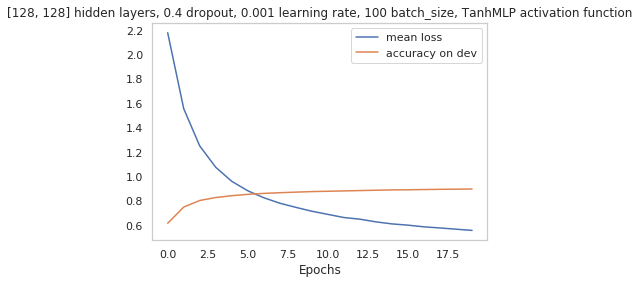

Starting epoch: 0
mean loss:  2.6513919129091152
dev accuracy:  0.124
Starting epoch: 1
mean loss:  2.533000529981127
dev accuracy:  0.1759
Starting epoch: 2
mean loss:  2.4305305808198217
dev accuracy:  0.2329
Starting epoch: 3
mean loss:  2.348227351319556
dev accuracy:  0.2914
Starting epoch: 4
mean loss:  2.2518971574072744
dev accuracy:  0.3512
Starting epoch: 5
mean loss:  2.1775667527142692
dev accuracy:  0.4079
Starting epoch: 6
mean loss:  2.102664437948489
dev accuracy:  0.457
Starting epoch: 7
mean loss:  2.0323479923547483
dev accuracy:  0.4991
Starting epoch: 8
mean loss:  1.9699127276738484
dev accuracy:  0.5378
Starting epoch: 9
mean loss:  1.9039693042343737
dev accuracy:  0.5669
Starting epoch: 10
mean loss:  1.8511632213405533
dev accuracy:  0.5922
Starting epoch: 11
mean loss:  1.7954843862383973
dev accuracy:  0.6157
Starting epoch: 12
mean loss:  1.7404588694665946
dev accuracy:  0.638
Starting epoch: 13
mean loss:  1.6934834110970591
dev accuracy:  0.6582
Starting

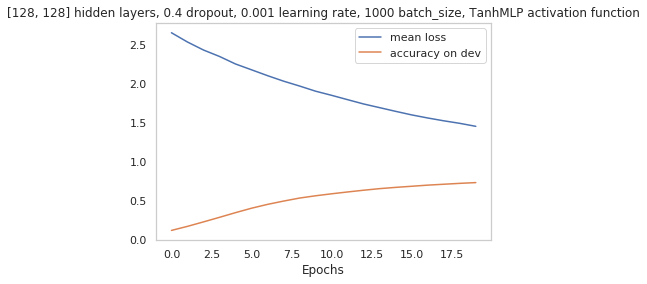

Starting epoch: 0
mean loss:  0.3146085696251327
dev accuracy:  0.9433
Starting epoch: 1
mean loss:  0.1739078935852989
dev accuracy:  0.9497
Starting epoch: 2
mean loss:  0.13748053309645103
dev accuracy:  0.9572
Starting epoch: 3
mean loss:  0.11269139828087497
dev accuracy:  0.9614
Starting epoch: 4
mean loss:  0.10947143638231288
dev accuracy:  0.9626
Starting epoch: 5
mean loss:  0.09078818498340589
dev accuracy:  0.9675
Starting epoch: 6
mean loss:  0.08736800358611535
dev accuracy:  0.957
Starting epoch: 7
mean loss:  0.07794959156434027
dev accuracy:  0.9622
Starting epoch: 8
mean loss:  0.07723919124002124
dev accuracy:  0.9621
Starting epoch: 9
mean loss:  0.07430696247715017
dev accuracy:  0.9656
Starting epoch: 10
mean loss:  0.07208032737970209
dev accuracy:  0.967
Starting epoch: 11
mean loss:  0.07094177367577294
dev accuracy:  0.968
Starting epoch: 12
mean loss:  0.06256126813997247
dev accuracy:  0.9685
Starting epoch: 13
mean loss:  0.06986292887822564
dev accuracy:  

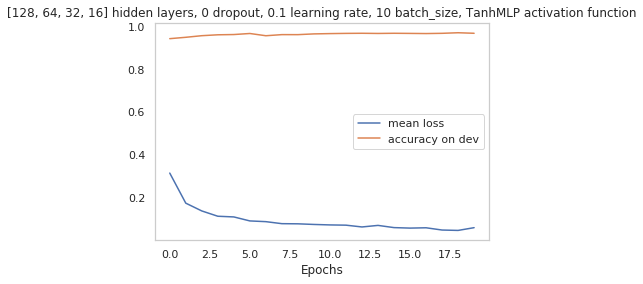

Starting epoch: 0
mean loss:  0.45369576552730356
dev accuracy:  0.9359
Starting epoch: 1
mean loss:  0.19822414762929766
dev accuracy:  0.9547
Starting epoch: 2
mean loss:  0.14521245916416783
dev accuracy:  0.9633
Starting epoch: 3
mean loss:  0.1150075212834838
dev accuracy:  0.9682
Starting epoch: 4
mean loss:  0.0939232503136475
dev accuracy:  0.9693
Starting epoch: 5
mean loss:  0.07818088900416852
dev accuracy:  0.9702
Starting epoch: 6
mean loss:  0.06562814375984216
dev accuracy:  0.9696
Starting epoch: 7
mean loss:  0.0554358662457434
dev accuracy:  0.9695
Starting epoch: 8
mean loss:  0.047127151943579644
dev accuracy:  0.9702
Starting epoch: 9
mean loss:  0.04018394183274544
dev accuracy:  0.9707
Starting epoch: 10
mean loss:  0.03428697376233152
dev accuracy:  0.9715
Starting epoch: 11
mean loss:  0.029187650985815033
dev accuracy:  0.9718
Starting epoch: 12
mean loss:  0.024874573671993264
dev accuracy:  0.9719
Starting epoch: 13
mean loss:  0.021207550267768865
dev accur

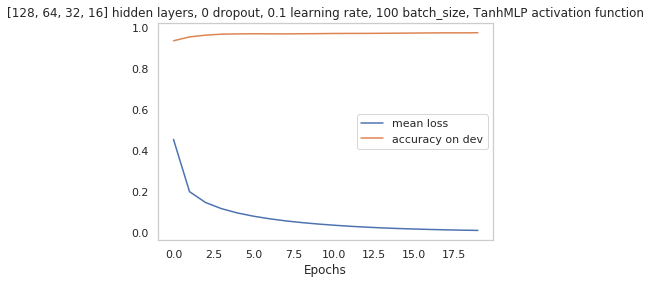

Starting epoch: 0
mean loss:  1.1483147378061331
dev accuracy:  0.8579
Starting epoch: 1
mean loss:  0.5961603481395572
dev accuracy:  0.8921
Starting epoch: 2
mean loss:  0.4488755943728428
dev accuracy:  0.9112
Starting epoch: 3
mean loss:  0.374243567387263
dev accuracy:  0.9212
Starting epoch: 4
mean loss:  0.32762208756278544
dev accuracy:  0.9284
Starting epoch: 5
mean loss:  0.29461837136277963
dev accuracy:  0.9339
Starting epoch: 6
mean loss:  0.269404050766253
dev accuracy:  0.9374
Starting epoch: 7
mean loss:  0.2491650128481435
dev accuracy:  0.9414
Starting epoch: 8
mean loss:  0.2323435682292078
dev accuracy:  0.9447
Starting epoch: 9
mean loss:  0.2179933616928026
dev accuracy:  0.9463
Starting epoch: 10
mean loss:  0.2055020043078591
dev accuracy:  0.949
Starting epoch: 11
mean loss:  0.19445379633529514
dev accuracy:  0.9509
Starting epoch: 12
mean loss:  0.18455673900305056
dev accuracy:  0.9525
Starting epoch: 13
mean loss:  0.17560128984498044
dev accuracy:  0.954
S

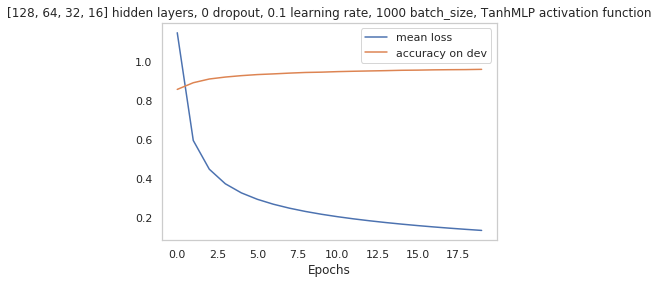

Starting epoch: 0
mean loss:  0.5411509709949316
dev accuracy:  0.9296
Starting epoch: 1
mean loss:  0.35640851328072337
dev accuracy:  0.9445
Starting epoch: 2
mean loss:  0.3127601189904587
dev accuracy:  0.9513
Starting epoch: 3
mean loss:  0.2905089577220096
dev accuracy:  0.9537
Starting epoch: 4
mean loss:  0.27639934553617085
dev accuracy:  0.9565
Starting epoch: 5
mean loss:  0.26032618816278635
dev accuracy:  0.9584
Starting epoch: 6
mean loss:  0.24796318863612582
dev accuracy:  0.9596
Starting epoch: 7
mean loss:  0.24230597253424768
dev accuracy:  0.9621
Starting epoch: 8
mean loss:  0.23389784854417192
dev accuracy:  0.9642
Starting epoch: 9
mean loss:  0.23083532323576234
dev accuracy:  0.9622
Starting epoch: 10
mean loss:  0.2212927050910327
dev accuracy:  0.9642
Starting epoch: 11
mean loss:  0.22740589468187763
dev accuracy:  0.9649
Starting epoch: 12
mean loss:  0.22241274004240075
dev accuracy:  0.9607
Starting epoch: 13
mean loss:  0.2204946777299609
dev accuracy:  

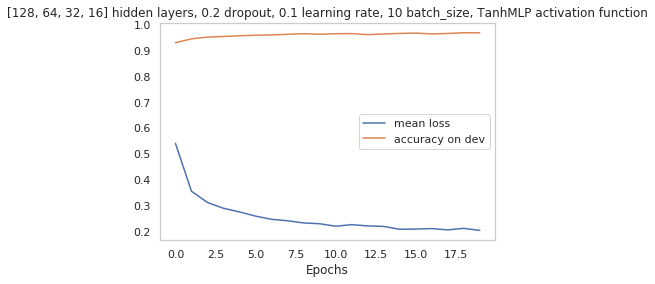

Starting epoch: 0
mean loss:  0.7514388807519468
dev accuracy:  0.9127
Starting epoch: 1
mean loss:  0.4603307209685891
dev accuracy:  0.9225
Starting epoch: 2
mean loss:  0.3860123375813642
dev accuracy:  0.9386
Starting epoch: 3
mean loss:  0.3460392855598541
dev accuracy:  0.9457
Starting epoch: 4
mean loss:  0.3157965712353379
dev accuracy:  0.9512
Starting epoch: 5
mean loss:  0.2938322997586932
dev accuracy:  0.9524
Starting epoch: 6
mean loss:  0.2747209583020615
dev accuracy:  0.9584
Starting epoch: 7
mean loss:  0.2615483695280528
dev accuracy:  0.9592
Starting epoch: 8
mean loss:  0.2468573493574432
dev accuracy:  0.9623
Starting epoch: 9
mean loss:  0.23492622693736634
dev accuracy:  0.9635
Starting epoch: 10
mean loss:  0.22491317748012182
dev accuracy:  0.9664
Starting epoch: 11
mean loss:  0.21624533243165045
dev accuracy:  0.964
Starting epoch: 12
mean loss:  0.212185804038764
dev accuracy:  0.9665
Starting epoch: 13
mean loss:  0.20565161596753165
dev accuracy:  0.9686


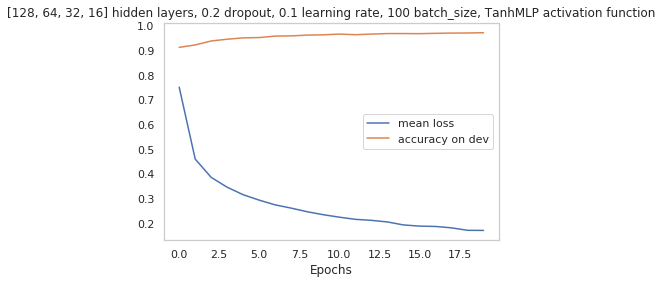

Starting epoch: 0
mean loss:  1.3863474668241014
dev accuracy:  0.8317
Starting epoch: 1
mean loss:  0.8991426206102558
dev accuracy:  0.8773
Starting epoch: 2
mean loss:  0.7332548148491803
dev accuracy:  0.8947
Starting epoch: 3
mean loss:  0.6475540855351616
dev accuracy:  0.9019
Starting epoch: 4
mean loss:  0.5869002014982934
dev accuracy:  0.9065
Starting epoch: 5
mean loss:  0.5453994893560222
dev accuracy:  0.9121
Starting epoch: 6
mean loss:  0.5155710671462265
dev accuracy:  0.9141
Starting epoch: 7
mean loss:  0.49115176528107884
dev accuracy:  0.9167
Starting epoch: 8
mean loss:  0.46936410840819864
dev accuracy:  0.9197
Starting epoch: 9
mean loss:  0.4563981867304035
dev accuracy:  0.9217
Starting epoch: 10
mean loss:  0.4458123170862011
dev accuracy:  0.9243
Starting epoch: 11
mean loss:  0.4342661085082035
dev accuracy:  0.9261
Starting epoch: 12
mean loss:  0.42012309502152834
dev accuracy:  0.9269
Starting epoch: 13
mean loss:  0.41289258587594124
dev accuracy:  0.928

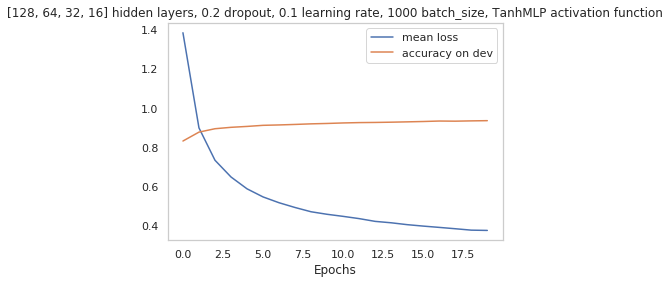

Starting epoch: 0
mean loss:  0.9662783226310027
dev accuracy:  0.8875
Starting epoch: 1
mean loss:  0.6986663011125245
dev accuracy:  0.909
Starting epoch: 2
mean loss:  0.6618580151139987
dev accuracy:  0.9223
Starting epoch: 3
mean loss:  0.6312777231965296
dev accuracy:  0.9252
Starting epoch: 4
mean loss:  0.6153777636612947
dev accuracy:  0.9257
Starting epoch: 5
mean loss:  0.601243194843326
dev accuracy:  0.926
Starting epoch: 6
mean loss:  0.6100478686997174
dev accuracy:  0.9256
Starting epoch: 7
mean loss:  0.6046906949434906
dev accuracy:  0.9286
Starting epoch: 8
mean loss:  0.6192510668951865
dev accuracy:  0.9188
Starting epoch: 9
mean loss:  0.620168805675098
dev accuracy:  0.9279
Starting epoch: 10
mean loss:  0.608575915112135
dev accuracy:  0.9281
Starting epoch: 11
mean loss:  0.6026953707928301
dev accuracy:  0.9311
Starting epoch: 12
mean loss:  0.5891509328564151
dev accuracy:  0.9352
Starting epoch: 13
mean loss:  0.5967723646943681
dev accuracy:  0.9309
Startin

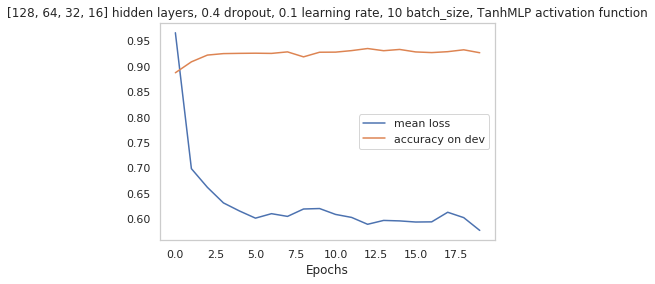

Starting epoch: 0
mean loss:  1.2018522661841082
dev accuracy:  0.8776
Starting epoch: 1
mean loss:  0.8052522437182253
dev accuracy:  0.9019
Starting epoch: 2
mean loss:  0.6853095666615073
dev accuracy:  0.912
Starting epoch: 3
mean loss:  0.6217529688647645
dev accuracy:  0.9174
Starting epoch: 4
mean loss:  0.5828060775459883
dev accuracy:  0.9246
Starting epoch: 5
mean loss:  0.5508270558125958
dev accuracy:  0.9266
Starting epoch: 6
mean loss:  0.5272804628351253
dev accuracy:  0.9307
Starting epoch: 7
mean loss:  0.508353019367435
dev accuracy:  0.9308
Starting epoch: 8
mean loss:  0.49445571751889594
dev accuracy:  0.9348
Starting epoch: 9
mean loss:  0.47961851469651906
dev accuracy:  0.9368
Starting epoch: 10
mean loss:  0.4632088563101972
dev accuracy:  0.9398
Starting epoch: 11
mean loss:  0.4514718677945242
dev accuracy:  0.9421
Starting epoch: 12
mean loss:  0.4426643591143652
dev accuracy:  0.9443
Starting epoch: 13
mean loss:  0.4359562092436526
dev accuracy:  0.9449
St

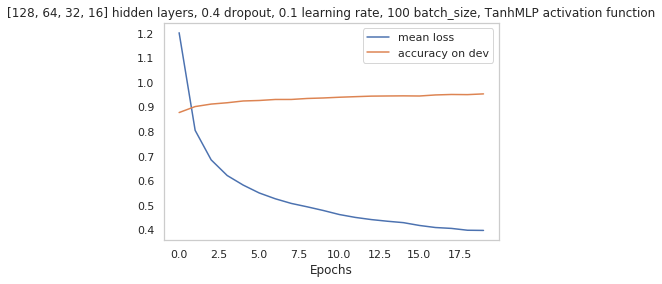

Starting epoch: 0
mean loss:  1.8369907280978035
dev accuracy:  0.7782
Starting epoch: 1
mean loss:  1.3917534140979542
dev accuracy:  0.8393
Starting epoch: 2
mean loss:  1.2192112347658943
dev accuracy:  0.8562
Starting epoch: 3
mean loss:  1.11256925498738
dev accuracy:  0.8697
Starting epoch: 4
mean loss:  1.043230930964152
dev accuracy:  0.8782
Starting epoch: 5
mean loss:  0.9890239682852053
dev accuracy:  0.8815
Starting epoch: 6
mean loss:  0.936338838408975
dev accuracy:  0.8859
Starting epoch: 7
mean loss:  0.8973778965426427
dev accuracy:  0.8908
Starting epoch: 8
mean loss:  0.8613434597557666
dev accuracy:  0.8914
Starting epoch: 9
mean loss:  0.8363271565998301
dev accuracy:  0.8927
Starting epoch: 10
mean loss:  0.8153863385611889
dev accuracy:  0.8943
Starting epoch: 11
mean loss:  0.7975251569467432
dev accuracy:  0.8974
Starting epoch: 12
mean loss:  0.7752930673898435
dev accuracy:  0.8977
Starting epoch: 13
mean loss:  0.7588045842507306
dev accuracy:  0.8996
Starti

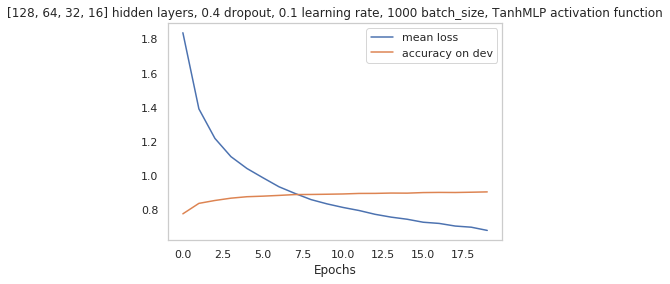

Starting epoch: 0
mean loss:  0.42793749927412184
dev accuracy:  0.9348
Starting epoch: 1
mean loss:  0.1984577914549068
dev accuracy:  0.952
Starting epoch: 2
mean loss:  0.14491108290823554
dev accuracy:  0.9598
Starting epoch: 3
mean loss:  0.11412781952068186
dev accuracy:  0.9635
Starting epoch: 4
mean loss:  0.09328090418219548
dev accuracy:  0.9682
Starting epoch: 5
mean loss:  0.07757373242886688
dev accuracy:  0.9704
Starting epoch: 6
mean loss:  0.06507977239877992
dev accuracy:  0.9703
Starting epoch: 7
mean loss:  0.055015256643199194
dev accuracy:  0.9708
Starting epoch: 8
mean loss:  0.046657388227896036
dev accuracy:  0.971
Starting epoch: 9
mean loss:  0.039597564338434726
dev accuracy:  0.9716
Starting epoch: 10
mean loss:  0.03379206012268125
dev accuracy:  0.9712
Starting epoch: 11
mean loss:  0.028754329058694395
dev accuracy:  0.972
Starting epoch: 12
mean loss:  0.024378753219938515
dev accuracy:  0.9718
Starting epoch: 13
mean loss:  0.02066869033512587
dev accur

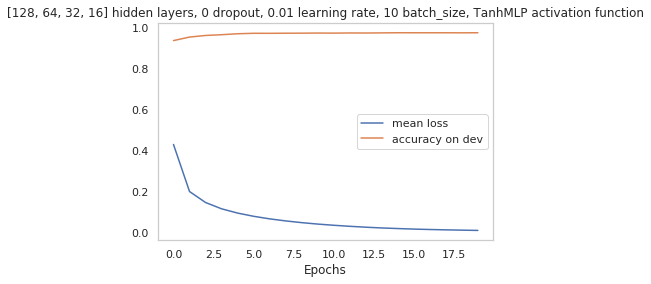

Starting epoch: 0
mean loss:  1.010096356897297
dev accuracy:  0.8773
Starting epoch: 1
mean loss:  0.5338167750430917
dev accuracy:  0.9055
Starting epoch: 2
mean loss:  0.4147921434776512
dev accuracy:  0.9169
Starting epoch: 3
mean loss:  0.3537946526340382
dev accuracy:  0.9245
Starting epoch: 4
mean loss:  0.3144382099489014
dev accuracy:  0.9296
Starting epoch: 5
mean loss:  0.2854796442056368
dev accuracy:  0.9345
Starting epoch: 6
mean loss:  0.26246552132144424
dev accuracy:  0.9386
Starting epoch: 7
mean loss:  0.24333380079435968
dev accuracy:  0.9423
Starting epoch: 8
mean loss:  0.22699272110612093
dev accuracy:  0.9455
Starting epoch: 9
mean loss:  0.21278451047019806
dev accuracy:  0.9471
Starting epoch: 10
mean loss:  0.20026737580934684
dev accuracy:  0.9494
Starting epoch: 11
mean loss:  0.18912251247557813
dev accuracy:  0.952
Starting epoch: 12
mean loss:  0.17911149670710108
dev accuracy:  0.9547
Starting epoch: 13
mean loss:  0.17005357279362318
dev accuracy:  0.9

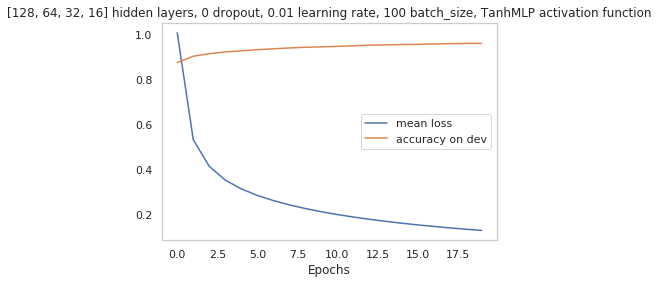

Starting epoch: 0
mean loss:  1.7781845705181945
dev accuracy:  0.6071
Starting epoch: 1
mean loss:  1.267552469290939
dev accuracy:  0.7277
Starting epoch: 2
mean loss:  1.0770824189279593
dev accuracy:  0.7727
Starting epoch: 3
mean loss:  0.9655292980811175
dev accuracy:  0.7986
Starting epoch: 4
mean loss:  0.8868147555519553
dev accuracy:  0.8175
Starting epoch: 5
mean loss:  0.8259027483416539
dev accuracy:  0.8286
Starting epoch: 6
mean loss:  0.7761367910048541
dev accuracy:  0.8395
Starting epoch: 7
mean loss:  0.7340234179122775
dev accuracy:  0.8491
Starting epoch: 8
mean loss:  0.6975167241750979
dev accuracy:  0.8583
Starting epoch: 9
mean loss:  0.6653235180705201
dev accuracy:  0.8662
Starting epoch: 10
mean loss:  0.6365792389009514
dev accuracy:  0.8723
Starting epoch: 11
mean loss:  0.6106792150759229
dev accuracy:  0.8772
Starting epoch: 12
mean loss:  0.5871833761533102
dev accuracy:  0.8816
Starting epoch: 13
mean loss:  0.5657588500602573
dev accuracy:  0.8862
Sta

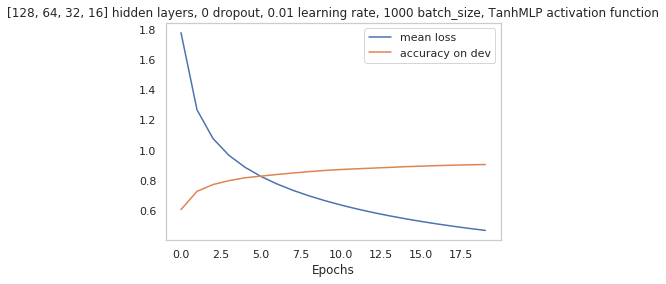

Starting epoch: 0
mean loss:  0.7174155800727171
dev accuracy:  0.9188
Starting epoch: 1
mean loss:  0.43316637599269786
dev accuracy:  0.9323
Starting epoch: 2
mean loss:  0.37898176332082395
dev accuracy:  0.9404
Starting epoch: 3
mean loss:  0.3386061408930756
dev accuracy:  0.9426
Starting epoch: 4
mean loss:  0.31211476908057
dev accuracy:  0.9504
Starting epoch: 5
mean loss:  0.28807371598570625
dev accuracy:  0.9546
Starting epoch: 6
mean loss:  0.2724114304355915
dev accuracy:  0.9561
Starting epoch: 7
mean loss:  0.260564880359097
dev accuracy:  0.9577
Starting epoch: 8
mean loss:  0.2495367130351422
dev accuracy:  0.9597
Starting epoch: 9
mean loss:  0.23424999673128832
dev accuracy:  0.9599
Starting epoch: 10
mean loss:  0.23151236864803532
dev accuracy:  0.9629
Starting epoch: 11
mean loss:  0.2182049215348522
dev accuracy:  0.9642
Starting epoch: 12
mean loss:  0.21017517727563018
dev accuracy:  0.9657
Starting epoch: 13
mean loss:  0.20395814214445357
dev accuracy:  0.964

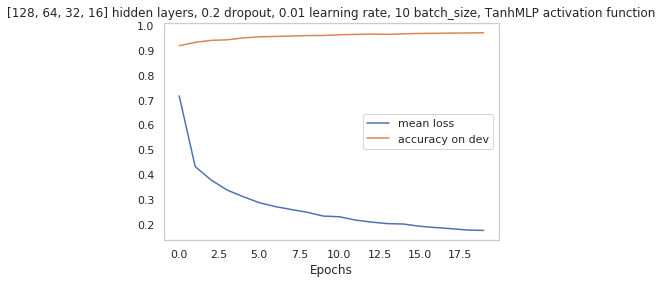

Starting epoch: 0
mean loss:  1.4258662320658595
dev accuracy:  0.8228
Starting epoch: 1
mean loss:  0.9164952377597253
dev accuracy:  0.8754
Starting epoch: 2
mean loss:  0.7562270560069474
dev accuracy:  0.8908
Starting epoch: 3
mean loss:  0.6632998369767994
dev accuracy:  0.9007
Starting epoch: 4
mean loss:  0.609067296672486
dev accuracy:  0.9076
Starting epoch: 5
mean loss:  0.5674804053501693
dev accuracy:  0.9107
Starting epoch: 6
mean loss:  0.536230636927896
dev accuracy:  0.9149
Starting epoch: 7
mean loss:  0.5115969862766608
dev accuracy:  0.9187
Starting epoch: 8
mean loss:  0.48917012776205404
dev accuracy:  0.921
Starting epoch: 9
mean loss:  0.46879769451247005
dev accuracy:  0.9236
Starting epoch: 10
mean loss:  0.45855073413687075
dev accuracy:  0.9261
Starting epoch: 11
mean loss:  0.4473557845799033
dev accuracy:  0.9264
Starting epoch: 12
mean loss:  0.43438464126544085
dev accuracy:  0.9285
Starting epoch: 13
mean loss:  0.42515337654573476
dev accuracy:  0.93
St

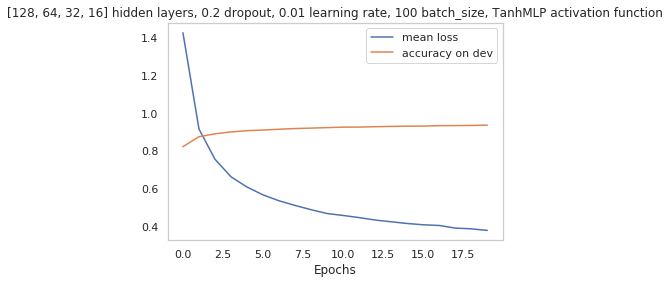

Starting epoch: 0
mean loss:  2.185774228152107
dev accuracy:  0.4865
Starting epoch: 1
mean loss:  1.7183107511669982
dev accuracy:  0.5926
Starting epoch: 2
mean loss:  1.5175989609138638
dev accuracy:  0.6596
Starting epoch: 3
mean loss:  1.3880851432388903
dev accuracy:  0.7052
Starting epoch: 4
mean loss:  1.2957670454885446
dev accuracy:  0.7369
Starting epoch: 5
mean loss:  1.2199013420179778
dev accuracy:  0.7637
Starting epoch: 6
mean loss:  1.1559313816182755
dev accuracy:  0.7872
Starting epoch: 7
mean loss:  1.1030799991944258
dev accuracy:  0.8053
Starting epoch: 8
mean loss:  1.0548988487206252
dev accuracy:  0.8203
Starting epoch: 9
mean loss:  1.01734290637222
dev accuracy:  0.8312
Starting epoch: 10
mean loss:  0.9825210547914692
dev accuracy:  0.8398
Starting epoch: 11
mean loss:  0.9469135450381859
dev accuracy:  0.849
Starting epoch: 12
mean loss:  0.9221405772601857
dev accuracy:  0.8552
Starting epoch: 13
mean loss:  0.8956765345498627
dev accuracy:  0.8594
Starti

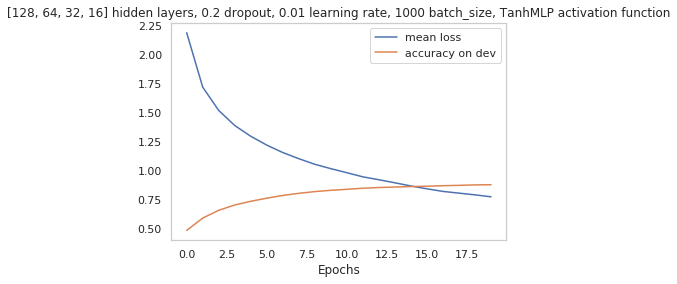

Starting epoch: 0
mean loss:  1.1758785683306379
dev accuracy:  0.8893
Starting epoch: 1
mean loss:  0.7860646135099433
dev accuracy:  0.9062
Starting epoch: 2
mean loss:  0.6836846208520542
dev accuracy:  0.9174
Starting epoch: 3
mean loss:  0.6250741342773523
dev accuracy:  0.9222
Starting epoch: 4
mean loss:  0.5827034891956784
dev accuracy:  0.9263
Starting epoch: 5
mean loss:  0.5595430475465061
dev accuracy:  0.932
Starting epoch: 6
mean loss:  0.5315510544328511
dev accuracy:  0.932
Starting epoch: 7
mean loss:  0.506433219995839
dev accuracy:  0.936
Starting epoch: 8
mean loss:  0.48991831917806616
dev accuracy:  0.9377
Starting epoch: 9
mean loss:  0.47972061591313386
dev accuracy:  0.9415
Starting epoch: 10
mean loss:  0.46652653651865833
dev accuracy:  0.9433
Starting epoch: 11
mean loss:  0.44947747079518835
dev accuracy:  0.9452
Starting epoch: 12
mean loss:  0.4411194893216591
dev accuracy:  0.9468
Starting epoch: 13
mean loss:  0.4303315809189117
dev accuracy:  0.9467
St

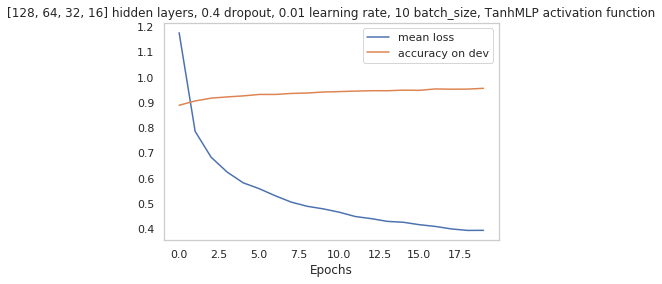

Starting epoch: 0
mean loss:  1.9321643799364925
dev accuracy:  0.7616
Starting epoch: 1
mean loss:  1.4247913741304012
dev accuracy:  0.8039
Starting epoch: 2
mean loss:  1.2392701846872738
dev accuracy:  0.827
Starting epoch: 3
mean loss:  1.134499823380849
dev accuracy:  0.8466
Starting epoch: 4
mean loss:  1.0615435681657164
dev accuracy:  0.8567
Starting epoch: 5
mean loss:  0.9907696313724784
dev accuracy:  0.8666
Starting epoch: 6
mean loss:  0.9446316994354872
dev accuracy:  0.8731
Starting epoch: 7
mean loss:  0.9068352119651383
dev accuracy:  0.8802
Starting epoch: 8
mean loss:  0.8692771240384755
dev accuracy:  0.8823
Starting epoch: 9
mean loss:  0.844277375829434
dev accuracy:  0.8858
Starting epoch: 10
mean loss:  0.8259411661210888
dev accuracy:  0.8895
Starting epoch: 11
mean loss:  0.7969345694292567
dev accuracy:  0.8888
Starting epoch: 12
mean loss:  0.7793434817871886
dev accuracy:  0.8931
Starting epoch: 13
mean loss:  0.7634997537987913
dev accuracy:  0.8949
Start

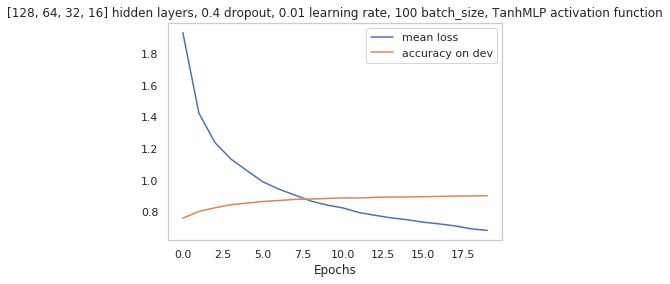

Starting epoch: 0
mean loss:  2.4734829594107235
dev accuracy:  0.4333
Starting epoch: 1
mean loss:  2.1608969230277864
dev accuracy:  0.5221
Starting epoch: 2
mean loss:  1.9817149896247714
dev accuracy:  0.577
Starting epoch: 3
mean loss:  1.8735710382461548
dev accuracy:  0.6149
Starting epoch: 4
mean loss:  1.77483439912983
dev accuracy:  0.651
Starting epoch: 5
mean loss:  1.706859128147948
dev accuracy:  0.6806
Starting epoch: 6
mean loss:  1.659021870762694
dev accuracy:  0.7029
Starting epoch: 7
mean loss:  1.604709454611236
dev accuracy:  0.7199
Starting epoch: 8
mean loss:  1.5605303236082488
dev accuracy:  0.7359
Starting epoch: 9
mean loss:  1.5169298041100596
dev accuracy:  0.7524
Starting epoch: 10
mean loss:  1.485334499209535
dev accuracy:  0.7637
Starting epoch: 11
mean loss:  1.4641020204506667
dev accuracy:  0.7747
Starting epoch: 12
mean loss:  1.4251514252494364
dev accuracy:  0.7859
Starting epoch: 13
mean loss:  1.4083958817463296
dev accuracy:  0.7929
Starting e

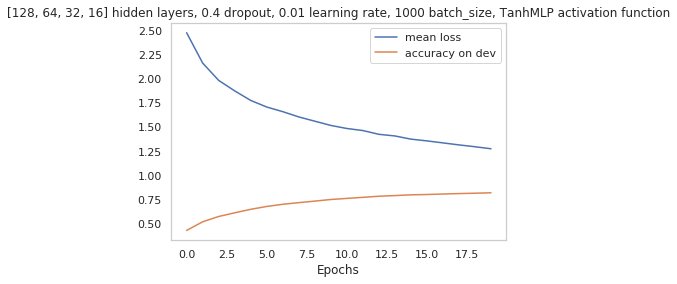

Starting epoch: 0
mean loss:  1.0559836947496022
dev accuracy:  0.8648
Starting epoch: 1
mean loss:  0.5552945397563325
dev accuracy:  0.8994
Starting epoch: 2
mean loss:  0.41892201833425463
dev accuracy:  0.9137
Starting epoch: 3
mean loss:  0.3482928850252827
dev accuracy:  0.9214
Starting epoch: 4
mean loss:  0.3039542300519741
dev accuracy:  0.9289
Starting epoch: 5
mean loss:  0.2726410890332915
dev accuracy:  0.9352
Starting epoch: 6
mean loss:  0.24874325176759424
dev accuracy:  0.9398
Starting epoch: 7
mean loss:  0.22953841510554523
dev accuracy:  0.9439
Starting epoch: 8
mean loss:  0.2135415447488877
dev accuracy:  0.9474
Starting epoch: 9
mean loss:  0.1998801235943121
dev accuracy:  0.9499
Starting epoch: 10
mean loss:  0.18799866648073185
dev accuracy:  0.9522
Starting epoch: 11
mean loss:  0.17751348404341538
dev accuracy:  0.9542
Starting epoch: 12
mean loss:  0.16814967778721224
dev accuracy:  0.9558
Starting epoch: 13
mean loss:  0.15970568229321228
dev accuracy:  0.

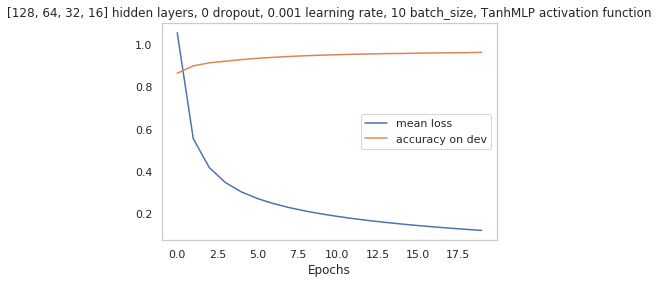

Starting epoch: 0
mean loss:  1.8461328261864638
dev accuracy:  0.5491
Starting epoch: 1
mean loss:  1.3995175159382012
dev accuracy:  0.6816
Starting epoch: 2
mean loss:  1.196821486640595
dev accuracy:  0.7473
Starting epoch: 3
mean loss:  1.062635412592136
dev accuracy:  0.7923
Starting epoch: 4
mean loss:  0.9630727258746972
dev accuracy:  0.8194
Starting epoch: 5
mean loss:  0.8855448477044553
dev accuracy:  0.8385
Starting epoch: 6
mean loss:  0.8231617099272752
dev accuracy:  0.8489
Starting epoch: 7
mean loss:  0.771572297442697
dev accuracy:  0.8598
Starting epoch: 8
mean loss:  0.7279504307967698
dev accuracy:  0.8674
Starting epoch: 9
mean loss:  0.6904095492201175
dev accuracy:  0.8728
Starting epoch: 10
mean loss:  0.6576455256301248
dev accuracy:  0.8768
Starting epoch: 11
mean loss:  0.628726044219887
dev accuracy:  0.881
Starting epoch: 12
mean loss:  0.6029642224311829
dev accuracy:  0.8862
Starting epoch: 13
mean loss:  0.5798399100403586
dev accuracy:  0.8902
Startin

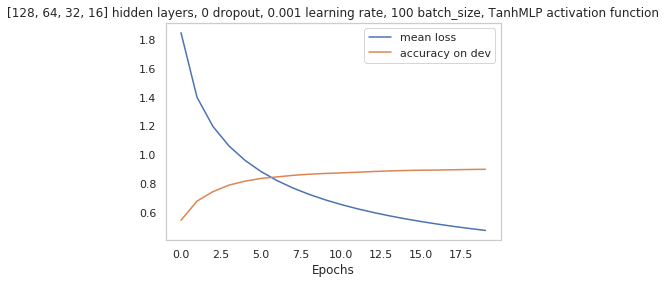

Starting epoch: 0
mean loss:  2.3353466613619935
dev accuracy:  0.1531
Starting epoch: 1
mean loss:  2.137882573931825
dev accuracy:  0.236
Starting epoch: 2
mean loss:  1.991874657425226
dev accuracy:  0.3162
Starting epoch: 3
mean loss:  1.8761287880878823
dev accuracy:  0.3846
Starting epoch: 4
mean loss:  1.7811926650066001
dev accuracy:  0.4383
Starting epoch: 5
mean loss:  1.7018042615815705
dev accuracy:  0.4831
Starting epoch: 6
mean loss:  1.6344111643585504
dev accuracy:  0.5211
Starting epoch: 7
mean loss:  1.5763822583591236
dev accuracy:  0.5531
Starting epoch: 8
mean loss:  1.5257404715407128
dev accuracy:  0.5821
Starting epoch: 9
mean loss:  1.481004894948473
dev accuracy:  0.6078
Starting epoch: 10
mean loss:  1.4410604846243764
dev accuracy:  0.627
Starting epoch: 11
mean loss:  1.405056259211372
dev accuracy:  0.6485
Starting epoch: 12
mean loss:  1.3723327575945388
dev accuracy:  0.664
Starting epoch: 13
mean loss:  1.3423718821768666
dev accuracy:  0.6777
Starting 

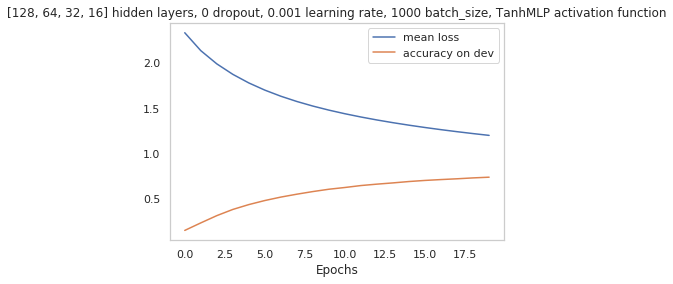

Starting epoch: 0
mean loss:  1.2571016941588298
dev accuracy:  0.8595
Starting epoch: 1
mean loss:  0.8224583332078788
dev accuracy:  0.8843
Starting epoch: 2
mean loss:  0.6949526798698907
dev accuracy:  0.8948
Starting epoch: 3
mean loss:  0.6213435957003798
dev accuracy:  0.9031
Starting epoch: 4
mean loss:  0.5767829971605123
dev accuracy:  0.9084
Starting epoch: 5
mean loss:  0.5407638713595295
dev accuracy:  0.9102
Starting epoch: 6
mean loss:  0.5185050288469666
dev accuracy:  0.9148
Starting epoch: 7
mean loss:  0.4942156795909156
dev accuracy:  0.917
Starting epoch: 8
mean loss:  0.4766853129823812
dev accuracy:  0.9189
Starting epoch: 9
mean loss:  0.466847323481246
dev accuracy:  0.9223
Starting epoch: 10
mean loss:  0.4535414428505849
dev accuracy:  0.9253
Starting epoch: 11
mean loss:  0.44108834379747247
dev accuracy:  0.9264
Starting epoch: 12
mean loss:  0.4281209904098631
dev accuracy:  0.927
Starting epoch: 13
mean loss:  0.4254642155291831
dev accuracy:  0.9285
Star

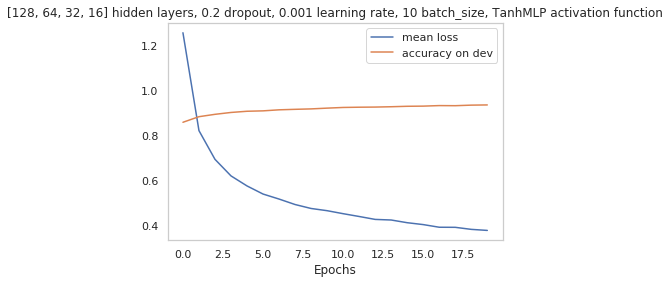

Starting epoch: 0
mean loss:  2.23520604341092
dev accuracy:  0.5832
Starting epoch: 1
mean loss:  1.7507619486597483
dev accuracy:  0.7033
Starting epoch: 2
mean loss:  1.5226962594928857
dev accuracy:  0.7605
Starting epoch: 3
mean loss:  1.3830975003823074
dev accuracy:  0.7929
Starting epoch: 4
mean loss:  1.2825295346939636
dev accuracy:  0.8119
Starting epoch: 5
mean loss:  1.2003093341629425
dev accuracy:  0.8283
Starting epoch: 6
mean loss:  1.14337605166578
dev accuracy:  0.8375
Starting epoch: 7
mean loss:  1.088726343152052
dev accuracy:  0.8441
Starting epoch: 8
mean loss:  1.0409572258918822
dev accuracy:  0.8504
Starting epoch: 9
mean loss:  1.0006259138474682
dev accuracy:  0.8557
Starting epoch: 10
mean loss:  0.9714045962411725
dev accuracy:  0.859
Starting epoch: 11
mean loss:  0.9361049290188772
dev accuracy:  0.8627
Starting epoch: 12
mean loss:  0.912521883161244
dev accuracy:  0.8653
Starting epoch: 13
mean loss:  0.8873913756863562
dev accuracy:  0.8683
Starting 

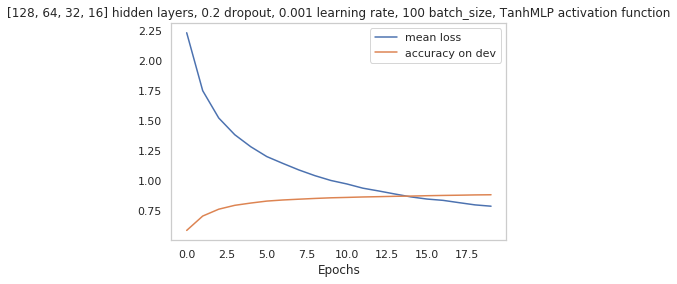

Starting epoch: 0
mean loss:  2.499163370506436
dev accuracy:  0.11
Starting epoch: 1
mean loss:  2.396848056830612
dev accuracy:  0.1647
Starting epoch: 2
mean loss:  2.3111195003285125
dev accuracy:  0.241
Starting epoch: 3
mean loss:  2.2285785862043794
dev accuracy:  0.3193
Starting epoch: 4
mean loss:  2.15875618130553
dev accuracy:  0.3796
Starting epoch: 5
mean loss:  2.100188647999483
dev accuracy:  0.4285
Starting epoch: 6
mean loss:  2.0419061183929443
dev accuracy:  0.4688
Starting epoch: 7
mean loss:  1.9921302561666452
dev accuracy:  0.5046
Starting epoch: 8
mean loss:  1.941346893123552
dev accuracy:  0.5331
Starting epoch: 9
mean loss:  1.9056913712445427
dev accuracy:  0.5596
Starting epoch: 10
mean loss:  1.8598758730233884
dev accuracy:  0.5808
Starting epoch: 11
mean loss:  1.827633023262024
dev accuracy:  0.5991
Starting epoch: 12
mean loss:  1.79241849861893
dev accuracy:  0.6153
Starting epoch: 13
mean loss:  1.7597013431436874
dev accuracy:  0.6294
Starting epoch

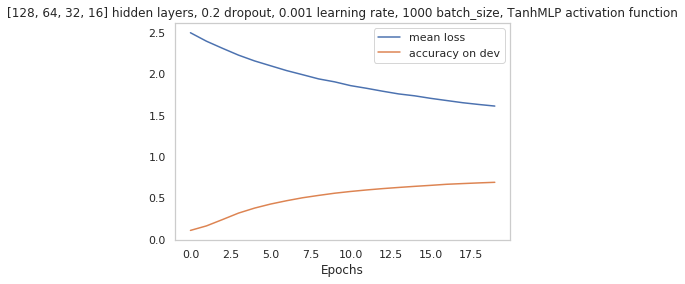

Starting epoch: 0
mean loss:  1.8554364271555823
dev accuracy:  0.7702
Starting epoch: 1
mean loss:  1.3408009008726247
dev accuracy:  0.8332
Starting epoch: 2
mean loss:  1.1694834171366963
dev accuracy:  0.854
Starting epoch: 3
mean loss:  1.0623510205502558
dev accuracy:  0.8622
Starting epoch: 4
mean loss:  0.9976935563230963
dev accuracy:  0.8677
Starting epoch: 5
mean loss:  0.9385994027564821
dev accuracy:  0.8738
Starting epoch: 6
mean loss:  0.8945958522427585
dev accuracy:  0.8782
Starting epoch: 7
mean loss:  0.8655409005922547
dev accuracy:  0.8802
Starting epoch: 8
mean loss:  0.8399514052223573
dev accuracy:  0.8853
Starting epoch: 9
mean loss:  0.8204242405987243
dev accuracy:  0.8863
Starting epoch: 10
mean loss:  0.7984764845630237
dev accuracy:  0.8893
Starting epoch: 11
mean loss:  0.7751253226984622
dev accuracy:  0.8924
Starting epoch: 12
mean loss:  0.7670966995519845
dev accuracy:  0.8953
Starting epoch: 13
mean loss:  0.7490036212082173
dev accuracy:  0.8972
Sta

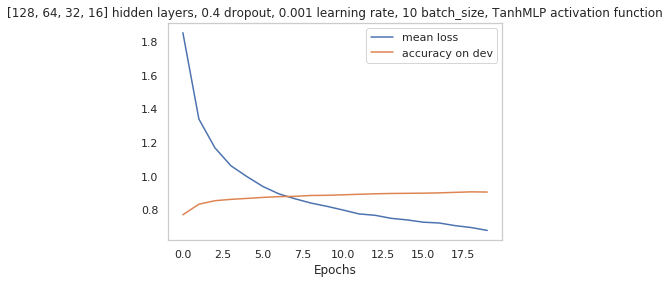

Starting epoch: 0
mean loss:  2.5823469975751316
dev accuracy:  0.4522
Starting epoch: 1
mean loss:  2.221451648695026
dev accuracy:  0.5948
Starting epoch: 2
mean loss:  2.0340727907930782
dev accuracy:  0.6488
Starting epoch: 3
mean loss:  1.9050421564878819
dev accuracy:  0.6864
Starting epoch: 4
mean loss:  1.826392519259881
dev accuracy:  0.7092
Starting epoch: 5
mean loss:  1.7549458444713357
dev accuracy:  0.7315
Starting epoch: 6
mean loss:  1.7014769791604991
dev accuracy:  0.751
Starting epoch: 7
mean loss:  1.6481167813261113
dev accuracy:  0.7646
Starting epoch: 8
mean loss:  1.6106448685099741
dev accuracy:  0.7785
Starting epoch: 9
mean loss:  1.5736245290485922
dev accuracy:  0.7882
Starting epoch: 10
mean loss:  1.5333522106121162
dev accuracy:  0.7983
Starting epoch: 11
mean loss:  1.4970315894680823
dev accuracy:  0.8043
Starting epoch: 12
mean loss:  1.4644314519421544
dev accuracy:  0.8128
Starting epoch: 13
mean loss:  1.4429667524234977
dev accuracy:  0.8201
Start

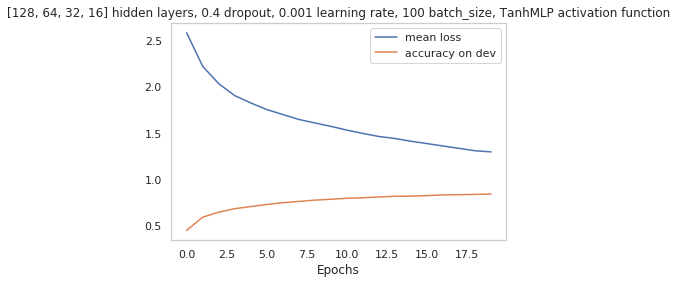

Starting epoch: 0
mean loss:  2.7804836759380267
dev accuracy:  0.1204
Starting epoch: 1
mean loss:  2.7159503441230926
dev accuracy:  0.1506
Starting epoch: 2
mean loss:  2.66342859174691
dev accuracy:  0.1911
Starting epoch: 3
mean loss:  2.612785727370019
dev accuracy:  0.2397
Starting epoch: 4
mean loss:  2.572954383550906
dev accuracy:  0.2847
Starting epoch: 5
mean loss:  2.5270011144525864
dev accuracy:  0.3266
Starting epoch: 6
mean loss:  2.469109343547447
dev accuracy:  0.3659
Starting epoch: 7
mean loss:  2.429171538820454
dev accuracy:  0.4057
Starting epoch: 8
mean loss:  2.3959327866049374
dev accuracy:  0.4352
Starting epoch: 9
mean loss:  2.3682705841812433
dev accuracy:  0.4654
Starting epoch: 10
mean loss:  2.3238810230703915
dev accuracy:  0.4926
Starting epoch: 11
mean loss:  2.3040410443848254
dev accuracy:  0.5148
Starting epoch: 12
mean loss:  2.2633905971751496
dev accuracy:  0.536
Starting epoch: 13
mean loss:  2.2408654596291337
dev accuracy:  0.5551
Starting 

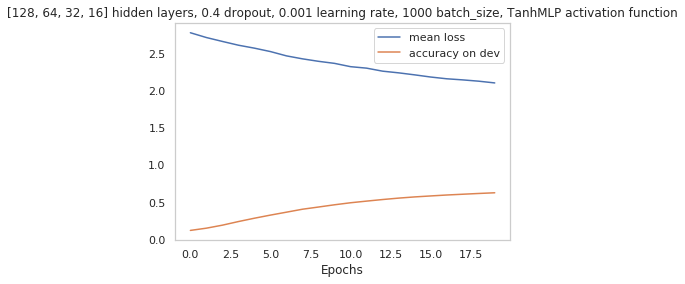

Starting epoch: 0
mean loss:  0.3327539780125405
dev accuracy:  0.9361
Starting epoch: 1
mean loss:  0.18523605802295504
dev accuracy:  0.9543
Starting epoch: 2
mean loss:  0.14551534756911566
dev accuracy:  0.9566
Starting epoch: 3
mean loss:  0.11988587724408062
dev accuracy:  0.9544
Starting epoch: 4
mean loss:  0.11128002207653984
dev accuracy:  0.9594
Starting epoch: 5
mean loss:  0.09944539843092214
dev accuracy:  0.9667
Starting epoch: 6
mean loss:  0.08454529848091742
dev accuracy:  0.9585
Starting epoch: 7
mean loss:  0.08009324764748912
dev accuracy:  0.9629
Starting epoch: 8
mean loss:  0.07002632405527744
dev accuracy:  0.9638
Starting epoch: 9
mean loss:  0.07180747010801115
dev accuracy:  0.9675
Starting epoch: 10
mean loss:  0.0698193885729044
dev accuracy:  0.9694
Starting epoch: 11
mean loss:  0.06748877904669602
dev accuracy:  0.9671
Starting epoch: 12
mean loss:  0.062110814618528146
dev accuracy:  0.9707
Starting epoch: 13
mean loss:  0.0632246745282831
dev accuracy

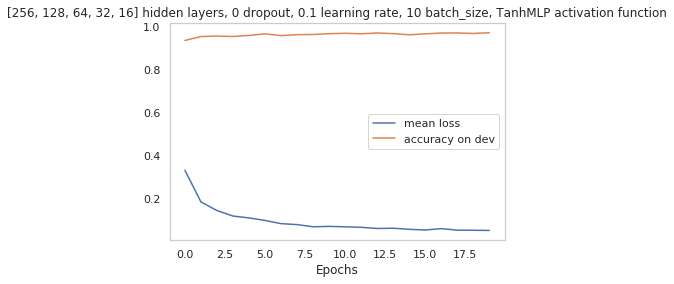

Starting epoch: 0
mean loss:  0.4273046705269528
dev accuracy:  0.9484
Starting epoch: 1
mean loss:  0.17888221969296356
dev accuracy:  0.9624
Starting epoch: 2
mean loss:  0.12422295063064841
dev accuracy:  0.9662
Starting epoch: 3
mean loss:  0.09469584799455312
dev accuracy:  0.9678
Starting epoch: 4
mean loss:  0.07500476979960997
dev accuracy:  0.97
Starting epoch: 5
mean loss:  0.06055664250853949
dev accuracy:  0.9712
Starting epoch: 6
mean loss:  0.04858120728447706
dev accuracy:  0.9723
Starting epoch: 7
mean loss:  0.038708638667524935
dev accuracy:  0.9735
Starting epoch: 8
mean loss:  0.031069238801224683
dev accuracy:  0.9734
Starting epoch: 9
mean loss:  0.02476536554838354
dev accuracy:  0.9747
Starting epoch: 10
mean loss:  0.020978725449778808
dev accuracy:  0.975
Starting epoch: 11
mean loss:  0.01636547824747102
dev accuracy:  0.9757
Starting epoch: 12
mean loss:  0.01317424648845691
dev accuracy:  0.976
Starting epoch: 13
mean loss:  0.010736661593005908
dev accurac

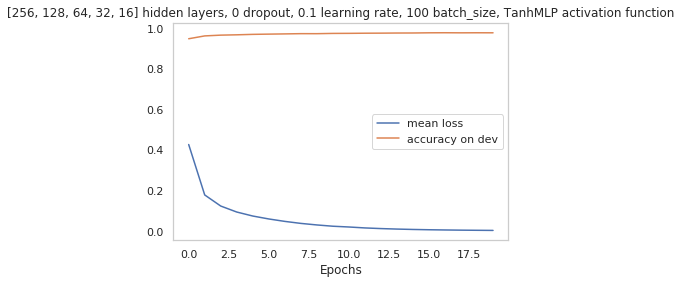

Starting epoch: 0
mean loss:  1.02805056291468
dev accuracy:  0.8824
Starting epoch: 1
mean loss:  0.5144824783007304
dev accuracy:  0.9135
Starting epoch: 2
mean loss:  0.3848433044611239
dev accuracy:  0.9251
Starting epoch: 3
mean loss:  0.3188833120991202
dev accuracy:  0.9347
Starting epoch: 4
mean loss:  0.27644041151392695
dev accuracy:  0.94
Starting epoch: 5
mean loss:  0.24587464975375756
dev accuracy:  0.9444
Starting epoch: 6
mean loss:  0.22232704828767216
dev accuracy:  0.9478
Starting epoch: 7
mean loss:  0.2032993619932848
dev accuracy:  0.9513
Starting epoch: 8
mean loss:  0.18737432243777255
dev accuracy:  0.9554
Starting epoch: 9
mean loss:  0.1737123362573923
dev accuracy:  0.9576
Starting epoch: 10
mean loss:  0.1617937999613145
dev accuracy:  0.9584
Starting epoch: 11
mean loss:  0.15129551554427428
dev accuracy:  0.9595
Starting epoch: 12
mean loss:  0.14201052954383925
dev accuracy:  0.9608
Starting epoch: 13
mean loss:  0.1337879479807966
dev accuracy:  0.9621


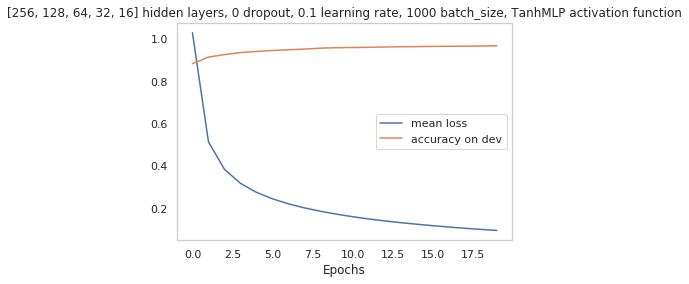

Starting epoch: 0
mean loss:  0.5777154238207404
dev accuracy:  0.9231
Starting epoch: 1
mean loss:  0.37040597357569494
dev accuracy:  0.9449
Starting epoch: 2
mean loss:  0.3242761085561885
dev accuracy:  0.9476
Starting epoch: 3
mean loss:  0.2987585489875962
dev accuracy:  0.9553
Starting epoch: 4
mean loss:  0.28590086642507495
dev accuracy:  0.9488
Starting epoch: 5
mean loss:  0.2778093359915257
dev accuracy:  0.9573
Starting epoch: 6
mean loss:  0.262873922049153
dev accuracy:  0.9553
Starting epoch: 7
mean loss:  0.24632453735823948
dev accuracy:  0.9622
Starting epoch: 8
mean loss:  0.24181134645013116
dev accuracy:  0.9574
Starting epoch: 9
mean loss:  0.23881859077340697
dev accuracy:  0.9586
Starting epoch: 10
mean loss:  0.23050301339700027
dev accuracy:  0.9598
Starting epoch: 11
mean loss:  0.22947762411354428
dev accuracy:  0.9623
Starting epoch: 12
mean loss:  0.2180536142394909
dev accuracy:  0.9553
Starting epoch: 13
mean loss:  0.22664838312998253
dev accuracy:  0.

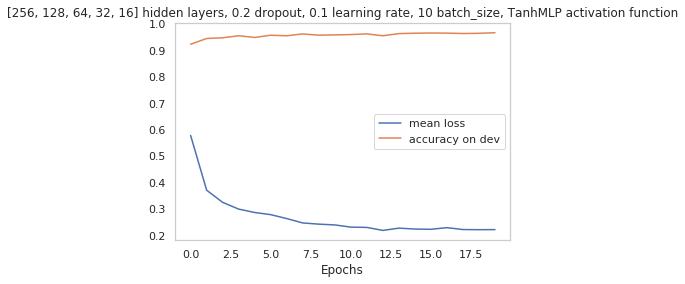

Starting epoch: 0
mean loss:  0.7595271366442035
dev accuracy:  0.9172
Starting epoch: 1
mean loss:  0.4358234100653502
dev accuracy:  0.9363
Starting epoch: 2
mean loss:  0.36328758216070794
dev accuracy:  0.944
Starting epoch: 3
mean loss:  0.3294984174970381
dev accuracy:  0.9509
Starting epoch: 4
mean loss:  0.2967235353029893
dev accuracy:  0.9545
Starting epoch: 5
mean loss:  0.27305294646176986
dev accuracy:  0.9568
Starting epoch: 6
mean loss:  0.2553093568858748
dev accuracy:  0.9595
Starting epoch: 7
mean loss:  0.23653374810864825
dev accuracy:  0.9631
Starting epoch: 8
mean loss:  0.22887465307217633
dev accuracy:  0.9626
Starting epoch: 9
mean loss:  0.21487902224569502
dev accuracy:  0.9657
Starting epoch: 10
mean loss:  0.21017093896984815
dev accuracy:  0.963
Starting epoch: 11
mean loss:  0.1973159985464371
dev accuracy:  0.9679
Starting epoch: 12
mean loss:  0.192151757682155
dev accuracy:  0.9675
Starting epoch: 13
mean loss:  0.18905782619279302
dev accuracy:  0.968

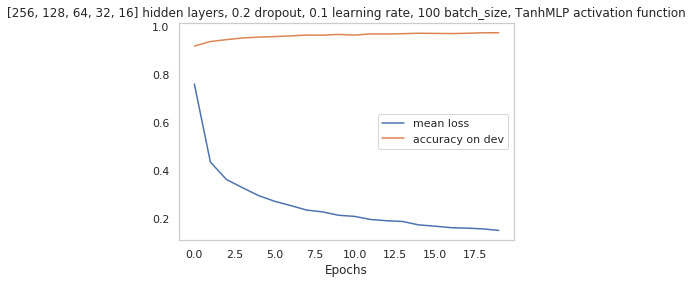

Starting epoch: 0
mean loss:  1.4298005629988277
dev accuracy:  0.8551
Starting epoch: 1
mean loss:  0.8876300641134673
dev accuracy:  0.8848
Starting epoch: 2
mean loss:  0.7243783099978578
dev accuracy:  0.9003
Starting epoch: 3
mean loss:  0.6387561092189714
dev accuracy:  0.9068
Starting epoch: 4
mean loss:  0.5850433344934501
dev accuracy:  0.9137
Starting epoch: 5
mean loss:  0.5410186589932909
dev accuracy:  0.9167
Starting epoch: 6
mean loss:  0.5100337155893737
dev accuracy:  0.9201
Starting epoch: 7
mean loss:  0.48787356007332894
dev accuracy:  0.9232
Starting epoch: 8
mean loss:  0.46325329472036925
dev accuracy:  0.9269
Starting epoch: 9
mean loss:  0.45190835583443734
dev accuracy:  0.9294
Starting epoch: 10
mean loss:  0.43390264230615955
dev accuracy:  0.9305
Starting epoch: 11
mean loss:  0.42219817170909807
dev accuracy:  0.9319
Starting epoch: 12
mean loss:  0.4064718689404282
dev accuracy:  0.9344
Starting epoch: 13
mean loss:  0.4004383630612317
dev accuracy:  0.93

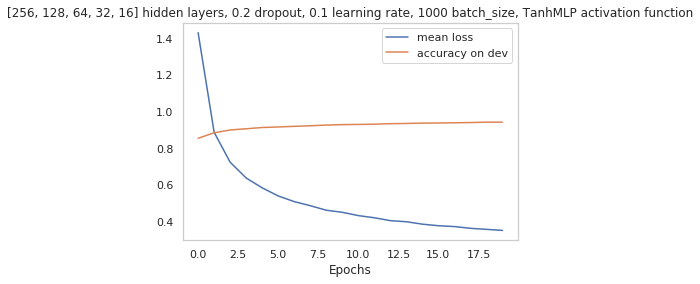

Starting epoch: 0
mean loss:  1.091357829918911
dev accuracy:  0.8697
Starting epoch: 1
mean loss:  0.7796825088368394
dev accuracy:  0.8931
Starting epoch: 2
mean loss:  0.7304433515622029
dev accuracy:  0.9009
Starting epoch: 3
mean loss:  0.7206909989245747
dev accuracy:  0.9035
Starting epoch: 4
mean loss:  0.7117201302880658
dev accuracy:  0.906
Starting epoch: 5
mean loss:  0.7265313608190866
dev accuracy:  0.909
Starting epoch: 6
mean loss:  0.7365844269212163
dev accuracy:  0.9039
Starting epoch: 7
mean loss:  0.7472041786742005
dev accuracy:  0.9117
Starting epoch: 8
mean loss:  0.7478377949479961
dev accuracy:  0.9054
Starting epoch: 9
mean loss:  0.758149093258705
dev accuracy:  0.9089
Starting epoch: 10
mean loss:  0.7672532671461747
dev accuracy:  0.9013
Starting epoch: 11
mean loss:  0.7853722439300796
dev accuracy:  0.9035
Starting epoch: 12
mean loss:  0.7731657981071036
dev accuracy:  0.9018
Starting epoch: 13
mean loss:  0.7816336650548101
dev accuracy:  0.904
Startin

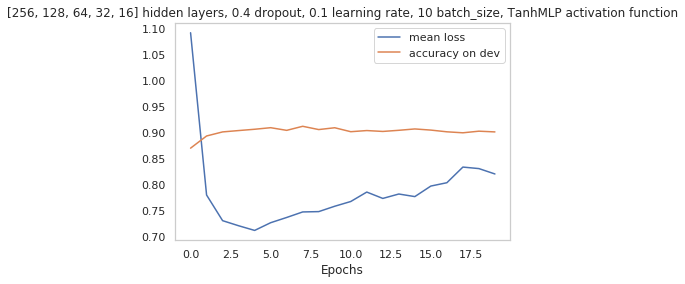

Starting epoch: 0
mean loss:  1.2672978351692001
dev accuracy:  0.8722
Starting epoch: 1
mean loss:  0.8114769962019549
dev accuracy:  0.9001
Starting epoch: 2
mean loss:  0.701270022554074
dev accuracy:  0.9116
Starting epoch: 3
mean loss:  0.6283850610970023
dev accuracy:  0.916
Starting epoch: 4
mean loss:  0.581970848901543
dev accuracy:  0.9252
Starting epoch: 5
mean loss:  0.5478660480942793
dev accuracy:  0.9306
Starting epoch: 6
mean loss:  0.5246545117415354
dev accuracy:  0.9347
Starting epoch: 7
mean loss:  0.5014106217556134
dev accuracy:  0.9359
Starting epoch: 8
mean loss:  0.4770948836605944
dev accuracy:  0.9385
Starting epoch: 9
mean loss:  0.46494209177479773
dev accuracy:  0.9423
Starting epoch: 10
mean loss:  0.454573678845417
dev accuracy:  0.9444
Starting epoch: 11
mean loss:  0.4352634055707269
dev accuracy:  0.9461
Starting epoch: 12
mean loss:  0.42421908504115846
dev accuracy:  0.9503
Starting epoch: 13
mean loss:  0.41930376629748506
dev accuracy:  0.9491
Sta

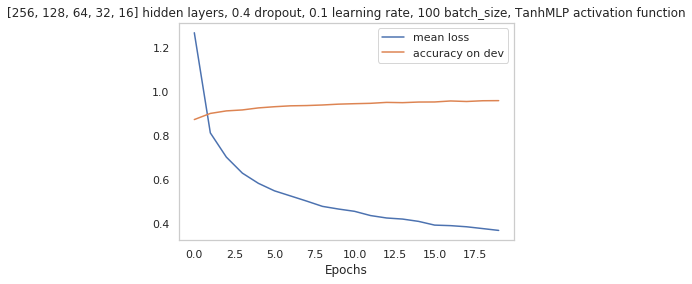

Starting epoch: 0
mean loss:  2.0599362219081208
dev accuracy:  0.675
Starting epoch: 1
mean loss:  1.5468993864807428
dev accuracy:  0.7613
Starting epoch: 2
mean loss:  1.3364371037950702
dev accuracy:  0.8268
Starting epoch: 3
mean loss:  1.2057172597623338
dev accuracy:  0.8487
Starting epoch: 4
mean loss:  1.1050197283426921
dev accuracy:  0.8581
Starting epoch: 5
mean loss:  1.0416584412256877
dev accuracy:  0.8635
Starting epoch: 6
mean loss:  0.9859946849299412
dev accuracy:  0.8713
Starting epoch: 7
mean loss:  0.9453727696456161
dev accuracy:  0.8768
Starting epoch: 8
mean loss:  0.9043569214203778
dev accuracy:  0.8795
Starting epoch: 9
mean loss:  0.8687502426259658
dev accuracy:  0.8842
Starting epoch: 10
mean loss:  0.844108895928252
dev accuracy:  0.8867
Starting epoch: 11
mean loss:  0.8174732818323023
dev accuracy:  0.8883
Starting epoch: 12
mean loss:  0.796458105246226
dev accuracy:  0.8905
Starting epoch: 13
mean loss:  0.7802352952022179
dev accuracy:  0.8934
Start

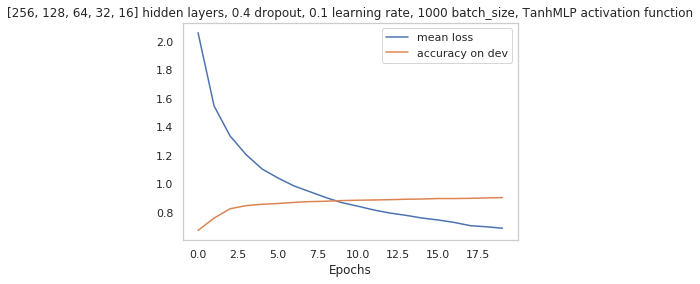

Starting epoch: 0
mean loss:  0.38944056978454067
dev accuracy:  0.9451
Starting epoch: 1
mean loss:  0.1726551825714936
dev accuracy:  0.9582
Starting epoch: 2
mean loss:  0.121111039009051
dev accuracy:  0.9643
Starting epoch: 3
mean loss:  0.09214008455021336
dev accuracy:  0.9679
Starting epoch: 4
mean loss:  0.07240237262947036
dev accuracy:  0.9699
Starting epoch: 5
mean loss:  0.05745700884019515
dev accuracy:  0.9699
Starting epoch: 6
mean loss:  0.04569555848942676
dev accuracy:  0.9718
Starting epoch: 7
mean loss:  0.036065798240855866
dev accuracy:  0.9731
Starting epoch: 8
mean loss:  0.028516915934506268
dev accuracy:  0.9733
Starting epoch: 9
mean loss:  0.02307081347599758
dev accuracy:  0.9731
Starting epoch: 10
mean loss:  0.018233678309344713
dev accuracy:  0.9741
Starting epoch: 11
mean loss:  0.014456943828021573
dev accuracy:  0.975
Starting epoch: 12
mean loss:  0.011716591456258892
dev accuracy:  0.9753
Starting epoch: 13
mean loss:  0.009656133219482914
dev accu

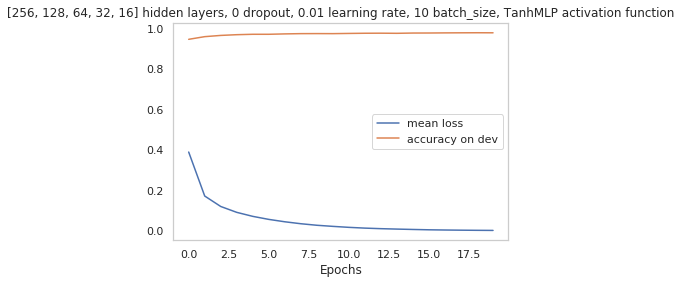

Starting epoch: 0
mean loss:  0.9678244505099908
dev accuracy:  0.8945
Starting epoch: 1
mean loss:  0.5012895179365924
dev accuracy:  0.9182
Starting epoch: 2
mean loss:  0.37568263554882386
dev accuracy:  0.9291
Starting epoch: 3
mean loss:  0.3099147179229055
dev accuracy:  0.9372
Starting epoch: 4
mean loss:  0.26810211896479963
dev accuracy:  0.9431
Starting epoch: 5
mean loss:  0.23830825662957933
dev accuracy:  0.9475
Starting epoch: 6
mean loss:  0.21542119399873083
dev accuracy:  0.951
Starting epoch: 7
mean loss:  0.19694451960974824
dev accuracy:  0.9535
Starting epoch: 8
mean loss:  0.181546572640449
dev accuracy:  0.9556
Starting epoch: 9
mean loss:  0.16843605689154176
dev accuracy:  0.9578
Starting epoch: 10
mean loss:  0.1570871653418222
dev accuracy:  0.9589
Starting epoch: 11
mean loss:  0.14712441850178493
dev accuracy:  0.9605
Starting epoch: 12
mean loss:  0.13826862037806453
dev accuracy:  0.9623
Starting epoch: 13
mean loss:  0.13030983060003518
dev accuracy:  0.

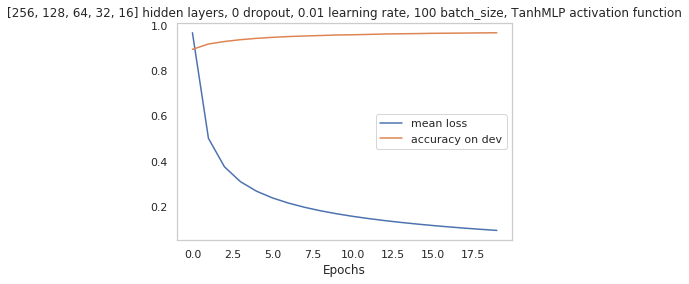

Starting epoch: 0
mean loss:  1.7670186874913234
dev accuracy:  0.607
Starting epoch: 1
mean loss:  1.275979243072809
dev accuracy:  0.7238
Starting epoch: 2
mean loss:  1.096006846895405
dev accuracy:  0.7664
Starting epoch: 3
mean loss:  0.9845243026228512
dev accuracy:  0.7958
Starting epoch: 4
mean loss:  0.9030658614401724
dev accuracy:  0.817
Starting epoch: 5
mean loss:  0.8384598283206716
dev accuracy:  0.8347
Starting epoch: 6
mean loss:  0.7847477232708651
dev accuracy:  0.8478
Starting epoch: 7
mean loss:  0.7387382621858635
dev accuracy:  0.8596
Starting epoch: 8
mean loss:  0.6985231392523822
dev accuracy:  0.8682
Starting epoch: 9
mean loss:  0.6628781486960018
dev accuracy:  0.8755
Starting epoch: 10
mean loss:  0.6309766535665474
dev accuracy:  0.8817
Starting epoch: 11
mean loss:  0.6022340409895953
dev accuracy:  0.8878
Starting epoch: 12
mean loss:  0.5762155348179387
dev accuracy:  0.8914
Starting epoch: 13
mean loss:  0.5525804980128419
dev accuracy:  0.8957
Starti

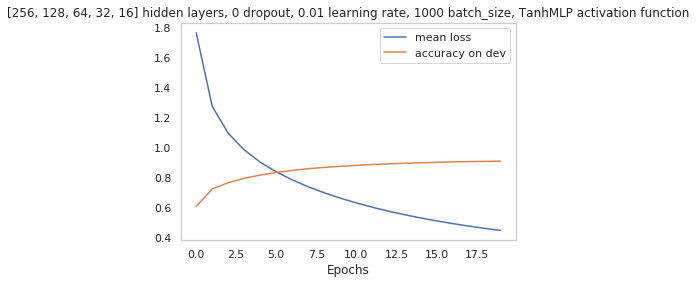

Starting epoch: 0
mean loss:  0.7364889320214792
dev accuracy:  0.9159
Starting epoch: 1
mean loss:  0.44195466154359075
dev accuracy:  0.9346
Starting epoch: 2
mean loss:  0.37252766313766916
dev accuracy:  0.9454
Starting epoch: 3
mean loss:  0.3305500192978151
dev accuracy:  0.9501
Starting epoch: 4
mean loss:  0.30082603865965135
dev accuracy:  0.9548
Starting epoch: 5
mean loss:  0.2767837917445411
dev accuracy:  0.958
Starting epoch: 6
mean loss:  0.2634550106059518
dev accuracy:  0.9596
Starting epoch: 7
mean loss:  0.2438821690670112
dev accuracy:  0.9624
Starting epoch: 8
mean loss:  0.23027169952370932
dev accuracy:  0.9636
Starting epoch: 9
mean loss:  0.2240414939898237
dev accuracy:  0.9655
Starting epoch: 10
mean loss:  0.21323750918320275
dev accuracy:  0.9646
Starting epoch: 11
mean loss:  0.2039927513948706
dev accuracy:  0.9668
Starting epoch: 12
mean loss:  0.193466110047347
dev accuracy:  0.968
Starting epoch: 13
mean loss:  0.18554068104102514
dev accuracy:  0.9692

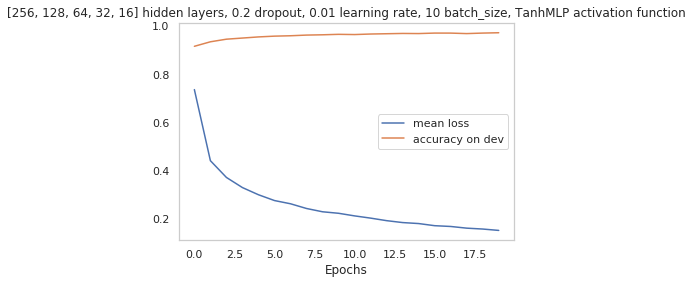

Starting epoch: 0
mean loss:  1.4370419462759814
dev accuracy:  0.8608
Starting epoch: 1
mean loss:  0.8908410317407635
dev accuracy:  0.891
Starting epoch: 2
mean loss:  0.7286153103777034
dev accuracy:  0.9002
Starting epoch: 3
mean loss:  0.640156196084565
dev accuracy:  0.9081
Starting epoch: 4
mean loss:  0.584144115091084
dev accuracy:  0.9111
Starting epoch: 5
mean loss:  0.5443242158361538
dev accuracy:  0.9154
Starting epoch: 6
mean loss:  0.5136408450717698
dev accuracy:  0.9193
Starting epoch: 7
mean loss:  0.4924403823421387
dev accuracy:  0.9223
Starting epoch: 8
mean loss:  0.4736896542137017
dev accuracy:  0.9249
Starting epoch: 9
mean loss:  0.4570599868447481
dev accuracy:  0.9274
Starting epoch: 10
mean loss:  0.4488381649146299
dev accuracy:  0.9296
Starting epoch: 11
mean loss:  0.4318320970989749
dev accuracy:  0.931
Starting epoch: 12
mean loss:  0.42503144611379584
dev accuracy:  0.9328
Starting epoch: 13
mean loss:  0.40722025017776414
dev accuracy:  0.935
Start

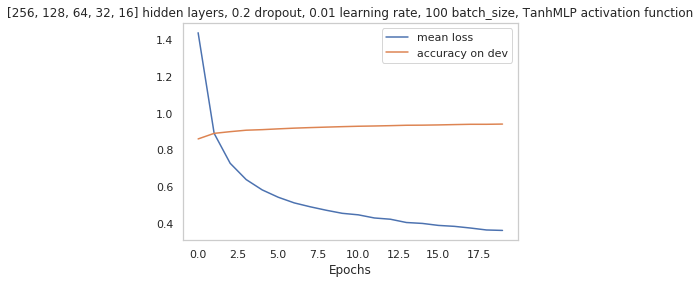

Starting epoch: 0
mean loss:  2.167231505992366
dev accuracy:  0.5536
Starting epoch: 1
mean loss:  1.740050051726547
dev accuracy:  0.6682
Starting epoch: 2
mean loss:  1.549501435429442
dev accuracy:  0.7188
Starting epoch: 3
mean loss:  1.4169322906755935
dev accuracy:  0.7504
Starting epoch: 4
mean loss:  1.3277552525202434
dev accuracy:  0.775
Starting epoch: 5
mean loss:  1.2500514353022856
dev accuracy:  0.7945
Starting epoch: 6
mean loss:  1.1855068463905185
dev accuracy:  0.8125
Starting epoch: 7
mean loss:  1.1316997373805326
dev accuracy:  0.8259
Starting epoch: 8
mean loss:  1.0863607911502613
dev accuracy:  0.8351
Starting epoch: 9
mean loss:  1.0402113503100825
dev accuracy:  0.8447
Starting epoch: 10
mean loss:  1.0065144253712075
dev accuracy:  0.8521
Starting epoch: 11
mean loss:  0.9730584831798778
dev accuracy:  0.8565
Starting epoch: 12
mean loss:  0.9402474293521806
dev accuracy:  0.8603
Starting epoch: 13
mean loss:  0.9152795111431795
dev accuracy:  0.8646
Starti

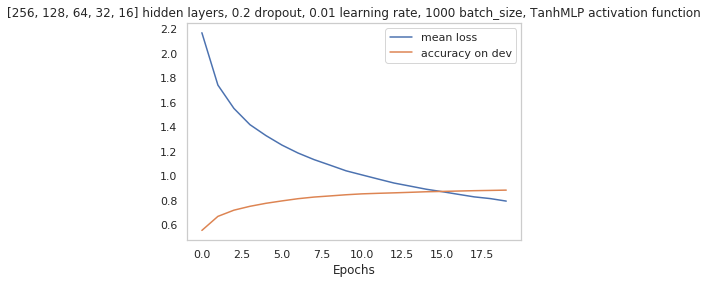

Starting epoch: 0
mean loss:  1.3083797806240371
dev accuracy:  0.861
Starting epoch: 1
mean loss:  0.8541902072088549
dev accuracy:  0.8852
Starting epoch: 2
mean loss:  0.741275513726064
dev accuracy:  0.9064
Starting epoch: 3
mean loss:  0.6587465748256431
dev accuracy:  0.9138
Starting epoch: 4
mean loss:  0.6105429757542132
dev accuracy:  0.924
Starting epoch: 5
mean loss:  0.561035505977363
dev accuracy:  0.9278
Starting epoch: 6
mean loss:  0.5454347209326686
dev accuracy:  0.9309
Starting epoch: 7
mean loss:  0.5147656952395031
dev accuracy:  0.9349
Starting epoch: 8
mean loss:  0.495026532879408
dev accuracy:  0.936
Starting epoch: 9
mean loss:  0.4815712480611579
dev accuracy:  0.9394
Starting epoch: 10
mean loss:  0.46213688719976703
dev accuracy:  0.9426
Starting epoch: 11
mean loss:  0.4512092111178951
dev accuracy:  0.9432
Starting epoch: 12
mean loss:  0.43856298646497993
dev accuracy:  0.9485
Starting epoch: 13
mean loss:  0.4308061877765034
dev accuracy:  0.9498
Starti

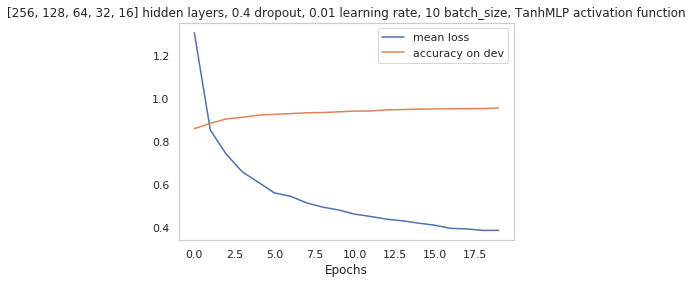

Starting epoch: 0
mean loss:  2.088934564304923
dev accuracy:  0.729
Starting epoch: 1
mean loss:  1.5488272374737524
dev accuracy:  0.779
Starting epoch: 2
mean loss:  1.3343663290589156
dev accuracy:  0.8089
Starting epoch: 3
mean loss:  1.1993744611264228
dev accuracy:  0.8229
Starting epoch: 4
mean loss:  1.1030966491994267
dev accuracy:  0.8456
Starting epoch: 5
mean loss:  1.0318149921898832
dev accuracy:  0.8584
Starting epoch: 6
mean loss:  0.978080441256959
dev accuracy:  0.8731
Starting epoch: 7
mean loss:  0.9332183031978721
dev accuracy:  0.881
Starting epoch: 8
mean loss:  0.8931866495195263
dev accuracy:  0.8863
Starting epoch: 9
mean loss:  0.8619767431013599
dev accuracy:  0.8893
Starting epoch: 10
mean loss:  0.8393129537443439
dev accuracy:  0.8926
Starting epoch: 11
mean loss:  0.80458821507985
dev accuracy:  0.8954
Starting epoch: 12
mean loss:  0.7807639546974928
dev accuracy:  0.8997
Starting epoch: 13
mean loss:  0.7601574259603808
dev accuracy:  0.9027
Starting 

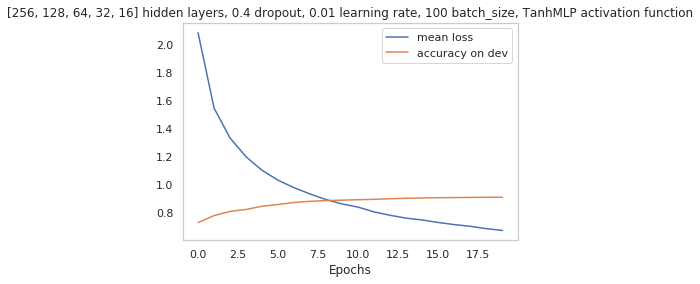

Starting epoch: 0
mean loss:  2.606848104327333
dev accuracy:  0.3794
Starting epoch: 1
mean loss:  2.326244976006302
dev accuracy:  0.5129
Starting epoch: 2
mean loss:  2.1495527847140443
dev accuracy:  0.5738
Starting epoch: 3
mean loss:  2.039552237473282
dev accuracy:  0.6042
Starting epoch: 4
mean loss:  1.946968814905952
dev accuracy:  0.6277
Starting epoch: 5
mean loss:  1.873659615423165
dev accuracy:  0.6457
Starting epoch: 6
mean loss:  1.818686931741004
dev accuracy:  0.6621
Starting epoch: 7
mean loss:  1.7654859131457759
dev accuracy:  0.6729
Starting epoch: 8
mean loss:  1.7185466242771523
dev accuracy:  0.6862
Starting epoch: 9
mean loss:  1.676057962810292
dev accuracy:  0.6971
Starting epoch: 10
mean loss:  1.6478697973139145
dev accuracy:  0.7034
Starting epoch: 11
mean loss:  1.6104014761307661
dev accuracy:  0.712
Starting epoch: 12
mean loss:  1.5784115019966574
dev accuracy:  0.7167
Starting epoch: 13
mean loss:  1.5481159687042236
dev accuracy:  0.7235
Starting e

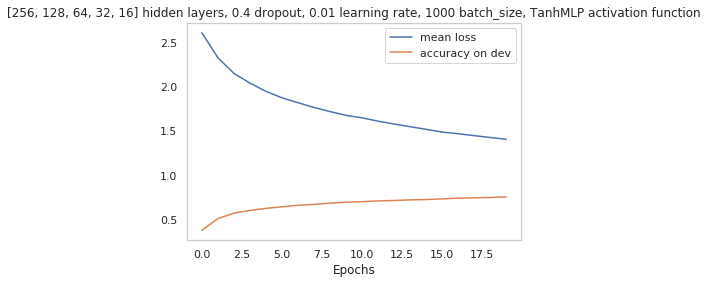

Starting epoch: 0
mean loss:  0.9179581503818284
dev accuracy:  0.8907
Starting epoch: 1
mean loss:  0.4836729049289305
dev accuracy:  0.9141
Starting epoch: 2
mean loss:  0.3664764672774025
dev accuracy:  0.9261
Starting epoch: 3
mean loss:  0.3055472226306525
dev accuracy:  0.9337
Starting epoch: 4
mean loss:  0.2661399337653219
dev accuracy:  0.9397
Starting epoch: 5
mean loss:  0.23731812519866619
dev accuracy:  0.9445
Starting epoch: 6
mean loss:  0.21461401899043345
dev accuracy:  0.948
Starting epoch: 7
mean loss:  0.19593691523731577
dev accuracy:  0.9519
Starting epoch: 8
mean loss:  0.18017581971635988
dev accuracy:  0.9557
Starting epoch: 9
mean loss:  0.16665248953251452
dev accuracy:  0.9575
Starting epoch: 10
mean loss:  0.15489845886644757
dev accuracy:  0.9597
Starting epoch: 11
mean loss:  0.14456865196022223
dev accuracy:  0.9618
Starting epoch: 12
mean loss:  0.13540267656894148
dev accuracy:  0.9627
Starting epoch: 13
mean loss:  0.1272013478997519
dev accuracy:  0.

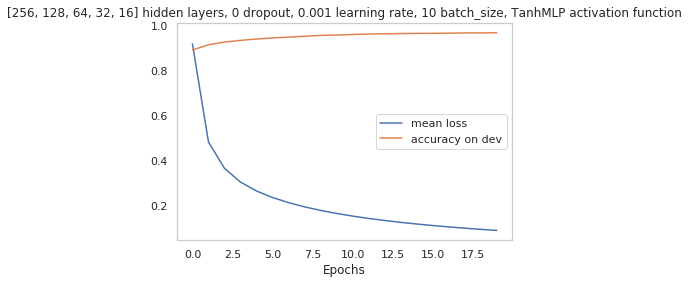

Starting epoch: 0
mean loss:  1.7339632901364934
dev accuracy:  0.617
Starting epoch: 1
mean loss:  1.2475626076053004
dev accuracy:  0.7373
Starting epoch: 2
mean loss:  1.0708344610865244
dev accuracy:  0.7916
Starting epoch: 3
mean loss:  0.9594484090567111
dev accuracy:  0.8193
Starting epoch: 4
mean loss:  0.8771757444221816
dev accuracy:  0.84
Starting epoch: 5
mean loss:  0.8116359613136855
dev accuracy:  0.8541
Starting epoch: 6
mean loss:  0.7571351180771392
dev accuracy:  0.8653
Starting epoch: 7
mean loss:  0.71062522757791
dev accuracy:  0.8721
Starting epoch: 8
mean loss:  0.6702877737566858
dev accuracy:  0.879
Starting epoch: 9
mean loss:  0.634925810995692
dev accuracy:  0.8849
Starting epoch: 10
mean loss:  0.603682484693394
dev accuracy:  0.8889
Starting epoch: 11
mean loss:  0.5759044800570863
dev accuracy:  0.8935
Starting epoch: 12
mean loss:  0.5510725887592681
dev accuracy:  0.8968
Starting epoch: 13
mean loss:  0.5287634602444853
dev accuracy:  0.8992
Starting e

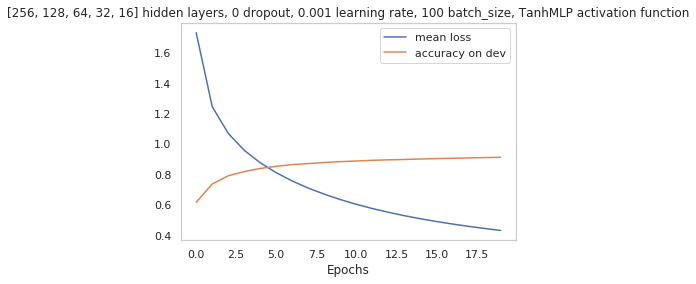

Starting epoch: 0
mean loss:  2.362982749938965
dev accuracy:  0.1806
Starting epoch: 1
mean loss:  2.109170123642566
dev accuracy:  0.2982
Starting epoch: 2
mean loss:  1.9356841620276957
dev accuracy:  0.3972
Starting epoch: 3
mean loss:  1.80152525621302
dev accuracy:  0.4681
Starting epoch: 4
mean loss:  1.6919151240704107
dev accuracy:  0.5184
Starting epoch: 5
mean loss:  1.6007957248126758
dev accuracy:  0.559
Starting epoch: 6
mean loss:  1.524714607818454
dev accuracy:  0.5873
Starting epoch: 7
mean loss:  1.4608023657518274
dev accuracy:  0.6139
Starting epoch: 8
mean loss:  1.4065191044526941
dev accuracy:  0.6343
Starting epoch: 9
mean loss:  1.3597662332011204
dev accuracy:  0.6517
Starting epoch: 10
mean loss:  1.318911772148282
dev accuracy:  0.6666
Starting epoch: 11
mean loss:  1.2827265192480648
dev accuracy:  0.6807
Starting epoch: 12
mean loss:  1.250293299263599
dev accuracy:  0.6947
Starting epoch: 13
mean loss:  1.2209245737861185
dev accuracy:  0.7074
Starting e

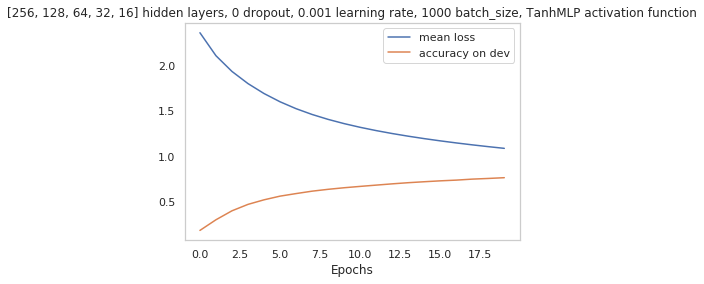

Starting epoch: 0
mean loss:  1.4658103785296006
dev accuracy:  0.8429
Starting epoch: 1
mean loss:  0.9250933569601788
dev accuracy:  0.8815
Starting epoch: 2
mean loss:  0.7510274329785703
dev accuracy:  0.8944
Starting epoch: 3
mean loss:  0.6555498789722527
dev accuracy:  0.9048
Starting epoch: 4
mean loss:  0.6025629204807222
dev accuracy:  0.911
Starting epoch: 5
mean loss:  0.5538853577274283
dev accuracy:  0.9152
Starting epoch: 6
mean loss:  0.521985672347261
dev accuracy:  0.9181
Starting epoch: 7
mean loss:  0.4983583780709886
dev accuracy:  0.922
Starting epoch: 8
mean loss:  0.47764087831752344
dev accuracy:  0.926
Starting epoch: 9
mean loss:  0.463644704715362
dev accuracy:  0.9285
Starting epoch: 10
mean loss:  0.4448038168829564
dev accuracy:  0.9297
Starting epoch: 11
mean loss:  0.4319711783273271
dev accuracy:  0.9312
Starting epoch: 12
mean loss:  0.42305816779085587
dev accuracy:  0.9334
Starting epoch: 13
mean loss:  0.40962775682643504
dev accuracy:  0.9345
Star

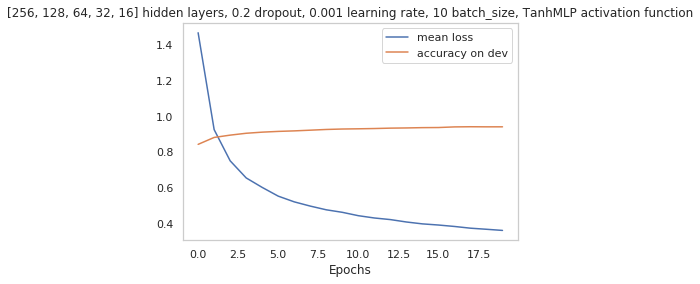

Starting epoch: 0
mean loss:  2.2353311708111487
dev accuracy:  0.564
Starting epoch: 1
mean loss:  1.7887307381677533
dev accuracy:  0.6913
Starting epoch: 2
mean loss:  1.5868480276918697
dev accuracy:  0.747
Starting epoch: 3
mean loss:  1.4430788712587186
dev accuracy:  0.7844
Starting epoch: 4
mean loss:  1.3363572718378551
dev accuracy:  0.809
Starting epoch: 5
mean loss:  1.2610188489426635
dev accuracy:  0.8261
Starting epoch: 6
mean loss:  1.1976702376278099
dev accuracy:  0.8374
Starting epoch: 7
mean loss:  1.1355353123889473
dev accuracy:  0.846
Starting epoch: 8
mean loss:  1.0885608241467657
dev accuracy:  0.854
Starting epoch: 9
mean loss:  1.0403209275114322
dev accuracy:  0.8599
Starting epoch: 10
mean loss:  1.0057530632751905
dev accuracy:  0.8643
Starting epoch: 11
mean loss:  0.9739780023902238
dev accuracy:  0.8697
Starting epoch: 12
mean loss:  0.9404121928824161
dev accuracy:  0.8721
Starting epoch: 13
mean loss:  0.9131234484518359
dev accuracy:  0.8743
Startin

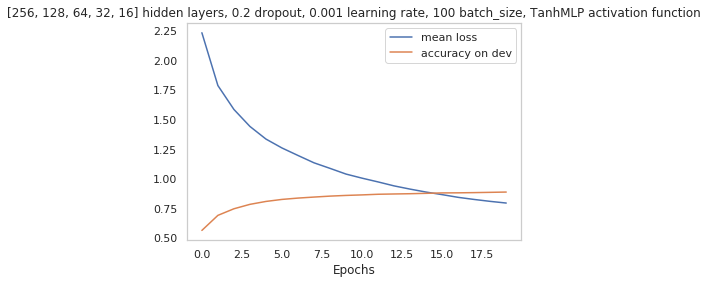

Starting epoch: 0
mean loss:  2.561458606345981
dev accuracy:  0.1621
Starting epoch: 1
mean loss:  2.434360616347369
dev accuracy:  0.2678
Starting epoch: 2
mean loss:  2.32732136109296
dev accuracy:  0.3358
Starting epoch: 3
mean loss:  2.2348220067865707
dev accuracy:  0.3928
Starting epoch: 4
mean loss:  2.1651709780973545
dev accuracy:  0.4399
Starting epoch: 5
mean loss:  2.1020971606759464
dev accuracy:  0.4751
Starting epoch: 6
mean loss:  2.044403083184186
dev accuracy:  0.5069
Starting epoch: 7
mean loss:  1.9880411367790372
dev accuracy:  0.5323
Starting epoch: 8
mean loss:  1.9464499880285824
dev accuracy:  0.5511
Starting epoch: 9
mean loss:  1.8982200295317406
dev accuracy:  0.5688
Starting epoch: 10
mean loss:  1.8630656494813806
dev accuracy:  0.5837
Starting epoch: 11
mean loss:  1.8255235938464893
dev accuracy:  0.5956
Starting epoch: 12
mean loss:  1.7952942824831195
dev accuracy:  0.6079
Starting epoch: 13
mean loss:  1.7651883246851903
dev accuracy:  0.6183
Startin

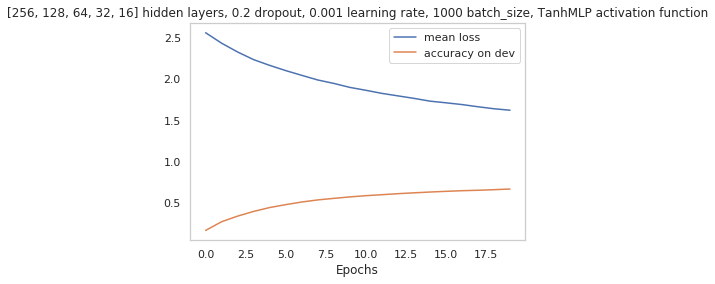

Starting epoch: 0
mean loss:  2.0588098925677474
dev accuracy:  0.6767
Starting epoch: 1
mean loss:  1.5395973535495575
dev accuracy:  0.7704
Starting epoch: 2
mean loss:  1.3217557456118658
dev accuracy:  0.8245
Starting epoch: 3
mean loss:  1.1845260829692887
dev accuracy:  0.8531
Starting epoch: 4
mean loss:  1.0772777300874035
dev accuracy:  0.8662
Starting epoch: 5
mean loss:  1.0003432765248488
dev accuracy:  0.8721
Starting epoch: 6
mean loss:  0.9396492620928958
dev accuracy:  0.8773
Starting epoch: 7
mean loss:  0.9021257694793496
dev accuracy:  0.8824
Starting epoch: 8
mean loss:  0.8625885401307715
dev accuracy:  0.8869
Starting epoch: 9
mean loss:  0.830378677094848
dev accuracy:  0.8873
Starting epoch: 10
mean loss:  0.8094857451266657
dev accuracy:  0.8892
Starting epoch: 11
mean loss:  0.7865825490480398
dev accuracy:  0.8905
Starting epoch: 12
mean loss:  0.7682487835045744
dev accuracy:  0.8936
Starting epoch: 13
mean loss:  0.7484038650670711
dev accuracy:  0.8947
Sta

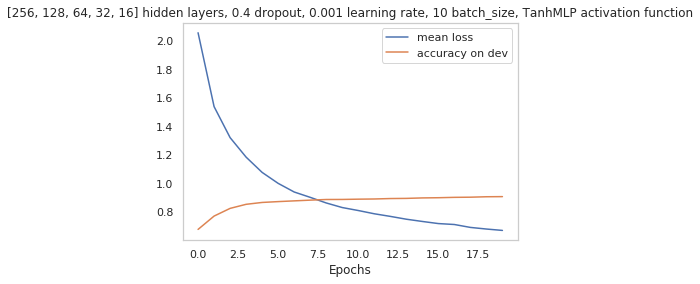

Starting epoch: 0
mean loss:  2.744668441856217
dev accuracy:  0.4413
Starting epoch: 1
mean loss:  2.494939974444117
dev accuracy:  0.5974
Starting epoch: 2
mean loss:  2.308834484237397
dev accuracy:  0.6497
Starting epoch: 3
mean loss:  2.1768640227422504
dev accuracy:  0.6777
Starting epoch: 4
mean loss:  2.078725964723233
dev accuracy:  0.6942
Starting epoch: 5
mean loss:  1.9877071354441538
dev accuracy:  0.7033
Starting epoch: 6
mean loss:  1.907418707649627
dev accuracy:  0.7133
Starting epoch: 7
mean loss:  1.8516793258175879
dev accuracy:  0.7233
Starting epoch: 8
mean loss:  1.7974101136068623
dev accuracy:  0.7293
Starting epoch: 9
mean loss:  1.7458827909595238
dev accuracy:  0.74
Starting epoch: 10
mean loss:  1.7041946437782394
dev accuracy:  0.7489
Starting epoch: 11
mean loss:  1.661607578604997
dev accuracy:  0.754
Starting epoch: 12
mean loss:  1.6198589766096927
dev accuracy:  0.7586
Starting epoch: 13
mean loss:  1.5891397134986467
dev accuracy:  0.7651
Starting ep

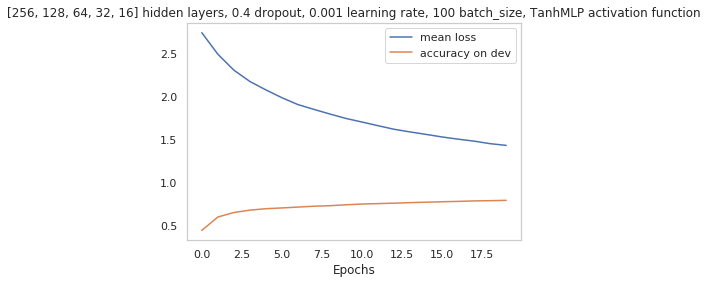

Starting epoch: 0
mean loss:  2.806562872493968
dev accuracy:  0.0869
Starting epoch: 1
mean loss:  2.7625072703642
dev accuracy:  0.123
Starting epoch: 2
mean loss:  2.7366423373128854
dev accuracy:  0.1667
Starting epoch: 3
mean loss:  2.7011249906876507
dev accuracy:  0.2076
Starting epoch: 4
mean loss:  2.659593699025173
dev accuracy:  0.2528
Starting epoch: 5
mean loss:  2.638266166051229
dev accuracy:  0.2929
Starting epoch: 6
mean loss:  2.598279597712498
dev accuracy:  0.3287
Starting epoch: 7
mean loss:  2.5767024825601017
dev accuracy:  0.3612
Starting epoch: 8
mean loss:  2.5436312871820785
dev accuracy:  0.3857
Starting epoch: 9
mean loss:  2.5172162523456647
dev accuracy:  0.4103
Starting epoch: 10
mean loss:  2.489616824131386
dev accuracy:  0.4296
Starting epoch: 11
mean loss:  2.4675754378823673
dev accuracy:  0.446
Starting epoch: 12
mean loss:  2.445947389976651
dev accuracy:  0.4588
Starting epoch: 13
mean loss:  2.4164346947389492
dev accuracy:  0.4745
Starting epoc

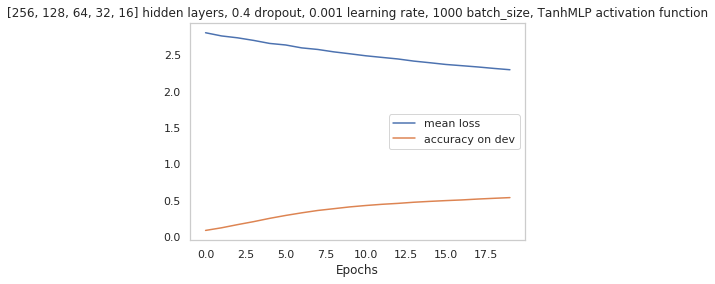

Starting epoch: 0
mean loss:  0.33694436248226867
dev accuracy:  0.9448
Starting epoch: 1
mean loss:  0.19424881214641707
dev accuracy:  0.9549
Starting epoch: 2
mean loss:  0.15400031655774502
dev accuracy:  0.953
Starting epoch: 3
mean loss:  0.13181960698841202
dev accuracy:  0.9521
Starting epoch: 4
mean loss:  0.11299198342312534
dev accuracy:  0.9656
Starting epoch: 5
mean loss:  0.10265522862501872
dev accuracy:  0.9639
Starting epoch: 6
mean loss:  0.0959972318204271
dev accuracy:  0.9643
Starting epoch: 7
mean loss:  0.08792307945974902
dev accuracy:  0.9585
Starting epoch: 8
mean loss:  0.08580806945396878
dev accuracy:  0.9665
Starting epoch: 9
mean loss:  0.0798471291677116
dev accuracy:  0.9686
Starting epoch: 10
mean loss:  0.07939388515193807
dev accuracy:  0.9631
Starting epoch: 11
mean loss:  0.07157530377391212
dev accuracy:  0.9681
Starting epoch: 12
mean loss:  0.06650131737219614
dev accuracy:  0.9654
Starting epoch: 13
mean loss:  0.059487623176208766
dev accuracy

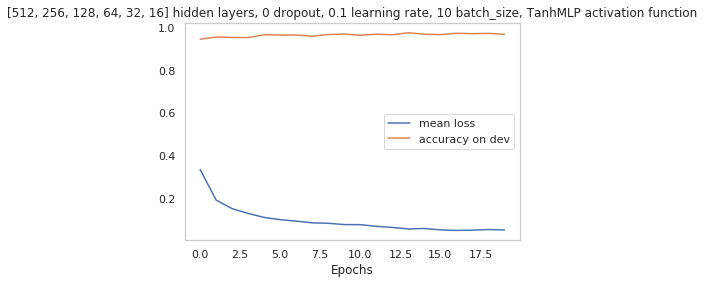

Starting epoch: 0
mean loss:  0.38693419268388235
dev accuracy:  0.9489
Starting epoch: 1
mean loss:  0.15758846854110678
dev accuracy:  0.9673
Starting epoch: 2
mean loss:  0.10477750210794146
dev accuracy:  0.9711
Starting epoch: 3
mean loss:  0.07442732599048973
dev accuracy:  0.974
Starting epoch: 4
mean loss:  0.05535576191959445
dev accuracy:  0.9739
Starting epoch: 5
mean loss:  0.04146282417985969
dev accuracy:  0.9757
Starting epoch: 6
mean loss:  0.031632510699822515
dev accuracy:  0.9747
Starting epoch: 7
mean loss:  0.02454606132970346
dev accuracy:  0.9772
Starting epoch: 8
mean loss:  0.019317215431236223
dev accuracy:  0.9755
Starting epoch: 9
mean loss:  0.013749560801788213
dev accuracy:  0.9767
Starting epoch: 10
mean loss:  0.010462108408351859
dev accuracy:  0.9768
Starting epoch: 11
mean loss:  0.008153646258161423
dev accuracy:  0.9779
Starting epoch: 12
mean loss:  0.005781418573252574
dev accuracy:  0.9782
Starting epoch: 13
mean loss:  0.00428930435705179
dev a

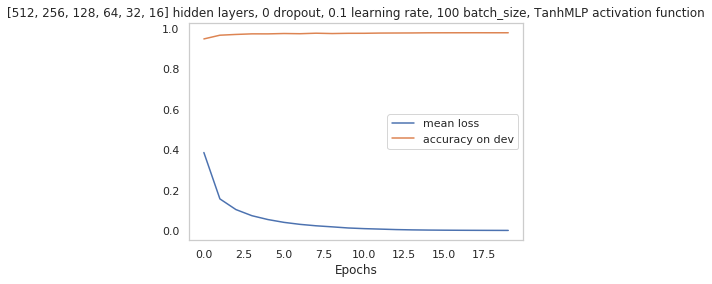

Starting epoch: 0
mean loss:  1.0427766115057702
dev accuracy:  0.8904
Starting epoch: 1
mean loss:  0.4849192985132629
dev accuracy:  0.9213
Starting epoch: 2
mean loss:  0.34556787154253793
dev accuracy:  0.9322
Starting epoch: 3
mean loss:  0.2779853545567569
dev accuracy:  0.9407
Starting epoch: 4
mean loss:  0.2363310549773422
dev accuracy:  0.9464
Starting epoch: 5
mean loss:  0.206988849476272
dev accuracy:  0.9517
Starting epoch: 6
mean loss:  0.18485617520762423
dev accuracy:  0.9561
Starting epoch: 7
mean loss:  0.16713005947131737
dev accuracy:  0.9586
Starting epoch: 8
mean loss:  0.15204021992052302
dev accuracy:  0.9592
Starting epoch: 9
mean loss:  0.13927426788152433
dev accuracy:  0.9605
Starting epoch: 10
mean loss:  0.12915239862951577
dev accuracy:  0.9641
Starting epoch: 11
mean loss:  0.11906347117003273
dev accuracy:  0.9627
Starting epoch: 12
mean loss:  0.11132746730365005
dev accuracy:  0.9635
Starting epoch: 13
mean loss:  0.10342408570588804
dev accuracy:  0

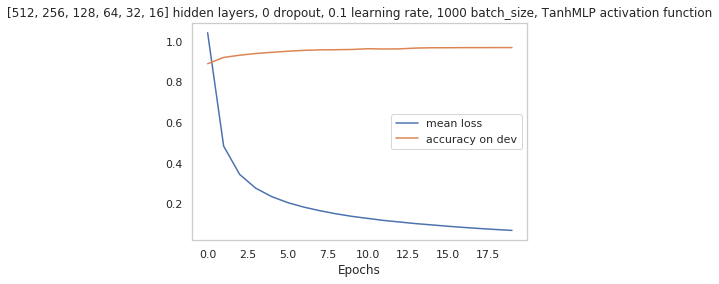

Starting epoch: 0
mean loss:  0.5988783536084448
dev accuracy:  0.9249
Starting epoch: 1
mean loss:  0.38648963220684923
dev accuracy:  0.9412
Starting epoch: 2
mean loss:  0.33752818619342617
dev accuracy:  0.9488
Starting epoch: 3
mean loss:  0.31140681786506985
dev accuracy:  0.948
Starting epoch: 4
mean loss:  0.3004153201017969
dev accuracy:  0.9454
Starting epoch: 5
mean loss:  0.27891918451135495
dev accuracy:  0.9568
Starting epoch: 6
mean loss:  0.2644566892413655
dev accuracy:  0.9582
Starting epoch: 7
mean loss:  0.25839981897381203
dev accuracy:  0.9566
Starting epoch: 8
mean loss:  0.26474493788964965
dev accuracy:  0.9557
Starting epoch: 9
mean loss:  0.25585162043727905
dev accuracy:  0.9536
Starting epoch: 10
mean loss:  0.2423643484282207
dev accuracy:  0.9567
Starting epoch: 11
mean loss:  0.25231527046677954
dev accuracy:  0.9584
Starting epoch: 12
mean loss:  0.254344573398928
dev accuracy:  0.9611
Starting epoch: 13
mean loss:  0.24778869686362576
dev accuracy:  0.

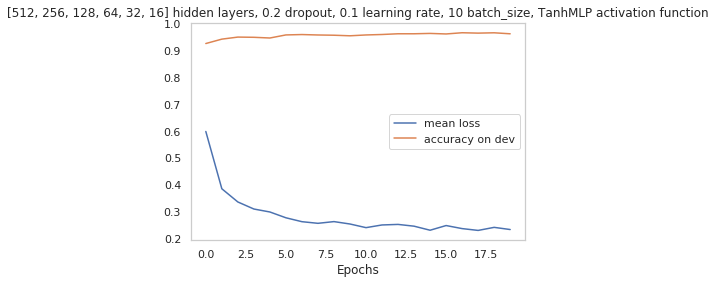

Starting epoch: 0
mean loss:  0.7782176904930564
dev accuracy:  0.9232
Starting epoch: 1
mean loss:  0.43672865852267445
dev accuracy:  0.942
Starting epoch: 2
mean loss:  0.3554478732203533
dev accuracy:  0.9473
Starting epoch: 3
mean loss:  0.31725754346438273
dev accuracy:  0.9557
Starting epoch: 4
mean loss:  0.2778430377503117
dev accuracy:  0.9597
Starting epoch: 5
mean loss:  0.2550681580356257
dev accuracy:  0.9613
Starting epoch: 6
mean loss:  0.238507085886901
dev accuracy:  0.9664
Starting epoch: 7
mean loss:  0.22296070902349943
dev accuracy:  0.9654
Starting epoch: 8
mean loss:  0.2044055463445044
dev accuracy:  0.9693
Starting epoch: 9
mean loss:  0.19577134703611304
dev accuracy:  0.9709
Starting epoch: 10
mean loss:  0.1815844494143051
dev accuracy:  0.9705
Starting epoch: 11
mean loss:  0.17614839931656262
dev accuracy:  0.9701
Starting epoch: 12
mean loss:  0.17051189511032874
dev accuracy:  0.9717
Starting epoch: 13
mean loss:  0.1600851072054245
dev accuracy:  0.973

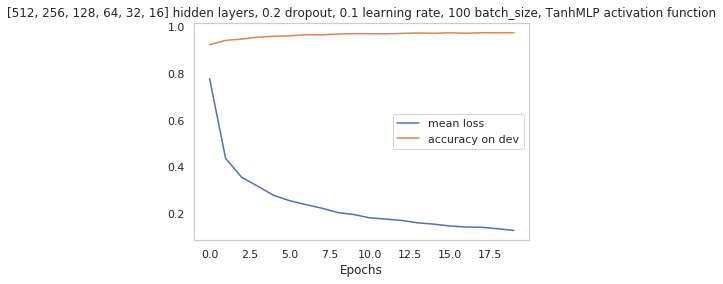

Starting epoch: 0
mean loss:  1.473616317206738
dev accuracy:  0.8283
Starting epoch: 1
mean loss:  0.9550849362915638
dev accuracy:  0.8791
Starting epoch: 2
mean loss:  0.763177144761179
dev accuracy:  0.8958
Starting epoch: 3
mean loss:  0.6575878040463317
dev accuracy:  0.9087
Starting epoch: 4
mean loss:  0.5859918594360352
dev accuracy:  0.9132
Starting epoch: 5
mean loss:  0.5363879373260573
dev accuracy:  0.9228
Starting epoch: 6
mean loss:  0.5005962685042736
dev accuracy:  0.9264
Starting epoch: 7
mean loss:  0.47250774911805693
dev accuracy:  0.9286
Starting epoch: 8
mean loss:  0.45204565688675524
dev accuracy:  0.9319
Starting epoch: 9
mean loss:  0.42511114536547195
dev accuracy:  0.9345
Starting epoch: 10
mean loss:  0.41518479410339804
dev accuracy:  0.9363
Starting epoch: 11
mean loss:  0.39725780837676106
dev accuracy:  0.9393
Starting epoch: 12
mean loss:  0.3853706436998704
dev accuracy:  0.9401
Starting epoch: 13
mean loss:  0.37334070603052777
dev accuracy:  0.942

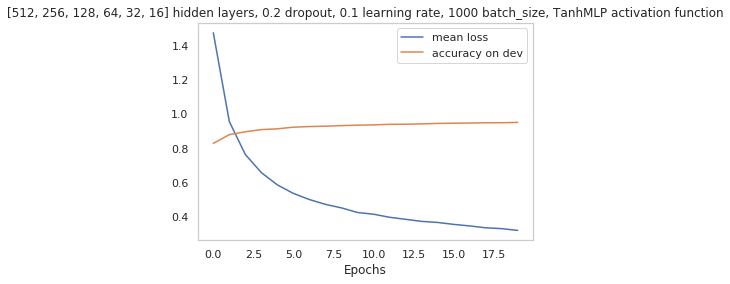

Starting epoch: 0
mean loss:  1.2026610433507074
dev accuracy:  0.778
Starting epoch: 1
mean loss:  0.8648813236962912
dev accuracy:  0.8153
Starting epoch: 2
mean loss:  0.7687806953605092
dev accuracy:  0.899
Starting epoch: 3
mean loss:  0.7810162197239063
dev accuracy:  0.9012
Starting epoch: 4
mean loss:  0.7635708486862813
dev accuracy:  0.9082
Starting epoch: 5
mean loss:  0.7641117269904393
dev accuracy:  0.8901
Starting epoch: 6
mean loss:  0.7825804723382378
dev accuracy:  0.893
Starting epoch: 7
mean loss:  0.8350623013111644
dev accuracy:  0.8826
Starting epoch: 8
mean loss:  0.8500577464529906
dev accuracy:  0.8765
Starting epoch: 9
mean loss:  0.878559580777817
dev accuracy:  0.8783
Starting epoch: 10
mean loss:  0.8540038113888085
dev accuracy:  0.886
Starting epoch: 11
mean loss:  0.8688970852469687
dev accuracy:  0.8893
Starting epoch: 12
mean loss:  0.9512125938233913
dev accuracy:  0.8423
Starting epoch: 13
mean loss:  0.9348320229617006
dev accuracy:  0.8465
Startin

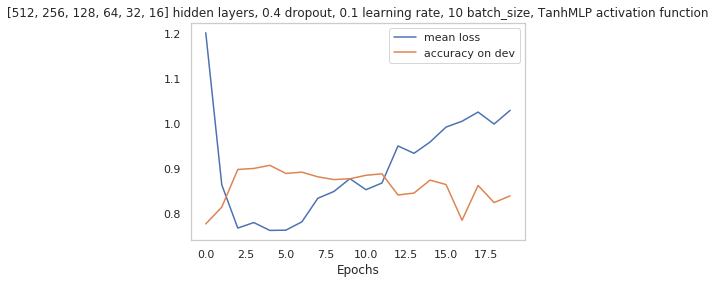

Starting epoch: 0
mean loss:  1.360152195432705
dev accuracy:  0.8541
Starting epoch: 1
mean loss:  0.8393595702276972
dev accuracy:  0.8978
Starting epoch: 2
mean loss:  0.7016528462935351
dev accuracy:  0.9119
Starting epoch: 3
mean loss:  0.6268791097128938
dev accuracy:  0.9162
Starting epoch: 4
mean loss:  0.578452089411056
dev accuracy:  0.9271
Starting epoch: 5
mean loss:  0.5404551835533625
dev accuracy:  0.9318
Starting epoch: 6
mean loss:  0.5106237321318743
dev accuracy:  0.9347
Starting epoch: 7
mean loss:  0.48620100979676506
dev accuracy:  0.9438
Starting epoch: 8
mean loss:  0.4725129253076698
dev accuracy:  0.9454
Starting epoch: 9
mean loss:  0.44992359068817245
dev accuracy:  0.9462
Starting epoch: 10
mean loss:  0.43786939059545893
dev accuracy:  0.9526
Starting epoch: 11
mean loss:  0.42675242568561417
dev accuracy:  0.9542
Starting epoch: 12
mean loss:  0.4135351720565331
dev accuracy:  0.9529
Starting epoch: 13
mean loss:  0.39946850090326663
dev accuracy:  0.956


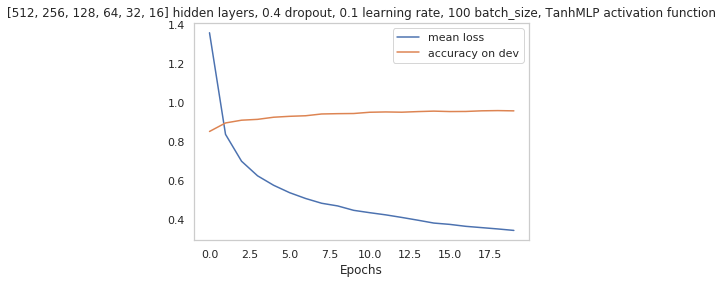

Starting epoch: 0
mean loss:  2.104248409177743
dev accuracy:  0.7494
Starting epoch: 1
mean loss:  1.5482543730268292
dev accuracy:  0.7906
Starting epoch: 2
mean loss:  1.3290721294926662
dev accuracy:  0.8169
Starting epoch: 3
mean loss:  1.1973842896667182
dev accuracy:  0.8389
Starting epoch: 4
mean loss:  1.1026507873161167
dev accuracy:  0.8516
Starting epoch: 5
mean loss:  1.03146310413585
dev accuracy:  0.8582
Starting epoch: 6
mean loss:  0.9859875814587462
dev accuracy:  0.8602
Starting epoch: 7
mean loss:  0.9358413640190574
dev accuracy:  0.8709
Starting epoch: 8
mean loss:  0.8990879386079078
dev accuracy:  0.8742
Starting epoch: 9
mean loss:  0.8751934404466667
dev accuracy:  0.8815
Starting epoch: 10
mean loss:  0.8411348076427684
dev accuracy:  0.882
Starting epoch: 11
mean loss:  0.8273861910782608
dev accuracy:  0.8911
Starting epoch: 12
mean loss:  0.7929446486865773
dev accuracy:  0.8935
Starting epoch: 13
mean loss:  0.7851086913370618
dev accuracy:  0.8963
Starti

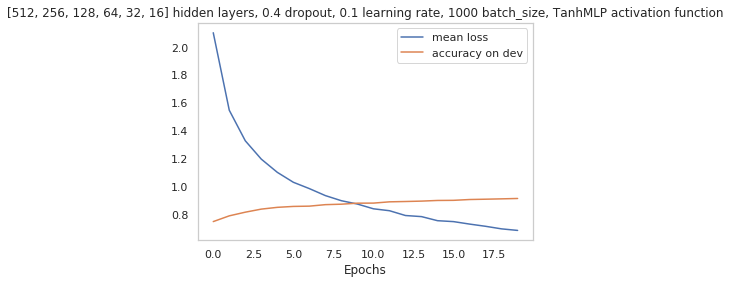

Starting epoch: 0
mean loss:  0.35206581092626005
dev accuracy:  0.9531
Starting epoch: 1
mean loss:  0.15052617420305525
dev accuracy:  0.9647
Starting epoch: 2
mean loss:  0.10122972633261319
dev accuracy:  0.9698
Starting epoch: 3
mean loss:  0.07297740028260458
dev accuracy:  0.9715
Starting epoch: 4
mean loss:  0.05446682378997118
dev accuracy:  0.9713
Starting epoch: 5
mean loss:  0.04017118943187635
dev accuracy:  0.9724
Starting epoch: 6
mean loss:  0.030931357405684968
dev accuracy:  0.9754
Starting epoch: 7
mean loss:  0.02231964447754019
dev accuracy:  0.976
Starting epoch: 8
mean loss:  0.017073814595080734
dev accuracy:  0.977
Starting epoch: 9
mean loss:  0.012575457504160581
dev accuracy:  0.977
Starting epoch: 10
mean loss:  0.009561763133227392
dev accuracy:  0.9773
Starting epoch: 11
mean loss:  0.006914875828275068
dev accuracy:  0.9783
Starting epoch: 12
mean loss:  0.005234576639540017
dev accuracy:  0.9785
Starting epoch: 13
mean loss:  0.004244792141838581
dev ac

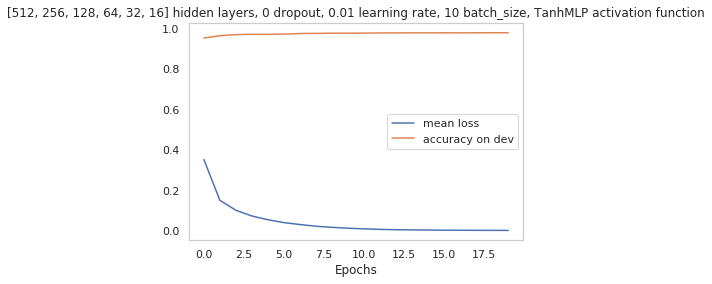

Starting epoch: 0
mean loss:  0.8356451084037979
dev accuracy:  0.8943
Starting epoch: 1
mean loss:  0.44170531933892987
dev accuracy:  0.9176
Starting epoch: 2
mean loss:  0.3320045938451371
dev accuracy:  0.931
Starting epoch: 3
mean loss:  0.27303499377475765
dev accuracy:  0.9404
Starting epoch: 4
mean loss:  0.2338679350630014
dev accuracy:  0.9478
Starting epoch: 5
mean loss:  0.20487514816358418
dev accuracy:  0.9524
Starting epoch: 6
mean loss:  0.18202845747777802
dev accuracy:  0.9562
Starting epoch: 7
mean loss:  0.16334665786036237
dev accuracy:  0.9593
Starting epoch: 8
mean loss:  0.14776324787866807
dev accuracy:  0.9612
Starting epoch: 9
mean loss:  0.13455801656443678
dev accuracy:  0.9626
Starting epoch: 10
mean loss:  0.12320268940842319
dev accuracy:  0.9644
Starting epoch: 11
mean loss:  0.11333010022987625
dev accuracy:  0.9657
Starting epoch: 12
mean loss:  0.10467071627487917
dev accuracy:  0.9672
Starting epoch: 13
mean loss:  0.09700693224673856
dev accuracy: 

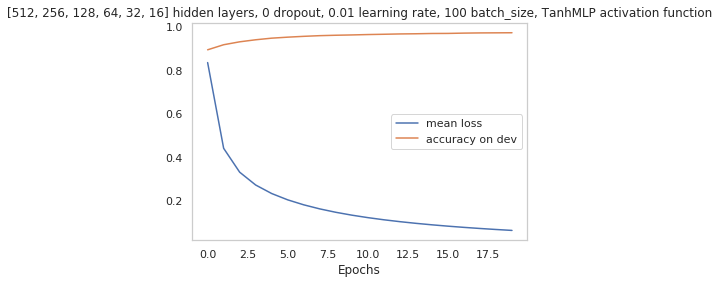

Starting epoch: 0
mean loss:  1.594825167281955
dev accuracy:  0.7189
Starting epoch: 1
mean loss:  1.0669625424871259
dev accuracy:  0.8094
Starting epoch: 2
mean loss:  0.8902386648982179
dev accuracy:  0.842
Starting epoch: 3
mean loss:  0.7826284789571575
dev accuracy:  0.8618
Starting epoch: 4
mean loss:  0.7062147727199629
dev accuracy:  0.874
Starting epoch: 5
mean loss:  0.6478646783267751
dev accuracy:  0.8816
Starting epoch: 6
mean loss:  0.6012978121346119
dev accuracy:  0.8881
Starting epoch: 7
mean loss:  0.5629870143591189
dev accuracy:  0.8932
Starting epoch: 8
mean loss:  0.5307453455878239
dev accuracy:  0.897
Starting epoch: 9
mean loss:  0.5031236410140991
dev accuracy:  0.9009
Starting epoch: 10
mean loss:  0.4791146604453816
dev accuracy:  0.9041
Starting epoch: 11
mean loss:  0.45799244969498876
dev accuracy:  0.907
Starting epoch: 12
mean loss:  0.439218378534504
dev accuracy:  0.9097
Starting epoch: 13
mean loss:  0.42238352111741606
dev accuracy:  0.9118
Starti

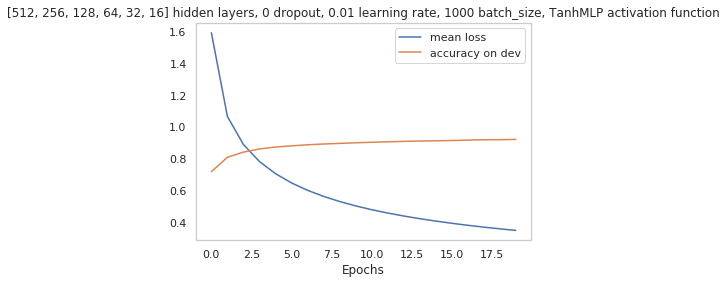

Starting epoch: 0
mean loss:  0.7613345702800589
dev accuracy:  0.9165
Starting epoch: 1
mean loss:  0.42972213456359143
dev accuracy:  0.938
Starting epoch: 2
mean loss:  0.34733817764345415
dev accuracy:  0.9474
Starting epoch: 3
mean loss:  0.30461879583178814
dev accuracy:  0.9542
Starting epoch: 4
mean loss:  0.27838462739650266
dev accuracy:  0.9593
Starting epoch: 5
mean loss:  0.25171946172928933
dev accuracy:  0.9611
Starting epoch: 6
mean loss:  0.23437674986172471
dev accuracy:  0.9617
Starting epoch: 7
mean loss:  0.21070331596800865
dev accuracy:  0.9658
Starting epoch: 8
mean loss:  0.20549159060003094
dev accuracy:  0.9685
Starting epoch: 9
mean loss:  0.19366641792099437
dev accuracy:  0.9687
Starting epoch: 10
mean loss:  0.18144739582347655
dev accuracy:  0.9691
Starting epoch: 11
mean loss:  0.16915435034508314
dev accuracy:  0.9717
Starting epoch: 12
mean loss:  0.1611809897864298
dev accuracy:  0.9725
Starting epoch: 13
mean loss:  0.16114358870417603
dev accuracy:

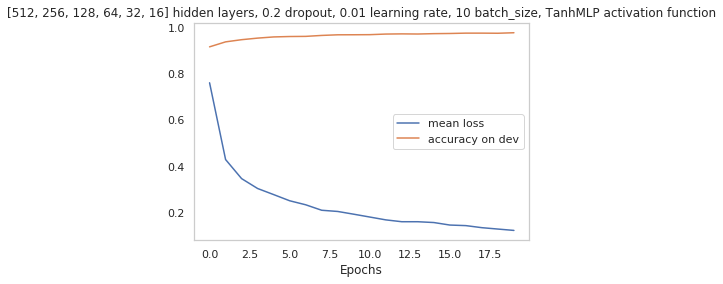

Starting epoch: 0
mean loss:  1.4907897488323751
dev accuracy:  0.8134
Starting epoch: 1
mean loss:  0.9758982027838092
dev accuracy:  0.8628
Starting epoch: 2
mean loss:  0.7938602366847193
dev accuracy:  0.8874
Starting epoch: 3
mean loss:  0.692687648737026
dev accuracy:  0.8992
Starting epoch: 4
mean loss:  0.6121702207895572
dev accuracy:  0.9075
Starting epoch: 5
mean loss:  0.5604290761157662
dev accuracy:  0.9148
Starting epoch: 6
mean loss:  0.5248483395624065
dev accuracy:  0.9197
Starting epoch: 7
mean loss:  0.4956648743557121
dev accuracy:  0.9234
Starting epoch: 8
mean loss:  0.4682865525612574
dev accuracy:  0.926
Starting epoch: 9
mean loss:  0.4475321291152113
dev accuracy:  0.9283
Starting epoch: 10
mean loss:  0.43299679886438175
dev accuracy:  0.9316
Starting epoch: 11
mean loss:  0.4172404905160268
dev accuracy:  0.9345
Starting epoch: 12
mean loss:  0.4060265447148782
dev accuracy:  0.9364
Starting epoch: 13
mean loss:  0.39063692672880823
dev accuracy:  0.9379
St

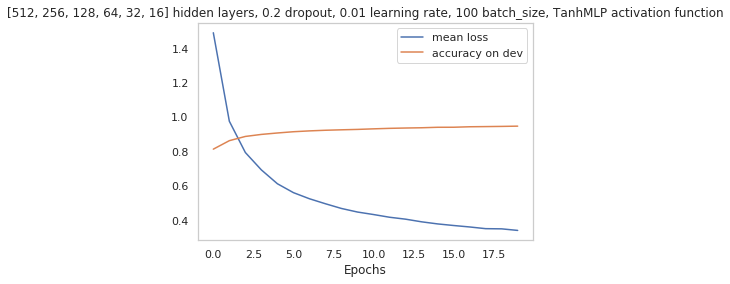

Starting epoch: 0
mean loss:  2.1941110760557887
dev accuracy:  0.5441
Starting epoch: 1
mean loss:  1.7303602087731456
dev accuracy:  0.6352
Starting epoch: 2
mean loss:  1.5366389026828842
dev accuracy:  0.6924
Starting epoch: 3
mean loss:  1.4195116033741073
dev accuracy:  0.7353
Starting epoch: 4
mean loss:  1.3355262770372278
dev accuracy:  0.7636
Starting epoch: 5
mean loss:  1.2708432510787366
dev accuracy:  0.7814
Starting epoch: 6
mean loss:  1.2122676980261708
dev accuracy:  0.797
Starting epoch: 7
mean loss:  1.164716318541882
dev accuracy:  0.8089
Starting epoch: 8
mean loss:  1.1227201480491489
dev accuracy:  0.8193
Starting epoch: 9
mean loss:  1.088349276897954
dev accuracy:  0.8302
Starting epoch: 10
mean loss:  1.0476193065736807
dev accuracy:  0.8356
Starting epoch: 11
mean loss:  1.0208847405863744
dev accuracy:  0.8427
Starting epoch: 12
mean loss:  0.9874077170502906
dev accuracy:  0.847
Starting epoch: 13
mean loss:  0.9651181978337905
dev accuracy:  0.8545
Starti

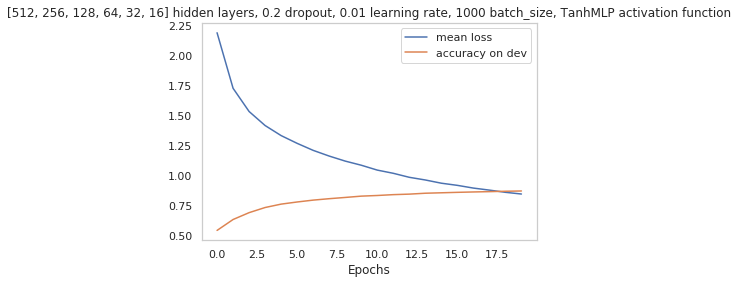

Starting epoch: 0
mean loss:  1.3482204766910901
dev accuracy:  0.8442
Starting epoch: 1
mean loss:  0.8492322954919261
dev accuracy:  0.8857
Starting epoch: 2
mean loss:  0.731133322876749
dev accuracy:  0.9077
Starting epoch: 3
mean loss:  0.6594818430399446
dev accuracy:  0.92
Starting epoch: 4
mean loss:  0.5970238533933994
dev accuracy:  0.9272
Starting epoch: 5
mean loss:  0.5528164109443455
dev accuracy:  0.9291
Starting epoch: 6
mean loss:  0.5235539768200306
dev accuracy:  0.9368
Starting epoch: 7
mean loss:  0.502539097713044
dev accuracy:  0.9407
Starting epoch: 8
mean loss:  0.486393352019232
dev accuracy:  0.9432
Starting epoch: 9
mean loss:  0.4610431664827239
dev accuracy:  0.9476
Starting epoch: 10
mean loss:  0.444433946856345
dev accuracy:  0.9467
Starting epoch: 11
mean loss:  0.4366942031334708
dev accuracy:  0.9511
Starting epoch: 12
mean loss:  0.4146651244511684
dev accuracy:  0.9546
Starting epoch: 13
mean loss:  0.40545570514921137
dev accuracy:  0.9566
Startin

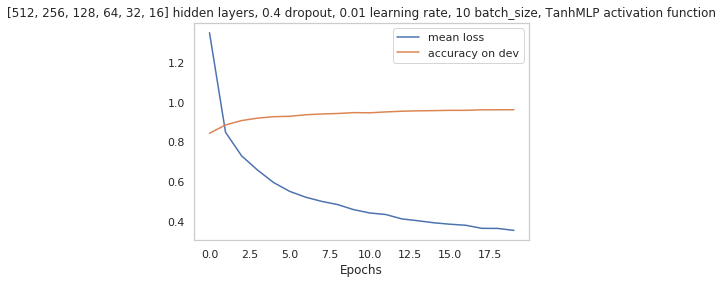

Starting epoch: 0
mean loss:  2.199075748820505
dev accuracy:  0.6459
Starting epoch: 1
mean loss:  1.6251852055509648
dev accuracy:  0.7013
Starting epoch: 2
mean loss:  1.4117134345505766
dev accuracy:  0.7366
Starting epoch: 3
mean loss:  1.280722719823529
dev accuracy:  0.7711
Starting epoch: 4
mean loss:  1.1973345757958418
dev accuracy:  0.7969
Starting epoch: 5
mean loss:  1.122461853507988
dev accuracy:  0.8203
Starting epoch: 6
mean loss:  1.0623518603290627
dev accuracy:  0.8411
Starting epoch: 7
mean loss:  1.0126470868696948
dev accuracy:  0.8512
Starting epoch: 8
mean loss:  0.9603806586560613
dev accuracy:  0.8622
Starting epoch: 9
mean loss:  0.9229202395427727
dev accuracy:  0.8715
Starting epoch: 10
mean loss:  0.8890307814537171
dev accuracy:  0.8779
Starting epoch: 11
mean loss:  0.8567653783781086
dev accuracy:  0.885
Starting epoch: 12
mean loss:  0.8253268626873602
dev accuracy:  0.8893
Starting epoch: 13
mean loss:  0.8081180446757052
dev accuracy:  0.8935
Starti

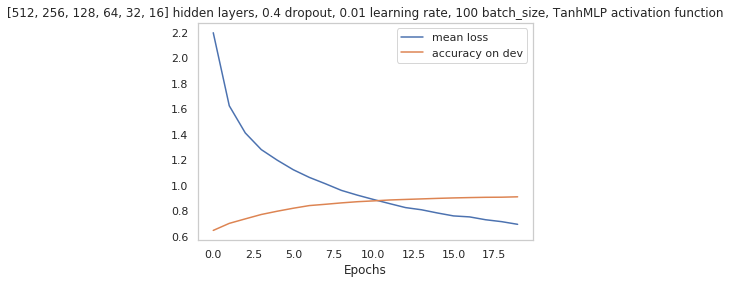

Starting epoch: 0
mean loss:  2.7715265517141305
dev accuracy:  0.4232
Starting epoch: 1
mean loss:  2.5323304148281323
dev accuracy:  0.556
Starting epoch: 2
mean loss:  2.3627980830622652
dev accuracy:  0.6016
Starting epoch: 3
mean loss:  2.2374635911455343
dev accuracy:  0.6232
Starting epoch: 4
mean loss:  2.1366355372410193
dev accuracy:  0.642
Starting epoch: 5
mean loss:  2.0505464591232
dev accuracy:  0.6519
Starting epoch: 6
mean loss:  1.9760701305725996
dev accuracy:  0.6646
Starting epoch: 7
mean loss:  1.9225960268693811
dev accuracy:  0.6815
Starting epoch: 8
mean loss:  1.8702636232563095
dev accuracy:  0.6844
Starting epoch: 9
mean loss:  1.8094315248377182
dev accuracy:  0.6952
Starting epoch: 10
mean loss:  1.7743614327673818
dev accuracy:  0.7055
Starting epoch: 11
mean loss:  1.735321612919078
dev accuracy:  0.7143
Starting epoch: 12
mean loss:  1.69278617699941
dev accuracy:  0.7203
Starting epoch: 13
mean loss:  1.660891105146969
dev accuracy:  0.723
Starting epo

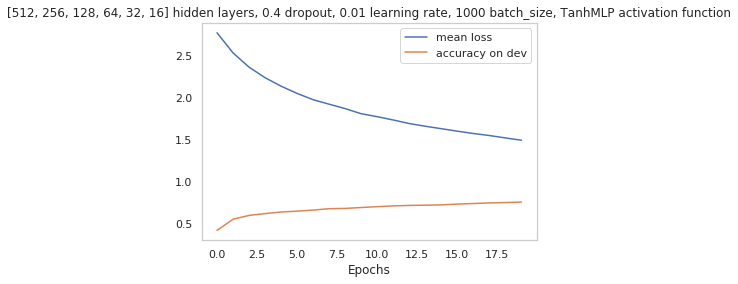

Starting epoch: 0
mean loss:  0.8803541247718598
dev accuracy:  0.902
Starting epoch: 1
mean loss:  0.45646282611573086
dev accuracy:  0.9252
Starting epoch: 2
mean loss:  0.3360415280976669
dev accuracy:  0.9362
Starting epoch: 3
mean loss:  0.2729334759115696
dev accuracy:  0.9458
Starting epoch: 4
mean loss:  0.231958042558337
dev accuracy:  0.952
Starting epoch: 5
mean loss:  0.20220095662698462
dev accuracy:  0.9552
Starting epoch: 6
mean loss:  0.17921282132944866
dev accuracy:  0.9592
Starting epoch: 7
mean loss:  0.16072341346086394
dev accuracy:  0.9622
Starting epoch: 8
mean loss:  0.145415371306981
dev accuracy:  0.9644
Starting epoch: 9
mean loss:  0.13246990087833363
dev accuracy:  0.9661
Starting epoch: 10
mean loss:  0.12134092016928859
dev accuracy:  0.9676
Starting epoch: 11
mean loss:  0.11164930312160735
dev accuracy:  0.9688
Starting epoch: 12
mean loss:  0.10311615494726283
dev accuracy:  0.9698
Starting epoch: 13
mean loss:  0.09552746145600344
dev accuracy:  0.97

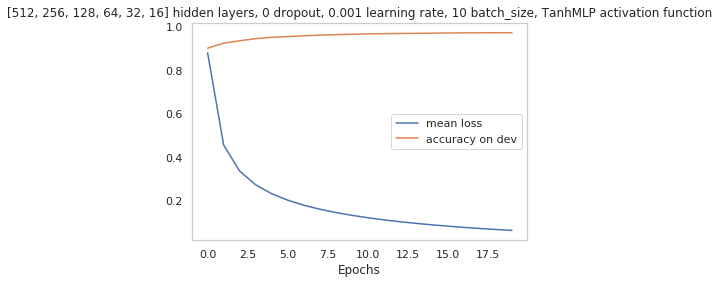

Starting epoch: 0
mean loss:  1.7178985587137188
dev accuracy:  0.7111
Starting epoch: 1
mean loss:  1.146206359187524
dev accuracy:  0.8065
Starting epoch: 2
mean loss:  0.9605011515274733
dev accuracy:  0.8445
Starting epoch: 3
mean loss:  0.8482004208954984
dev accuracy:  0.8658
Starting epoch: 4
mean loss:  0.7674179930172994
dev accuracy:  0.8776
Starting epoch: 5
mean loss:  0.7044559620811554
dev accuracy:  0.8855
Starting epoch: 6
mean loss:  0.6532628077589823
dev accuracy:  0.8915
Starting epoch: 7
mean loss:  0.6105502778422571
dev accuracy:  0.8971
Starting epoch: 8
mean loss:  0.5742626620861823
dev accuracy:  0.9017
Starting epoch: 9
mean loss:  0.5429968505562422
dev accuracy:  0.9049
Starting epoch: 10
mean loss:  0.5157418891698301
dev accuracy:  0.9085
Starting epoch: 11
mean loss:  0.49174331321925696
dev accuracy:  0.9112
Starting epoch: 12
mean loss:  0.4704249634476241
dev accuracy:  0.9128
Starting epoch: 13
mean loss:  0.45133883700875227
dev accuracy:  0.9149
S

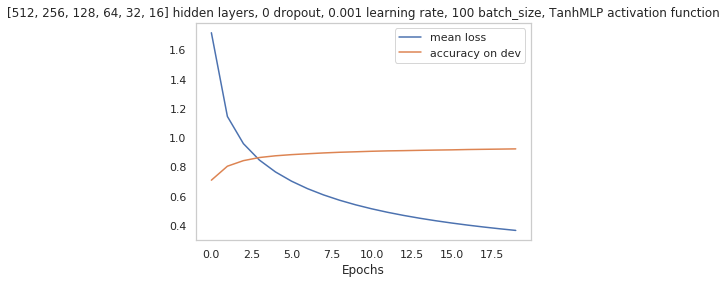

Starting epoch: 0
mean loss:  2.240704802905812
dev accuracy:  0.2778
Starting epoch: 1
mean loss:  1.9439154419244504
dev accuracy:  0.3652
Starting epoch: 2
mean loss:  1.7794243237551521
dev accuracy:  0.4332
Starting epoch: 3
mean loss:  1.659297132024578
dev accuracy:  0.4928
Starting epoch: 4
mean loss:  1.564974674991533
dev accuracy:  0.5392
Starting epoch: 5
mean loss:  1.4876762394811593
dev accuracy:  0.5763
Starting epoch: 6
mean loss:  1.4227158812915577
dev accuracy:  0.6069
Starting epoch: 7
mean loss:  1.3670928828856523
dev accuracy:  0.6356
Starting epoch: 8
mean loss:  1.3187065451752906
dev accuracy:  0.6603
Starting epoch: 9
mean loss:  1.2760561120276357
dev accuracy:  0.6805
Starting epoch: 10
mean loss:  1.238051414489746
dev accuracy:  0.6978
Starting epoch: 11
mean loss:  1.2038803825191422
dev accuracy:  0.7154
Starting epoch: 12
mean loss:  1.1729204117083083
dev accuracy:  0.7299
Starting epoch: 13
mean loss:  1.144681879118377
dev accuracy:  0.7417
Startin

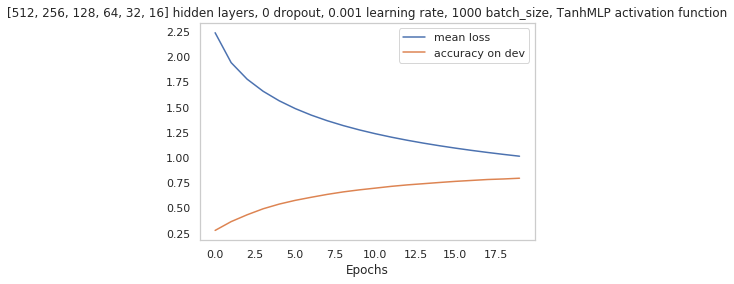

Starting epoch: 0
mean loss:  1.3593121656618745
dev accuracy:  0.8515
Starting epoch: 1
mean loss:  0.882348876974626
dev accuracy:  0.8833
Starting epoch: 2
mean loss:  0.732388870522061
dev accuracy:  0.8935
Starting epoch: 3
mean loss:  0.6477184115162827
dev accuracy:  0.9032
Starting epoch: 4
mean loss:  0.5909695069781782
dev accuracy:  0.9118
Starting epoch: 5
mean loss:  0.5451577154428238
dev accuracy:  0.9146
Starting epoch: 6
mean loss:  0.5113839501307573
dev accuracy:  0.9204
Starting epoch: 7
mean loss:  0.483325220096221
dev accuracy:  0.9253
Starting epoch: 8
mean loss:  0.457987682334818
dev accuracy:  0.9286
Starting epoch: 9
mean loss:  0.4371246418412317
dev accuracy:  0.9304
Starting epoch: 10
mean loss:  0.42158139534212663
dev accuracy:  0.933
Starting epoch: 11
mean loss:  0.40845050488745205
dev accuracy:  0.934
Starting epoch: 12
mean loss:  0.3950647100466558
dev accuracy:  0.9362
Starting epoch: 13
mean loss:  0.38546377037579393
dev accuracy:  0.9398
Start

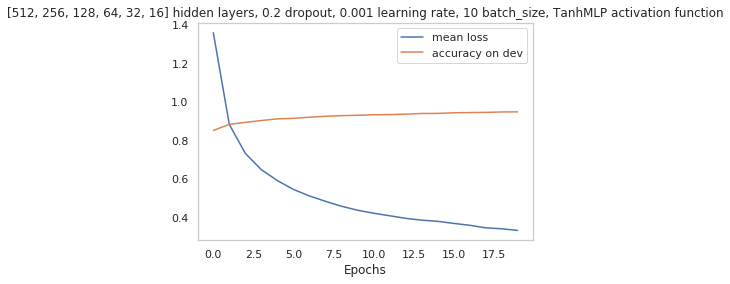

Starting epoch: 0
mean loss:  2.3297794869322024
dev accuracy:  0.5276
Starting epoch: 1
mean loss:  1.8728234675116169
dev accuracy:  0.6447
Starting epoch: 2
mean loss:  1.6713432385298068
dev accuracy:  0.7076
Starting epoch: 3
mean loss:  1.5350849385746939
dev accuracy:  0.7429
Starting epoch: 4
mean loss:  1.4365849116605198
dev accuracy:  0.7678
Starting epoch: 5
mean loss:  1.352698291847092
dev accuracy:  0.79
Starting epoch: 6
mean loss:  1.277569699668123
dev accuracy:  0.8057
Starting epoch: 7
mean loss:  1.219191245571106
dev accuracy:  0.8184
Starting epoch: 8
mean loss:  1.1654596107448647
dev accuracy:  0.8281
Starting epoch: 9
mean loss:  1.1255443612496534
dev accuracy:  0.8354
Starting epoch: 10
mean loss:  1.0809983313678506
dev accuracy:  0.841
Starting epoch: 11
mean loss:  1.04906946813275
dev accuracy:  0.8476
Starting epoch: 12
mean loss:  1.0123201837082823
dev accuracy:  0.8504
Starting epoch: 13
mean loss:  0.9894320661436298
dev accuracy:  0.8553
Starting e

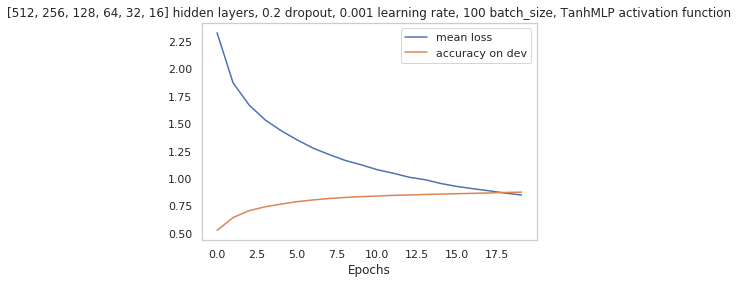

Starting epoch: 0
mean loss:  2.6505912846209956
dev accuracy:  0.1599
Starting epoch: 1
mean loss:  2.4856053941390095
dev accuracy:  0.2569
Starting epoch: 2
mean loss:  2.3511580392426135
dev accuracy:  0.3538
Starting epoch: 3
mean loss:  2.235418067258947
dev accuracy:  0.4417
Starting epoch: 4
mean loss:  2.1417595498702107
dev accuracy:  0.5007
Starting epoch: 5
mean loss:  2.056891396933911
dev accuracy:  0.5412
Starting epoch: 6
mean loss:  1.99194522932464
dev accuracy:  0.5741
Starting epoch: 7
mean loss:  1.9345195316800885
dev accuracy:  0.6025
Starting epoch: 8
mean loss:  1.8762655725666122
dev accuracy:  0.6229
Starting epoch: 9
mean loss:  1.8260066766364902
dev accuracy:  0.6442
Starting epoch: 10
mean loss:  1.7857946531445372
dev accuracy:  0.6607
Starting epoch: 11
mean loss:  1.7526439662073172
dev accuracy:  0.6769
Starting epoch: 12
mean loss:  1.7188188632329304
dev accuracy:  0.6895
Starting epoch: 13
mean loss:  1.6916527233871759
dev accuracy:  0.7011
Starti

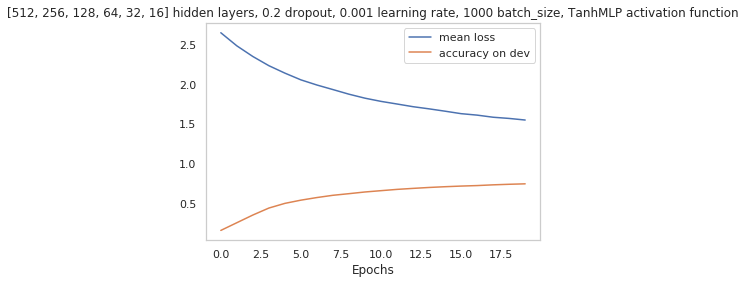

Starting epoch: 0
mean loss:  2.1447614222449127
dev accuracy:  0.6773
Starting epoch: 1
mean loss:  1.592476290908963
dev accuracy:  0.7548
Starting epoch: 2
mean loss:  1.3767794539775402
dev accuracy:  0.7902
Starting epoch: 3
mean loss:  1.2438958790022905
dev accuracy:  0.803
Starting epoch: 4
mean loss:  1.1412790088302205
dev accuracy:  0.815
Starting epoch: 5
mean loss:  1.077609140732078
dev accuracy:  0.828
Starting epoch: 6
mean loss:  1.0157002974715001
dev accuracy:  0.8373
Starting epoch: 7
mean loss:  0.9790656267643165
dev accuracy:  0.8481
Starting epoch: 8
mean loss:  0.9430853362334678
dev accuracy:  0.8566
Starting epoch: 9
mean loss:  0.9140448676624481
dev accuracy:  0.8674
Starting epoch: 10
mean loss:  0.886608503884052
dev accuracy:  0.8755
Starting epoch: 11
mean loss:  0.8585723648635513
dev accuracy:  0.8794
Starting epoch: 12
mean loss:  0.8406221393798976
dev accuracy:  0.8847
Starting epoch: 13
mean loss:  0.82387887653864
dev accuracy:  0.8883
Starting e

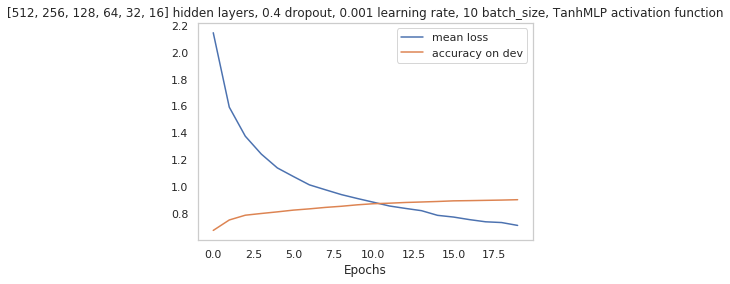

Starting epoch: 0
mean loss:  2.8269381404160976
dev accuracy:  0.3652
Starting epoch: 1
mean loss:  2.6066224694014073
dev accuracy:  0.4506
Starting epoch: 2
mean loss:  2.4456825656091383
dev accuracy:  0.5364
Starting epoch: 3
mean loss:  2.305925087538546
dev accuracy:  0.5998
Starting epoch: 4
mean loss:  2.203629637668709
dev accuracy:  0.637
Starting epoch: 5
mean loss:  2.106574734289965
dev accuracy:  0.6675
Starting epoch: 6
mean loss:  2.0380054681362982
dev accuracy:  0.693
Starting epoch: 7
mean loss:  1.965124171888995
dev accuracy:  0.7115
Starting epoch: 8
mean loss:  1.9003445621498092
dev accuracy:  0.7289
Starting epoch: 9
mean loss:  1.8508046963019762
dev accuracy:  0.7395
Starting epoch: 10
mean loss:  1.7993893818465059
dev accuracy:  0.7486
Starting epoch: 11
mean loss:  1.7583080030486968
dev accuracy:  0.7522
Starting epoch: 12
mean loss:  1.7126066932183301
dev accuracy:  0.7584
Starting epoch: 13
mean loss:  1.6665815533754116
dev accuracy:  0.7654
Starting

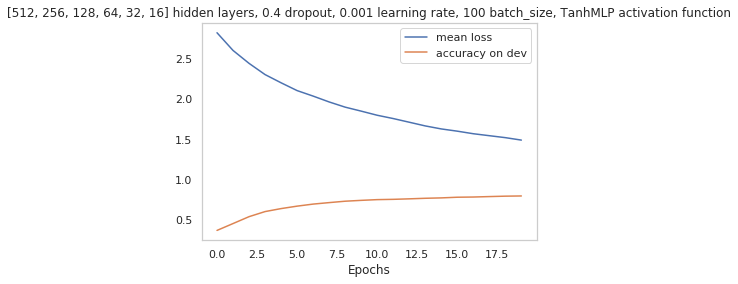

Starting epoch: 0
mean loss:  2.919518269744574
dev accuracy:  0.1014
Starting epoch: 1
mean loss:  2.8857018713857614
dev accuracy:  0.118
Starting epoch: 2
mean loss:  2.8539266212313783
dev accuracy:  0.14
Starting epoch: 3
mean loss:  2.827090707479739
dev accuracy:  0.1641
Starting epoch: 4
mean loss:  2.7908646639655617
dev accuracy:  0.1965
Starting epoch: 5
mean loss:  2.779021454792397
dev accuracy:  0.2239
Starting epoch: 6
mean loss:  2.745907615212833
dev accuracy:  0.2517
Starting epoch: 7
mean loss:  2.7270297302919277
dev accuracy:  0.2754
Starting epoch: 8
mean loss:  2.7099445193421605
dev accuracy:  0.3008
Starting epoch: 9
mean loss:  2.677517091526705
dev accuracy:  0.3218
Starting epoch: 10
mean loss:  2.6588317319458605
dev accuracy:  0.3434
Starting epoch: 11
mean loss:  2.6420467320610497
dev accuracy:  0.3654
Starting epoch: 12
mean loss:  2.61114390223634
dev accuracy:  0.383
Starting epoch: 13
mean loss:  2.5861510061750224
dev accuracy:  0.4008
Starting epoc

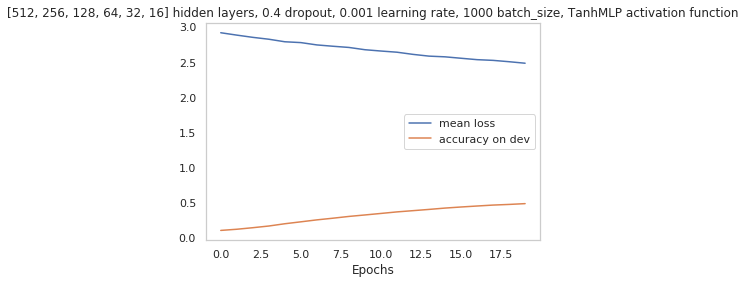

In [14]:
layer_dims_testing = [[128, 128], [128,64,32,16], [256,128,64,32,16], [512,256,128,64,32,16]]
input_dim = len(train_img[0])
dropout_values = [0, 0.2, 0.4]
learning_rates = [0.1, 0.01, 0.001]
models_list_tanh = []
mean_loss_list_tanh = []
dev_accuracy_list_tanh = []

EPOCHS = 20
batch_sizes = [10, 100, 1000]

cuda0 = torch.device('cuda:0')

for layerdim in layer_dims_testing:
    for lr in learning_rates:  
        for dropout_value in dropout_values:
            for batch_size in batch_sizes:
                model = TanhMLP(input_dim, layerdim, dropout_value)
                model.apply(init_weights)
                model.to(cuda0)
                optimizer = torch.optim.SGD(model.parameters(),lr=lr)
                model, mean_losses, dev_accus = training(model, train_img, train_label, NLLloss, optimizer, dev_img, dev_label, EPOCHS, batch_size)
                models_list_tanh.append(model)
                mean_loss_list_tanh.append(mean_losses)
                dev_accuracy_list_tanh.append(dev_accus)
                plot_graphs(mean_losses, dev_accus, dropout_value, layerdim, lr, batch_size, "TanhMLP")

Starting epoch: 0
mean loss:  0.34702429252596323
dev accuracy:  0.9286
Starting epoch: 1
mean loss:  0.16139966988188856
dev accuracy:  0.961
Starting epoch: 2
mean loss:  0.10403809938223321
dev accuracy:  0.9612
Starting epoch: 3
mean loss:  0.07761886700406696
dev accuracy:  0.9625
Starting epoch: 4
mean loss:  0.06340388000699795
dev accuracy:  0.966
Starting epoch: 5
mean loss:  0.0470935684507227
dev accuracy:  0.9643
Starting epoch: 6
mean loss:  0.03729474527989681
dev accuracy:  0.9719
Starting epoch: 7
mean loss:  0.025967589809532992
dev accuracy:  0.9725
Starting epoch: 8
mean loss:  0.02062191982587661
dev accuracy:  0.9743
Starting epoch: 9
mean loss:  0.01615479414059383
dev accuracy:  0.9786


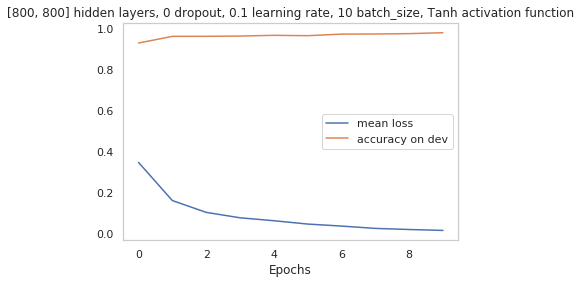

Starting epoch: 0
mean loss:  0.36145036532255465
dev accuracy:  0.9286
Starting epoch: 1
mean loss:  0.23110222072896366
dev accuracy:  0.948
Starting epoch: 2
mean loss:  0.17432500261389566
dev accuracy:  0.9587
Starting epoch: 3
mean loss:  0.13721635942895732
dev accuracy:  0.9644
Starting epoch: 4
mean loss:  0.11197799960980397
dev accuracy:  0.9677
Starting epoch: 5
mean loss:  0.093710196013014
dev accuracy:  0.9701
Starting epoch: 6
mean loss:  0.07984306644313707
dev accuracy:  0.9723
Starting epoch: 7
mean loss:  0.06888022552432117
dev accuracy:  0.974
Starting epoch: 8
mean loss:  0.05992810125880969
dev accuracy:  0.9751
Starting epoch: 9
mean loss:  0.052446994220395525
dev accuracy:  0.976


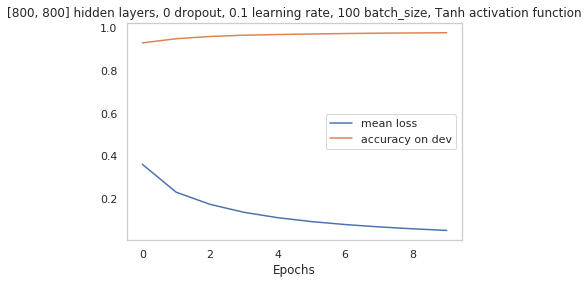

Starting epoch: 0
mean loss:  0.658067510992873
dev accuracy:  0.9004
Starting epoch: 1
mean loss:  0.3695889150395113
dev accuracy:  0.9122
Starting epoch: 2
mean loss:  0.3261023543628992
dev accuracy:  0.9175
Starting epoch: 3
mean loss:  0.30215994809188096
dev accuracy:  0.9203
Starting epoch: 4
mean loss:  0.28540629440662907
dev accuracy:  0.923
Starting epoch: 5
mean loss:  0.2722192283938913
dev accuracy:  0.9265
Starting epoch: 6
mean loss:  0.2610890450430851
dev accuracy:  0.9292
Starting epoch: 7
mean loss:  0.2512616558986552
dev accuracy:  0.9316
Starting epoch: 8
mean loss:  0.2423180704023324
dev accuracy:  0.9348
Starting epoch: 9
mean loss:  0.23401024353270436
dev accuracy:  0.9364


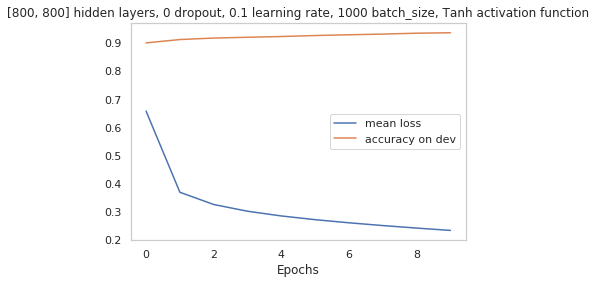

Starting epoch: 0
mean loss:  0.6277800172783312
dev accuracy:  0.9206
Starting epoch: 1
mean loss:  0.4753218090261468
dev accuracy:  0.945
Starting epoch: 2
mean loss:  0.43384472399343355
dev accuracy:  0.9444
Starting epoch: 3
mean loss:  0.4021104850349735
dev accuracy:  0.9607
Starting epoch: 4
mean loss:  0.3723068522630869
dev accuracy:  0.9575
Starting epoch: 5
mean loss:  0.3594986418148918
dev accuracy:  0.9623
Starting epoch: 6
mean loss:  0.3371545336953615
dev accuracy:  0.9635
Starting epoch: 7
mean loss:  0.3171351440727875
dev accuracy:  0.9523
Starting epoch: 8
mean loss:  0.3079076133977711
dev accuracy:  0.9654
Starting epoch: 9
mean loss:  0.2926482027560554
dev accuracy:  0.9611


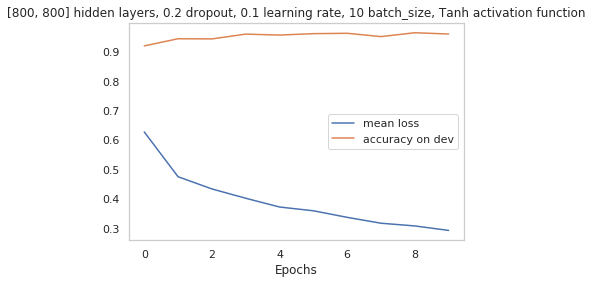

Starting epoch: 0
mean loss:  0.39582887033145586
dev accuracy:  0.9257
Starting epoch: 1
mean loss:  0.2775493680449303
dev accuracy:  0.9419
Starting epoch: 2
mean loss:  0.2296659643064716
dev accuracy:  0.9534
Starting epoch: 3
mean loss:  0.1936814365406593
dev accuracy:  0.9593
Starting epoch: 4
mean loss:  0.16704319630881506
dev accuracy:  0.9632
Starting epoch: 5
mean loss:  0.14685890952984015
dev accuracy:  0.9664
Starting epoch: 6
mean loss:  0.13096153283279813
dev accuracy:  0.9698
Starting epoch: 7
mean loss:  0.12030188028817762
dev accuracy:  0.9722
Starting epoch: 8
mean loss:  0.10909122682572482
dev accuracy:  0.974
Starting epoch: 9
mean loss:  0.09912272682692298
dev accuracy:  0.9746


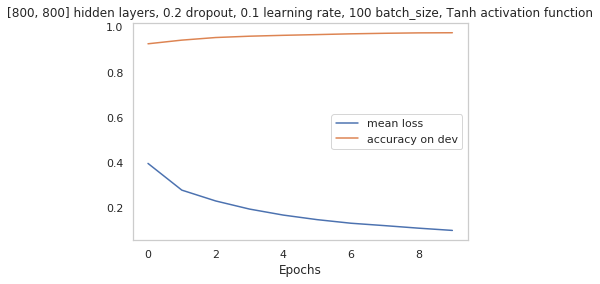

Starting epoch: 0
mean loss:  0.718835172699947
dev accuracy:  0.8987
Starting epoch: 1
mean loss:  0.4048183063666026
dev accuracy:  0.9106
Starting epoch: 2
mean loss:  0.3584008526568319
dev accuracy:  0.9175
Starting epoch: 3
mean loss:  0.33511605040699827
dev accuracy:  0.9195
Starting epoch: 4
mean loss:  0.32029927945604514
dev accuracy:  0.9226
Starting epoch: 5
mean loss:  0.30830997929853554
dev accuracy:  0.9245
Starting epoch: 6
mean loss:  0.2968182636826646
dev accuracy:  0.9261
Starting epoch: 7
mean loss:  0.2887627242826948
dev accuracy:  0.9271
Starting epoch: 8
mean loss:  0.2799542923184002
dev accuracy:  0.9295
Starting epoch: 9
mean loss:  0.2748410701751709
dev accuracy:  0.9315


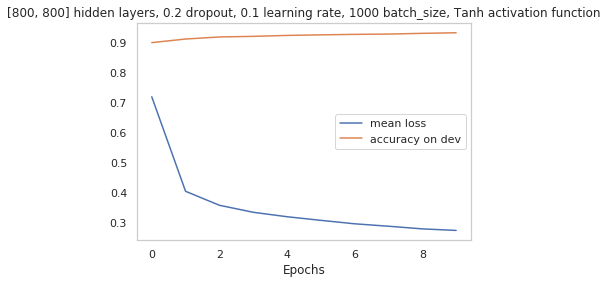

Starting epoch: 0
mean loss:  1.4431262361665615
dev accuracy:  0.9033
Starting epoch: 1
mean loss:  1.2254271006353656
dev accuracy:  0.9316
Starting epoch: 2
mean loss:  1.192088745089536
dev accuracy:  0.9437
Starting epoch: 3
mean loss:  1.1420468484088635
dev accuracy:  0.944
Starting epoch: 4
mean loss:  1.1268747100784073
dev accuracy:  0.939
Starting epoch: 5
mean loss:  1.1390104629867523
dev accuracy:  0.9472
Starting epoch: 6
mean loss:  1.0686620576477623
dev accuracy:  0.9493
Starting epoch: 7
mean loss:  1.0500031856199419
dev accuracy:  0.9558
Starting epoch: 8
mean loss:  1.0374058722147863
dev accuracy:  0.9447
Starting epoch: 9
mean loss:  1.0594527090225239
dev accuracy:  0.9566


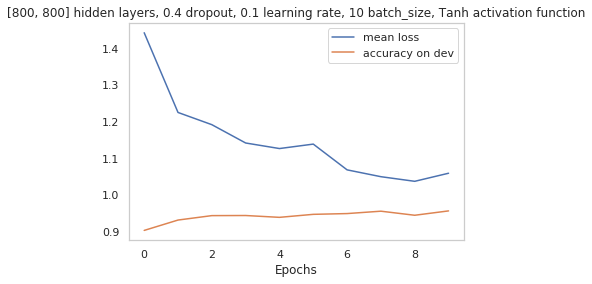

Starting epoch: 0
mean loss:  0.4538568649403825
dev accuracy:  0.9236
Starting epoch: 1
mean loss:  0.3315951391429958
dev accuracy:  0.9355
Starting epoch: 2
mean loss:  0.29215738505957844
dev accuracy:  0.9443
Starting epoch: 3
mean loss:  0.26015074433621294
dev accuracy:  0.9473
Starting epoch: 4
mean loss:  0.23582374188535943
dev accuracy:  0.9537
Starting epoch: 5
mean loss:  0.21324289488994672
dev accuracy:  0.9605
Starting epoch: 6
mean loss:  0.2004197553885792
dev accuracy:  0.9632
Starting epoch: 7
mean loss:  0.18686301864222615
dev accuracy:  0.9658
Starting epoch: 8
mean loss:  0.1740594742050071
dev accuracy:  0.967
Starting epoch: 9
mean loss:  0.16423638677317462
dev accuracy:  0.9692


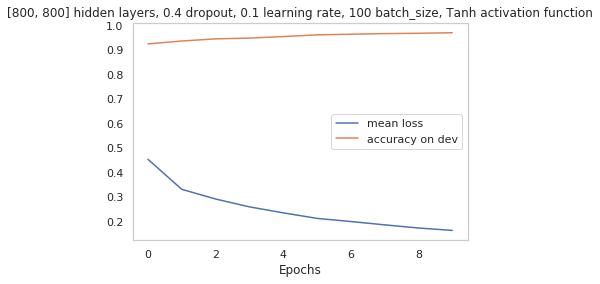

Starting epoch: 0
mean loss:  0.8217117073489171
dev accuracy:  0.8987
Starting epoch: 1
mean loss:  0.45997539162635803
dev accuracy:  0.9094
Starting epoch: 2
mean loss:  0.40717172096757326
dev accuracy:  0.914
Starting epoch: 3
mean loss:  0.3810040132672179
dev accuracy:  0.9181
Starting epoch: 4
mean loss:  0.3648185145621206
dev accuracy:  0.9189
Starting epoch: 5
mean loss:  0.34940048175699573
dev accuracy:  0.9207
Starting epoch: 6
mean loss:  0.3432504949616451
dev accuracy:  0.9224
Starting epoch: 7
mean loss:  0.3318585548915115
dev accuracy:  0.9239
Starting epoch: 8
mean loss:  0.3253451696797913
dev accuracy:  0.9245
Starting epoch: 9
mean loss:  0.32170800893914464
dev accuracy:  0.9255


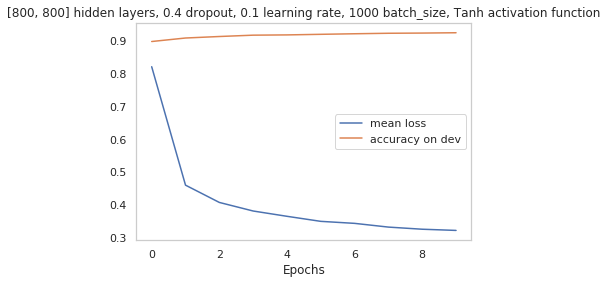

Starting epoch: 0
mean loss:  0.35132261336712367
dev accuracy:  0.9328
Starting epoch: 1
mean loss:  0.22353742015608574
dev accuracy:  0.9504
Starting epoch: 2
mean loss:  0.16914937452316675
dev accuracy:  0.9592
Starting epoch: 3
mean loss:  0.1338272978604481
dev accuracy:  0.9646
Starting epoch: 4
mean loss:  0.10964221939593244
dev accuracy:  0.9683
Starting epoch: 5
mean loss:  0.09197077779340045
dev accuracy:  0.9706
Starting epoch: 6
mean loss:  0.07841162117817035
dev accuracy:  0.9723
Starting epoch: 7
mean loss:  0.06762458031564082
dev accuracy:  0.9743
Starting epoch: 8
mean loss:  0.05880590788468596
dev accuracy:  0.975
Starting epoch: 9
mean loss:  0.051442583099925616
dev accuracy:  0.9761


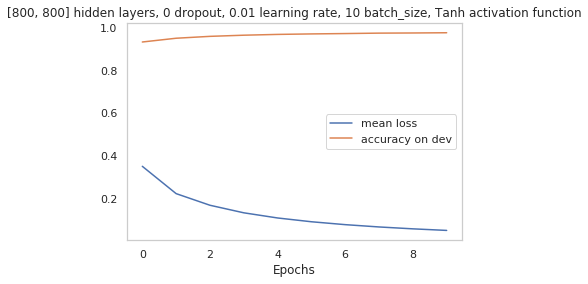

Starting epoch: 0
mean loss:  0.6471624058520723
dev accuracy:  0.8998
Starting epoch: 1
mean loss:  0.37701240871956726
dev accuracy:  0.9132
Starting epoch: 2
mean loss:  0.33236247089927545
dev accuracy:  0.9182
Starting epoch: 3
mean loss:  0.3079804952540797
dev accuracy:  0.9214
Starting epoch: 4
mean loss:  0.2910308862279751
dev accuracy:  0.9242
Starting epoch: 5
mean loss:  0.2777398807292213
dev accuracy:  0.9267
Starting epoch: 6
mean loss:  0.2665347890582627
dev accuracy:  0.9298
Starting epoch: 7
mean loss:  0.25663491576434133
dev accuracy:  0.9332
Starting epoch: 8
mean loss:  0.24761119111628827
dev accuracy:  0.9354
Starting epoch: 9
mean loss:  0.23921300588313216
dev accuracy:  0.9369


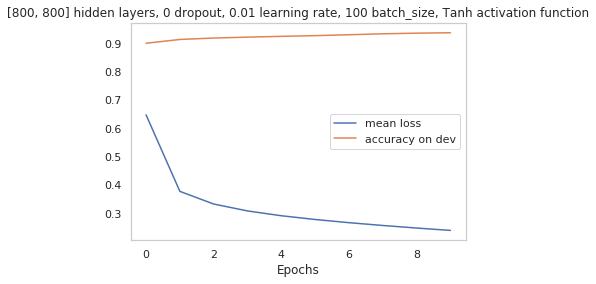

Starting epoch: 0
mean loss:  1.5119028675789927
dev accuracy:  0.797
Starting epoch: 1
mean loss:  0.8587237806881175
dev accuracy:  0.8477
Starting epoch: 2
mean loss:  0.6725261889252008
dev accuracy:  0.8655
Starting epoch: 3
mean loss:  0.5824745098749796
dev accuracy:  0.8756
Starting epoch: 4
mean loss:  0.5278277607525096
dev accuracy:  0.8839
Starting epoch: 5
mean loss:  0.49049321693532605
dev accuracy:  0.8897
Starting epoch: 6
mean loss:  0.46305423974990845
dev accuracy:  0.8942
Starting epoch: 7
mean loss:  0.44185788315885205
dev accuracy:  0.8982
Starting epoch: 8
mean loss:  0.4248778212304209
dev accuracy:  0.9015
Starting epoch: 9
mean loss:  0.4108921301131155
dev accuracy:  0.9039


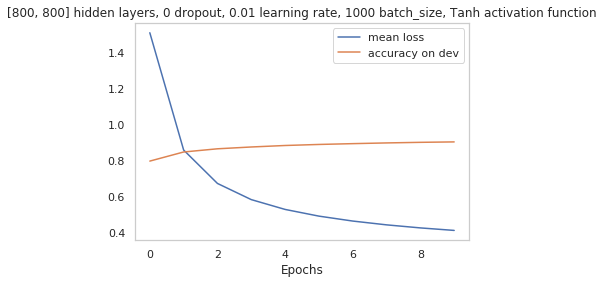

Starting epoch: 0
mean loss:  0.39152584545278185
dev accuracy:  0.9256
Starting epoch: 1
mean loss:  0.2760003076549124
dev accuracy:  0.9403
Starting epoch: 2
mean loss:  0.22817965898081033
dev accuracy:  0.9525
Starting epoch: 3
mean loss:  0.1918313834855139
dev accuracy:  0.958
Starting epoch: 4
mean loss:  0.1661655843444876
dev accuracy:  0.962
Starting epoch: 5
mean loss:  0.1464867097060668
dev accuracy:  0.9681
Starting epoch: 6
mean loss:  0.13188752182956048
dev accuracy:  0.9691
Starting epoch: 7
mean loss:  0.11879099745752107
dev accuracy:  0.9705
Starting epoch: 8
mean loss:  0.10966944562949477
dev accuracy:  0.9711
Starting epoch: 9
mean loss:  0.10096219781722432
dev accuracy:  0.9724


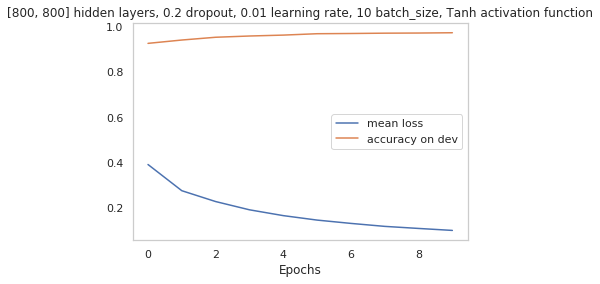

Starting epoch: 0
mean loss:  0.701100949339286
dev accuracy:  0.8973
Starting epoch: 1
mean loss:  0.4109576402488583
dev accuracy:  0.9105
Starting epoch: 2
mean loss:  0.36375757721726765
dev accuracy:  0.916
Starting epoch: 3
mean loss:  0.34017348579482404
dev accuracy:  0.9209
Starting epoch: 4
mean loss:  0.32279079407453537
dev accuracy:  0.9232
Starting epoch: 5
mean loss:  0.3111332216841018
dev accuracy:  0.9253
Starting epoch: 6
mean loss:  0.30155495937891347
dev accuracy:  0.9263
Starting epoch: 7
mean loss:  0.2940422673365789
dev accuracy:  0.9285
Starting epoch: 8
mean loss:  0.2852376989737718
dev accuracy:  0.9305
Starting epoch: 9
mean loss:  0.2774279576367485
dev accuracy:  0.9329


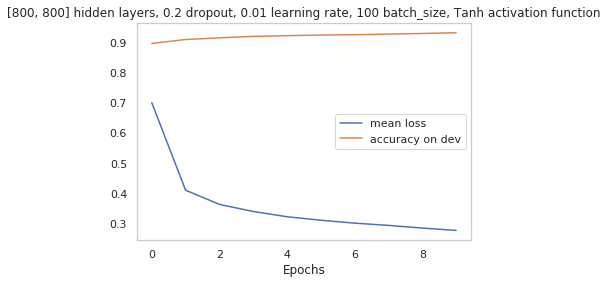

Starting epoch: 0
mean loss:  1.6326897915671854
dev accuracy:  0.7979
Starting epoch: 1
mean loss:  0.9453189747006285
dev accuracy:  0.8471
Starting epoch: 2
mean loss:  0.7354775982744554
dev accuracy:  0.8664
Starting epoch: 3
mean loss:  0.6367383400599161
dev accuracy:  0.8772
Starting epoch: 4
mean loss:  0.5756975038378846
dev accuracy:  0.8836
Starting epoch: 5
mean loss:  0.5339605311552683
dev accuracy:  0.8878
Starting epoch: 6
mean loss:  0.5049126189129025
dev accuracy:  0.892
Starting epoch: 7
mean loss:  0.4797366021894941
dev accuracy:  0.8957
Starting epoch: 8
mean loss:  0.46432557234577104
dev accuracy:  0.8978
Starting epoch: 9
mean loss:  0.44894297216452805
dev accuracy:  0.9002


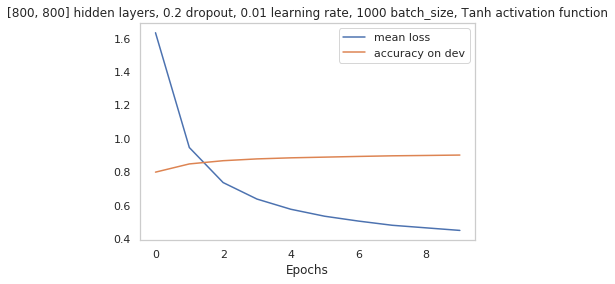

Starting epoch: 0
mean loss:  0.4514610962015762
dev accuracy:  0.9244
Starting epoch: 1
mean loss:  0.3325993682016108
dev accuracy:  0.9346
Starting epoch: 2
mean loss:  0.2914149129359691
dev accuracy:  0.9411
Starting epoch: 3
mean loss:  0.2639825774967176
dev accuracy:  0.9507
Starting epoch: 4
mean loss:  0.2351988518294569
dev accuracy:  0.9551
Starting epoch: 5
mean loss:  0.21568007605925327
dev accuracy:  0.9602
Starting epoch: 6
mean loss:  0.1970145686000598
dev accuracy:  0.9626
Starting epoch: 7
mean loss:  0.18382733778488372
dev accuracy:  0.9649
Starting epoch: 8
mean loss:  0.17080154018048516
dev accuracy:  0.9656
Starting epoch: 9
mean loss:  0.16214251012053532
dev accuracy:  0.9672


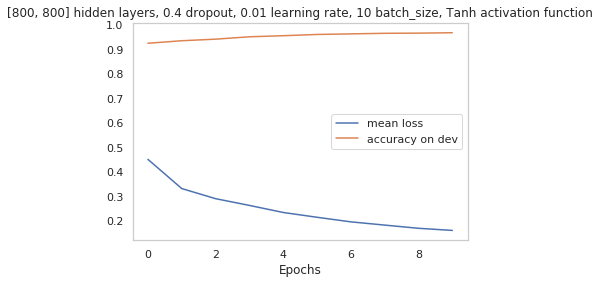

Starting epoch: 0
mean loss:  0.813704987961851
dev accuracy:  0.8924
Starting epoch: 1
mean loss:  0.47187308506099523
dev accuracy:  0.9052
Starting epoch: 2
mean loss:  0.41312922819883763
dev accuracy:  0.9134
Starting epoch: 3
mean loss:  0.3857853141373503
dev accuracy:  0.9162
Starting epoch: 4
mean loss:  0.3666123504380504
dev accuracy:  0.9181
Starting epoch: 5
mean loss:  0.35837318895462744
dev accuracy:  0.921
Starting epoch: 6
mean loss:  0.3466084134614396
dev accuracy:  0.9222
Starting epoch: 7
mean loss:  0.33889245635973003
dev accuracy:  0.9235
Starting epoch: 8
mean loss:  0.32870668101453493
dev accuracy:  0.9247
Starting epoch: 9
mean loss:  0.32344523937759284
dev accuracy:  0.9266


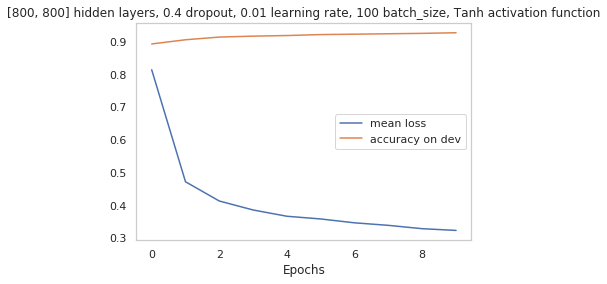

Starting epoch: 0
mean loss:  1.7696543113858092
dev accuracy:  0.7911
Starting epoch: 1
mean loss:  1.0871907893349142
dev accuracy:  0.8387
Starting epoch: 2
mean loss:  0.8508380511227776
dev accuracy:  0.8572
Starting epoch: 3
mean loss:  0.7360549241888756
dev accuracy:  0.8677
Starting epoch: 4
mean loss:  0.6666821919235528
dev accuracy:  0.8752
Starting epoch: 5
mean loss:  0.6200481255849203
dev accuracy:  0.8806
Starting epoch: 6
mean loss:  0.5817256102374956
dev accuracy:  0.8855
Starting epoch: 7
mean loss:  0.5558466034777024
dev accuracy:  0.8886
Starting epoch: 8
mean loss:  0.5364812565784828
dev accuracy:  0.8906
Starting epoch: 9
mean loss:  0.5142241038528144
dev accuracy:  0.8929


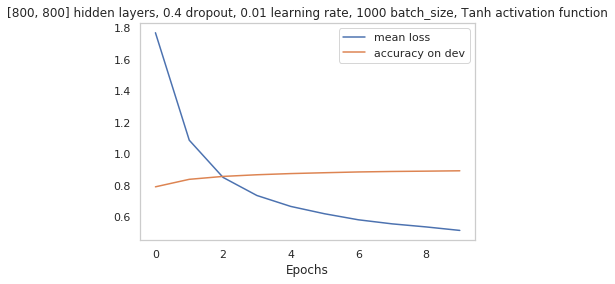

Starting epoch: 0
mean loss:  0.6508962657474692
dev accuracy:  0.9004
Starting epoch: 1
mean loss:  0.37209980290474726
dev accuracy:  0.9144
Starting epoch: 2
mean loss:  0.32865294445677773
dev accuracy:  0.9197
Starting epoch: 3
mean loss:  0.3050924649207345
dev accuracy:  0.9226
Starting epoch: 4
mean loss:  0.288673569779963
dev accuracy:  0.9246
Starting epoch: 5
mean loss:  0.2757359864756352
dev accuracy:  0.9278
Starting epoch: 6
mean loss:  0.26478024040957976
dev accuracy:  0.93
Starting epoch: 7
mean loss:  0.2550682563903069
dev accuracy:  0.9322
Starting epoch: 8
mean loss:  0.24619529890579966
dev accuracy:  0.9349
Starting epoch: 9
mean loss:  0.23792502630265105
dev accuracy:  0.937


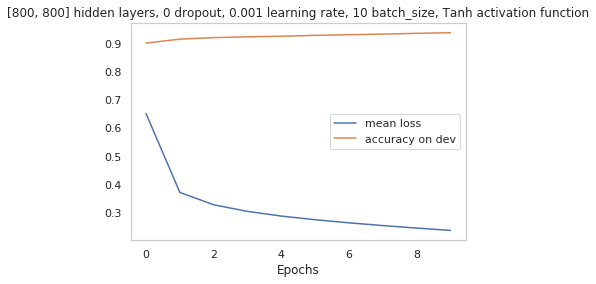

Starting epoch: 0
mean loss:  1.5290668101129894
dev accuracy:  0.7992
Starting epoch: 1
mean loss:  0.8688708942331478
dev accuracy:  0.8522
Starting epoch: 2
mean loss:  0.6793131559432861
dev accuracy:  0.8674
Starting epoch: 3
mean loss:  0.5882362421163304
dev accuracy:  0.8789
Starting epoch: 4
mean loss:  0.5333547332210693
dev accuracy:  0.8881
Starting epoch: 5
mean loss:  0.4960427446636611
dev accuracy:  0.8918
Starting epoch: 6
mean loss:  0.46870255166898944
dev accuracy:  0.8945
Starting epoch: 7
mean loss:  0.44761686669495293
dev accuracy:  0.8971
Starting epoch: 8
mean loss:  0.4307368765036741
dev accuracy:  0.8993
Starting epoch: 9
mean loss:  0.416833997159423
dev accuracy:  0.9021


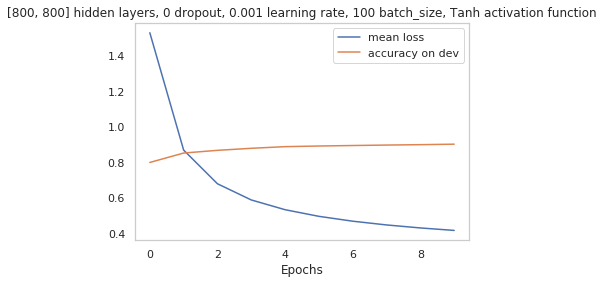

Starting epoch: 0
mean loss:  2.2716885361016965
dev accuracy:  0.2567
Starting epoch: 1
mean loss:  1.9883292726441926
dev accuracy:  0.4348
Starting epoch: 2
mean loss:  1.7782554743336696
dev accuracy:  0.5481
Starting epoch: 3
mean loss:  1.609442114830017
dev accuracy:  0.6237
Starting epoch: 4
mean loss:  1.4715609830968521
dev accuracy:  0.676
Starting epoch: 5
mean loss:  1.358053162986157
dev accuracy:  0.7155
Starting epoch: 6
mean loss:  1.2637665715872073
dev accuracy:  0.7389
Starting epoch: 7
mean loss:  1.1846543223250146
dev accuracy:  0.7613
Starting epoch: 8
mean loss:  1.117584934421614
dev accuracy:  0.7761
Starting epoch: 9
mean loss:  1.0601490549012726
dev accuracy:  0.7908


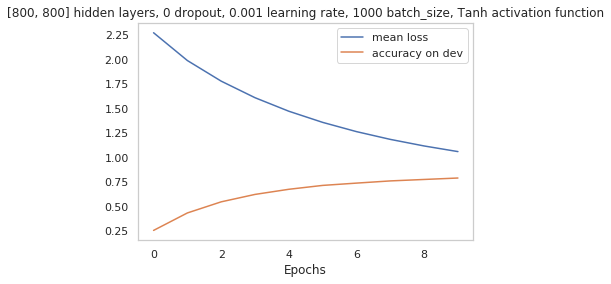

Starting epoch: 0
mean loss:  0.7138428256717164
dev accuracy:  0.9003
Starting epoch: 1
mean loss:  0.4083859291012568
dev accuracy:  0.9111
Starting epoch: 2
mean loss:  0.3621020970780047
dev accuracy:  0.9167
Starting epoch: 3
mean loss:  0.33886852504291093
dev accuracy:  0.9204
Starting epoch: 4
mean loss:  0.32297152704558335
dev accuracy:  0.9239
Starting epoch: 5
mean loss:  0.30897997735655564
dev accuracy:  0.9249
Starting epoch: 6
mean loss:  0.30070654166051536
dev accuracy:  0.9275
Starting epoch: 7
mean loss:  0.29092315402951996
dev accuracy:  0.9289
Starting epoch: 8
mean loss:  0.28451490483137426
dev accuracy:  0.9308
Starting epoch: 9
mean loss:  0.27782031269002855
dev accuracy:  0.9323


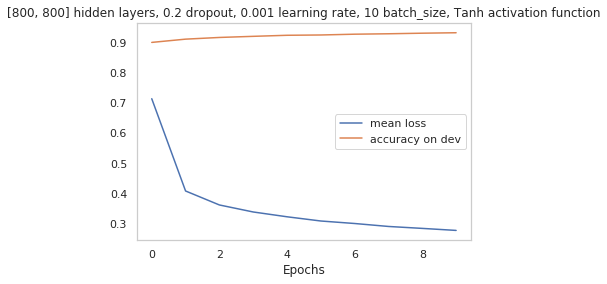

Starting epoch: 0
mean loss:  1.6640186632226803
dev accuracy:  0.7736
Starting epoch: 1
mean loss:  0.9725829906568317
dev accuracy:  0.8391
Starting epoch: 2
mean loss:  0.7620445174609354
dev accuracy:  0.8607
Starting epoch: 3
mean loss:  0.6585295219978172
dev accuracy:  0.8704
Starting epoch: 4
mean loss:  0.5957409305248907
dev accuracy:  0.8781
Starting epoch: 5
mean loss:  0.5520332274798624
dev accuracy:  0.8839
Starting epoch: 6
mean loss:  0.5238893807767157
dev accuracy:  0.8884
Starting epoch: 7
mean loss:  0.49878727235717923
dev accuracy:  0.8912
Starting epoch: 8
mean loss:  0.47907587201771384
dev accuracy:  0.8948
Starting epoch: 9
mean loss:  0.46218875428278766
dev accuracy:  0.898


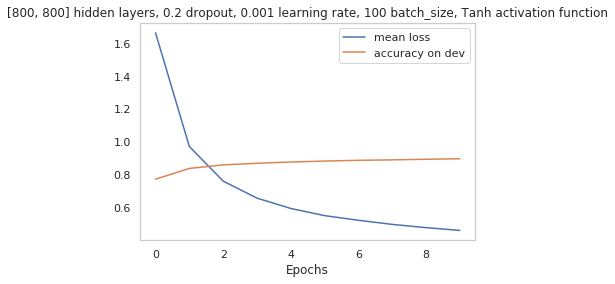

Starting epoch: 0
mean loss:  2.3741684614443312
dev accuracy:  0.2167
Starting epoch: 1
mean loss:  2.120084935543584
dev accuracy:  0.3745
Starting epoch: 2
mean loss:  1.9133236221238679
dev accuracy:  0.4997
Starting epoch: 3
mean loss:  1.7426191731995226
dev accuracy:  0.5898
Starting epoch: 4
mean loss:  1.6000583826326857
dev accuracy:  0.6605
Starting epoch: 5
mean loss:  1.4837479427749036
dev accuracy:  0.7055
Starting epoch: 6
mean loss:  1.3835642945532705
dev accuracy:  0.7337
Starting epoch: 7
mean loss:  1.2967768486808329
dev accuracy:  0.7568
Starting epoch: 8
mean loss:  1.2262674873950434
dev accuracy:  0.7735
Starting epoch: 9
mean loss:  1.1641865618088667
dev accuracy:  0.786


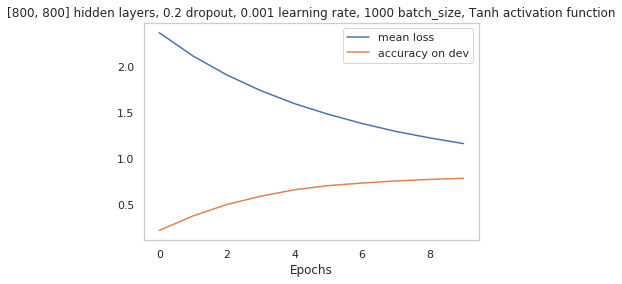

Starting epoch: 0
mean loss:  0.807421491387319
dev accuracy:  0.8964
Starting epoch: 1
mean loss:  0.4651768001120845
dev accuracy:  0.909
Starting epoch: 2
mean loss:  0.4140705219411303
dev accuracy:  0.9131
Starting epoch: 3
mean loss:  0.386121144276347
dev accuracy:  0.917
Starting epoch: 4
mean loss:  0.3710119905992389
dev accuracy:  0.9196
Starting epoch: 5
mean loss:  0.3573677069761739
dev accuracy:  0.9216
Starting epoch: 6
mean loss:  0.34953916760284803
dev accuracy:  0.9226
Starting epoch: 7
mean loss:  0.3408914385312247
dev accuracy:  0.924
Starting epoch: 8
mean loss:  0.33273188617148236
dev accuracy:  0.9251
Starting epoch: 9
mean loss:  0.3278385262563527
dev accuracy:  0.9271


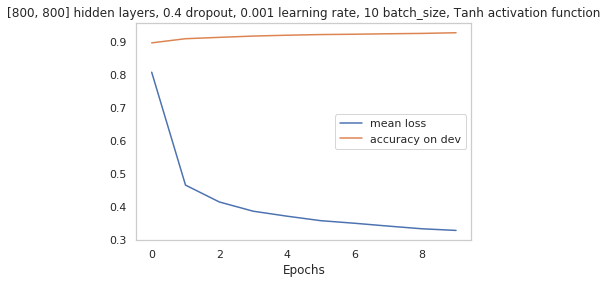

Starting epoch: 0
mean loss:  1.8910220892367486
dev accuracy:  0.7764
Starting epoch: 1
mean loss:  1.1420185781286625
dev accuracy:  0.8381
Starting epoch: 2
mean loss:  0.8904123813092352
dev accuracy:  0.8597
Starting epoch: 3
mean loss:  0.7571396323259243
dev accuracy:  0.8698
Starting epoch: 4
mean loss:  0.6817707715039244
dev accuracy:  0.8771
Starting epoch: 5
mean loss:  0.6309952998232699
dev accuracy:  0.8822
Starting epoch: 6
mean loss:  0.5964455025162764
dev accuracy:  0.8855
Starting epoch: 7
mean loss:  0.5658923886612266
dev accuracy:  0.889
Starting epoch: 8
mean loss:  0.5434662796066193
dev accuracy:  0.8913
Starting epoch: 9
mean loss:  0.5247138774918463
dev accuracy:  0.8947


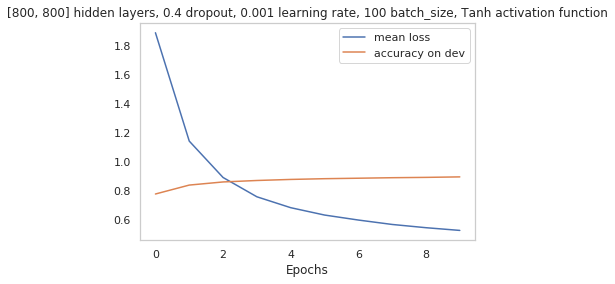

Starting epoch: 0
mean loss:  2.3636219641741585
dev accuracy:  0.3603
Starting epoch: 1
mean loss:  2.151852939643112
dev accuracy:  0.4837
Starting epoch: 2
mean loss:  1.9910892528646134
dev accuracy:  0.5675
Starting epoch: 3
mean loss:  1.858928315779742
dev accuracy:  0.6261
Starting epoch: 4
mean loss:  1.7320193426281798
dev accuracy:  0.6668
Starting epoch: 5
mean loss:  1.6315128686381322
dev accuracy:  0.6948
Starting epoch: 6
mean loss:  1.5412704056384516
dev accuracy:  0.7185
Starting epoch: 7
mean loss:  1.4593665155709958
dev accuracy:  0.7389
Starting epoch: 8
mean loss:  1.393095240873449
dev accuracy:  0.7575
Starting epoch: 9
mean loss:  1.3324535056656481
dev accuracy:  0.7709


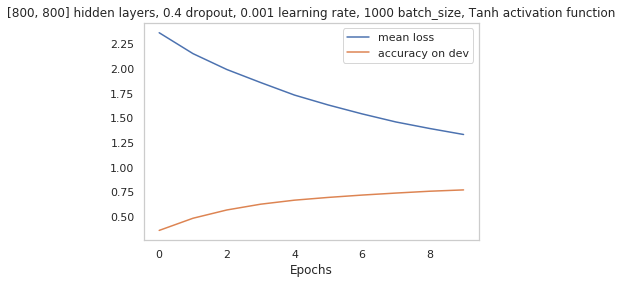

In [20]:
layer_dims_testing = [[800,800]]
input_dim = len(train_img[0])
dropout_values = [0, 0.2, 0.4]
learning_rates = [0.1, 0.01, 0.001]
models_list_TanhMLP = []
mean_loss_list_TanhMLP = []
dev_accuracy_list_TanhMLP = []

EPOCHS = 10
batch_sizes = [10, 100, 1000]

cuda0 = torch.device('cuda:0')

for layerdim in layer_dims_testing:
    for lr in learning_rates:  
        for dropout_value in dropout_values:
            for batch_size in batch_sizes:
                model = TanhMLP(input_dim, layerdim, dropout_value)
                model.apply(init_weights)
                model.to(cuda0)
                optimizer = torch.optim.SGD(model.parameters(),lr=lr)
                model, mean_losses, dev_accus = training(model, train_img, train_label, NLLloss, optimizer, dev_img, dev_label, EPOCHS, batch_size)
                models_list_TanhMLP.append(model)
                mean_loss_list_TanhMLP.append(mean_losses)
                dev_accuracy_list_TanhMLP.append(dev_accus)
                plot_graphs(mean_losses, dev_accus, dropout_value, layerdim, lr, batch_size, "Tanh")